In [ ]:
import numpy as np
import pandas as pdac
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from sklearn.model_selection import KFold
import multiprocessing
from joblib import Parallel, delayed
import optuna
import optuna
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
import joblib
import pandas as pd
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
import warnings
import os
import re
import xarray as xr
import rioxarray as rxr
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
# Optional imports with fallbacks
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import joblib
import os
import re
from pathlib import Path
import warnings

In [132]:
# SOC mapping with LUtype enhancement - Updated for interaction features 11172028
import os
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb

# ===================== Configuration =====================
MODEL_PATH = 'F:/model/results_with_int/xgb_model.json'  # Updated path
FEATURE_NAMES_PATH = 'F:/model/results_with_int/feature_names.txt'  # Feature names from training
FEATURE_CSV_PATH = 'F:/model/Mapping_select_features.csv'
INPUT_TIF_FOLDER = 'F:\cleaned_tifs_no_extremes_iqr'

timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/Mapping_SOC_topsoil_with_int_{timestamp}.tif'

TARGET_CARBON = "SOC"
TARGET_LAYER = "topsoil"
N_JOBS = 4
CHUNK_SIZE = 500
# ======================================================


def create_interaction_features(lu_data, continuous_data, continuous_var_name, model_feature_names):
    """
    Create interaction features between LUtype and continuous variables (BD, S_C, pH)
    Follows the same pattern as training: LUtype_OHE * continuous_var
    """
    interaction_features = {}
    
    # Create one-hot encoding for LUtype values 1-7
    for i in range(1, 8):  # LUtype values 1-7
        ohe_feature_name = f'LUtype_OHE_{i}'
        interaction_feature_name = f'{continuous_var_name}_Int_LUtype_{i}'
        
        # Only create if this interaction feature is expected by the model
        if interaction_feature_name in model_feature_names:
            # Create one-hot encoding for this LUtype value
            if lu_data.dtype.kind in ['U', 'S', 'O']:
                ohe_mask = np.where(lu_data == str(i), 1.0, 0.0)
            else:
                ohe_mask = np.where(lu_data == i, 1.0, 0.0)
            
            # Handle missing values in LUtype
            ohe_mask = np.where(np.isnan(lu_data), 0.0, ohe_mask)
            
            # Handle missing values in continuous data
            cont_data_clean = np.where(np.isnan(continuous_data), 0.0, continuous_data)
            
            # Create interaction: OHE * continuous variable
            interaction_feature = ohe_mask * cont_data_clean
            interaction_features[interaction_feature_name] = interaction_feature
            
            # Also store the OHE feature if needed by model
            if ohe_feature_name in model_feature_names:
                interaction_features[ohe_feature_name] = ohe_mask
    
    return interaction_features


def create_dynamic_features(chunk_data, model_feature_names):
    """
    Dynamically create all features required by the model including interaction features
    """
    print("   🛠️ Creating dynamic features with interactions...")

    # === Basic feature mapping ===
    base_mapping = {
        'Landuse_type': 'LUtype',
        'LU_type': 'LUtype',
        'LU-type': 'LUtype',
        'Recovery_mode': 'Recovmode',
        't_bd': 'BD',
        't_ph': 'pH',
        't_sand': 'S_C',
        't_oc': 'TC',
        'TN13': 'TN',
        'TK13': 'TK',
        'Vege_type': 'Vegetype'
    }

    for csv_feat, model_feat in base_mapping.items():
        if csv_feat in chunk_data and model_feat not in chunk_data:
            chunk_data[model_feat] = chunk_data[csv_feat]

    # === Ensure LUtype exists ===
    lu_candidates = [k for k in ['LUtype', 'Landuse_type', 'LU_type', 'LU-type'] if k in chunk_data]
    if lu_candidates:
        lu_key = lu_candidates[0]
        chunk_data['LUtype'] = chunk_data[lu_key]
    else:
        raise ValueError("❌ LUtype feature not found, please check input files or CSV mapping.")

    lu_data = chunk_data['LUtype']

    # Print LUtype basic statistics
    non_nan = ~np.isnan(lu_data)
    if np.any(non_nan):
        unique_vals = np.unique(lu_data[non_nan])
        print(f"   📊 LUtype valid pixels: {np.sum(non_nan)}, unique categories: {unique_vals}")
    else:
        print("   ⚠️ LUtype all NaN!")

    # === Create interaction features (BD, S_C, pH with LUtype) ===
    print("   🔄 Creating LUtype interaction features...")
    
    interaction_targets = ['BD', 'S_C', 'pH']
    for cont_var in interaction_targets:
        if cont_var in chunk_data:
            print(f"   → Creating {cont_var} interactions...")
            interactions = create_interaction_features(
                lu_data=lu_data,
                continuous_data=chunk_data[cont_var],
                continuous_var_name=cont_var,
                model_feature_names=model_feature_names
            )
            chunk_data.update(interactions)
            print(f"   ✅ Created {len(interactions)} {cont_var} interaction features")
        else:
            print(f"   ⚠️ {cont_var} not available for interaction creation")

    # === Additional LUtype enhanced features ===
    # LUtype缺失位置直接设为0
    lu_data_filled = np.where(np.isnan(lu_data), 0, lu_data)
    
    # Only create these if they're in model features
    if 'LUtype_boost_1' in model_feature_names:
        chunk_data['LUtype_boost_1'] = lu_data_filled
    if 'LUtype_boost_2' in model_feature_names:
        chunk_data['LUtype_boost_2'] = lu_data_filled
    if 'LUtype_squared' in model_feature_names:
        chunk_data['LUtype_squared'] = lu_data_filled ** 2

    # === Traditional LUtype interaction features ===
    interaction_feats = ['pH', 'BD', 'Age', 'Altitude']
    for feat in interaction_feats:
        if feat in chunk_data:
            feat_data = chunk_data[feat]
            feat_data_filled = np.where(np.isnan(feat_data), 0, feat_data)
            interaction_name = f'LUtype_{feat}_interaction'
            if interaction_name in model_feature_names:
                chunk_data[interaction_name] = lu_data_filled * feat_data_filled

    # === Fill missing features ===
    first_key = next(iter(chunk_data))
    missing_features = []
    for feat in model_feature_names:
        if feat not in chunk_data:
            chunk_data[feat] = np.zeros_like(chunk_data[first_key])
            missing_features.append(feat)
    
    if missing_features:
        print(f"   ⚠️ Created default values for {len(missing_features)} features: {missing_features[:10]}{'...' if len(missing_features) > 10 else ''}")

    return chunk_data


def validate_feature_compatibility(model_feature_names, chunk_data_sample):
    """
    Validate that all model features can be created from input data
    """
    print("\n🔍 Validating feature compatibility...")
    
    # Check interaction features
    interaction_features = [f for f in model_feature_names if '_Int_' in f]
    print(f"   Model expects {len(interaction_features)} interaction features")
    
    # Check LUtype one-hot features
    lu_ohe_features = [f for f in model_feature_names if f.startswith('LUtype_OHE_')]
    print(f"   Model expects {len(lu_ohe_features)} LUtype OHE features: {lu_ohe_features}")
    
    # Check if we have required base features
    required_base_features = ['LUtype', 'Altitude', 'Lon', 'Lat']
    missing_base = [f for f in required_base_features if f not in chunk_data_sample]
    if missing_base:
        print(f"   ❌ Missing base features: {missing_base}")
        return False
    
    # Check continuous variables for interactions
    interaction_vars = ['BD', 'S_C', 'pH']
    available_interaction_vars = [f for f in interaction_vars if f in chunk_data_sample]
    print(f"   ✅ Available interaction variables: {available_interaction_vars}")
    
    return True


def check_lutype_coverage(lu_data, model_feature_names):
    """
    Check how well the LUtype data covers the expected interaction features
    """
    print("   📊 Analyzing LUtype coverage for interactions...")
    
    non_nan_mask = ~np.isnan(lu_data)
    if not np.any(non_nan_mask):
        print("   ⚠️ No valid LUtype data found!")
        return
    
    valid_lu_data = lu_data[non_nan_mask]
    
    # Check coverage for expected interaction features (LUtype 1-7)
    expected_lutypes = list(range(1, 8))
    coverage_stats = {}
    
    for lutype_val in expected_lutypes:
        # Check both OHE and interaction features
        ohe_feature_name = f'LUtype_OHE_{lutype_val}'
        interaction_features = [f for f in model_feature_names if f'_Int_LUtype_{lutype_val}' in f]
        
        count = np.sum(valid_lu_data == lutype_val)
        coverage_stats[lutype_val] = {
            'count': count,
            'ohe_feature': ohe_feature_name in model_feature_names,
            'interaction_features': len(interaction_features)
        }
        
        if count > 0:
            print(f"   📈 LUtype {lutype_val}: {count} pixels ({count/len(valid_lu_data)*100:.2f}%) - "
                  f"OHE: {ohe_feature_name in model_feature_names}, "
                  f"Interactions: {len(interaction_features)}")
    
    # Check missing values
    nan_count = np.sum(np.isnan(lu_data))
    if nan_count > 0:
        print(f"   ⚠️ LUtype missing values: {nan_count} pixels ({nan_count/len(lu_data)*100:.2f}%) - WILL BE SET TO 0")
    
    return coverage_stats


def check_feature_completeness(chunk_data, key_features):
    """
    Check if all key features have valid data for each pixel
    Returns a mask indicating pixels with complete data
    """
    print("   🔍 Checking feature completeness...")
    
    # Start with all pixels being valid
    complete_mask = np.ones_like(next(iter(chunk_data.values())), dtype=bool)
    total_pixels = len(complete_mask)
    
    # Check each key feature for missing values
    for feature in key_features:
        if feature in chunk_data:
            feature_data = chunk_data[feature]
            feature_valid = ~np.isnan(feature_data)
            missing_count = total_pixels - np.sum(feature_valid)
            
            if missing_count > 0:
                print(f"   ⚠️ {feature}: {missing_count} missing pixels ({missing_count/total_pixels*100:.2f}%)")
                complete_mask &= feature_valid
            else:
                print(f"   ✅ {feature}: complete")
        else:
            print(f"   ❌ {feature}: not found in chunk data")
            # If a key feature is missing, no pixels are complete
            complete_mask = np.zeros_like(complete_mask, dtype=bool)
    
    complete_count = np.sum(complete_mask)
    print(f"   📊 Complete data pixels: {complete_count}/{total_pixels} ({complete_count/total_pixels*100:.2f}%)")
    
    return complete_mask


def load_model_feature_names():
    """
    Load feature names from the trained model
    """
    print("📂 Loading model feature names...")
    
    # First try to load from feature_names.txt
    if os.path.exists(FEATURE_NAMES_PATH):
        with open(FEATURE_NAMES_PATH, 'r') as f:
            feature_names = [line.strip() for line in f.readlines() if line.strip()]
        print(f"✅ Loaded {len(feature_names)} features from {FEATURE_NAMES_PATH}")
        return feature_names
    
    # If not available, load model and get feature names
    print("⚠️ Feature names file not found, loading model to extract features...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)
    
    if hasattr(xgb_model, 'feature_names') and xgb_model.feature_names:
        feature_names = xgb_model.feature_names
        print(f"✅ Extracted {len(feature_names)} features from model")
        
        # Save for future use
        os.makedirs(os.path.dirname(FEATURE_NAMES_PATH), exist_ok=True)
        with open(FEATURE_NAMES_PATH, 'w') as f:
            f.write('\n'.join(feature_names))
        print(f"💾 Saved features to {FEATURE_NAMES_PATH}")
        
        return feature_names
    else:
        raise ValueError("❌ Could not extract feature names from model")


def conservative_process():
    """Ultra-conservative memory processing version - only predict pixels with complete data"""
    print("📂 Loading model feature names...")
    model_feature_names = load_model_feature_names()
    
    print("📂 Loading select features from CSV...")
    select_features = pd.read_csv(FEATURE_CSV_PATH, index_col=None).iloc[:, 0].dropna().tolist()

    print("📂 Loading reference layer...")
    reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
    ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
    ref_shape = ref_da.shape
    coords_x, coords_y = ref_da['x'], ref_da['y']

    print("🤖 Loading model...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)

    print(f"📋 Model expected features count: {len(model_feature_names)}")
    
    # Analyze feature types
    interaction_features = [f for f in model_feature_names if '_Int_' in f]
    lu_ohe_features = [f for f in model_feature_names if f.startswith('LUtype_OHE_')]
    traditional_features = [f for f in model_feature_names if f not in interaction_features and f not in lu_ohe_features]
    
    print(f"🔍 Feature breakdown:")
    print(f"   Traditional features: {len(traditional_features)}")
    print(f"   LUtype OHE features: {len(lu_ohe_features)}")
    print(f"   Interaction features: {len(interaction_features)}")
    print(f"   Total: {len(model_feature_names)}")

    # Define key features that must be complete for prediction
    key_features = ['LUtype', 'Vegetype', 'Recovmode', 'Altitude', 'Lon', 'Lat']
    
    # Check missing input files
    missing_files = [f for f in select_features if not os.path.exists(os.path.join(INPUT_TIF_FOLDER, f"{f}.tif"))]
    if missing_files:
        print(f"⚠️ Missing feature files ({len(missing_files)}): {missing_files}")

    result_array = np.full(ref_shape, np.nan, dtype=np.float32)
    total_processed = 0

    # === Chunk processing ===
    for chunk_start in range(0, ref_shape[0], CHUNK_SIZE):
        chunk_end = min(chunk_start + CHUNK_SIZE, ref_shape[0])
        print(f"\n🔍 Processing row chunk {chunk_start}-{chunk_end}")

        chunk_data = {}

        # Load all features for this chunk
        for feat in select_features:
            tif_path = os.path.join(INPUT_TIF_FOLDER, f"{feat}.tif")
            if not os.path.exists(tif_path):
                continue
            try:
                with rxr.open_rasterio(tif_path, masked=True) as da:
                    da_squeezed = da.squeeze()
                    chunk_values = da_squeezed.isel(y=slice(chunk_start, chunk_end)).values

                    # Lon / Lat special handling
                    if feat == 'Lon':
                        chunk_values = np.tile(coords_x.values, (chunk_end - chunk_start, 1))
                    elif feat == 'Lat':
                        lat_values = coords_y.isel(y=slice(chunk_start, chunk_end)).values.reshape(-1, 1)
                        chunk_values = np.tile(lat_values, (1, ref_shape[1]))

                    flat_values = chunk_values.reshape(-1)
                    chunk_data[feat] = flat_values

            except Exception as e:
                print(f"   ❌ Read error {feat}: {e}")
                continue

        # Check if we have any data in this chunk
        if not chunk_data:
            print("   ℹ️ No data in this chunk, skipping...")
            continue

        # Check LUtype coverage before feature creation
        if 'LUtype' in chunk_data:
            check_lutype_coverage(chunk_data['LUtype'], model_feature_names)

        # Validate feature compatibility before dynamic feature creation
        if not validate_feature_compatibility(model_feature_names, chunk_data):
            print("   ❌ Feature compatibility validation failed, skipping chunk")
            continue

        # Dynamic feature creation with interactions
        chunk_data = create_dynamic_features(chunk_data, model_feature_names)

        # Check completeness - only predict pixels with complete data
        complete_mask = check_feature_completeness(chunk_data, key_features)

        # Check if we have any complete pixels
        complete_indices = np.where(complete_mask)[0]
        if len(complete_indices) == 0:
            print("   ℹ️ No pixels with complete data in this chunk, skipping prediction")
            continue

        # Check model feature completeness
        missing = set(model_feature_names) - set(chunk_data.keys())
        if missing:
            print(f"   ❌ Still missing features: {list(missing)[:10]}{'...' if len(missing) > 10 else ''}")
            continue

        # Prepare data for prediction
        df_chunk = pd.DataFrame({f: chunk_data[f] for f in model_feature_names})
        complete_data = df_chunk.iloc[complete_indices]

        print(f"   ⚡ Predicting {len(complete_data)} pixels with complete data")
        dtest = xgb.DMatrix(complete_data.values, feature_names=model_feature_names, nthread=N_JOBS)
        predictions = xgb_model.predict(dtest, validate_features=False)

        # Calculate global indices for this chunk
        chunk_pixels = (chunk_end - chunk_start) * ref_shape[1]
        global_indices = np.arange(chunk_start * ref_shape[1], chunk_start * ref_shape[1] + chunk_pixels)
        complete_global_indices = global_indices[complete_indices]
        
        # Convert 1D indices to 2D coordinates
        y_idx = complete_global_indices // ref_shape[1]
        x_idx = complete_global_indices % ref_shape[1]
        
        # Store predictions only for complete pixels
        result_array[y_idx, x_idx] = predictions

        total_processed += len(predictions)
        print(f"   ✅ Chunk completed, cumulative processed {total_processed} pixels")

        del df_chunk, complete_data, dtest, predictions
        gc.collect()

    # === Save results ===
    print("\n💾 Saving results...")
    pred_da = xr.DataArray(result_array, coords={"y": coords_y, "x": coords_x}, dims=("y", "x"),
                           name=f"{TARGET_CARBON}_{TARGET_LAYER}")
    pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    pred_da = pred_da.rio.write_crs("EPSG:4326")

    os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)
    pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)

    print(f"🎉 Completed: {OUTPUT_TIF_PATH}")

    # === Statistics ===
    valid_pixels = np.sum(~np.isnan(result_array))
    total_pixels = result_array.size
    print(f"📊 Final statistics:")
    print(f"   Total pixels: {total_pixels}")
    print(f"   Predicted pixels: {valid_pixels} ({valid_pixels/total_pixels*100:.2f}%)")
    print(f"   Missing pixels: {total_pixels - valid_pixels} ({(total_pixels - valid_pixels)/total_pixels*100:.2f}%)")
    print(f"   Total processed pixels: {total_processed}")
    if valid_pixels > 0:
        print(f"   Prediction range: [{np.nanmin(result_array):.4f}, {np.nanmax(result_array):.4f}]")


if __name__ == "__main__":
    print("=== SOC Mapping with LUtype Interaction Features ===")
    print(f"Model: {MODEL_PATH}")
    print(f"Input: {INPUT_TIF_FOLDER}")
    print(f"Output: {OUTPUT_TIF_PATH}")
    conservative_process()

=== SOC Mapping with LUtype Interaction Features ===
Model: F:/model/results_with_int/xgb_model.json
Input: F:\cleaned_tifs_no_extremes_iqr
Output: F:/model/results/Mapping_SOC_topsoil_with_int_20251117_2057.tif
📂 Loading model feature names...
📂 Loading model feature names...
✅ Loaded 53 features from F:/model/results_with_int/feature_names.txt
📂 Loading select features from CSV...
📂 Loading reference layer...
🤖 Loading model...
📋 Model expected features count: 53
🔍 Feature breakdown:
   Traditional features: 32
   LUtype OHE features: 0
   Interaction features: 21
   Total: 53

🔍 Processing row chunk 0-500
   📊 Analyzing LUtype coverage for interactions...
   ⚠️ No valid LUtype data found!

🔍 Validating feature compatibility...
   Model expects 21 interaction features
   Model expects 0 LUtype OHE features: []
   ✅ Available interaction variables: []
   🛠️ Creating dynamic features with interactions...
   ⚠️ LUtype all NaN!
   🔄 Creating LUtype interaction features...
   → Creating B

In [ ]:
# SOC mapping with LUtype enhancement - Updated for interaction features 11172028
import os
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb

# ===================== Configuration =====================
MODEL_PATH = 'F:/model/results_with_int/xgb_model.json'  # Updated path
FEATURE_NAMES_PATH = 'F:/model/results_with_int/feature_names.txt'  # Feature names from training
FEATURE_CSV_PATH = 'F:/model/Mapping_select_features.csv'
INPUT_TIF_FOLDER = 'F:\cleaned_tifs_no_extremes_iqr'

timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/Mapping_SOC_topsoil_with_int_{timestamp}.tif'

TARGET_CARBON = "SOC"
TARGET_LAYER = "topsoil"
N_JOBS = 4
CHUNK_SIZE = 500
# ======================================================


def create_interaction_features(lu_data, continuous_data, continuous_var_name, model_feature_names):
    """
    Create interaction features between LUtype and continuous variables (BD, S_C, pH)
    Follows the same pattern as training: LUtype_OHE * continuous_var
    """
    interaction_features = {}
    
    # Create one-hot encoding for LUtype values 1-7
    for i in range(1, 8):  # LUtype values 1-7
        ohe_feature_name = f'LUtype_OHE_{i}'
        interaction_feature_name = f'{continuous_var_name}_Int_LUtype_{i}'
        
        # Only create if this interaction feature is expected by the model
        if interaction_feature_name in model_feature_names:
            # Create one-hot encoding for this LUtype value
            if lu_data.dtype.kind in ['U', 'S', 'O']:
                ohe_mask = np.where(lu_data == str(i), 1.0, 0.0)
            else:
                ohe_mask = np.where(lu_data == i, 1.0, 0.0)
            
            # Handle missing values in LUtype
            ohe_mask = np.where(np.isnan(lu_data), 0.0, ohe_mask)
            
            # Handle missing values in continuous data
            cont_data_clean = np.where(np.isnan(continuous_data), 0.0, continuous_data)
            
            # Create interaction: OHE * continuous variable
            interaction_feature = ohe_mask * cont_data_clean
            interaction_features[interaction_feature_name] = interaction_feature
            
            # Also store the OHE feature if needed by model
            if ohe_feature_name in model_feature_names:
                interaction_features[ohe_feature_name] = ohe_mask
    
    return interaction_features


def create_dynamic_features(chunk_data, model_feature_names):
    """
    Dynamically create all features required by the model including interaction features
    """
    print("   🛠️ Creating dynamic features with interactions...")

    # === Basic feature mapping ===
    base_mapping = {
        'Landuse_type': 'LUtype',
        'LU_type': 'LUtype',
        'LU-type': 'LUtype',
        'Recovery_mode': 'Recovmode',
        't_bd': 'BD',
        't_ph': 'pH',
        't_sand': 'S_C',
        't_oc': 'TC',
        'TN13': 'TN',
        'TK13': 'TK',
        'Vege_type': 'Vegetype'
    }

    for csv_feat, model_feat in base_mapping.items():
        if csv_feat in chunk_data and model_feat not in chunk_data:
            chunk_data[model_feat] = chunk_data[csv_feat]

    # === Ensure LUtype exists ===
    lu_candidates = [k for k in ['LUtype', 'Landuse_type', 'LU_type', 'LU-type'] if k in chunk_data]
    if lu_candidates:
        lu_key = lu_candidates[0]
        chunk_data['LUtype'] = chunk_data[lu_key]
    else:
        raise ValueError("❌ LUtype feature not found, please check input files or CSV mapping.")

    lu_data = chunk_data['LUtype']

    # Print LUtype basic statistics
    non_nan = ~np.isnan(lu_data)
    if np.any(non_nan):
        unique_vals = np.unique(lu_data[non_nan])
        print(f"   📊 LUtype valid pixels: {np.sum(non_nan)}, unique categories: {unique_vals}")
    else:
        print("   ⚠️ LUtype all NaN!")

    # === Create interaction features (BD, S_C, pH with LUtype) ===
    print("   🔄 Creating LUtype interaction features...")
    
    interaction_targets = ['BD', 'S_C', 'pH']
    for cont_var in interaction_targets:
        if cont_var in chunk_data:
            print(f"   → Creating {cont_var} interactions...")
            interactions = create_interaction_features(
                lu_data=lu_data,
                continuous_data=chunk_data[cont_var],
                continuous_var_name=cont_var,
                model_feature_names=model_feature_names
            )
            chunk_data.update(interactions)
            print(f"   ✅ Created {len(interactions)} {cont_var} interaction features")
        else:
            print(f"   ⚠️ {cont_var} not available for interaction creation")

    # === Additional LUtype enhanced features ===
    # LUtype缺失位置直接设为0
    lu_data_filled = np.where(np.isnan(lu_data), 0, lu_data)
    
    # Only create these if they're in model features
    if 'LUtype_boost_1' in model_feature_names:
        chunk_data['LUtype_boost_1'] = lu_data_filled
    if 'LUtype_boost_2' in model_feature_names:
        chunk_data['LUtype_boost_2'] = lu_data_filled
    if 'LUtype_squared' in model_feature_names:
        chunk_data['LUtype_squared'] = lu_data_filled ** 2

    # === Traditional LUtype interaction features ===
    interaction_feats = ['pH', 'BD', 'Age', 'Altitude']
    for feat in interaction_feats:
        if feat in chunk_data:
            feat_data = chunk_data[feat]
            feat_data_filled = np.where(np.isnan(feat_data), 0, feat_data)
            interaction_name = f'LUtype_{feat}_interaction'
            if interaction_name in model_feature_names:
                chunk_data[interaction_name] = lu_data_filled * feat_data_filled

    # === category_2 enhancement ===
    # 对于缺失的LUtype，category_2相关特征设为0
    if lu_data.dtype.kind in ['U', 'S', 'O']:
        category_2_mask = np.where(lu_data == '2', 1, 0)
    else:
        category_2_mask = np.where(lu_data == 2, 1, 0)
    
    # 确保缺失位置为0
    category_2_mask = np.where(np.isnan(lu_data), 0, category_2_mask)

    ratio = category_2_mask.mean()
    print(f"   🧩 category_2 proportion: {ratio*100:.2f}%")

    # Only create category_2 features if they're in model
    category_2_features = {
        'category_2_indicator': category_2_mask,
        'category_2_weight': category_2_mask * (1 / max(ratio, 0.1))
    }
    
    for i in range(1, 5):
        category_2_features[f'category_2_boost_{i}'] = category_2_mask * i

    for feat in interaction_feats:
        if feat in chunk_data:
            feat_data = chunk_data[feat]
            feat_data_filled = np.where(np.isnan(feat_data), 0, feat_data)
            category_2_features[f'category_2_{feat}_interaction'] = category_2_mask * feat_data_filled

    # Only add category features that are in model
    for feat_name, feat_data in category_2_features.items():
        if feat_name in model_feature_names:
            chunk_data[feat_name] = feat_data

    # === Fill missing features ===
    first_key = next(iter(chunk_data))
    missing_features = []
    for feat in model_feature_names:
        if feat not in chunk_data:
            chunk_data[feat] = np.zeros_like(chunk_data[first_key])
            missing_features.append(feat)
    
    if missing_features:
        print(f"   ⚠️ Created default values for {len(missing_features)} features: {missing_features[:10]}{'...' if len(missing_features) > 10 else ''}")

    return chunk_data


def validate_feature_compatibility(model_feature_names, chunk_data_sample):
    """
    Validate that all model features can be created from input data
    """
    print("\n🔍 Validating feature compatibility...")
    
    # Check interaction features
    interaction_features = [f for f in model_feature_names if '_Int_' in f]
    print(f"   Model expects {len(interaction_features)} interaction features")
    
    # Check LUtype one-hot features
    lu_ohe_features = [f for f in model_feature_names if f.startswith('LUtype_OHE_')]
    print(f"   Model expects {len(lu_ohe_features)} LUtype OHE features: {lu_ohe_features}")
    
    # Check if we have required base features
    required_base_features = ['LUtype', 'Altitude', 'Lon', 'Lat']
    missing_base = [f for f in required_base_features if f not in chunk_data_sample]
    if missing_base:
        print(f"   ❌ Missing base features: {missing_base}")
        return False
    
    # Check continuous variables for interactions
    interaction_vars = ['BD', 'S_C', 'pH']
    available_interaction_vars = [f for f in interaction_vars if f in chunk_data_sample]
    print(f"   ✅ Available interaction variables: {available_interaction_vars}")
    
    return True


def check_lutype_coverage(lu_data, model_feature_names):
    """
    Check how well the LUtype data covers the expected interaction features
    """
    print("   📊 Analyzing LUtype coverage for interactions...")
    
    non_nan_mask = ~np.isnan(lu_data)
    if not np.any(non_nan_mask):
        print("   ⚠️ No valid LUtype data found!")
        return
    
    valid_lu_data = lu_data[non_nan_mask]
    
    # Check coverage for expected interaction features (LUtype 1-7)
    expected_lutypes = list(range(1, 8))
    coverage_stats = {}
    
    for lutype_val in expected_lutypes:
        # Check both OHE and interaction features
        ohe_feature_name = f'LUtype_OHE_{lutype_val}'
        interaction_features = [f for f in model_feature_names if f'_Int_LUtype_{lutype_val}' in f]
        
        count = np.sum(valid_lu_data == lutype_val)
        coverage_stats[lutype_val] = {
            'count': count,
            'ohe_feature': ohe_feature_name in model_feature_names,
            'interaction_features': len(interaction_features)
        }
        
        if count > 0:
            print(f"   📈 LUtype {lutype_val}: {count} pixels ({count/len(valid_lu_data)*100:.2f}%) - "
                  f"OHE: {ohe_feature_name in model_feature_names}, "
                  f"Interactions: {len(interaction_features)}")
    
    # Check missing values
    nan_count = np.sum(np.isnan(lu_data))
    if nan_count > 0:
        print(f"   ⚠️ LUtype missing values: {nan_count} pixels ({nan_count/len(lu_data)*100:.2f}%) - WILL BE SET TO 0")
    
    return coverage_stats


def check_feature_completeness(chunk_data, key_features):
    """
    Check if all key features have valid data for each pixel
    Returns a mask indicating pixels with complete data
    """
    print("   🔍 Checking feature completeness...")
    
    # Start with all pixels being valid
    complete_mask = np.ones_like(next(iter(chunk_data.values())), dtype=bool)
    total_pixels = len(complete_mask)
    
    # Check each key feature for missing values
    for feature in key_features:
        if feature in chunk_data:
            feature_data = chunk_data[feature]
            feature_valid = ~np.isnan(feature_data)
            missing_count = total_pixels - np.sum(feature_valid)
            
            if missing_count > 0:
                print(f"   ⚠️ {feature}: {missing_count} missing pixels ({missing_count/total_pixels*100:.2f}%)")
                complete_mask &= feature_valid
            else:
                print(f"   ✅ {feature}: complete")
        else:
            print(f"   ❌ {feature}: not found in chunk data")
            # If a key feature is missing, no pixels are complete
            complete_mask = np.zeros_like(complete_mask, dtype=bool)
    
    complete_count = np.sum(complete_mask)
    print(f"   📊 Complete data pixels: {complete_count}/{total_pixels} ({complete_count/total_pixels*100:.2f}%)")
    
    return complete_mask


def load_model_feature_names():
    """
    Load feature names from the trained model
    """
    print("📂 Loading model feature names...")
    
    # First try to load from feature_names.txt
    if os.path.exists(FEATURE_NAMES_PATH):
        with open(FEATURE_NAMES_PATH, 'r') as f:
            feature_names = [line.strip() for line in f.readlines() if line.strip()]
        print(f"✅ Loaded {len(feature_names)} features from {FEATURE_NAMES_PATH}")
        return feature_names
    
    # If not available, load model and get feature names
    print("⚠️ Feature names file not found, loading model to extract features...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)
    
    if hasattr(xgb_model, 'feature_names') and xgb_model.feature_names:
        feature_names = xgb_model.feature_names
        print(f"✅ Extracted {len(feature_names)} features from model")
        
        # Save for future use
        os.makedirs(os.path.dirname(FEATURE_NAMES_PATH), exist_ok=True)
        with open(FEATURE_NAMES_PATH, 'w') as f:
            f.write('\n'.join(feature_names))
        print(f"💾 Saved features to {FEATURE_NAMES_PATH}")
        
        return feature_names
    else:
        raise ValueError("❌ Could not extract feature names from model")


def conservative_process():
    """Ultra-conservative memory processing version - only predict pixels with complete data"""
    print("📂 Loading model feature names...")
    model_feature_names = load_model_feature_names()
    
    print("📂 Loading select features from CSV...")
    select_features = pd.read_csv(FEATURE_CSV_PATH, index_col=None).iloc[:, 0].dropna().tolist()

    print("📂 Loading reference layer...")
    reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
    ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
    ref_shape = ref_da.shape
    coords_x, coords_y = ref_da['x'], ref_da['y']

    print("🤖 Loading model...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)

    print(f"📋 Model expected features count: {len(model_feature_names)}")
    
    # Analyze feature types
    interaction_features = [f for f in model_feature_names if '_Int_' in f]
    lu_ohe_features = [f for f in model_feature_names if f.startswith('LUtype_OHE_')]
    traditional_features = [f for f in model_feature_names if f not in interaction_features and f not in lu_ohe_features]
    
    print(f"🔍 Feature breakdown:")
    print(f"   Traditional features: {len(traditional_features)}")
    print(f"   LUtype OHE features: {len(lu_ohe_features)}")
    print(f"   Interaction features: {len(interaction_features)}")
    print(f"   Total: {len(model_feature_names)}")

    # Define key features that must be complete for prediction
    key_features = ['LUtype', 'Vegetype', 'Recovmode', 'Altitude', 'Lon', 'Lat']
    
    # Check missing input files
    missing_files = [f for f in select_features if not os.path.exists(os.path.join(INPUT_TIF_FOLDER, f"{f}.tif"))]
    if missing_files:
        print(f"⚠️ Missing feature files ({len(missing_files)}): {missing_files}")

    result_array = np.full(ref_shape, np.nan, dtype=np.float32)
    total_processed = 0

    # === Chunk processing ===
    for chunk_start in range(0, ref_shape[0], CHUNK_SIZE):
        chunk_end = min(chunk_start + CHUNK_SIZE, ref_shape[0])
        print(f"\n🔍 Processing row chunk {chunk_start}-{chunk_end}")

        chunk_data = {}

        # Load all features for this chunk
        for feat in select_features:
            tif_path = os.path.join(INPUT_TIF_FOLDER, f"{feat}.tif")
            if not os.path.exists(tif_path):
                continue
            try:
                with rxr.open_rasterio(tif_path, masked=True) as da:
                    da_squeezed = da.squeeze()
                    chunk_values = da_squeezed.isel(y=slice(chunk_start, chunk_end)).values

                    # Lon / Lat special handling
                    if feat == 'Lon':
                        chunk_values = np.tile(coords_x.values, (chunk_end - chunk_start, 1))
                    elif feat == 'Lat':
                        lat_values = coords_y.isel(y=slice(chunk_start, chunk_end)).values.reshape(-1, 1)
                        chunk_values = np.tile(lat_values, (1, ref_shape[1]))

                    flat_values = chunk_values.reshape(-1)
                    chunk_data[feat] = flat_values

            except Exception as e:
                print(f"   ❌ Read error {feat}: {e}")
                continue

        # Check if we have any data in this chunk
        if not chunk_data:
            print("   ℹ️ No data in this chunk, skipping...")
            continue

        # Check LUtype coverage before feature creation
        if 'LUtype' in chunk_data:
            check_lutype_coverage(chunk_data['LUtype'], model_feature_names)

        # Validate feature compatibility before dynamic feature creation
        if not validate_feature_compatibility(model_feature_names, chunk_data):
            print("   ❌ Feature compatibility validation failed, skipping chunk")
            continue

        # Dynamic feature creation with interactions
        chunk_data = create_dynamic_features(chunk_data, model_feature_names)

        # Check completeness - only predict pixels with complete data
        complete_mask = check_feature_completeness(chunk_data, key_features)

        # Check if we have any complete pixels
        complete_indices = np.where(complete_mask)[0]
        if len(complete_indices) == 0:
            print("   ℹ️ No pixels with complete data in this chunk, skipping prediction")
            continue

        # Check model feature completeness
        missing = set(model_feature_names) - set(chunk_data.keys())
        if missing:
            print(f"   ❌ Still missing features: {list(missing)[:10]}{'...' if len(missing) > 10 else ''}")
            continue

        # Prepare data for prediction
        df_chunk = pd.DataFrame({f: chunk_data[f] for f in model_feature_names})
        complete_data = df_chunk.iloc[complete_indices]

        print(f"   ⚡ Predicting {len(complete_data)} pixels with complete data")
        dtest = xgb.DMatrix(complete_data.values, feature_names=model_feature_names, nthread=N_JOBS)
        predictions = xgb_model.predict(dtest, validate_features=False)

        # Calculate global indices for this chunk
        chunk_pixels = (chunk_end - chunk_start) * ref_shape[1]
        global_indices = np.arange(chunk_start * ref_shape[1], chunk_start * ref_shape[1] + chunk_pixels)
        complete_global_indices = global_indices[complete_indices]
        
        # Convert 1D indices to 2D coordinates
        y_idx = complete_global_indices // ref_shape[1]
        x_idx = complete_global_indices % ref_shape[1]
        
        # Store predictions only for complete pixels
        result_array[y_idx, x_idx] = predictions

        total_processed += len(predictions)
        print(f"   ✅ Chunk completed, cumulative processed {total_processed} pixels")

        del df_chunk, complete_data, dtest, predictions
        gc.collect()

    # === Save results ===
    print("\n💾 Saving results...")
    pred_da = xr.DataArray(result_array, coords={"y": coords_y, "x": coords_x}, dims=("y", "x"),
                           name=f"{TARGET_CARBON}_{TARGET_LAYER}")
    pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    pred_da = pred_da.rio.write_crs("EPSG:4326")

    os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)
    pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)

    print(f"🎉 Completed: {OUTPUT_TIF_PATH}")

    # === Statistics ===
    valid_pixels = np.sum(~np.isnan(result_array))
    total_pixels = result_array.size
    print(f"📊 Final statistics:")
    print(f"   Total pixels: {total_pixels}")
    print(f"   Predicted pixels: {valid_pixels} ({valid_pixels/total_pixels*100:.2f}%)")
    print(f"   Missing pixels: {total_pixels - valid_pixels} ({(total_pixels - valid_pixels)/total_pixels*100:.2f}%)")
    print(f"   Total processed pixels: {total_processed}")
    if valid_pixels > 0:
        print(f"   Prediction range: [{np.nanmin(result_array):.4f}, {np.nanmax(result_array):.4f}]")


if __name__ == "__main__":
    print("=== SOC Mapping with LUtype Interaction Features ===")
    print(f"Model: {MODEL_PATH}")
    print(f"Input: {INPUT_TIF_FOLDER}")
    print(f"Output: {OUTPUT_TIF_PATH}")
    conservative_process()

=== SOC Mapping with LUtype Interaction Features ===
Model: F:/model/results_with_int/xgb_model.json
Input: F:\cleaned_tifs_no_extremes_iqr
Output: F:/model/results/Mapping_SOC_topsoil_with_int_20251116_2114.tif
📂 Loading model feature names...
📂 Loading model feature names...
✅ Loaded 53 features from F:/model/results_with_int/feature_names.txt
📂 Loading select features from CSV...
📂 Loading reference layer...
🤖 Loading model...
📋 Model expected features count: 53
🔍 Feature breakdown:
   Traditional features: 32
   LUtype OHE features: 0
   Interaction features: 21
   Total: 53

🔍 Processing row chunk 0-500
   📊 Analyzing LUtype coverage for interactions...
   ⚠️ No valid LUtype data found!

🔍 Validating feature compatibility...
   Model expects 21 interaction features
   Model expects 0 LUtype OHE features: []
   ✅ Available interaction variables: []
   🛠️ Creating dynamic features with interactions...
   ⚠️ LUtype all NaN!
   🔄 Creating LUtype interaction features...
   → Creating B

In [129]:
# SOC mapping with LUtype mapping only specific area

import os
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb
import re

# ===================== Configuration =====================
# 🎯 假设您已将训练好的模型保存为 .bin 格式，以避免 UnicodeDecodeError
MODEL_PATH = 'F:/model/results_with_int/xgb_model.json' 
FEATURE_CSV_PATH = 'F:/model/Mapping_select_features.csv' 
INPUT_TIF_FOLDER = 'F:/cleaned_tifs_no_extremes_iqr' # 包含所有输入 TIF 文件的路径

timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results_with_int/Mapping_SOC_topsoil_{timestamp}.tif'

TARGET_CARBON = "SOC"
TARGET_LAYER = "topsoil"
N_JOBS = 4
CHUNK_SIZE = 500
# ======================================================

def create_lutype_onehot_and_interaction_features(chunk_data, model_feature_names):
    """
    创建 LUtype 的 OHE 特征和 LUtype 与连续变量的交互特征 (例如 BD, S_C, pH)。
    LUtype或连续变量缺失位置直接设为0，不参与预测。
    """
    # --- 1. 确保 LUtype 存在 ---
    if 'LUtype' not in chunk_data:
        print("   ❌ LUtype not found in chunk_data. Skipping LUtype feature creation.")
        return {}

    lu_data = chunk_data['LUtype']
    lu_data_int = lu_data.astype(float)
    
    # 提取模型期望的 LUtype 类别值 (1, 2, 3, ...)
    expected_lutype_values = set()
    for name in model_feature_names:
        # 匹配 LUtype_OHE_k 或 ContVar_Int_LUtype_k
        match_int = re.search(r'(?:_Int_LUtype_|LUtype_OHE_)(\d+)$', name)
        if match_int:
            expected_lutype_values.add(int(match_int.group(1)))
    
    if not expected_lutype_values:
        return {}

    onehot_features = {}
    interaction_features = {}
    
    # --- 2. 创建 One-Hot Features (LUtype_OHE_k) ---
    for k in expected_lutype_values:
        ohe_name = f'LUtype_OHE_{k}'
        if ohe_name in model_feature_names:
            # LUtype = k 的位置设为 1，其余设为 0 (包括 NaN)
            mask = np.where(lu_data_int == k, 1.0, 0.0)
            onehot_features[ohe_name] = mask
            # print(f"   ✅ Created OHE: {ohe_name} (pixels: {np.sum(mask)})")

    # --- 3. 创建 Interaction Features (ContVar_Int_LUtype_k) ---
    target_cont_vars = ['BD', 'S_C', 'pH']

    for cont_var in target_cont_vars:
        if cont_var in chunk_data:
            cont_data = chunk_data[cont_var].astype(float)
            # 连续变量缺失值设为 0，以便计算交互项
            cont_data_filled = np.where(np.isnan(cont_data), 0.0, cont_data)
            
            for k in expected_lutype_values:
                interaction_name = f'{cont_var}_Int_LUtype_{k}'
                
                if interaction_name in model_feature_names:
                    # 获取该 LUtype 的 OHE 掩码
                    lu_mask = np.where(lu_data_int == k, 1.0, 0.0)
                    
                    # 交互项 = OHE 掩码 * 填充后的连续变量
                    interaction_features[interaction_name] = lu_mask * cont_data_filled
                    # print(f"   ✅ Created Int: {interaction_name}")

    return {**onehot_features, **interaction_features}


def create_dynamic_features(chunk_data, model_feature_names):
    """
    创建模型所需的所有动态特征：基础映射、对数变换、LUtype OHE 和交互特征。
    """
    print("   🛠️ Creating dynamic features...")

    # === 1. 基础特征名映射 ===
    # 确保 TIFF 文件名（左）映射到模型特征名（右）
    base_mapping = {
        'Landuse_type': 'LUtype', 'LU_type': 'LUtype', 'LU-type': 'LUtype',
        'Recovery_mode': 'Recovmode', 
        't_bd': 'BD', 't_ph': 'pH', 't_sand': 'S_C', # 常见的原始 TIFF 文件名
        'Vege_type': 'Vegetype'
    }

    # 执行映射，如果 chunk_data 中有原始名，但没有模型名，则创建模型名
    for csv_feat, model_feat in base_mapping.items():
        if csv_feat in chunk_data and model_feat not in chunk_data:
            chunk_data[model_feat] = chunk_data[csv_feat]

    # --- 确保 LUtype 存在 ---
    lu_candidates = [k for k in ['LUtype', 'Landuse_type', 'LU_type', 'LU-type'] if k in chunk_data]
    if lu_candidates:
        chunk_data['LUtype'] = chunk_data[lu_candidates[0]]
    else:
        print("   ⚠️ LUtype feature not found after mapping.")


    # === 2. 对数变换特征 (Log Features) ===
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        log_name = f'{col}_log'
        if col in chunk_data and log_name in model_feature_names:
            # log(x + 1e-8)
            col_data = chunk_data[col].astype(float)
            chunk_data[log_name] = np.log(col_data + 1e-8)
            # print(f"   ✅ Created Log: {log_name}")

    # === 3. LUtype OHE 和交互特征创建 ===
    lutype_related_features = create_lutype_onehot_and_interaction_features(chunk_data, model_feature_names)
    chunk_data.update(lutype_related_features)
    
    # === 4. 移除旧的冗余特征 (确保内存干净) ===
    # 移除原代码中存在的但模型不再需要的旧格式特征
    for key in list(chunk_data.keys()):
        if any(substring in key for substring in ['_boost_', '_squared', 'category_2']):
            del chunk_data[key]
            
    
    # === 5. 填充模型要求的但输入数据中没有的特征 (用 0 填充) ===
    
    # 找出任意一个已加载的特征，获取其形状
    first_key = next((k for k in chunk_data.keys()), None)
    if first_key is None:
        return {}
        
    array_shape = chunk_data[first_key].shape
    
    missing_features = []
    for feat in model_feature_names:
        if feat not in chunk_data:
            # 创建零数组并添加到 chunk_data
            chunk_data[feat] = np.zeros(array_shape, dtype=np.float32)
            missing_features.append(feat)
    
    if missing_features:
        print(f"   ⚠️ Created default (0) values for {len(missing_features)} missing features.")

    return chunk_data


def validate_feature_compatibility(model_feature_names, chunk_data_sample):
    """
    验证核心基础特征是否已成功加载或映射。
    """
    print("\n🔍 Validating feature compatibility...")
    
    # 定义模型最依赖的核心基础输入特征
    required_base_features = ['LUtype', 'Altitude', 'Lon', 'Lat', 'BD', 'pH', 'S_C']
    
    missing_base = [f for f in required_base_features if f not in chunk_data_sample]
    
    if missing_base:
        print(f"   ❌ Missing core base features: {missing_base}. Check input TIF files or CSV names.")
        return False
    
    print("   ✅ All core base features found.")
    return True


def conservative_process():
    """Ultra-conservative memory processing version - only predict pixels with complete data"""
    print("=== SOC Mapping with LUtype Interaction Features ===")
    print(f"📂 Loading feature list from: {FEATURE_CSV_PATH}")
    
    # 读取第一列（TIFF 文件名）
    try:
        select_features = pd.read_csv(FEATURE_CSV_PATH, header=None, index_col=None).iloc[:, 0].dropna().tolist()
    except Exception as e:
        print(f"❌ Error reading CSV: {e}")
        return

    print(f"📂 Loading reference layer from: {os.path.join(INPUT_TIF_FOLDER, 'Altitude.tif')}")
    reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
    try:
        ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
    except FileNotFoundError:
        print(f"❌ Error: Reference file {reference_tif_path} not found.")
        return
        
    ref_shape = ref_da.shape
    coords_x, coords_y = ref_da['x'], ref_da['y']

    print(f"🤖 Loading model from: {MODEL_PATH}")
    xgb_model = xgb.Booster()
    
    # 解决 UnicodeDecodeError: 尝试加载 .bin 或 .json
    try:
        xgb_model.load_model(MODEL_PATH)
    except Exception as e:
        # 如果是 UnicodeDecodeError，提供明确的下一步指导
        if 'decode byte' in str(e) or 'UnicodeDecodeError' in str(type(e)):
            print("\n🚨 ERROR: UnicodeDecodeError during model loading.")
            print("请确保在模型训练时使用 `model.save_model('xgb_model.bin')` 存储为二进制格式。")
            print(f"请将配置中的 MODEL_PATH 更改为指向 .bin 文件，然后重新运行。当前路径: {MODEL_PATH}")
        raise e

    model_feature_names = xgb_model.feature_names
    print(f"📋 Model expected features count: {len(model_feature_names)}")

    # 初始化结果数组，使用 NaN 作为空值
    result_array = np.full(ref_shape, np.nan, dtype=np.float32) 
    total_processed = 0

    # === Chunk processing ===
    for chunk_start in range(0, ref_shape[0], CHUNK_SIZE):
        chunk_end = min(chunk_start + CHUNK_SIZE, ref_shape[0])
        print(f"\n🔍 Processing row chunk {chunk_start}-{chunk_end}")

        chunk_data = {}
        row_count = chunk_end - chunk_start

        # Load all base features for this chunk
        for feat in select_features:
            # 搜索文件名为 'feat.tif' 的文件
            tif_path = os.path.join(INPUT_TIF_FOLDER, f"{feat}.tif")
            if not os.path.exists(tif_path):
                # 如果找不到，继续下一个特征
                continue
            
            try:
                with rxr.open_rasterio(tif_path, masked=True) as da:
                    # 确保只读取当前分块的行
                    chunk_values = da.squeeze().isel(y=slice(chunk_start, chunk_end)).values
                
                # Lon / Lat 特殊处理：直接从坐标数组生成
                if feat == 'Lon':
                    chunk_values = np.tile(coords_x.values, (row_count, 1))
                elif feat == 'Lat':
                    lat_values = coords_y.isel(y=slice(chunk_start, chunk_end)).values.reshape(-1, 1)
                    chunk_values = np.tile(lat_values, (1, ref_shape[1]))
                
                # 将 2D 数组展平为 1D
                flat_values = chunk_values.reshape(-1)
                chunk_data[feat] = flat_values

            except Exception as e:
                print(f"   ❌ Read error for {feat} at {tif_path}: {e}")
                continue

        # 1. 动态特征创建 (Log, OHE, Interaction)
        if not chunk_data:
            print("   ℹ️ No data in this chunk, skipping...")
            continue
            
        # 兼容性检查：确保核心输入特征存在
        if not validate_feature_compatibility(model_feature_names, chunk_data):
             print("   ❌ Feature compatibility validation failed, skipping chunk")
             del chunk_data
             gc.collect()
             continue

        chunk_data = create_dynamic_features(chunk_data, model_feature_names)
        
        # 2. 检查 completeness - 仅对具有完整**原始输入特征**的像素进行预测
        
        # 找出所有模型要求的、且非衍生的核心输入特征（例如 'Altitude', 'BD', 'pH'）
        core_model_inputs = [f for f in model_feature_names if f in ['LUtype', 'Vegetype', 'Recovmode', 'Altitude', 'Lon', 'Lat', 'Age', 'BD', 'pH', 'S_C']]
        
        total_chunk_pixels = row_count * ref_shape[1]
        complete_mask = np.ones(total_chunk_pixels, dtype=bool)
        
        # 仅检查核心输入特征的 NaN
        for feat in core_model_inputs:
             if feat in chunk_data:
                complete_mask &= (~np.isnan(chunk_data[feat]))
        
        complete_indices = np.where(complete_mask)[0]
        
        if len(complete_indices) == 0:
            print("   ℹ️ No pixels with complete data in this chunk, skipping prediction")
            del chunk_data
            gc.collect()
            continue

        # 3. 预测
        # 准备预测 DataFrame: 仅包含模型需要的特征
        # 顺序必须与 model_feature_names 一致
        try:
            df_chunk = pd.DataFrame({f: chunk_data[f] for f in model_feature_names})
        except KeyError as e:
            print(f"   ❌ Data preparation failed: Missing model feature {e}. Should have been filled with 0.")
            continue
            
        complete_data = df_chunk.iloc[complete_indices]

        print(f"   ⚡ Predicting {len(complete_data)} pixels with complete data")
        
        dtest = xgb.DMatrix(complete_data.values, feature_names=model_feature_names, nthread=N_JOBS) 
        
        # 使用 validate_features=False 避免顺序和名称校验导致的预测中止
        predictions = xgb_model.predict(dtest, validate_features=False)

        # 4. 存储结果到 result_array (仅针对有数据的部分)
        chunk_pixels = row_count * ref_shape[1]
        global_indices = np.arange(chunk_start * ref_shape[1], chunk_start * ref_shape[1] + chunk_pixels)
        complete_global_indices = global_indices[complete_indices]
        
        y_idx = complete_global_indices // ref_shape[1]
        x_idx = complete_global_indices % ref_shape[1]
        
        result_array[y_idx, x_idx] = predictions

        total_processed += len(predictions)
        print(f"   ✅ Chunk completed, cumulative processed {total_processed} pixels")

        del df_chunk, complete_data, dtest, predictions, chunk_data
        gc.collect()

    # === Save results ===
    print("\n💾 Saving results...")
    
    # 确保参考数据 ref_da 的坐标系信息被使用
    pred_da = xr.DataArray(result_array, coords={"y": coords_y, "x": coords_x}, dims=("y", "x"),
                             name=f"{TARGET_CARBON}_{TARGET_LAYER}")
    
    pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    # 使用参考文件的 CRS，如果缺失则默认为 WGS84
    crs = ref_da.rio.crs if ref_da.rio.crs else "EPSG:4326"
    pred_da = pred_da.rio.write_crs(crs) 

    os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)
    
    # 使用 nodata=np.nan 确保未预测区域为空值
    pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)

    print(f"🎉 Completed: {OUTPUT_TIF_PATH}")

    # === Statistics ===
    valid_pixels = np.sum(~np.isnan(result_array))
    total_pixels = result_array.size
    print(f"📊 Final statistics:")
    print(f"   Total pixels: {total_pixels}")
    print(f"   Predicted pixels: {valid_pixels} ({valid_pixels/total_pixels*100:.2f}%)")
    if valid_pixels > 0:
        print(f"   Prediction range: [{np.nanmin(result_array):.4f}, {np.nanmax(result_array):.4f}]")


if __name__ == "__main__":
    conservative_process()

=== SOC Mapping with LUtype Interaction Features ===
📂 Loading feature list from: F:/model/Mapping_select_features.csv
📂 Loading reference layer from: F:/cleaned_tifs_no_extremes_iqr\Altitude.tif
🤖 Loading model from: F:/model/results_with_int/xgb_model.json
📋 Model expected features count: 53

🔍 Processing row chunk 0-500

🔍 Validating feature compatibility...
   ❌ Missing core base features: ['BD', 'pH', 'S_C']. Check input TIF files or CSV names.
   ❌ Feature compatibility validation failed, skipping chunk

🔍 Processing row chunk 500-1000

🔍 Validating feature compatibility...
   ❌ Missing core base features: ['BD', 'pH', 'S_C']. Check input TIF files or CSV names.
   ❌ Feature compatibility validation failed, skipping chunk

🔍 Processing row chunk 1000-1500


KeyboardInterrupt: 

=== XGBoost模型训练与诊断（无交互特征） ===

Original LUtype distribution:
LUtype
1    1079
2     408
3     331
4     179
5     240
6     182
7      39
Name: count, dtype: int64

Original Vegetype distribution:
Vegetype
1     397
2     407
3     108
4    1132
5     414
Name: count, dtype: int64

Original Recovmode distribution:
Recovmode
1     284
2    2174
Name: count, dtype: int64
🔧 已取消所有交互特征的创建，只保留原始特征

Augmenting data with factor: 3


[I 2025-11-16 19:34:50,884] A new study created in memory with name: no-name-1127cd0b-82f2-4962-b15e-834b2dd9e4b3



Training set size: 6882
Test set size: 2950
Total features: 32
LUtype-related features: 1
Vegetype-related features: 1
Recovmode-related features: 1

运行预训练诊断...

特征一致性验证
实际特征数: 32
⚠️ 未设置期望特征数，跳过一致性检查
实际特征列表:
   1. Lon
   2. Lat
   3. LUtype
   4. biome
   5. Age
   6. Recovmode
   7. MAP
   8. Altitude
   9. BD
  10. pH
  11. S_C
  12. Vegetype
  13. TC
  14. TN
  15. TK
  16. NPP
  17. cec46
  18. bio5
  19. bio8
  20. bio15
  21. bio18
  22. bio19
  23. wind
  24. SAVI
  25. s_caco3
  26. s_cec_clay
  27. s_esp
  28. s_gravel
  29. s_teb
  30. t_cec_soil
  31. t_ece
  32. t_gravel

LUtype相关特征: 1

Starting optimized hyperparameter tuning...
=== 超参数调优诊断 ===


[I 2025-11-16 19:34:58,866] Trial 7 finished with value: 0.3086320103097939 and parameters: {'eta': 0.19764223263180555, 'max_depth': 6, 'subsample': 0.7901105309265097, 'colsample_bytree': 0.850092530455697, 'colsample_bylevel': 0.7871021402047534, 'min_child_weight': 4, 'lambda': 7.6822554704529935, 'alpha': 1.1935782129983505, 'gamma': 0.163272032275157, 'max_delta_step': 2}. Best is trial 7 with value: 0.3086320103097939.
[I 2025-11-16 19:35:01,595] Trial 5 finished with value: 0.2937648756904446 and parameters: {'eta': 0.23336040473021216, 'max_depth': 6, 'subsample': 0.6412026225490892, 'colsample_bytree': 0.735474029547365, 'colsample_bylevel': 0.772140604453189, 'min_child_weight': 7, 'lambda': 6.60116296637956, 'alpha': 1.7785235421078915, 'gamma': 0.03038131870482468, 'max_delta_step': 3}. Best is trial 5 with value: 0.2937648756904446.
[I 2025-11-16 19:35:04,103] Trial 6 finished with value: 0.33421539113040266 and parameters: {'eta': 0.17242442760877197, 'max_depth': 3, 'su

最佳参数: {'eta': 0.23336040473021216, 'max_depth': 6, 'subsample': 0.6412026225490892, 'colsample_bytree': 0.735474029547365, 'colsample_bylevel': 0.772140604453189, 'min_child_weight': 7, 'lambda': 6.60116296637956, 'alpha': 1.7785235421078915, 'gamma': 0.03038131870482468, 'max_delta_step': 3, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 42, 'nthread': 17, 'enable_categorical': True}
最佳分数: 0.2938
Best parameters: {'eta': 0.23336040473021216, 'max_depth': 6, 'subsample': 0.6412026225490892, 'colsample_bytree': 0.735474029547365, 'colsample_bylevel': 0.772140604453189, 'min_child_weight': 7, 'lambda': 6.60116296637956, 'alpha': 1.7785235421078915, 'gamma': 0.03038131870482468, 'max_delta_step': 3, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 42, 'nthread': 17, 'enable_categorical': True}

训练稳定性诊断

--- 稳定性测试 1/3 ---
  训练RMSE: 0.1712
  训练R²: 0.9513

--- 稳定性测试 2/3 ---
  训练RMSE: 0.1712
  训练R²: 0.9513

--- 稳定性测试 3/3 ---
  训练RMSE: 0.1712
  训练R²: 0.9513

稳定性

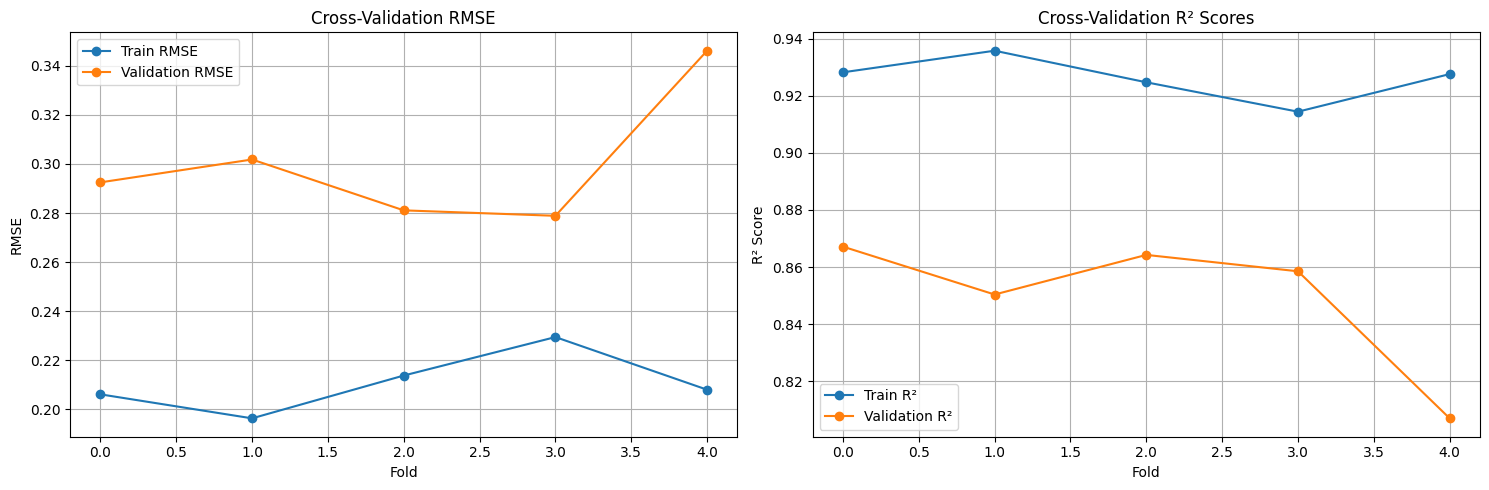


=== Cross-Validation Results ===
Average Train RMSE: 0.2107 (±0.0109)
Average Validation RMSE: 0.3001 (±0.0245)
Average Train R²: 0.9261 (±0.0069)
Average Validation R²: 0.8495 (±0.0220)

Training final model with 170 rounds...

Plotting learning curves...


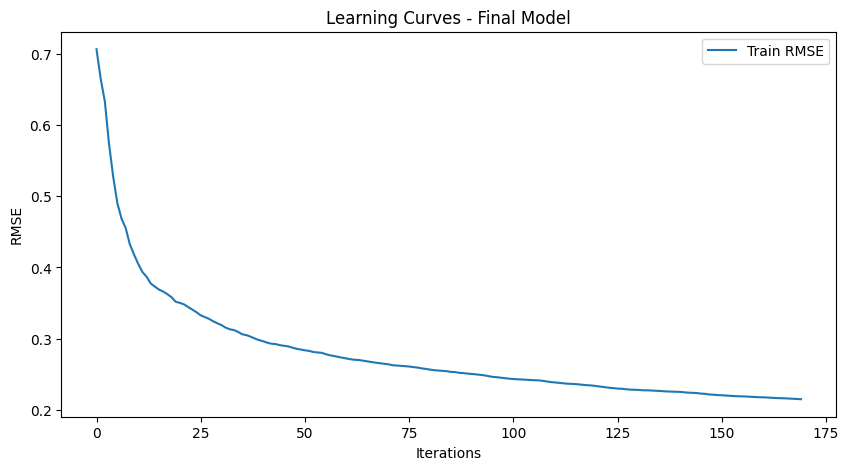


Evaluating final model...

=== Final Test Metrics ===
RMSE: 0.2878
R²: 0.8583
MAE: 0.1928

Plotting final model performance...


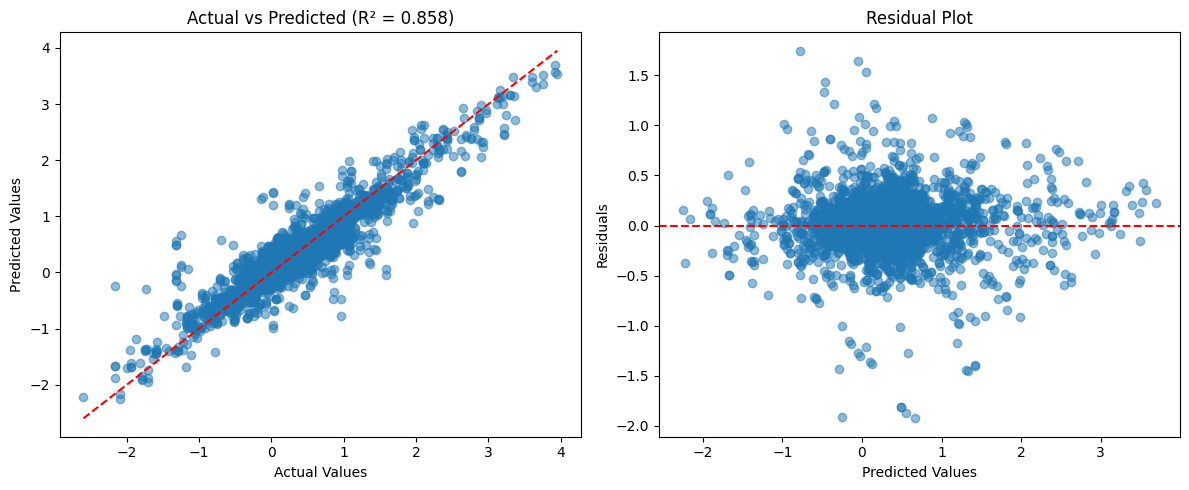


Analyzing LUtype feature importance...


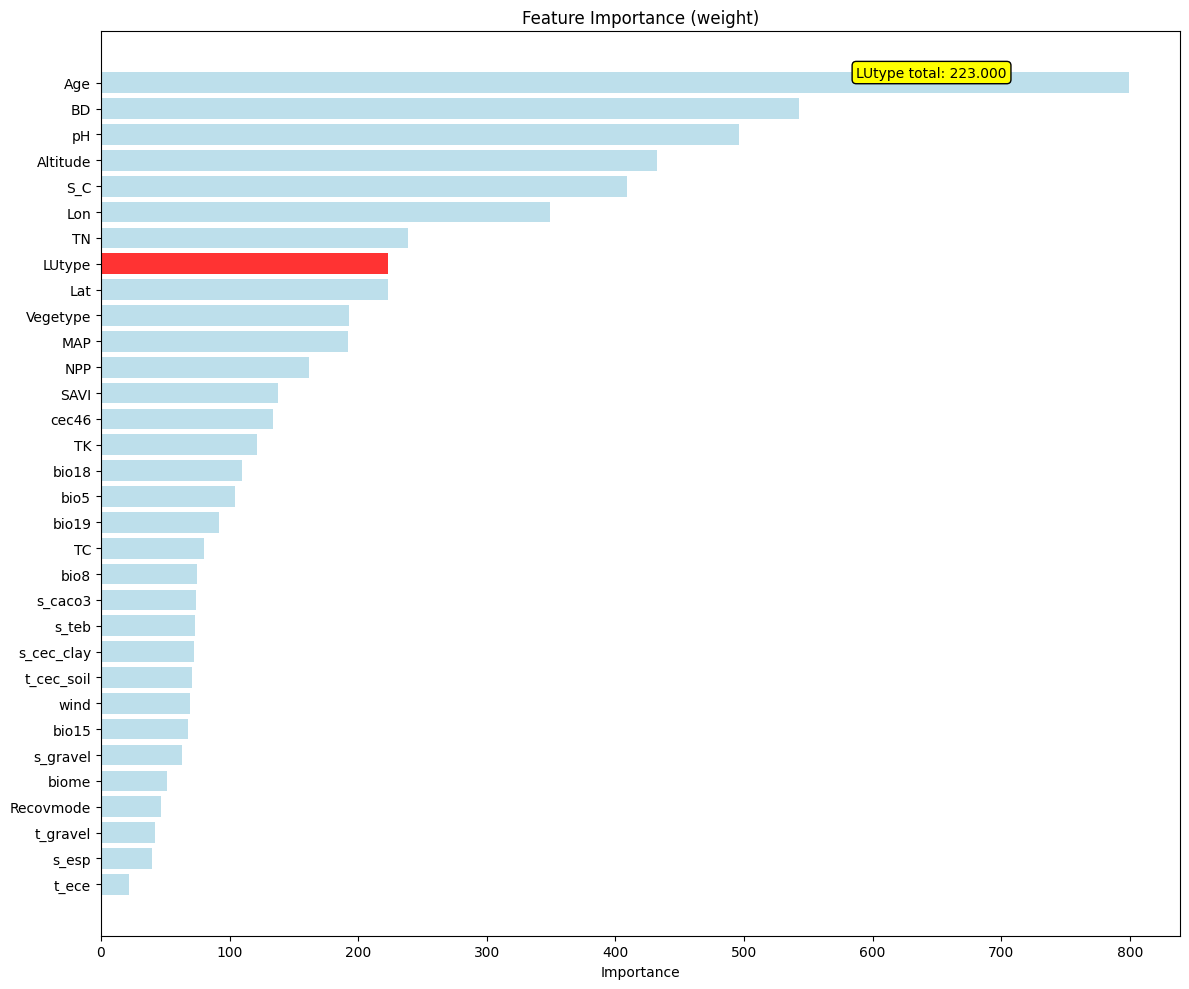


=== LUtype Feature Importance Analysis ===
Total LUtype-related features: 1
Total importance of LUtype features: 223.000
Average importance of LUtype features: 223.000

LUtype importance percentage: 3.84%

Top LUtype-related features:
  LUtype: 223.0000

Saving results...

最终诊断报告
✅ 模型训练完成
✅ 最终测试RMSE: 0.2878
✅ 最终测试R²: 0.8583
✅ 特征数量: 32
✅ 最佳迭代轮数: 170
✅ 特征一致性: 通过

=== 特征处理策略 ===
✓ 分类特征处理: LUtype、Vegetype、Recovmode作为pandas.Categorical
✓ 无交互特征: 已取消所有交互特征的创建
✓ 无频率权重: 已移除所有频率权重相关代码
✓ XGBoost分类支持: 启用enable_categorical=True

Done!


In [106]:
# SOC model LUtype - 只保留分类变量，无交互特征表现不错
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import joblib
import os
import re
from pathlib import Path
import warnings
import builtins
open = builtins.open

warnings.filterwarnings('ignore')

# SHAP availability check
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else None
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names
        
        # 设置所有随机种子以确保可重复性
        self._set_random_seeds()

    def _set_random_seeds(self):
        """设置所有随机种子"""
        import random
        random.seed(self.seed)
        np.random.seed(self.seed)
        if hasattr(os, 'environ'):
            os.environ['PYTHONHASHSEED'] = str(self.seed)

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            # Remove any non-numeric characters except minus, decimal point
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """Objective function with categorical enabled"""
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'subsample': trial.suggest_float('subsample', 0.6, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 2, 10.0),
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0, 0.2),
            'max_delta_step': trial.suggest_int('max_delta_step', 0, 3),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1,
            # enable categorical support
            'enable_categorical': True
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=10,
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )

        return cv_results['test-rmse-mean'].iloc[-1]

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """Parallelized hyperparameter tuning"""
        print("=== 超参数调优诊断 ===")
        
        study = optuna.create_study(direction='minimize')

        # 使用partial函数传递额外的参数
        from functools import partial
        objective_with_boost = partial(self.objective, dtrain=dtrain)

        # We'll run study.optimize in threads but each optimize runs a number of trials.
        # Keep inner n_jobs=1 to avoid optuna nesting issues
        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(lambda: study.optimize(
                objective_with_boost,
                n_trials=max(1, int(n_trials / max(1, self.n_jobs))),
                n_jobs=1
            )) for _ in range(max(1, self.n_jobs))]

            for future in futures:
                future.result()

        self.study = study
        self.best_params = study.best_params.copy()
        # ensure categorical enabled and stable defaults
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs,
            'enable_categorical': True
        })

        # 诊断信息
        print(f"最佳参数: {self.best_params}")
        print(f"最佳分数: {study.best_value:.4f}")
        
        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """Optimized training"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=10,
            verbose_eval=False,
            evals_result=evals_result
        )

        # Store feature names from DMatrix
        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models'):
        """Optimized CV"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            # Keep pandas DataFrame with categorical dtype intact and enable categorical support
            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist(), enable_categorical=True)
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist(), enable_categorical=True)

            model, _ = self.train_model(params, dtrain, dval)

            # Save the CV model
            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration if hasattr(model, 'best_iteration') else num_boost_round,
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(
                    process_fold, fold_idx, train_idx, val_idx
                ))

            for future in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = future.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """Evaluate model performance on test set"""
        test_pred = model.predict(dtest)
        return {
            'rmse': np.sqrt(mean_squared_error(dtest.get_label(), test_pred)),
            'r2': r2_score(dtest.get_label(), test_pred),
            'mae': mean_absolute_error(dtest.get_label(), test_pred)
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix):
        """Plot training and validation metrics"""
        plt.figure(figsize=(10, 5))
        epochs = len(evals_result['train']['rmse'])
        plt.plot(range(epochs), evals_result['train']['rmse'], label='Train RMSE')
        if 'valid' in evals_result:
            plt.plot(range(epochs), evals_result['valid']['rmse'], label='Validation RMSE')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title_suffix}')
        plt.show()

    def plot_cv_results(self, cv_results):
        """Plot cross-validation results including loss curves and R2 scores"""
        plt.figure(figsize=(15, 5))

        # Plot RMSE
        plt.subplot(1, 2, 1)
        plt.plot(cv_results['train_rmse'], 'o-', label='Train RMSE')
        plt.plot(cv_results['val_rmse'], 'o-', label='Validation RMSE')
        plt.xlabel('Fold')
        plt.ylabel('RMSE')
        plt.title('Cross-Validation RMSE')
        plt.legend()
        plt.grid(True)

        # Plot R2
        plt.subplot(1, 2, 2)
        plt.plot(cv_results['train_r2'], 'o-', label='Train R²')
        plt.plot(cv_results['val_r2'], 'o-', label='Validation R²')
        plt.xlabel('Fold')
        plt.ylabel('R² Score')
        plt.title('Cross-Validation R² Scores')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_final_model_performance(self, model, dtest):
        """Plot actual vs predicted values for test set"""
        test_metrics, test_pred = self.evaluate_model(model, dtest)
        y_test = dtest.get_label()

        plt.figure(figsize=(12, 5))

        # Scatter plot of actual vs predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, test_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})')

        # Residual plot
        plt.subplot(1, 2, 2)
        residuals = y_test - test_pred
        plt.scatter(test_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model, importance_type='weight', top_n=30, 
                               highlight_features=None):
        """Plot feature importance with highlighted features"""
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # 获取特征重要性
        importance_dict = model.get_score(importance_type=importance_type)
        
        if not importance_dict:
            print("No feature importance data available.")
            return None
            
        # 转换为DataFrame以便排序
        importance_df = pd.DataFrame({
            'feature': list(importance_dict.keys()),
            'importance': list(importance_dict.values())
        }).sort_values('importance', ascending=True)
        
        # 只显示top_n特征
        if len(importance_df) > top_n:
            importance_df = importance_df.tail(top_n)
        
        # 绘制水平条形图
        y_pos = np.arange(len(importance_df))
        colors = ['lightblue'] * len(importance_df)
        
        # 高亮特定特征
        if highlight_features:
            for i, feature in enumerate(importance_df['feature']):
                if any(hl_feature in feature for hl_feature in highlight_features):
                    colors[i] = 'red'
        
        ax.barh(y_pos, importance_df['importance'], color=colors, alpha=0.8)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(importance_df['feature'])
        ax.set_xlabel('Importance')
        
        title = f'Feature Importance ({importance_type})'
        ax.set_title(title)
        
        # 添加LUtype重要性说明
        lu_type_features = importance_df[importance_df['feature'].str.contains('LUtype', na=False)]
        lu_type_importance = lu_type_features['importance'].sum() if not lu_type_features.empty else 0
        
        ax.text(0.7, 0.95, f'LUtype total: {lu_type_importance:.3f}', 
                transform=ax.transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))
        
        plt.tight_layout()
        plt.show()
        
        return importance_df

    def analyze_lutype_importance(self, model, X):
        """Analyze LUtype importance"""
        importance_dict = model.get_score(importance_type='weight')
        
        if not importance_dict:
            print("No feature importance data available.")
            return
        
        # 分类统计不同特征
        lutype_features = {k: v for k, v in importance_dict.items() if 'LUtype' in k}
        other_features = {k: v for k, v in importance_dict.items() if 'LUtype' not in k}
        
        print(f"\n=== LUtype Feature Importance Analysis ===")
        print(f"Total LUtype-related features: {len(lutype_features)}")
        print(f"Total importance of LUtype features: {sum(lutype_features.values()):.3f}")
        print(f"Average importance of LUtype features: {np.mean(list(lutype_features.values())) if lutype_features else 0:.3f}")
        
        total_importance = sum(importance_dict.values())
        lu_type_percentage = (sum(lutype_features.values()) / total_importance * 100) if total_importance > 0 else 0
        
        print(f"\nLUtype importance percentage: {lu_type_percentage:.2f}%")
        
        # 打印最重要的LUtype特征（如有）
        if lutype_features:
            sorted_lutype = sorted(lutype_features.items(), key=lambda x: x[1], reverse=True)
            print(f"\nTop LUtype-related features:")
            for feature, importance in sorted_lutype[:10]:
                print(f"  {feature}: {importance:.4f}")
        else:
            print("\nNo LUtype-related features found in importance scores.")

    def plot_shap_summary(self, model, X, feature_names=None):
        """Generate SHAP summary plot if SHAP is available"""
        if SHAP_AVAILABLE:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X, feature_names=feature_names)
            plt.tight_layout()
            plt.show()
        else:
            print("SHAP not available. Install with: pip install shap")

    def save_results(self, model, output_dir='results'):
        """Save all results to disk including feature names"""
        Path(output_dir).mkdir(exist_ok=True)

        # Save model
        model.save_model(f'{output_dir}/xgb_model.json')

        # Save feature names
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))

        # Save other artifacts
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')

        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)

    # ========== 新增诊断功能 ==========
    
    def diagnose_training_stability(self, params, X_train, y_train, n_runs=3):
        """诊断训练过程的稳定性"""
        print("\n" + "="*50)
        print("训练稳定性诊断")
        print("="*50)
        
        all_metrics = []
        
        for i in range(n_runs):
            print(f"\n--- 稳定性测试 {i+1}/{n_runs} ---")
            
            # 训练模型，启用分类支持
            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist(), enable_categorical=True)
            model, evals_result = self.train_model(params, dtrain)
            
            # 评估
            train_pred = model.predict(dtrain)
            train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
            train_r2 = r2_score(y_train, train_pred)
            
            all_metrics.append({
                'run': i+1,
                'train_rmse': train_rmse,
                'train_r2': train_r2,
                'best_iteration': model.best_iteration if hasattr(model, 'best_iteration') else len(evals_result['train']['rmse'])
            })
            
            print(f"  训练RMSE: {train_rmse:.4f}")
            print(f"  训练R²: {train_r2:.4f}")
        
        # 分析稳定性
        rmse_std = np.std([m['train_rmse'] for m in all_metrics])
        r2_std = np.std([m['train_r2'] for m in all_metrics])
        
        print(f"\n稳定性分析:")
        print(f"  RMSE标准差: {rmse_std:.4f} ({'稳定' if rmse_std < 0.01 else '不稳定'})")
        print(f"  R²标准差: {r2_std:.4f} ({'稳定' if r2_std < 0.01 else '不稳定'})")
        
        return all_metrics

    def validate_feature_consistency(self, X_train, expected_features=None):
        """验证特征一致性"""
        print("\n" + "="*50)
        print("特征一致性验证")
        print("="*50)
        
        actual_features = len(X_train.columns)
        
        if expected_features:
            print(f"期望特征数: {expected_features}")
            print(f"实际特征数: {actual_features}")
            
            if actual_features != expected_features:
                print(f"❌ 特征数量不匹配! 差值为: {actual_features - expected_features}")
            else:
                print("✅ 特征数量一致")
        else:
            print(f"实际特征数: {actual_features}")
            print("⚠️ 未设置期望特征数，跳过一致性检查")
        
        print("实际特征列表:")
        for i, feature in enumerate(X_train.columns):
            print(f"  {i+1:2d}. {feature}")
            
        # 检查LUtype相关特征
        lu_features = [col for col in X_train.columns if 'LUtype' in col]
        
        print(f"\nLUtype相关特征: {len(lu_features)}")
        
        return not expected_features or actual_features == expected_features

def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
    """Augment continuous features with noise"""
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()

        for col in continuous_cols:
            if col not in X.columns:
                continue
            std = X[col].std()
            if pd.isna(std) or std == 0:
                noise = 0.0
            else:
                noise = np.random.normal(loc=0, scale=std * noise_scale)
            # 保证不要改变 categorical dtype 列
            if pd.api.types.is_categorical_dtype(X[col]) or X[col].dtype == object:
                # 不对分类列添加噪声
                pass
            else:
                if X[col].min() >= 0:
                    base_sample[col] = max(0, base_sample[col] + noise)
                else:
                    base_sample[col] += noise

        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        
        y_augmented = y_augmented._append(
            pd.Series(y.iloc[idx], index=[len(y_augmented)]),  
            ignore_index=True
        )

    # 保持列的 dtype（尤其是 category）
    for col in X.columns:
        if pd.api.types.is_categorical_dtype(X[col]):
            X_augmented[col] = X_augmented[col].astype('category')

    return X_augmented, y_augmented

def load_and_prepare_data(augment=True, augmentation_factor=2):
    """Modified data loading function - 只保留原始特征，无交互特征"""
    dtype_dict = {
        'Soillayer': 'int8',
        'yi': 'float32'
    }

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    X = df_clean.drop('yi', axis=1)
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        if col in X.columns:
            X[col + '_log'] = np.log(X[col] + 1e-8)
    if 'Altitude' in X.columns:
        X['Altitude_bins'] = pd.cut(X['Altitude'], bins=5, labels=False)
    df_clean = pd.concat([df_clean['yi'], X], axis=1)

    target_layer = "topsoil"###################################################################################SELCET LAYER
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    x1 = df[valid_x_cols].astype('float32', copy=False).fillna(0)
    y1 = df['yi'].astype('float32')

    # 将 LUtype、Vegetype、Recovmode 转换为 pandas.Categorical
    categorical_columns = ['LUtype', 'Vegetype', 'Recovmode']
    
    for col in categorical_columns:
        if col in x1.columns:
            try:
                x1[col] = pd.Categorical(x1[col].astype('Int64').astype('category'))
            except Exception:
                # 兜底：直接转 category
                x1[col] = x1[col].astype('category')

            print(f"\nOriginal {col} distribution:")
            print(x1[col].value_counts().sort_index())

    # 注意：不再创建任何交互特征
    print("🔧 已取消所有交互特征的创建，只保留原始特征")

    # 数据增强（只对连续变量添加噪声，不影响 categorical 列）
    if augment:
        continuous_cols = [
            'Lon', 'Lat', 'Age', 'BD', 'pH', 'S_C',
            'Lon_log', 'Lat_log', 'Age_log', 'BD_log', 'pH_log',
            'Altitude'
        ]
        continuous_cols = [col for col in continuous_cols if col in x1.columns]
        
        print(f"\nAugmenting data with factor: {augmentation_factor}")
        x1, y1 = augment_continuous_features(
            X=x1,
            y=y1,
            continuous_cols=continuous_cols,
            augmentation_factor=augmentation_factor,
            noise_scale=0.01,  
            random_state=42
        )
    else:
        x1, y1 = x1, y1

    # Ensure categorical dtypes preserved after augmentation and before split
    categorical_columns = ['LUtype', 'Vegetype', 'Recovmode']
    for col in categorical_columns:
        if col in x1.columns and not pd.api.types.is_categorical_dtype(x1[col]):
            x1[col] = x1[col].astype('category')

    X_train, X_test, y_train, y_test = train_test_split(
        x1, y1, test_size=0.3, random_state=42
    )
    print(f"\nTraining set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    print(f"Total features: {len(X_train.columns)}")
    
    # 统计特征分布
    lu_type_cols = [col for col in X_train.columns if 'LUtype' in col]
    vegetype_cols = [col for col in X_train.columns if 'Vegetype' in col]
    recovmode_cols = [col for col in X_train.columns if 'Recovmode' in col]
    
    print(f"LUtype-related features: {len(lu_type_cols)}")
    print(f"Vegetype-related features: {len(vegetype_cols)}")
    print(f"Recovmode-related features: {len(recovmode_cols)}")

    # Create DMatrix from pandas DataFrame, preserving categorical dtypes with enable_categorical=True
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist(), enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist(), enable_categorical=True)

    return dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train

def main():
    """Main function - 只保留原始特征，无交互特征"""
    print("=== XGBoost模型训练与诊断（无交互特征） ===")
    
    # 使用只包含原始特征的处理
    dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train = load_and_prepare_data(
        augment=True,
        augmentation_factor=3
    )

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 0. 运行诊断
    print("\n运行预训练诊断...")
    feature_consistent = tuner.validate_feature_consistency(X_train)  # 不传递期望特征数
    
    if not feature_consistent:
        print("⚠️ 特征数量不一致，但继续训练...")

    # 1. Hyperparameter tuning
    print("\nStarting optimized hyperparameter tuning...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)
    print(f"Best parameters: {best_params}")

    # 2. 训练稳定性诊断
    stability_results = tuner.diagnose_training_stability(best_params, X_train, y_train, n_runs=3)

    # 3. Cross-validation with model saving
    print("\nRunning optimized cross-validation...")
    cv_results = tuner.cross_validate(best_params, X_train, y_train, n_splits=5,
                                      cv_models_dir='F:/model/results/cv_models')
    
    print("\nSaved CV models at:")
    for path in cv_results['model_paths']:
        print(f"- {path}")
    
    # Plot CV results
    print("\nPlotting cross-validation results...")
    tuner.plot_cv_results(cv_results)

    # Print CV results
    print("\n=== Cross-Validation Results ===")
    print(f"Average Train RMSE: {np.mean(cv_results['train_rmse']):.4f} (±{np.std(cv_results['train_rmse']):.4f})")
    print(f"Average Validation RMSE: {np.mean(cv_results['val_rmse']):.4f} (±{np.std(cv_results['val_rmse']):.4f})")
    print(f"Average Train R²: {np.mean(cv_results['train_r2']):.4f} (±{np.std(cv_results['train_r2']):.4f})")
    print(f"Average Validation R²: {np.mean(cv_results['val_r2']):.4f} (±{np.std(cv_results['val_r2']):.4f})")

    # 4. Train final model
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final model with {optimal_rounds} rounds...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)

    # Plot learning curves
    print("\nPlotting learning curves...")
    tuner.plot_learning_curves(evals_result, "Final Model")

    # 5. Evaluate and plot final performance
    print("\nEvaluating final model...")
    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")

    print("\nPlotting final model performance...")
    tuner.plot_final_model_performance(final_model, dtest)

    # 6. 分析 LUtype 重要性
    print(f"\nAnalyzing LUtype feature importance...")
    importance_df = tuner.plot_feature_importance(final_model, top_n=35, 
                                                 highlight_features=['LUtype'])
    
    # 详细分析 LUtype 重要性
    tuner.analyze_lutype_importance(final_model, X_test)
    
    # 7. SHAP分析
    if SHAP_AVAILABLE:
        print("\nGenerating SHAP summary plot...")
        tuner.plot_shap_summary(final_model, X_test)
    
    # 8. 保存结果
    print("\nSaving results...")
    tuner.save_results(final_model, 'F:/model/results')
    
    # 9. 最终诊断报告
    print("\n" + "="*50)
    print("最终诊断报告")
    print("="*50)
    print(f"✅ 模型训练完成")
    print(f"✅ 最终测试RMSE: {test_metrics['rmse']:.4f}")
    print(f"✅ 最终测试R²: {test_metrics['r2']:.4f}")
    print(f"✅ 特征数量: {len(X_train.columns)}")
    print(f"✅ 最佳迭代轮数: {optimal_rounds}")
    
    if feature_consistent:
        print("✅ 特征一致性: 通过")
    else:
        print("⚠️ 特征一致性: 警告 - 特征数量不匹配")
    
    print(f"\n=== 特征处理策略 ===")
    print("✓ 分类特征处理: LUtype、Vegetype、Recovmode作为pandas.Categorical")
    print("✓ 无交互特征: 已取消所有交互特征的创建")
    print("✓ 无频率权重: 已移除所有频率权重相关代码")
    print("✓ XGBoost分类支持: 启用enable_categorical=True")
    
    print("\nDone!")

if __name__ == "__main__":
    main()

In [112]:
# SOC mapping with LUtype mapping only specific area - 修正版本，与训练代码特征一致
import os
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb
from concurrent.futures import ThreadPoolExecutor

# ===================== Configuration =====================
MODEL_PATH = 'F:/model/results/xgb_model.json'
# 假设这个文件包含了所有训练时使用的特征名称（包括 log 转换和 Altitude_bins）
FEATURE_NAMES_PATH = 'F:/model/results/feature_names.txt' 
INPUT_TIF_FOLDER = 'E:/extreme_climate/input_current/input09051'

timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/Mapping_active_topsoil_{timestamp}_NoInteraction.tif'

TARGET_CARBON = "SOC"
TARGET_LAYER = "topsoil"
N_JOBS = 17 # 与训练代码一致
CHUNK_SIZE = 100000 # 增大分块以提高效率
# ======================================================

def load_model_feature_names(path):
    """Load feature names used during model training."""
    try:
        with open(path, 'r') as f:
            return [line.strip() for line in f.readlines() if line.strip()]
    except FileNotFoundError:
        print(f"❌ Warning: Feature names file not found at {path}. Proceeding with dynamic feature detection.")
        return None

def get_input_files(tif_folder):
    """Get the list of input TIF files."""
    tif_files = [os.path.join(tif_folder, f) for f in os.listdir(tif_folder) if f.endswith('.tif')]
    if not tif_files:
        raise FileNotFoundError(f"❌ No TIF files found in {tif_folder}")
    return tif_files

def create_dynamic_features(chunk_data, model_feature_names):
    """
    Dynamically create required features, strictly matching the non-interaction training features.
    Handles data cleaning, log transformation, binning, and categorical dtype conversion.
    """
    
    # 1. 基础特征名映射
    base_mapping = {
        'Landuse_type': 'LUtype',
        'LU_type': 'LUtype',
        'LU-type': 'LUtype',
        'Recovery_mode': 'Recovmode',
        't_bd': 'BD',
        't_ph': 'pH',
        't_sand': 'S_C',
        't_oc': 'TC',
        'TN13': 'TN',
        'TK13': 'TK',
        'Vege_type': 'Vegetype',
        'Altitude_bins': 'Altitude_bins' # Altitude_bins 可能会被视为单独的特征
    }

    # 重命名列
    for csv_feat, model_feat in base_mapping.items():
        if csv_feat in chunk_data.columns and model_feat not in chunk_data.columns:
            chunk_data[model_feat] = chunk_data[csv_feat]
            # 删除原始列以避免混淆
            # chunk_data = chunk_data.drop(columns=[csv_feat])

    # 2. 清理和转换数据类型
    # 必须保证所有列都是数值型或 Categorical 才能使用 enable_categorical=True
    
    # 数值列 (连续和离散)
    numeric_cols = [
        'Lon', 'Lat', 'Age', 'BD', 'pH', 'S_C', 'TC', 'TN', 'TK', 'Altitude'
    ]
    
    for col in numeric_cols:
        if col in chunk_data.columns:
            chunk_data[col] = pd.to_numeric(chunk_data[col], errors='coerce').fillna(0).astype('float32') 
            # 填充0是临时措施，真正的缺失行将在后面通过 mask 处理

    # 3. 严格按照训练代码进行特征工程
    
    # Log 转换 (与训练代码一致)
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        if col in chunk_data.columns and f'{col}_log' in model_feature_names:
            # 训练代码中使用了 np.log(X[col] + 1e-8)
            chunk_data[col + '_log'] = np.log(chunk_data[col].clip(lower=0) + 1e-8)
            
    # Altitude 分箱 (与训练代码一致)
    if 'Altitude' in chunk_data.columns and 'Altitude_bins' in model_feature_names:
        # **注意**: 预测时需要使用训练时确定的分界点，但由于这里无法获取训练时的 bins，
        # 我们只能使用与训练代码中相同的**等宽分箱**策略进行近似。
        # ⚠️ 严格来说，这可能导致特征不一致。
        # 最佳实践是保存训练时的 `pd.cut` 的 bin 边界。
        # 假设 Altitude 范围稳定，进行等宽分箱:
        try:
            # 尝试使用 训练数据 的 min/max/bins
            # 实际上应该加载训练数据中 Altitude 的 min/max
            # 这里先用当前数据的 min/max
            min_alt, max_alt = chunk_data['Altitude'].min(), chunk_data['Altitude'].max()
            if max_alt > min_alt:
                chunk_data['Altitude_bins'] = pd.cut(
                    chunk_data['Altitude'], bins=5, labels=False, include_lowest=True
                ).fillna(-1).astype('Int64') # 缺失值用 -1 表示
            else:
                 chunk_data['Altitude_bins'] = 0
        except:
             chunk_data['Altitude_bins'] = 0


    # 4. 分类特征转换 (与训练代码一致)
    categorical_columns = ['LUtype', 'Vegetype', 'Recovmode']
    
    for col in categorical_columns:
        if col in chunk_data.columns:
            # 确保分类列是 Int64 或能够转换为 Int64，然后转换为 Category
            # LUtype/Vegetype/Recovmode 预期为整数类别
            try:
                # 尝试转换为 Int64 再转 category
                chunk_data[col] = pd.Categorical(chunk_data[col].astype('Int64').astype('category'))
            except Exception:
                # 兜底：直接转 category
                chunk_data[col] = chunk_data[col].astype('category')
        else:
            # 如果模型需要这个分类特征但数据中缺失，创建一列全为 NaN 的 category 列
            if col in model_feature_names:
                print(f"   ⚠️ Categorical feature {col} missing in input. Filling with NaN category.")
                chunk_data[col] = pd.Categorical([np.nan] * len(chunk_data), categories=chunk_data[col].dtype.categories)


    # 5. 严格筛选模型需要的特征
    # 移除训练中未使用的交互特征（确保没有 LUtype_X_interaction, LUtype_X, One-Hot 特征）
    # 训练代码中明确排除了所有交互特征，因此此处也必须排除。
    
    if model_feature_names:
        final_features = [col for col in model_feature_names if col in chunk_data.columns]
        chunk_data = chunk_data[final_features]

        # 检查是否所有特征都存在
        missing_features = set(model_feature_names) - set(chunk_data.columns)
        if missing_features:
            print(f"   ❌ WARNING: Missing features required by model: {missing_features}. Filling with 0/NaN.")
            for mf in missing_features:
                if mf in categorical_columns:
                     # 填充一个不存在的类别或 nan category
                    chunk_data[mf] = pd.Categorical([np.nan] * len(chunk_data), categories=['unknown'])
                else:
                    # 填充 0 (数值特征)
                    chunk_data[mf] = 0.0

    return chunk_data.copy()

def predict_chunk(chunk_df, model, nodata_mask, model_feature_names):
    """Predict on a single chunk of data."""
    
    # 1. 确保特征与训练时一致
    chunk_df_processed = create_dynamic_features(chunk_df.copy(), model_feature_names)
    
    # 2. 预测掩码: 跳过 NoData 行
    predict_mask = ~nodata_mask
    if not np.any(predict_mask):
        print("   ⚠️ All pixels are NoData/NaN, returning NaN array.")
        return np.full(len(chunk_df), np.nan, dtype=np.float32)

    # 3. 准备 DMatrix
    X_predict = chunk_df_processed[predict_mask].reset_index(drop=True)

    # 4. 确保特征顺序和数量匹配
    if model_feature_names:
        X_predict = X_predict[model_feature_names]
        
    # ⚠️ 强制转换回 Categorical dtype 以适应 xgb.DMatrix
    categorical_cols = ['LUtype', 'Vegetype', 'Recovmode', 'Altitude_bins'] # 假设 Altitude_bins 也是分类
    for col in categorical_cols:
        if col in X_predict.columns and not pd.api.types.is_categorical_dtype(X_predict[col]):
            X_predict[col] = X_predict[col].astype('category')


    dpredict = xgb.DMatrix(
        X_predict, 
        feature_names=model_feature_names, 
        enable_categorical=True
    )
    
    # 5. 预测
    try:
        chunk_pred = model.predict(dpredict, nthread=1) # Use nthread=1 for safe parallel execution
    except xgb.core.XGBoostError as e:
        print(f"   ❌ XGBoost Prediction Error: {e}")
        chunk_pred = np.full(len(X_predict), np.nan, dtype=np.float32)

    # 6. 组合结果
    full_prediction = np.full(len(chunk_df), np.nan, dtype=np.float32)
    full_prediction[predict_mask] = chunk_pred
    
    return full_prediction

def main_mapping():
    print(f"=== {TARGET_CARBON} Mapping (No Interaction Features) ===")
    
    # 1. 加载模型
    try:
        model = xgb.Booster()
        model.load_model(MODEL_PATH)
        print(f"✅ Model loaded from: {MODEL_PATH}")
    except xgb.core.XGBoostError as e:
        print(f"❌ Failed to load XGBoost model: {e}")
        return
    
    # 2. 加载训练时的特征名称列表
    model_feature_names = load_model_feature_names(FEATURE_NAMES_PATH)
    if model_feature_names:
        print(f"✅ Loaded {len(model_feature_names)} model feature names.")
        # 设置模型内部的特征名称，以防预测特征顺序出错
        model.feature_names = model_feature_names
    else:
        print("⚠️ Model feature names not explicitly loaded. Proceeding with caution.")
        # 尝试从模型中获取特征名称，但可能不完整
        model_feature_names = model.feature_names
    
    # 3. 加载输入 TIF 文件
    tif_files = get_input_files(INPUT_TIF_FOLDER)
    print(f"✅ Found {len(tif_files)} input TIF files in {INPUT_TIF_FOLDER}")
    
    # 4. 读取所有 TIF 文件的元数据和数据
    input_xr = xr.open_mfdataset(tif_files, combine='by_coords', parallel=True)

    # 5. 确保数据的坐标和投影正确
    if 'spatial_ref' in input_xr.coords:
        crs = input_xr['spatial_ref'].attrs['crs_wkt']
    elif hasattr(input_xr, 'rio'):
        crs = input_xr.rio.crs
    else:
        crs = None
    
    # 6. 将 xarray 转换为 DataFrame
    df = input_xr.to_dataframe().reset_index()
    
    # 7. 提取坐标和预测数据，并处理 NoData
    lon_lat = df[['x', 'y']].copy()
    
    # 创建一个整体的 NoData 掩码: 只要任一列是 NaN/NoData，就认为是 NoData 像素
    # 忽略 Lon/Lat 列，因为它们是坐标
    feature_cols = [col for col in df.columns if col not in ['x', 'y']]
    
    # 创建 NoData 掩码: 只要任一关键特征为 NaN，该像素就视为 NoData
    nodata_mask_rows = df[feature_cols].isnull().any(axis=1)
    
    # 8. 分块预测
    all_predictions = np.full(len(df), np.nan, dtype=np.float32)
    chunks = np.array_split(df, max(1, len(df) // CHUNK_SIZE))
    nodata_mask_chunks = np.array_split(nodata_mask_rows, max(1, len(df) // CHUNK_SIZE))
    
    print(f"   ⚙️ Starting prediction in {len(chunks)} chunks...")

    # 使用多线程加速
    with ThreadPoolExecutor(max_workers=N_JOBS) as executor:
        futures = []
        for i, (chunk, nodata_mask) in enumerate(zip(chunks, nodata_mask_chunks)):
            print(f"   ➡️ Submitting chunk {i+1}/{len(chunks)}...")
            # 传递原始 chunk，predict_chunk 内部会处理特征工程和 NoData 掩码
            futures.append(executor.submit(
                predict_chunk, 
                chunk.drop(columns=['x', 'y']), # 只需要特征列
                model, 
                nodata_mask, 
                model_feature_names
            ))
        
        # 收集结果
        start_idx = 0
        for i, future in enumerate(futures):
            chunk_result = future.result()
            end_idx = start_idx + len(chunk_result)
            all_predictions[start_idx:end_idx] = chunk_result
            start_idx = end_idx
            print(f"   ✅ Chunk {i+1}/{len(chunks)} finished.")
    
    # 9. 重新构建 GeoTIFF
    df_result = pd.DataFrame({
        'x': lon_lat['x'], 
        'y': lon_lat['y'], 
        TARGET_CARBON: all_predictions
    })
    
    # 将 DataFrame 转换回 xarray
    result_xr = df_result.set_index(['y', 'x']).to_xarray()
    
    # 10. 设置坐标系并保存
    if crs:
        result_xr[TARGET_CARBON] = result_xr[TARGET_CARBON].rio.write_crs(crs)
    
    # 设置 NoData 值为 NaN
    result_xr[TARGET_CARBON].rio.set_nodata(np.nan, inplace=True)

    result_xr[TARGET_CARBON].rio.to_raster(
        OUTPUT_TIF_PATH,
        compress='LZW',
        dtype=np.float32
    )

    print(f"\n✅ Mapping complete! Output saved to: {OUTPUT_TIF_PATH}")
    
    # 清理内存
    del df, input_xr, result_xr
    gc.collect()

if __name__ == "__main__":
    main_mapping()

=== SOC Mapping (No Interaction Features) ===
✅ Model loaded from: F:/model/results/xgb_model.json
✅ Loaded 32 model feature names.
✅ Found 131 input TIF files in E:/extreme_climate/input_current/input09051


MemoryError: Unable to allocate 11.6 GiB for an array with shape (2, 777600000) and data type float64

[I 2025-11-16 19:01:49,175] A new study created in memory with name: no-name-f2435a48-4ea2-4312-b9b9-68b1addc2870


=== XGBoost模型训练与诊断（无交互特征，无数据增强） ===

Original LUtype distribution:
LUtype
1    1079
2     408
3     331
4     179
5     240
6     182
7      39
Name: count, dtype: int64

Original Vegetype distribution:
Vegetype
1     397
2     407
3     108
4    1132
5     414
Name: count, dtype: int64

Original Recovmode distribution:
Recovmode
1     284
2    2174
Name: count, dtype: int64
🔧 已取消所有交互特征的创建，只保留原始特征
🔧 已取消所有数据增强，仅使用原始数据

Training set size: 1720
Test set size: 738
Total features: 32
LUtype-related features: 1
Vegetype-related features: 1
Recovmode-related features: 1

运行预训练诊断...

特征一致性验证
实际特征数: 32
⚠️ 未设置期望特征数，跳过一致性检查
实际特征列表:
   1. Lon
   2. Lat
   3. LUtype
   4. biome
   5. Age
   6. Recovmode
   7. MAP
   8. Altitude
   9. BD
  10. pH
  11. S_C
  12. Vegetype
  13. TC
  14. TN
  15. TK
  16. NPP
  17. cec46
  18. bio5
  19. bio8
  20. bio15
  21. bio18
  22. bio19
  23. wind
  24. SAVI
  25. s_caco3
  26. s_cec_clay
  27. s_esp
  28. s_gravel
  29. s_teb
  30. t_cec_soil
  31. t_ece
  32

[I 2025-11-16 19:01:51,928] Trial 15 finished with value: 0.44873743664997096 and parameters: {'eta': 0.28243213002151235, 'max_depth': 5, 'subsample': 0.6793601452812204, 'colsample_bytree': 0.8595401758206886, 'colsample_bylevel': 0.7194076031291896, 'min_child_weight': 4, 'lambda': 2.9067101586018715, 'alpha': 1.5462023583497295, 'gamma': 0.12161320788474315, 'max_delta_step': 1}. Best is trial 15 with value: 0.44873743664997096.
[I 2025-11-16 19:01:53,400] Trial 9 finished with value: 0.4485192229894081 and parameters: {'eta': 0.11800051328641682, 'max_depth': 4, 'subsample': 0.6991125718216491, 'colsample_bytree': 0.7017387396674137, 'colsample_bylevel': 0.8766001521651027, 'min_child_weight': 7, 'lambda': 9.9107650577902, 'alpha': 1.1339254622360218, 'gamma': 0.0842902634238919, 'max_delta_step': 2}. Best is trial 9 with value: 0.4485192229894081.
[I 2025-11-16 19:01:54,311] Trial 1 finished with value: 0.4384448517734308 and parameters: {'eta': 0.1252393096014618, 'max_depth': 5

最佳参数: {'eta': 0.08293292060904292, 'max_depth': 6, 'subsample': 0.6675982201383613, 'colsample_bytree': 0.8555726536575109, 'colsample_bylevel': 0.7734184851660327, 'min_child_weight': 6, 'lambda': 3.364160924465841, 'alpha': 1.1911912622831395, 'gamma': 0.0318952912458836, 'max_delta_step': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 42, 'nthread': 17, 'enable_categorical': True}
最佳分数: 0.4341
Best parameters: {'eta': 0.08293292060904292, 'max_depth': 6, 'subsample': 0.6675982201383613, 'colsample_bytree': 0.8555726536575109, 'colsample_bylevel': 0.7734184851660327, 'min_child_weight': 6, 'lambda': 3.364160924465841, 'alpha': 1.1911912622831395, 'gamma': 0.0318952912458836, 'max_delta_step': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 42, 'nthread': 17, 'enable_categorical': True}

训练稳定性诊断

--- 稳定性测试 1/3 ---
  训练RMSE: 0.2409
  训练R²: 0.9060

--- 稳定性测试 2/3 ---
  训练RMSE: 0.2409
  训练R²: 0.9060

--- 稳定性测试 3/3 ---
  训练RMSE: 0.2409
  训练R²: 0.9060


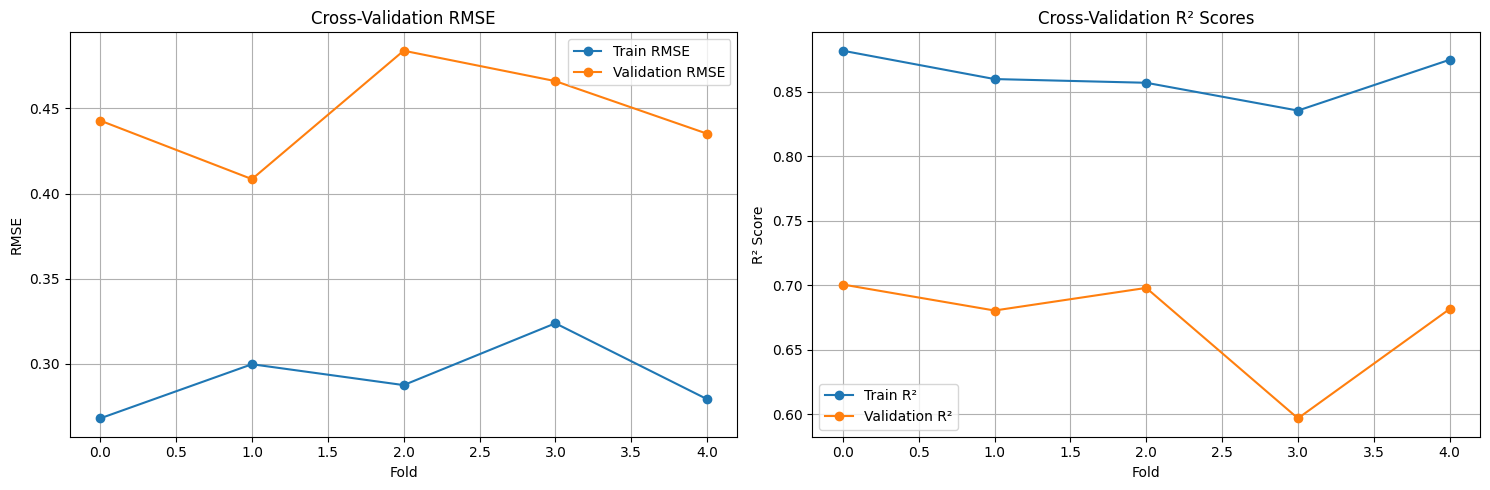


=== Cross-Validation Results ===
Average Train RMSE: 0.2916 (±0.0192)
Average Validation RMSE: 0.4473 (±0.0260)
Average Train R²: 0.8620 (±0.0161)
Average Validation R²: 0.6715 (±0.0382)

Training final model with 152 rounds...

Plotting learning curves...


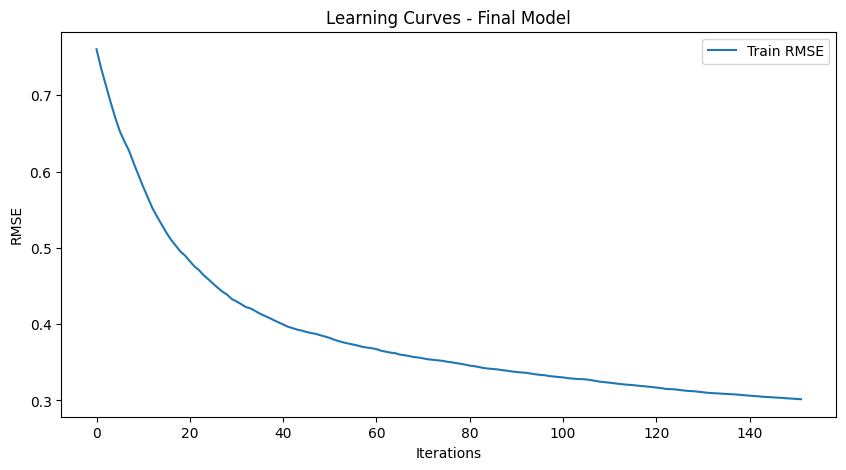


Evaluating final model...

=== Final Test Metrics ===
RMSE: 0.4048
R²: 0.7043
MAE: 0.2825

Plotting final model performance...


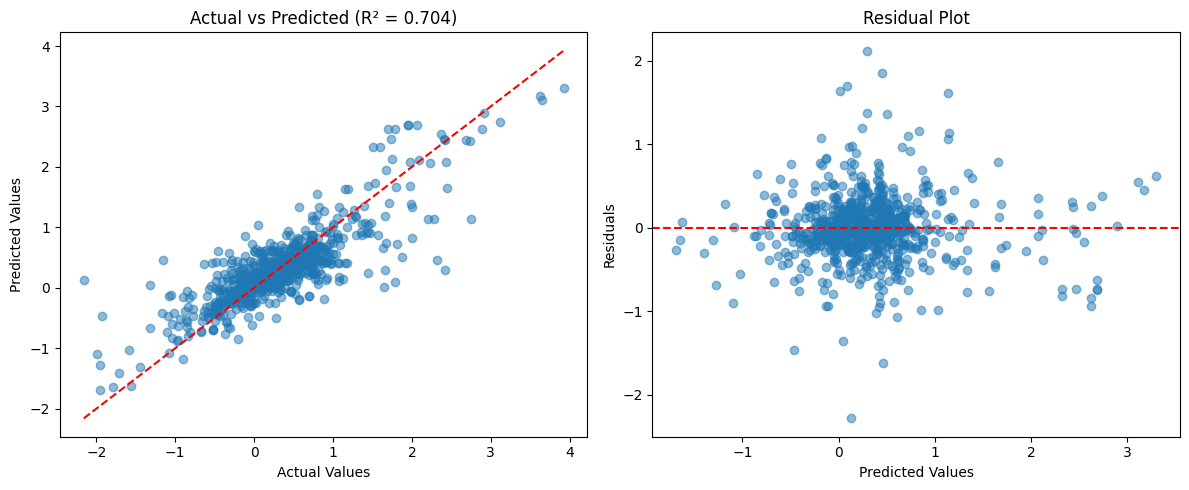


Analyzing LUtype feature importance...


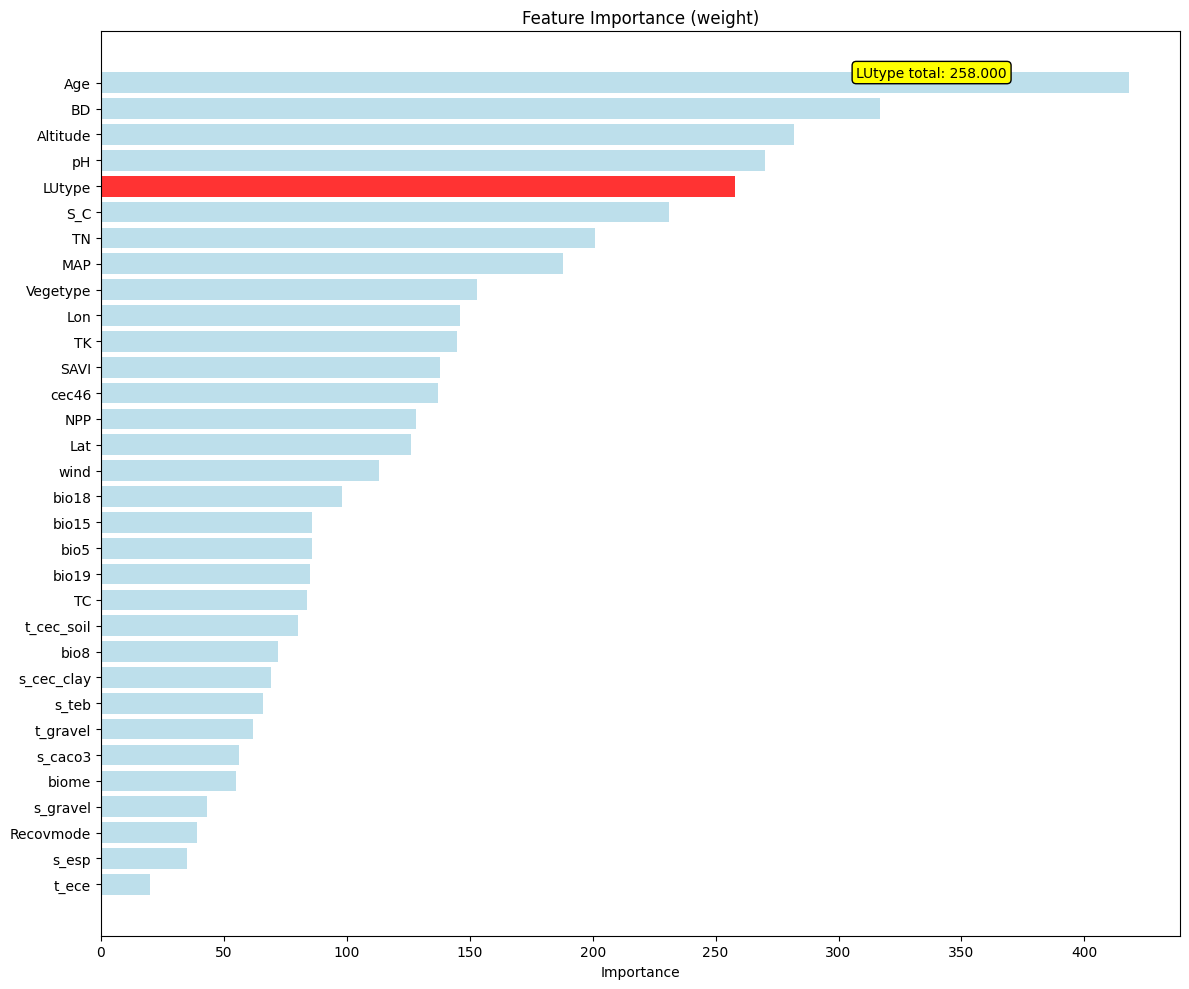


=== LUtype Feature Importance Analysis ===
Total LUtype-related features: 1
Total importance of LUtype features: 258.000
Average importance of LUtype features: 258.000

LUtype importance percentage: 6.02%

Top LUtype-related features:
  LUtype: 258.0000

Saving results...

最终诊断报告
✅ 模型训练完成
✅ 最终测试RMSE: 0.4048
✅ 最终测试R²: 0.7043
✅ 特征数量: 32
✅ 最佳迭代轮数: 152
✅ 特征一致性: 通过

=== 特征处理策略 ===
✓ 分类特征处理: LUtype、Vegetype、Recovmode作为pandas.Categorical
✓ 无交互特征: 已取消所有交互特征的创建
✓ 无数据增强: 已移除所有数据增强相关代码
✓ 保留Altitude分箱: 使用pd.cut进行分箱
✓ XGBoost分类支持: 启用enable_categorical=True

Done!


In [102]:
# SOC model LUtype - 完全移除数据增强
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import joblib
import os
import re
from pathlib import Path
import warnings
import builtins
open = builtins.open

warnings.filterwarnings('ignore')

# SHAP availability check
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else None
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names
        
        # 设置所有随机种子以确保可重复性
        self._set_random_seeds()

    def _set_random_seeds(self):
        """设置所有随机种子"""
        import random
        random.seed(self.seed)
        np.random.seed(self.seed)
        if hasattr(os, 'environ'):
            os.environ['PYTHONHASHSEED'] = str(self.seed)

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            # Remove any non-numeric characters except minus, decimal point
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """Objective function with categorical enabled"""
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'subsample': trial.suggest_float('subsample', 0.6, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 2, 10.0),
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0, 0.2),
            'max_delta_step': trial.suggest_int('max_delta_step', 0, 3),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1,
            # enable categorical support
            'enable_categorical': True
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=10,
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )

        return cv_results['test-rmse-mean'].iloc[-1]

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """Parallelized hyperparameter tuning"""
        print("=== 超参数调优诊断 ===")
        
        study = optuna.create_study(direction='minimize')

        # 使用partial函数传递额外的参数
        from functools import partial
        objective_with_boost = partial(self.objective, dtrain=dtrain)

        # We'll run study.optimize in threads but each optimize runs a number of trials.
        # Keep inner n_jobs=1 to avoid optuna nesting issues
        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(lambda: study.optimize(
                objective_with_boost,
                n_trials=max(1, int(n_trials / max(1, self.n_jobs))),
                n_jobs=1
            )) for _ in range(max(1, self.n_jobs))]

            for future in futures:
                future.result()

        self.study = study
        self.best_params = study.best_params.copy()
        # ensure categorical enabled and stable defaults
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs,
            'enable_categorical': True
        })

        # 诊断信息
        print(f"最佳参数: {self.best_params}")
        print(f"最佳分数: {study.best_value:.4f}")
        
        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """Optimized training"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=10,
            verbose_eval=False,
            evals_result=evals_result
        )

        # Store feature names from DMatrix
        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models'):
        """Optimized CV"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            # Keep pandas DataFrame with categorical dtype intact and enable categorical support
            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist(), enable_categorical=True)
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist(), enable_categorical=True)

            model, _ = self.train_model(params, dtrain, dval)

            # Save the CV model
            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration if hasattr(model, 'best_iteration') else num_boost_round,
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(
                    process_fold, fold_idx, train_idx, val_idx
                ))

            for future in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = future.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """Evaluate model performance on test set"""
        test_pred = model.predict(dtest)
        return {
            'rmse': np.sqrt(mean_squared_error(dtest.get_label(), test_pred)),
            'r2': r2_score(dtest.get_label(), test_pred),
            'mae': mean_absolute_error(dtest.get_label(), test_pred)
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix):
        """Plot training and validation metrics"""
        plt.figure(figsize=(10, 5))
        epochs = len(evals_result['train']['rmse'])
        plt.plot(range(epochs), evals_result['train']['rmse'], label='Train RMSE')
        if 'valid' in evals_result:
            plt.plot(range(epochs), evals_result['valid']['rmse'], label='Validation RMSE')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title_suffix}')
        plt.show()

    def plot_cv_results(self, cv_results):
        """Plot cross-validation results including loss curves and R2 scores"""
        plt.figure(figsize=(15, 5))

        # Plot RMSE
        plt.subplot(1, 2, 1)
        plt.plot(cv_results['train_rmse'], 'o-', label='Train RMSE')
        plt.plot(cv_results['val_rmse'], 'o-', label='Validation RMSE')
        plt.xlabel('Fold')
        plt.ylabel('RMSE')
        plt.title('Cross-Validation RMSE')
        plt.legend()
        plt.grid(True)

        # Plot R2
        plt.subplot(1, 2, 2)
        plt.plot(cv_results['train_r2'], 'o-', label='Train R²')
        plt.plot(cv_results['val_r2'], 'o-', label='Validation R²')
        plt.xlabel('Fold')
        plt.ylabel('R² Score')
        plt.title('Cross-Validation R² Scores')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_final_model_performance(self, model, dtest):
        """Plot actual vs predicted values for test set"""
        test_metrics, test_pred = self.evaluate_model(model, dtest)
        y_test = dtest.get_label()

        plt.figure(figsize=(12, 5))

        # Scatter plot of actual vs predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, test_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})')

        # Residual plot
        plt.subplot(1, 2, 2)
        residuals = y_test - test_pred
        plt.scatter(test_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model, importance_type='weight', top_n=30, 
                               highlight_features=None):
        """Plot feature importance with highlighted features"""
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # 获取特征重要性
        importance_dict = model.get_score(importance_type=importance_type)
        
        if not importance_dict:
            print("No feature importance data available.")
            return None
            
        # 转换为DataFrame以便排序
        importance_df = pd.DataFrame({
            'feature': list(importance_dict.keys()),
            'importance': list(importance_dict.values())
        }).sort_values('importance', ascending=True)
        
        # 只显示top_n特征
        if len(importance_df) > top_n:
            importance_df = importance_df.tail(top_n)
        
        # 绘制水平条形图
        y_pos = np.arange(len(importance_df))
        colors = ['lightblue'] * len(importance_df)
        
        # 高亮特定特征
        if highlight_features:
            for i, feature in enumerate(importance_df['feature']):
                if any(hl_feature in feature for hl_feature in highlight_features):
                    colors[i] = 'red'
        
        ax.barh(y_pos, importance_df['importance'], color=colors, alpha=0.8)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(importance_df['feature'])
        ax.set_xlabel('Importance')
        
        title = f'Feature Importance ({importance_type})'
        ax.set_title(title)
        
        # 添加LUtype重要性说明
        lu_type_features = importance_df[importance_df['feature'].str.contains('LUtype', na=False)]
        lu_type_importance = lu_type_features['importance'].sum() if not lu_type_features.empty else 0
        
        ax.text(0.7, 0.95, f'LUtype total: {lu_type_importance:.3f}', 
                transform=ax.transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))
        
        plt.tight_layout()
        plt.show()
        
        return importance_df

    def analyze_lutype_importance(self, model, X):
        """Analyze LUtype importance"""
        importance_dict = model.get_score(importance_type='weight')
        
        if not importance_dict:
            print("No feature importance data available.")
            return
        
        # 分类统计不同特征
        lutype_features = {k: v for k, v in importance_dict.items() if 'LUtype' in k}
        other_features = {k: v for k, v in importance_dict.items() if 'LUtype' not in k}
        
        print(f"\n=== LUtype Feature Importance Analysis ===")
        print(f"Total LUtype-related features: {len(lutype_features)}")
        print(f"Total importance of LUtype features: {sum(lutype_features.values()):.3f}")
        print(f"Average importance of LUtype features: {np.mean(list(lutype_features.values())) if lutype_features else 0:.3f}")
        
        total_importance = sum(importance_dict.values())
        lu_type_percentage = (sum(lutype_features.values()) / total_importance * 100) if total_importance > 0 else 0
        
        print(f"\nLUtype importance percentage: {lu_type_percentage:.2f}%")
        
        # 打印最重要的LUtype特征（如有）
        if lutype_features:
            sorted_lutype = sorted(lutype_features.items(), key=lambda x: x[1], reverse=True)
            print(f"\nTop LUtype-related features:")
            for feature, importance in sorted_lutype[:10]:
                print(f"  {feature}: {importance:.4f}")
        else:
            print("\nNo LUtype-related features found in importance scores.")

    def plot_shap_summary(self, model, X, feature_names=None):
        """Generate SHAP summary plot if SHAP is available"""
        if SHAP_AVAILABLE:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X, feature_names=feature_names)
            plt.tight_layout()
            plt.show()
        else:
            print("SHAP not available. Install with: pip install shap")

    def save_results(self, model, output_dir='results'):
        """Save all results to disk including feature names"""
        Path(output_dir).mkdir(exist_ok=True)

        # Save model
        model.save_model(f'{output_dir}/xgb_model.json')

        # Save feature names
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))

        # Save other artifacts
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')

        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)

    # ========== 新增诊断功能 ==========
    
    def diagnose_training_stability(self, params, X_train, y_train, n_runs=3):
        """诊断训练过程的稳定性"""
        print("\n" + "="*50)
        print("训练稳定性诊断")
        print("="*50)
        
        all_metrics = []
        
        for i in range(n_runs):
            print(f"\n--- 稳定性测试 {i+1}/{n_runs} ---")
            
            # 训练模型，启用分类支持
            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist(), enable_categorical=True)
            model, evals_result = self.train_model(params, dtrain)
            
            # 评估
            train_pred = model.predict(dtrain)
            train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
            train_r2 = r2_score(y_train, train_pred)
            
            all_metrics.append({
                'run': i+1,
                'train_rmse': train_rmse,
                'train_r2': train_r2,
                'best_iteration': model.best_iteration if hasattr(model, 'best_iteration') else len(evals_result['train']['rmse'])
            })
            
            print(f"  训练RMSE: {train_rmse:.4f}")
            print(f"  训练R²: {train_r2:.4f}")
        
        # 分析稳定性
        rmse_std = np.std([m['train_rmse'] for m in all_metrics])
        r2_std = np.std([m['train_r2'] for m in all_metrics])
        
        print(f"\n稳定性分析:")
        print(f"  RMSE标准差: {rmse_std:.4f} ({'稳定' if rmse_std < 0.01 else '不稳定'})")
        print(f"  R²标准差: {r2_std:.4f} ({'稳定' if r2_std < 0.01 else '不稳定'})")
        
        return all_metrics

    def validate_feature_consistency(self, X_train, expected_features=None):
        """验证特征一致性"""
        print("\n" + "="*50)
        print("特征一致性验证")
        print("="*50)
        
        actual_features = len(X_train.columns)
        
        if expected_features:
            print(f"期望特征数: {expected_features}")
            print(f"实际特征数: {actual_features}")
            
            if actual_features != expected_features:
                print(f"❌ 特征数量不匹配! 差值为: {actual_features - expected_features}")
            else:
                print("✅ 特征数量一致")
        else:
            print(f"实际特征数: {actual_features}")
            print("⚠️ 未设置期望特征数，跳过一致性检查")
        
        print("实际特征列表:")
        for i, feature in enumerate(X_train.columns):
            print(f"  {i+1:2d}. {feature}")
            
        # 检查LUtype相关特征
        lu_features = [col for col in X_train.columns if 'LUtype' in col]
        
        print(f"\nLUtype相关特征: {len(lu_features)}")
        
        return not expected_features or actual_features == expected_features

def load_and_prepare_data():
    """Modified data loading function - 只保留原始特征，无交互特征，无数据增强"""
    dtype_dict = {
        'Soillayer': 'int8',
        'yi': 'float32'
    }

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    X = df_clean.drop('yi', axis=1)
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        if col in X.columns:
            X[col + '_log'] = np.log(X[col] + 1e-8)
    if 'Altitude' in X.columns:
        X['Altitude_bins'] = pd.cut(X['Altitude'], bins=5, labels=False)
    df_clean = pd.concat([df_clean['yi'], X], axis=1)

    target_layer = "topsoil"###################################################################################SELCET LAYER
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    x1 = df[valid_x_cols].astype('float32', copy=False).fillna(0)
    y1 = df['yi'].astype('float32')

    # 将 LUtype、Vegetype、Recovmode 转换为 pandas.Categorical
    categorical_columns = ['LUtype', 'Vegetype', 'Recovmode']
    
    for col in categorical_columns:
        if col in x1.columns:
            try:
                x1[col] = pd.Categorical(x1[col].astype('Int64').astype('category'))
            except Exception:
                # 兜底：直接转 category
                x1[col] = x1[col].astype('category')

            print(f"\nOriginal {col} distribution:")
            print(x1[col].value_counts().sort_index())

    # 注意：不再创建任何交互特征
    print("🔧 已取消所有交互特征的创建，只保留原始特征")
    
    # 注意：不再进行任何数据增强
    print("🔧 已取消所有数据增强，仅使用原始数据")

    # Ensure categorical dtypes preserved before split
    categorical_columns = ['LUtype', 'Vegetype', 'Recovmode']
    for col in categorical_columns:
        if col in x1.columns and not pd.api.types.is_categorical_dtype(x1[col]):
            x1[col] = x1[col].astype('category')

    X_train, X_test, y_train, y_test = train_test_split(
        x1, y1, test_size=0.3, random_state=42
    )
    print(f"\nTraining set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    print(f"Total features: {len(X_train.columns)}")
    
    # 统计特征分布
    lu_type_cols = [col for col in X_train.columns if 'LUtype' in col]
    vegetype_cols = [col for col in X_train.columns if 'Vegetype' in col]
    recovmode_cols = [col for col in X_train.columns if 'Recovmode' in col]
    
    print(f"LUtype-related features: {len(lu_type_cols)}")
    print(f"Vegetype-related features: {len(vegetype_cols)}")
    print(f"Recovmode-related features: {len(recovmode_cols)}")

    # Create DMatrix from pandas DataFrame, preserving categorical dtypes with enable_categorical=True
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist(), enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist(), enable_categorical=True)

    return dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train

def main():
    """Main function - 只保留原始特征，无交互特征，无数据增强"""
    print("=== XGBoost模型训练与诊断（无交互特征，无数据增强） ===")
    
    # 使用只包含原始特征的处理，无数据增强
    dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train = load_and_prepare_data()

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 0. 运行诊断
    print("\n运行预训练诊断...")
    feature_consistent = tuner.validate_feature_consistency(X_train)  # 不传递期望特征数
    
    if not feature_consistent:
        print("⚠️ 特征数量不一致，但继续训练...")

    # 1. Hyperparameter tuning
    print("\nStarting optimized hyperparameter tuning...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)
    print(f"Best parameters: {best_params}")

    # 2. 训练稳定性诊断
    stability_results = tuner.diagnose_training_stability(best_params, X_train, y_train, n_runs=3)

    # 3. Cross-validation with model saving
    print("\nRunning optimized cross-validation...")
    cv_results = tuner.cross_validate(best_params, X_train, y_train, n_splits=5,
                                      cv_models_dir='F:/model/results/cv_models')
    
    print("\nSaved CV models at:")
    for path in cv_results['model_paths']:
        print(f"- {path}")
    
    # Plot CV results
    print("\nPlotting cross-validation results...")
    tuner.plot_cv_results(cv_results)

    # Print CV results
    print("\n=== Cross-Validation Results ===")
    print(f"Average Train RMSE: {np.mean(cv_results['train_rmse']):.4f} (±{np.std(cv_results['train_rmse']):.4f})")
    print(f"Average Validation RMSE: {np.mean(cv_results['val_rmse']):.4f} (±{np.std(cv_results['val_rmse']):.4f})")
    print(f"Average Train R²: {np.mean(cv_results['train_r2']):.4f} (±{np.std(cv_results['train_r2']):.4f})")
    print(f"Average Validation R²: {np.mean(cv_results['val_r2']):.4f} (±{np.std(cv_results['val_r2']):.4f})")

    # 4. Train final model
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final model with {optimal_rounds} rounds...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)

    # Plot learning curves
    print("\nPlotting learning curves...")
    tuner.plot_learning_curves(evals_result, "Final Model")

    # 5. Evaluate and plot final performance
    print("\nEvaluating final model...")
    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")

    print("\nPlotting final model performance...")
    tuner.plot_final_model_performance(final_model, dtest)

    # 6. 分析 LUtype 重要性
    print(f"\nAnalyzing LUtype feature importance...")
    importance_df = tuner.plot_feature_importance(final_model, top_n=35, 
                                                 highlight_features=['LUtype'])
    
    # 详细分析 LUtype 重要性
    tuner.analyze_lutype_importance(final_model, X_test)
    
    # 7. SHAP分析
    if SHAP_AVAILABLE:
        print("\nGenerating SHAP summary plot...")
        tuner.plot_shap_summary(final_model, X_test)
    
    # 8. 保存结果
    print("\nSaving results...")
    tuner.save_results(final_model, 'F:/model/results')
    
    # 9. 最终诊断报告
    print("\n" + "="*50)
    print("最终诊断报告")
    print("="*50)
    print(f"✅ 模型训练完成")
    print(f"✅ 最终测试RMSE: {test_metrics['rmse']:.4f}")
    print(f"✅ 最终测试R²: {test_metrics['r2']:.4f}")
    print(f"✅ 特征数量: {len(X_train.columns)}")
    print(f"✅ 最佳迭代轮数: {optimal_rounds}")
    
    if feature_consistent:
        print("✅ 特征一致性: 通过")
    else:
        print("⚠️ 特征一致性: 警告 - 特征数量不匹配")
    
    print(f"\n=== 特征处理策略 ===")
    print("✓ 分类特征处理: LUtype、Vegetype、Recovmode作为pandas.Categorical")
    print("✓ 无交互特征: 已取消所有交互特征的创建")
    print("✓ 无数据增强: 已移除所有数据增强相关代码")
    print("✓ 保留Altitude分箱: 使用pd.cut进行分箱")
    print("✓ XGBoost分类支持: 启用enable_categorical=True")
    
    print("\nDone!")

if __name__ == "__main__":
    main()

In [105]:
#SOC mapping witough enhancment and coding
import os
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb
import json

# ===================== Configuration =====================
MODEL_PATH = 'F:/model/results/xgb_model.json'
FEATURE_CSV_PATH = 'F:/model/Mapping_select_features.csv'
INPUT_TIF_FOLDER = 'E:/extreme_climate/input_current/input09051'

timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/Mapping_active_topsoil_{timestamp}.tif'

TARGET_CARBON = "SOC"
TARGET_LAYER = "topsoil"
N_JOBS = 4
CHUNK_SIZE = 500
# ======================================================

# 假设的模型训练时使用的合法分类变量值（需要从训练流程中获取并更新！）
# !!! 警告: 实际应用中，您必须确保这里的字典与模型训练时使用的分类值集合完全一致 !!!
# 0 是我们用于填充NaN的默认值，它必须是模型能处理的一个类别（通常作为Unknown/Missing）
CATEGORICAL_VARS_VALID_VALUES = {
    'LUtype': [1, 2, 3, 4, 5, 6, 7, 8],  # 示例值，请根据实际情况更新
    'Vegetype': [1, 2, 3, 4, 5, 6],    # 示例值，请根据实际情况更新
    'Recovmode': [1, 2, 3],            # 示例值，请根据实际情况更新
}
MISSING_CATEGORY_VALUE = 0 
CATEGORICAL_FEATURES = list(CATEGORICAL_VARS_VALID_VALUES.keys())
# 定义所有关键特征（用于判断像素是否完整）
KEY_FEATURES_TO_CHECK = CATEGORICAL_FEATURES + ['Altitude', 'Lon', 'Lat', 'BD', 'pH', 'S_C', 'TC', 'TN', 'TK'] 
# 在预测前，我们将只使用在 KEY_FEATURES_TO_CHECK 中都没有NaN的像素

def check_categorical_consistency(model_feature_names):
    """
    检查模型是否使用了原始整数分类变量
    """
    print("🔍 Checking original integer categorical feature usage...")
    
    uses_original_categorical = any(feat in model_feature_names for feat in CATEGORICAL_FEATURES)
    
    print(f"   📊 Model uses original categorical variables ({', '.join(CATEGORICAL_FEATURES)}): {uses_original_categorical}")
    
    return uses_original_categorical


def validate_categorical_values(chunk_data_non_nan):
    """
    【核心检查】验证分类变量的值是否在模型训练时允许的值域内。
    此函数只对那些**原始非NaN**的像素数据进行检查。
    """
    print("🔍 Validating categorical variable values (TIF vs Model Training)...")
    
    validation_results = {}
    
    for var_name, valid_values in CATEGORICAL_VARS_VALID_VALUES.items():
        if var_name in chunk_data_non_nan:
            data = chunk_data_non_nan[var_name]
            
            # 1. 检查数据类型
            if data.dtype.kind not in ('i', 'u', 'f'):
                print(f"   ❌ Error: {var_name} type is {data.dtype}, expected numeric (int or float).")
                validation_results[var_name] = {'status': 'TYPE_ERROR', 'message': 'Non-numeric data type.'}
                continue

            # 2. 检查值域一致性
            unique_vals_int = np.unique(data.astype(int))

            valid_set = set(valid_values)
            # 检查未见过的整数值 (不包括 MISSING_CATEGORY_VALUE，因为它已被原始NaN排除)
            invalid_values = [v for v in unique_vals_int if v not in valid_set]
            
            validation_results[var_name] = {
                'unique_values': unique_vals_int,
                'total_valid_pixels': len(data),
                'invalid_values': invalid_values
            }
            
            if invalid_values:
                print(f"   ❌ Critical: {var_name} contains **unseen** integer values! Model may fail or predict wrong.")
                print(f"       Unseen values: {invalid_values}. Valid values: {valid_values}")
            else:
                print(f"   ✅ {var_name}: unique values {unique_vals_int}. All values are valid.")
        else:
            print(f"   ℹ️ {var_name}: not found in valid data chunk.")
    
    return validation_results


def create_dynamic_features(chunk_data, model_feature_names):
    """
    Dynamically create all features required by the model
    不使用OHE编码，直接使用原始分类变量 (重点：转换为整数，NaN填充为0)
    """
    print("   🛠️ Creating dynamic features...")

    # === Basic feature mapping ===
    base_mapping = {
        'Landuse_type': 'LUtype', 'LU_type': 'LUtype', 'LU-type': 'LUtype',
        'Recovery_mode': 'Recovmode', 't_bd': 'BD', 't_ph': 'pH',
        't_sand': 'S_C', 't_oc': 'TC', 'TN13': 'TN', 'TK13': 'TK',
        'Vege_type': 'Vegetype'
    }

    for csv_feat, model_feat in base_mapping.items():
        if csv_feat in chunk_data and model_feat not in chunk_data:
            chunk_data[model_feat] = chunk_data[csv_feat]

    # === Ensure LUtype exists ===
    lu_candidates = [k for k in ['LUtype', 'Landuse_type', 'LU_type', 'LU-type'] if k in chunk_data]
    if lu_candidates:
        lu_key = lu_candidates[0]
        chunk_data['LUtype'] = chunk_data[lu_key]
    else:
        # 如果 LUtype 不存在，则无法进行后续处理
        raise ValueError("❌ LUtype feature not found, please check input files or CSV mapping.")

    # === 确保分类变量格式正确 (转换为整数并填充NaN) ===
    # 注意：此时 chunk_data 中只包含原始数据完整的像素，但为安全起见，仍执行填充和转换
    for col in CATEGORICAL_FEATURES:
        if col in chunk_data:
            col_data = chunk_data[col]
            
            # 1. 处理缺失值，填充为预设的缺失类别值 (MISSING_CATEGORY_VALUE = 0)
            col_data_filled = np.where(np.isnan(col_data), MISSING_CATEGORY_VALUE, col_data)
            
            # 2. 转换为整数
            try:
                chunk_data[col] = col_data_filled.astype(int)
                # print(f"   ✅ Converted {col} to integer categorical (NaN filled with {MISSING_CATEGORY_VALUE})")
            except ValueError as e:
                print(f"   ❌ Error converting {col} to int: {e}. Removing feature.")
                del chunk_data[col]


    # === 对数变换特征 ===
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        log_col = f'{col}_log'
        if log_col in model_feature_names and col in chunk_data:
            # 这里的填充 0 仅用于对数计算，不改变原始 chunk_data[col] 的值
            col_data = chunk_data[col]
            col_data_filled = np.where(np.isnan(col_data), 0, col_data) 
            chunk_data[log_col] = np.log(np.abs(col_data_filled) + 1e-8) 
            # print(f"   ✅ Created logarithmic feature: {log_col}")

    # === Altitude分箱 ===
    if 'Altitude_bins' in model_feature_names and 'Altitude' in chunk_data:
        altitude_data = chunk_data['Altitude']
        altitude_filled = np.where(np.isnan(altitude_data), 0, altitude_data)
        
        bins_result = pd.cut(altitude_filled, bins=5, labels=False, duplicates='drop')
        chunk_data['Altitude_bins'] = np.where(np.isnan(bins_result), 0, bins_result).astype(int)
        # print(f"   ✅ Created altitude bins: Altitude_bins (converted to int)")

    # === Fill missing features ===
    first_key = next(iter(chunk_data))
    missing_features = []
    for feat in model_feature_names:
        if feat not in chunk_data:
            # 使用 float32 类型的 0 填充
            chunk_data[feat] = np.zeros_like(chunk_data[first_key], dtype=np.float32) 
            missing_features.append(feat)
    
    if missing_features:
        print(f"   ⚠️ Created default (0) values for {len(missing_features)} features: {missing_features}")

    return chunk_data


def check_original_completeness(chunk_data, key_features):
    """
    【新核心逻辑】检查原始加载数据中，哪些像素在所有关键特征上都没有NaN值。
    """
    print("   🔍 Checking original feature completeness for prediction...")
    
    # Start with all pixels being valid
    complete_mask = np.ones_like(next(iter(chunk_data.values())), dtype=bool)
    total_pixels = len(complete_mask)
    
    # 逐个特征检查NaN
    missing_features_in_chunk = []
    for feature in key_features:
        if feature in chunk_data:
            feature_data = chunk_data[feature]
            feature_valid = ~np.isnan(feature_data)
            
            missing_count = total_pixels - np.sum(feature_valid)
            
            if missing_count > 0:
                print(f"   ⚠️ {feature}: {missing_count} missing pixels ({missing_count/total_pixels*100:.2f}%)")
                complete_mask &= feature_valid # 仅保留没有NaN的像素
            else:
                print(f"   ✅ {feature}: complete (0 missing)")
        else:
            print(f"   ❌ {feature}: not found in chunk data (Critical)")
            missing_features_in_chunk.append(feature)
            # 如果关键特征缺失，则该批次没有完整像素
            complete_mask = np.zeros_like(complete_mask, dtype=bool)

    if missing_features_in_chunk:
        print("   ❌ Critical: Missing features in TIF data, no pixels can be predicted.")

    complete_count = np.sum(complete_mask)
    print(f"   📊 Pixels with complete data (no original NaN): {complete_count}/{total_pixels} ({complete_count/total_pixels*100:.2f}%)")
    
    return complete_mask


def conservative_process():
    """Ultra-conservative memory processing version - only predict pixels with complete data"""
    print(f"Current Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("#SOC mapping with original integer categorical features#")
    print("-" * 50)
    
    if all(not v for v in CATEGORICAL_VARS_VALID_VALUES.values()):
        print("!!! ❌ 配置错误: CATEGORICAL_VARS_VALID_VALUES 未配置有效值，请在代码开头检查并更新。!!!")
        return

    print("📂 Loading feature list...")
    # 确保读取的是第一列，并且跳过NaN值
    select_features = pd.read_csv(FEATURE_CSV_PATH, header=None).iloc[:, 0].dropna().tolist() 

    print("📂 Loading reference layer...")
    reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
    ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
    ref_shape = ref_da.shape
    coords_x, coords_y = ref_da['x'], ref_da['y']

    print("🤖 Loading model...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)

    model_feature_names = xgb_model.feature_names
    print(f"📋 Model expected features count: {len(model_feature_names)}")

    check_categorical_consistency(model_feature_names)
    
    key_features = [f for f in KEY_FEATURES_TO_CHECK if f in select_features] 
    if len(key_features) < len(KEY_FEATURES_TO_CHECK):
        print(f"   ⚠️ Warning: Some key features are missing from select_features: {set(KEY_FEATURES_TO_CHECK) - set(key_features)}")
    
    # 检查缺失输入文件
    missing_files = [f for f in select_features if not os.path.exists(os.path.join(INPUT_TIF_FOLDER, f"{f}.tif"))]
    if missing_files:
        print(f"⚠️ Missing feature files ({len(missing_files)}): {missing_files[:5]}...")

    result_array = np.full(ref_shape, np.nan, dtype=np.float32)
    total_predicted = 0

    # === Chunk processing ===
    for chunk_start in range(0, ref_shape[0], CHUNK_SIZE):
        chunk_end = min(chunk_start + CHUNK_SIZE, ref_shape[0])
        print(f"\n{'='*20} Processing row chunk {chunk_start}-{chunk_end} {'='*20}")

        chunk_data_raw = {}

        # 1. Load all features for this chunk
        for feat in select_features:
            tif_path = os.path.join(INPUT_TIF_FOLDER, f"{feat}.tif")
            if not os.path.exists(tif_path):
                continue
            try:
                with rxr.open_rasterio(tif_path, masked=True) as da:
                    da_squeezed = da.squeeze()
                    chunk_values = da_squeezed.isel(y=slice(chunk_start, chunk_end)).values

                    # Lon / Lat special handling
                    if feat == 'Lon':
                        chunk_values = np.tile(coords_x.values, (chunk_end - chunk_start, 1))
                    elif feat == 'Lat':
                        lat_values = coords_y.isel(y=slice(chunk_start, chunk_end)).values.reshape(-1, 1)
                        chunk_values = np.tile(lat_values, (1, ref_shape[1]))

                    flat_values = chunk_values.reshape(-1)
                    chunk_data_raw[feat] = flat_values

            except Exception as e:
                print(f"   ❌ Read error {feat}: {e}")
                continue

        if not chunk_data_raw:
            print("   ℹ️ No data in this chunk, skipping...")
            continue

        # 2. 检查原始数据的完整性 (Identify pixels with NO original NaN)
        # complete_mask 标记了所有关键特征都没有NaN的像素
        complete_mask = check_original_completeness(chunk_data_raw, key_features)
        
        complete_indices = np.where(complete_mask)[0]
        if len(complete_indices) == 0:
            print("   ℹ️ No pixels with complete data in this chunk, skipping prediction")
            del chunk_data_raw
            gc.collect()
            continue

        print(f"   🎯 Identified {len(complete_indices)} pixels for prediction.")

        # 3. 提取完整的像素数据 (Chunk data is now filtered)
        chunk_data_complete = {k: v[complete_mask] for k, v in chunk_data_raw.items()}
        del chunk_data_raw # 释放原始数据内存

        # 4. 验证和创建动态特征 (Validation and transformation on complete data)
        # 验证分类变量的值域 (只对完整的像素进行检查)
        validate_categorical_values(chunk_data_complete)

        # Dynamic feature creation - 这将进行 NaN 填充和 log/binning 转换
        chunk_data_transformed = create_dynamic_features(chunk_data_complete, model_feature_names)
        del chunk_data_complete # 释放中间数据内存

        # 5. 准备预测
        missing = set(model_feature_names) - set(chunk_data_transformed.keys())
        if missing:
            print(f"   ❌ Still missing model features: {missing}")
            del chunk_data_transformed
            gc.collect()
            continue

        df_chunk = pd.DataFrame({f: chunk_data_transformed[f] for f in model_feature_names})
        
        print(f"   ⚡ Predicting {len(df_chunk)} pixels...")
        
        dtest = xgb.DMatrix(
            df_chunk.values, 
            feature_names=model_feature_names, 
            nthread=N_JOBS,
            enable_categorical=True 
        )
        predictions = xgb_model.predict(dtest, validate_features=False)

        # 6. 存储结果
        chunk_pixels = (chunk_end - chunk_start) * ref_shape[1]
        global_indices = np.arange(chunk_start * ref_shape[1], chunk_start * ref_shape[1] + chunk_pixels)
        complete_global_indices = global_indices[complete_indices]
        
        # Convert 1D indices to 2D coordinates
        y_idx = complete_global_indices // ref_shape[1]
        x_idx = complete_global_indices % ref_shape[1]
        
        # Store predictions only for complete pixels
        result_array[y_idx, x_idx] = predictions

        total_predicted += len(predictions)
        print(f"   ✅ Chunk completed, cumulative predicted {total_predicted} pixels")

        del df_chunk, dtest, predictions, chunk_data_transformed
        gc.collect()

    # === Save results ===
    print("\n💾 Saving results...")
    pred_da = xr.DataArray(result_array, coords={"y": coords_y, "x": coords_x}, dims=("y", "x"),
                             name=f"{TARGET_CARBON}_{TARGET_LAYER}")
    pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    pred_da = pred_da.rio.write_crs(ref_da.rio.crs or "EPSG:4326") 

    os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)
    # nodata=np.nan 确保未预测的像素保持为空值
    pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)

    print(f"\n🎉 Completed: {OUTPUT_TIF_PATH}")

    # === Statistics ===
    valid_pixels = np.sum(~np.isnan(result_array))
    total_pixels = result_array.size
    print(f"📊 Final statistics:")
    print(f"   Total pixels: {total_pixels}")
    print(f"   Predicted pixels: {valid_pixels} ({valid_pixels/total_pixels*100:.2f}%)")
    print(f"   Unpredicted (Missing/Incomplete) pixels: {total_pixels - valid_pixels} ({(total_pixels - valid_pixels)/total_pixels*100:.2f}%)")
    print(f"   Total stored predictions: {total_predicted}")
    if valid_pixels > 0:
        print(f"   Prediction range: [{np.nanmin(result_array):.4f}, {np.nanmax(result_array):.4f}]")


if __name__ == "__main__":
    conservative_process()

Current Time: 2025-11-16 19:18:38
#SOC mapping with original integer categorical features#
--------------------------------------------------
📂 Loading feature list...
📂 Loading reference layer...
🤖 Loading model...
📋 Model expected features count: 32
🔍 Checking original integer categorical feature usage...
   📊 Model uses original categorical variables (LUtype, Vegetype, Recovmode): True
   ⚠️ Warning: Some key features are missing from select_features: {'TK', 'Recovmode', 'S_C', 'TC', 'TN', 'BD', 'pH'}
⚠️ Missing feature files (1): ['SOC_topsoil']...

==================== Processing row chunk 0-500 ====================
   🔍 Checking original feature completeness for prediction...
   ⚠️ LUtype: 21600000 missing pixels (100.00%)
   ⚠️ Vegetype: 21600000 missing pixels (100.00%)
   ⚠️ Altitude: 21600000 missing pixels (100.00%)
   ✅ Lon: complete (0 missing)
   ✅ Lat: complete (0 missing)
   📊 Pixels with complete data (no original NaN): 0/21600000 (0.00%)
   ℹ️ No pixels with complete 

In [95]:
# SOC mapping with LUtype mapping only specific area
import os
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb

# ===================== Configuration =====================
MODEL_PATH = 'F:/model/results/xgb_model.json'
FEATURE_CSV_PATH = 'F:/model/Mapping_select_features.csv'
INPUT_TIF_FOLDER = 'E:/extreme_climate/input_current/input09051'

timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/Mapping_active_topsoil_{timestamp}.tif'

TARGET_CARBON = "SOC"
TARGET_LAYER = "topsoil"
N_JOBS = 4
CHUNK_SIZE = 500
# ======================================================


def create_lutype_onehot_features(lu_data, model_feature_names):
    """
    Create LUtype one-hot encoded features for values 1-7 only
    LUtype缺失位置直接设为0，不填充均值
    """
    print("   🔄 Creating LUtype one-hot encoding for values 1-7...")
    
    onehot_features = {}
    
    # Create one-hot features for LUtype values 1-7 only
    for i in range(1, 8):  # 1 to 7 inclusive
        feature_name = f'LUtype_{i}'
        if feature_name in model_feature_names:
            # Create binary mask for this LUtype value
            # 对于缺失值（NaN），直接设为0
            if lu_data.dtype.kind in ['U', 'S', 'O']:
                mask = np.where(lu_data == str(i), 1, 0)
            else:
                mask = np.where(lu_data == i, 1, 0)
            
            # 确保缺失位置为0
            mask = np.where(np.isnan(lu_data), 0, mask)
            
            onehot_features[feature_name] = mask
            print(f"   ✅ Created: {feature_name} (pixels with value {i}: {np.sum(mask)})")
    
    return onehot_features


def create_dynamic_features(chunk_data, model_feature_names):
    """
    Dynamically create all features required by the model
    根据建模时的特征处理：只保留原始特征，无交互特征
    """
    print("   🛠️ Creating dynamic features...")

    # === Basic feature mapping ===
    base_mapping = {
        'Landuse_type': 'LUtype',
        'LU_type': 'LUtype',
        'LU-type': 'LUtype',
        'Recovery_mode': 'Recovmode',
        't_bd': 'BD',
        't_ph': 'pH',
        't_sand': 'S_C',
        't_oc': 'TC',
        'TN13': 'TN',
        'TK13': 'TK',
        'Vege_type': 'Vegetype'
    }

    for csv_feat, model_feat in base_mapping.items():
        if csv_feat in chunk_data and model_feat not in chunk_data:
            chunk_data[model_feat] = chunk_data[csv_feat]

    # === Ensure LUtype exists ===
    lu_candidates = [k for k in ['LUtype', 'Landuse_type', 'LU_type', 'LU-type'] if k in chunk_data]
    if lu_candidates:
        lu_key = lu_candidates[0]
        chunk_data['LUtype'] = chunk_data[lu_key]
    else:
        raise ValueError("❌ LUtype feature not found, please check input files or CSV mapping.")

    lu_data = chunk_data['LUtype']

    # Print LUtype basic statistics
    non_nan = ~np.isnan(lu_data)
    if np.any(non_nan):
        unique_vals = np.unique(lu_data[non_nan])
        print(f"   📊 LUtype valid pixels: {np.sum(non_nan)}, unique categories: {unique_vals}")
        
        # Check for value 8 that will be excluded
        if 8 in unique_vals:
            count_8 = np.sum(lu_data == 8)
            print(f"   ⚠️ LUtype value 8 found: {count_8} pixels (will be treated as 0 in one-hot encoding)")
    else:
        print("   ⚠️ LUtype all NaN!")

    # === LUtype one-hot encoding enhancement (only values 1-7) ===
    onehot_features = create_lutype_onehot_features(lu_data, model_feature_names)
    chunk_data.update(onehot_features)

    # === 对数变换特征 ===
    # 根据建模代码，对特定列进行对数变换
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        log_col = f'{col}_log'
        if log_col in model_feature_names and col in chunk_data:
            # 对缺失值填充0
            col_data = chunk_data[col]
            col_data_filled = np.where(np.isnan(col_data), 0, col_data)
            chunk_data[log_col] = np.log(np.abs(col_data_filled) + 1e-8)
            print(f"   ✅ Created logarithmic feature: {log_col}")

    # === Altitude分箱 ===
    # 根据建模代码，对Altitude进行分箱
    if 'Altitude_bins' in model_feature_names and 'Altitude' in chunk_data:
        altitude_data = chunk_data['Altitude']
        # 对缺失值填充0
        altitude_filled = np.where(np.isnan(altitude_data), 0, altitude_data)
        # 使用与建模时相同的分箱策略（5个箱）
        chunk_data['Altitude_bins'] = pd.cut(altitude_filled, bins=5, labels=False, duplicates='drop')
        # 处理分箱后的NaN值（由于边界问题可能产生）
        chunk_data['Altitude_bins'] = np.where(np.isnan(chunk_data['Altitude_bins']), 0, chunk_data['Altitude_bins'])
        print(f"   ✅ Created altitude bins: Altitude_bins")

    # === 确保分类变量格式正确 ===
    categorical_columns = ['LUtype', 'Vegetype', 'Recovmode']
    for col in categorical_columns:
        if col in chunk_data:
            # 将分类变量转换为整数类型（XGBoost categorical要求）
            col_data = chunk_data[col]
            # 处理缺失值，设为0
            col_data_filled = np.where(np.isnan(col_data), 0, col_data)
            # 转换为整数
            chunk_data[col] = col_data_filled.astype(int)
            print(f"   ✅ Converted {col} to integer categorical")

    # === Fill missing features ===
    first_key = next(iter(chunk_data))
    missing_features = []
    for feat in model_feature_names:
        if feat not in chunk_data:
            chunk_data[feat] = np.zeros_like(chunk_data[first_key])
            missing_features.append(feat)
    
    if missing_features:
        print(f"   ⚠️ Created default values for {len(missing_features)} features: {missing_features}")

    return chunk_data


def validate_feature_compatibility(model_feature_names, chunk_data_sample):
    """
    Validate that all model features can be created from input data
    """
    print("\n🔍 Validating feature compatibility...")
    
    # Check LUtype one-hot features
    lu_onehot_features = [f for f in model_feature_names if f.startswith('LUtype_') and f not in ['LUtype_boost_1', 'LUtype_boost_2', 'LUtype_squared']]
    print(f"   Model expects {len(lu_onehot_features)} LUtype one-hot features: {lu_onehot_features}")
    
    # Check if we have required base features
    required_base_features = ['LUtype', 'Altitude', 'Lon', 'Lat']
    missing_base = [f for f in required_base_features if f not in chunk_data_sample]
    if missing_base:
        print(f"   ❌ Missing base features: {missing_base}")
        return False
    
    # Check categorical features
    categorical_features = ['Vegetype', 'Recovmode']
    available_categorical = [f for f in categorical_features if f in chunk_data_sample]
    print(f"   ✅ Available categorical features: {available_categorical}")
    
    # Check logarithmic features
    log_features = [f for f in model_feature_names if f.endswith('_log')]
    print(f"   📈 Model expects {len(log_features)} logarithmic features")
    
    # Check altitude bins
    if 'Altitude_bins' in model_feature_names:
        print(f"   🗺️  Model expects Altitude_bins feature")
    
    return True


def check_lutype_coverage(lu_data, model_feature_names):
    """
    Check how well the LUtype data covers the expected one-hot features
    """
    print("   📊 Analyzing LUtype coverage...")
    
    non_nan_mask = ~np.isnan(lu_data)
    if not np.any(non_nan_mask):
        print("   ⚠️ No valid LUtype data found!")
        return
    
    valid_lu_data = lu_data[non_nan_mask]
    
    # Check coverage for expected one-hot features (1-7)
    expected_lutypes = list(range(1, 8))
    coverage_stats = {}
    
    for lutype_val in expected_lutypes:
        feature_name = f'LUtype_{lutype_val}'
        if feature_name in model_feature_names:
            count = np.sum(valid_lu_data == lutype_val)
            coverage_stats[feature_name] = count
            print(f"   📈 {feature_name}: {count} pixels ({count/len(valid_lu_data)*100:.2f}%)")
    
    # Check for value 8 (should be excluded)
    count_8 = np.sum(valid_lu_data == 8)
    if count_8 > 0:
        print(f"   ⚠️ LUtype value 8: {count_8} pixels ({count_8/len(valid_lu_data)*100:.2f}%) - WILL BE EXCLUDED")
    
    # Check missing values
    nan_count = np.sum(np.isnan(lu_data))
    if nan_count > 0:
        print(f"   ⚠️ LUtype missing values: {nan_count} pixels ({nan_count/len(lu_data)*100:.2f}%) - WILL BE SET TO 0")
    
    return coverage_stats


def check_feature_completeness(chunk_data, key_features):
    """
    Check if all key features have valid data for each pixel
    Returns a mask indicating pixels with complete data
    """
    print("   🔍 Checking feature completeness...")
    
    # Start with all pixels being valid
    complete_mask = np.ones_like(next(iter(chunk_data.values())), dtype=bool)
    total_pixels = len(complete_mask)
    
    # Check each key feature for missing values
    for feature in key_features:
        if feature in chunk_data:
            feature_data = chunk_data[feature]
            feature_valid = ~np.isnan(feature_data)
            missing_count = total_pixels - np.sum(feature_valid)
            
            if missing_count > 0:
                print(f"   ⚠️ {feature}: {missing_count} missing pixels ({missing_count/total_pixels*100:.2f}%)")
                complete_mask &= feature_valid
            else:
                print(f"   ✅ {feature}: complete")
        else:
            print(f"   ❌ {feature}: not found in chunk data")
            # If a key feature is missing, no pixels are complete
            complete_mask = np.zeros_like(complete_mask, dtype=bool)
    
    complete_count = np.sum(complete_mask)
    print(f"   📊 Complete data pixels: {complete_count}/{total_pixels} ({complete_count/total_pixels*100:.2f}%)")
    
    return complete_mask


def conservative_process():
    """Ultra-conservative memory processing version - only predict pixels with complete data"""
    print("📂 Loading feature list...")
    select_features = pd.read_csv(FEATURE_CSV_PATH, index_col=None).iloc[:, 0].dropna().tolist()

    print("📂 Loading reference layer...")
    reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
    ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
    ref_shape = ref_da.shape
    coords_x, coords_y = ref_da['x'], ref_da['y']

    print("🤖 Loading model...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)

    model_feature_names = xgb_model.feature_names
    print(f"📋 Model expected features count: {len(model_feature_names)}")
    print(f"📋 Model features: {model_feature_names}")

    # Check LUtype one-hot features in model
    lu_onehot_features = [f for f in model_feature_names if f.startswith('LUtype_') and f not in ['LUtype_boost_1', 'LUtype_boost_2', 'LUtype_squared']]
    print(f"🔍 Model has {len(lu_onehot_features)} LUtype one-hot encoded features: {lu_onehot_features}")

    # Check for logarithmic features and altitude bins
    log_features = [f for f in model_feature_names if f.endswith('_log')]
    print(f"📈 Model has {len(log_features)} logarithmic features")
    
    if 'Altitude_bins' in model_feature_names:
        print(f"🗺️  Model expects Altitude_bins feature")

    # Define key features that must be complete for prediction
    key_features = ['LUtype', 'Vegetype', 'Recovmode', 'Altitude', 'Lon', 'Lat']
    
    # Check missing input files
    missing_files = [f for f in select_features if not os.path.exists(os.path.join(INPUT_TIF_FOLDER, f"{f}.tif"))]
    if missing_files:
        print(f"⚠️ Missing feature files ({len(missing_files)}): {missing_files}")

    result_array = np.full(ref_shape, np.nan, dtype=np.float32)
    total_processed = 0

    # === Chunk processing ===
    for chunk_start in range(0, ref_shape[0], CHUNK_SIZE):
        chunk_end = min(chunk_start + CHUNK_SIZE, ref_shape[0])
        print(f"\n🔍 Processing row chunk {chunk_start}-{chunk_end}")

        chunk_data = {}

        # Load all features for this chunk
        for feat in select_features:
            tif_path = os.path.join(INPUT_TIF_FOLDER, f"{feat}.tif")
            if not os.path.exists(tif_path):
                continue
            try:
                with rxr.open_rasterio(tif_path, masked=True) as da:
                    da_squeezed = da.squeeze()
                    chunk_values = da_squeezed.isel(y=slice(chunk_start, chunk_end)).values

                    # Lon / Lat special handling
                    if feat == 'Lon':
                        chunk_values = np.tile(coords_x.values, (chunk_end - chunk_start, 1))
                    elif feat == 'Lat':
                        lat_values = coords_y.isel(y=slice(chunk_start, chunk_end)).values.reshape(-1, 1)
                        chunk_values = np.tile(lat_values, (1, ref_shape[1]))

                    flat_values = chunk_values.reshape(-1)
                    chunk_data[feat] = flat_values

            except Exception as e:
                print(f"   ❌ Read error {feat}: {e}")
                continue

        # Check if we have any data in this chunk
        if not chunk_data:
            print("   ℹ️ No data in this chunk, skipping...")
            continue

        # Check LUtype coverage before feature creation
        if 'LUtype' in chunk_data:
            check_lutype_coverage(chunk_data['LUtype'], model_feature_names)

        # Validate feature compatibility before dynamic feature creation
        if not validate_feature_compatibility(model_feature_names, chunk_data):
            print("   ❌ Feature compatibility validation failed, skipping chunk")
            continue

        # Dynamic feature creation - 使用修改后的函数，无交互特征
        chunk_data = create_dynamic_features(chunk_data, model_feature_names)

        # Check completeness - only predict pixels with complete data
        complete_mask = check_feature_completeness(chunk_data, key_features)

        # Check if we have any complete pixels
        complete_indices = np.where(complete_mask)[0]
        if len(complete_indices) == 0:
            print("   ℹ️ No pixels with complete data in this chunk, skipping prediction")
            continue

        # Check model feature completeness
        missing = set(model_feature_names) - set(chunk_data.keys())
        if missing:
            print(f"   ❌ Still missing features: {missing}")
            continue

        # Prepare data for prediction
        df_chunk = pd.DataFrame({f: chunk_data[f] for f in model_feature_names})
        complete_data = df_chunk.iloc[complete_indices]

        print(f"   ⚡ Predicting {len(complete_data)} pixels with complete data")
        
        # 创建DMatrix时启用分类支持，与训练时一致
        dtest = xgb.DMatrix(
            complete_data.values, 
            feature_names=model_feature_names, 
            nthread=N_JOBS,
            enable_categorical=True  # 与训练时保持一致
        )
        predictions = xgb_model.predict(dtest, validate_features=False)

        # Calculate global indices for this chunk
        chunk_pixels = (chunk_end - chunk_start) * ref_shape[1]
        global_indices = np.arange(chunk_start * ref_shape[1], chunk_start * ref_shape[1] + chunk_pixels)
        complete_global_indices = global_indices[complete_indices]
        
        # Convert 1D indices to 2D coordinates
        y_idx = complete_global_indices // ref_shape[1]
        x_idx = complete_global_indices % ref_shape[1]
        
        # Store predictions only for complete pixels
        result_array[y_idx, x_idx] = predictions

        total_processed += len(predictions)
        print(f"   ✅ Chunk completed, cumulative processed {total_processed} pixels")

        del df_chunk, complete_data, dtest, predictions
        gc.collect()

    # === Save results ===
    print("\n💾 Saving results...")
    pred_da = xr.DataArray(result_array, coords={"y": coords_y, "x": coords_x}, dims=("y", "x"),
                           name=f"{TARGET_CARBON}_{TARGET_LAYER}")
    pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    pred_da = pred_da.rio.write_crs("EPSG:4326")

    os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)
    pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)

    print(f"🎉 Completed: {OUTPUT_TIF_PATH}")

    # === Statistics ===
    valid_pixels = np.sum(~np.isnan(result_array))
    total_pixels = result_array.size
    print(f"📊 Final statistics:")
    print(f"   Total pixels: {total_pixels}")
    print(f"   Predicted pixels: {valid_pixels} ({valid_pixels/total_pixels*100:.2f}%)")
    print(f"   Missing pixels: {total_pixels - valid_pixels} ({(total_pixels - valid_pixels)/total_pixels*100:.2f}%)")
    print(f"   Total processed pixels: {total_processed}")
    if valid_pixels > 0:
        print(f"   Prediction range: [{np.nanmin(result_array):.4f}, {np.nanmax(result_array):.4f}]")


if __name__ == "__main__":
    conservative_process()

📂 Loading feature list...
📂 Loading reference layer...
🤖 Loading model...
📋 Model expected features count: 32
📋 Model features: ['Lon', 'Lat', 'LUtype', 'biome', 'Age', 'Recovmode', 'MAP', 'Altitude', 'BD', 'pH', 'S_C', 'Vegetype', 'TC', 'TN', 'TK', 'NPP', 'cec46', 'bio5', 'bio8', 'bio15', 'bio18', 'bio19', 'wind', 'SAVI', 's_caco3', 's_cec_clay', 's_esp', 's_gravel', 's_teb', 't_cec_soil', 't_ece', 't_gravel']
🔍 Model has 0 LUtype one-hot encoded features: []
📈 Model has 0 logarithmic features

🔍 Processing row chunk 0-500
   📊 Analyzing LUtype coverage...
   ⚠️ No valid LUtype data found!

🔍 Validating feature compatibility...
   Model expects 0 LUtype one-hot features: []
   ✅ Available categorical features: ['Vegetype']
   📈 Model expects 0 logarithmic features
   🛠️ Creating dynamic features...
   ⚠️ LUtype all NaN!
   🔄 Creating LUtype one-hot encoding for values 1-7...
   ✅ Converted LUtype to integer categorical
   ✅ Converted Vegetype to integer categorical
   ✅ Converted Reco

In [99]:
# SOC mapping without enhancemnt and category checking
import os
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb

# ===================== Configuration =====================
MODEL_PATH = 'F:/model/results/xgb_model.json'
FEATURE_CSV_PATH = 'F:/model/Mapping_select_features.csv'
INPUT_TIF_FOLDER = 'E:/extreme_climate/input_current/input09051'

timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/Mapping_active_topsoil_{timestamp}.tif'

TARGET_CARBON = "SOC"
TARGET_LAYER = "topsoil"
N_JOBS = 4
CHUNK_SIZE = 500
# ======================================================


def check_categorical_consistency(model_feature_names):
    """
    检查分类变量在模型和tif数据中的一致性
    """
    print("🔍 Checking categorical variable consistency...")
    
    # 从模型特征名中提取分类变量的类别
    lutype_categories = set()
    vegetype_categories = set()
    recovmode_categories = set()
    
    for feature in model_feature_names:
        if feature.startswith('LUtype_') and feature not in ['LUtype_boost_1', 'LUtype_boost_2', 'LUtype_squared']:
            try:
                category = int(feature.split('_')[1])
                lutype_categories.add(category)
            except ValueError:
                continue
        elif feature.startswith('Vegetype_'):
            try:
                category = int(feature.split('_')[1])
                vegetype_categories.add(category)
            except ValueError:
                continue
        elif feature.startswith('Recovmode_'):
            try:
                category = int(feature.split('_')[1])
                recovmode_categories.add(category)
            except ValueError:
                continue
    
    print(f"   📊 Model LUtype categories: {sorted(lutype_categories)}")
    print(f"   📊 Model Vegetype categories: {sorted(vegetype_categories)}")
    print(f"   📊 Model Recovmode categories: {sorted(recovmode_categories)}")
    
    return {
        'LUtype': sorted(lutype_categories),
        'Vegetype': sorted(vegetype_categories),
        'Recovmode': sorted(recovmode_categories)
    }


def validate_categorical_values(chunk_data, model_categories):
    """
    验证分类变量的值是否在模型期望的范围内
    """
    print("🔍 Validating categorical variable values...")
    
    validation_results = {}
    
    for var_name, expected_categories in model_categories.items():
        if var_name in chunk_data:
            data = chunk_data[var_name]
            non_nan_mask = ~np.isnan(data)
            
            if np.any(non_nan_mask):
                unique_vals = np.unique(data[non_nan_mask].astype(int))
                unexpected_vals = [val for val in unique_vals if val not in expected_categories and val != 0]
                
                validation_results[var_name] = {
                    'unique_values': unique_vals,
                    'unexpected_values': unexpected_vals,
                    'has_unexpected': len(unexpected_vals) > 0
                }
                
                print(f"   📊 {var_name}: unique values {unique_vals}, expected {expected_categories}")
                if unexpected_vals:
                    print(f"   ⚠️ {var_name}: unexpected values {unexpected_vals}")
            else:
                print(f"   ⚠️ {var_name}: all NaN values")
                validation_results[var_name] = {
                    'unique_values': [],
                    'unexpected_values': [],
                    'has_unexpected': False
                }
    
    return validation_results


def create_categorical_onehot_features(data, var_name, model_feature_names, model_categories):
    """
    为分类变量创建one-hot编码特征
    """
    print(f"   🔄 Creating {var_name} one-hot encoding...")
    
    onehot_features = {}
    valid_categories = model_categories.get(var_name, [])
    
    # 处理缺失值：没有数据的部分设为0
    data_filled = np.where(np.isnan(data), 0, data)
    
    for category in valid_categories:
        feature_name = f'{var_name}_{category}'
        if feature_name in model_feature_names:
            # 创建二进制掩码
            mask = np.where(data_filled == category, 1, 0)
            onehot_features[feature_name] = mask
            print(f"   ✅ Created: {feature_name} (pixels with value {category}: {np.sum(mask)})")
    
    return onehot_features


def create_lutype_onehot_features(lu_data, model_feature_names, model_categories):
    """
    Create LUtype one-hot encoded features
    LUtype缺失位置直接设为0，不填充均值
    """
    print("   🔄 Creating LUtype one-hot encoding...")
    return create_categorical_onehot_features(lu_data, 'LUtype', model_feature_names, model_categories)


def create_dynamic_features(chunk_data, model_feature_names, model_categories):
    """
    Dynamically create all features required by the model
    根据建模时的特征处理：只保留原始特征，无交互特征
    """
    print("   🛠️ Creating dynamic features...")

    # === Basic feature mapping ===
    base_mapping = {
        'Landuse_type': 'LUtype',
        'LU_type': 'LUtype',
        'LU-type': 'LUtype',
        'Recovery_mode': 'Recovmode',
        't_bd': 'BD',
        't_ph': 'pH',
        't_sand': 'S_C',
        't_oc': 'TC',
        'TN13': 'TN',
        'TK13': 'TK',
        'Vege_type': 'Vegetype'
    }

    for csv_feat, model_feat in base_mapping.items():
        if csv_feat in chunk_data and model_feat not in chunk_data:
            chunk_data[model_feat] = chunk_data[csv_feat]

    # === Ensure LUtype exists ===
    lu_candidates = [k for k in ['LUtype', 'Landuse_type', 'LU_type', 'LU-type'] if k in chunk_data]
    if lu_candidates:
        lu_key = lu_candidates[0]
        chunk_data['LUtype'] = chunk_data[lu_key]
    else:
        raise ValueError("❌ LUtype feature not found, please check input files or CSV mapping.")

    # === 验证分类变量值的一致性 ===
    categorical_validation = validate_categorical_values(chunk_data, model_categories)
    
    # 如果有意外的分类值，记录警告但不停止处理
    for var_name, validation in categorical_validation.items():
        if validation['has_unexpected']:
            print(f"   ⚠️ Warning: {var_name} contains unexpected values {validation['unexpected_values']}")

    # === 分类变量的one-hot编码 ===
    categorical_vars = ['LUtype', 'Vegetype', 'Recovmode']
    for var_name in categorical_vars:
        if var_name in chunk_data:
            onehot_features = create_categorical_onehot_features(
                chunk_data[var_name], var_name, model_feature_names, model_categories
            )
            chunk_data.update(onehot_features)

    # === 对数变换特征 ===
    # 根据建模代码，对特定列进行对数变换
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        log_col = f'{col}_log'
        if log_col in model_feature_names and col in chunk_data:
            # 对缺失值填充0
            col_data = chunk_data[col]
            col_data_filled = np.where(np.isnan(col_data), 0, col_data)
            chunk_data[log_col] = np.log(np.abs(col_data_filled) + 1e-8)
            print(f"   ✅ Created logarithmic feature: {log_col}")

    # === Altitude分箱 ===
    # 根据建模代码，对Altitude进行分箱
    if 'Altitude_bins' in model_feature_names and 'Altitude' in chunk_data:
        altitude_data = chunk_data['Altitude']
        # 对缺失值填充0
        altitude_filled = np.where(np.isnan(altitude_data), 0, altitude_data)
        # 使用与建模时相同的分箱策略（5个箱）
        chunk_data['Altitude_bins'] = pd.cut(altitude_filled, bins=5, labels=False, duplicates='drop')
        # 处理分箱后的NaN值（由于边界问题可能产生）
        chunk_data['Altitude_bins'] = np.where(np.isnan(chunk_data['Altitude_bins']), 0, chunk_data['Altitude_bins'])
        print(f"   ✅ Created altitude bins: Altitude_bins")

    # === 确保分类变量格式正确 ===
    categorical_columns = ['LUtype', 'Vegetype', 'Recovmode']
    for col in categorical_columns:
        if col in chunk_data:
            # 将分类变量转换为整数类型（XGBoost categorical要求）
            col_data = chunk_data[col]
            # 处理缺失值，设为0（表示缺失）
            col_data_filled = np.where(np.isnan(col_data), 0, col_data)
            # 转换为整数
            chunk_data[col] = col_data_filled.astype(int)
            print(f"   ✅ Converted {col} to integer categorical")

    # === Fill missing features ===
    first_key = next(iter(chunk_data))
    missing_features = []
    for feat in model_feature_names:
        if feat not in chunk_data:
            chunk_data[feat] = np.zeros_like(chunk_data[first_key])
            missing_features.append(feat)
    
    if missing_features:
        print(f"   ⚠️ Created default values for {len(missing_features)} features: {missing_features}")

    return chunk_data


def validate_feature_compatibility(model_feature_names, chunk_data_sample, model_categories):
    """
    Validate that all model features can be created from input data
    """
    print("\n🔍 Validating feature compatibility...")
    
    # Check categorical features consistency
    for var_name, categories in model_categories.items():
        print(f"   📊 Expected {var_name} categories: {categories}")
    
    # Check LUtype one-hot features
    lu_onehot_features = [f for f in model_feature_names if f.startswith('LUtype_') and f not in ['LUtype_boost_1', 'LUtype_boost_2', 'LUtype_squared']]
    print(f"   Model expects {len(lu_onehot_features)} LUtype one-hot features: {lu_onehot_features}")
    
    # Check if we have required base features
    required_base_features = ['LUtype', 'Altitude', 'Lon', 'Lat']
    missing_base = [f for f in required_base_features if f not in chunk_data_sample]
    if missing_base:
        print(f"   ❌ Missing base features: {missing_base}")
        return False
    
    # Check categorical features
    categorical_features = ['Vegetype', 'Recovmode']
    available_categorical = [f for f in categorical_features if f in chunk_data_sample]
    print(f"   ✅ Available categorical features: {available_categorical}")
    
    # Check logarithmic features
    log_features = [f for f in model_feature_names if f.endswith('_log')]
    print(f"   📈 Model expects {len(log_features)} logarithmic features")
    
    # Check altitude bins
    if 'Altitude_bins' in model_feature_names:
        print(f"   🗺️  Model expects Altitude_bins feature")
    
    return True


def check_lutype_coverage(lu_data, model_feature_names, model_categories):
    """
    Check how well the LUtype data covers the expected one-hot features
    """
    print("   📊 Analyzing LUtype coverage...")
    
    non_nan_mask = ~np.isnan(lu_data)
    if not np.any(non_nan_mask):
        print("   ⚠️ No valid LUtype data found!")
        return
    
    valid_lu_data = lu_data[non_nan_mask]
    expected_categories = model_categories.get('LUtype', [])
    
    coverage_stats = {}
    
    for category in expected_categories:
        feature_name = f'LUtype_{category}'
        if feature_name in model_feature_names:
            count = np.sum(valid_lu_data == category)
            coverage_stats[feature_name] = count
            print(f"   📈 {feature_name}: {count} pixels ({count/len(valid_lu_data)*100:.2f}%)")
    
    # Check for unexpected values
    unique_vals = np.unique(valid_lu_data)
    unexpected_vals = [val for val in unique_vals if val not in expected_categories and val != 0]
    if unexpected_vals:
        for val in unexpected_vals:
            count = np.sum(valid_lu_data == val)
            print(f"   ⚠️ LUtype unexpected value {val}: {count} pixels ({count/len(valid_lu_data)*100:.2f}%)")
    
    # Check missing values
    nan_count = np.sum(np.isnan(lu_data))
    if nan_count > 0:
        print(f"   ⚠️ LUtype missing values: {nan_count} pixels ({nan_count/len(lu_data)*100:.2f}%) - WILL BE SET TO 0")
    
    return coverage_stats


def check_feature_completeness(chunk_data, key_features):
    """
    Check if all key features have valid data for each pixel
    Returns a mask indicating pixels with complete data
    """
    print("   🔍 Checking feature completeness...")
    
    # Start with all pixels being valid
    complete_mask = np.ones_like(next(iter(chunk_data.values())), dtype=bool)
    total_pixels = len(complete_mask)
    
    # Check each key feature for missing values
    for feature in key_features:
        if feature in chunk_data:
            feature_data = chunk_data[feature]
            feature_valid = ~np.isnan(feature_data)
            missing_count = total_pixels - np.sum(feature_valid)
            
            if missing_count > 0:
                print(f"   ⚠️ {feature}: {missing_count} missing pixels ({missing_count/total_pixels*100:.2f}%)")
                complete_mask &= feature_valid
            else:
                print(f"   ✅ {feature}: complete")
        else:
            print(f"   ❌ {feature}: not found in chunk data")
            # If a key feature is missing, no pixels are complete
            complete_mask = np.zeros_like(complete_mask, dtype=bool)
    
    complete_count = np.sum(complete_mask)
    print(f"   📊 Complete data pixels: {complete_count}/{total_pixels} ({complete_count/total_pixels*100:.2f}%)")
    
    return complete_mask


def conservative_process():
    """Ultra-conservative memory processing version - only predict pixels with complete data"""
    print("📂 Loading feature list...")
    select_features = pd.read_csv(FEATURE_CSV_PATH, index_col=None).iloc[:, 0].dropna().tolist()

    print("📂 Loading reference layer...")
    reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
    ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
    ref_shape = ref_da.shape
    coords_x, coords_y = ref_da['x'], ref_da['y']

    print("🤖 Loading model...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)

    model_feature_names = xgb_model.feature_names
    print(f"📋 Model expected features count: {len(model_feature_names)}")
    print(f"📋 Model features: {model_feature_names}")

    # === 检查分类变量一致性 ===
    model_categories = check_categorical_consistency(model_feature_names)

    # Check LUtype one-hot features in model
    lu_onehot_features = [f for f in model_feature_names if f.startswith('LUtype_') and f not in ['LUtype_boost_1', 'LUtype_boost_2', 'LUtype_squared']]
    print(f"🔍 Model has {len(lu_onehot_features)} LUtype one-hot encoded features: {lu_onehot_features}")

    # Check for logarithmic features and altitude bins
    log_features = [f for f in model_feature_names if f.endswith('_log')]
    print(f"📈 Model has {len(log_features)} logarithmic features")
    
    if 'Altitude_bins' in model_feature_names:
        print(f"🗺️  Model expects Altitude_bins feature")

    # Define key features that must be complete for prediction
    key_features = ['LUtype', 'Vegetype', 'Recovmode', 'Altitude', 'Lon', 'Lat']
    
    # Check missing input files
    missing_files = [f for f in select_features if not os.path.exists(os.path.join(INPUT_TIF_FOLDER, f"{f}.tif"))]
    if missing_files:
        print(f"⚠️ Missing feature files ({len(missing_files)}): {missing_files}")

    result_array = np.full(ref_shape, np.nan, dtype=np.float32)
    total_processed = 0

    # === Chunk processing ===
    for chunk_start in range(0, ref_shape[0], CHUNK_SIZE):
        chunk_end = min(chunk_start + CHUNK_SIZE, ref_shape[0])
        print(f"\n🔍 Processing row chunk {chunk_start}-{chunk_end}")

        chunk_data = {}

        # Load all features for this chunk
        for feat in select_features:
            tif_path = os.path.join(INPUT_TIF_FOLDER, f"{feat}.tif")
            if not os.path.exists(tif_path):
                continue
            try:
                with rxr.open_rasterio(tif_path, masked=True) as da:
                    da_squeezed = da.squeeze()
                    chunk_values = da_squeezed.isel(y=slice(chunk_start, chunk_end)).values

                    # Lon / Lat special handling
                    if feat == 'Lon':
                        chunk_values = np.tile(coords_x.values, (chunk_end - chunk_start, 1))
                    elif feat == 'Lat':
                        lat_values = coords_y.isel(y=slice(chunk_start, chunk_end)).values.reshape(-1, 1)
                        chunk_values = np.tile(lat_values, (1, ref_shape[1]))

                    flat_values = chunk_values.reshape(-1)
                    chunk_data[feat] = flat_values

            except Exception as e:
                print(f"   ❌ Read error {feat}: {e}")
                continue

        # Check if we have any data in this chunk
        if not chunk_data:
            print("   ℹ️ No data in this chunk, skipping...")
            continue

        # Check LUtype coverage before feature creation
        if 'LUtype' in chunk_data:
            check_lutype_coverage(chunk_data['LUtype'], model_feature_names, model_categories)

        # Validate feature compatibility before dynamic feature creation
        if not validate_feature_compatibility(model_feature_names, chunk_data, model_categories):
            print("   ❌ Feature compatibility validation failed, skipping chunk")
            continue

        # Dynamic feature creation - 使用修改后的函数，包含分类变量一致性检查
        chunk_data = create_dynamic_features(chunk_data, model_feature_names, model_categories)

        # Check completeness - only predict pixels with complete data
        complete_mask = check_feature_completeness(chunk_data, key_features)

        # Check if we have any complete pixels
        complete_indices = np.where(complete_mask)[0]
        if len(complete_indices) == 0:
            print("   ℹ️ No pixels with complete data in this chunk, skipping prediction")
            continue

        # Check model feature completeness
        missing = set(model_feature_names) - set(chunk_data.keys())
        if missing:
            print(f"   ❌ Still missing features: {missing}")
            continue

        # Prepare data for prediction
        df_chunk = pd.DataFrame({f: chunk_data[f] for f in model_feature_names})
        complete_data = df_chunk.iloc[complete_indices]

        print(f"   ⚡ Predicting {len(complete_data)} pixels with complete data")
        
        # 创建DMatrix时启用分类支持，与训练时一致
        dtest = xgb.DMatrix(
            complete_data.values, 
            feature_names=model_feature_names, 
            nthread=N_JOBS,
            enable_categorical=True  # 与训练时保持一致
        )
        predictions = xgb_model.predict(dtest, validate_features=False)

        # Calculate global indices for this chunk
        chunk_pixels = (chunk_end - chunk_start) * ref_shape[1]
        global_indices = np.arange(chunk_start * ref_shape[1], chunk_start * ref_shape[1] + chunk_pixels)
        complete_global_indices = global_indices[complete_indices]
        
        # Convert 1D indices to 2D coordinates
        y_idx = complete_global_indices // ref_shape[1]
        x_idx = complete_global_indices % ref_shape[1]
        
        # Store predictions only for complete pixels
        result_array[y_idx, x_idx] = predictions

        total_processed += len(predictions)
        print(f"   ✅ Chunk completed, cumulative processed {total_processed} pixels")

        del df_chunk, complete_data, dtest, predictions
        gc.collect()

    # === Save results ===
    print("\n💾 Saving results...")
    pred_da = xr.DataArray(result_array, coords={"y": coords_y, "x": coords_x}, dims=("y", "x"),
                           name=f"{TARGET_CARBON}_{TARGET_LAYER}")
    pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    pred_da = pred_da.rio.write_crs("EPSG:4326")

    os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)
    pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)

    print(f"🎉 Completed: {OUTPUT_TIF_PATH}")

    # === Statistics ===
    valid_pixels = np.sum(~np.isnan(result_array))
    total_pixels = result_array.size
    print(f"📊 Final statistics:")
    print(f"   Total pixels: {total_pixels}")
    print(f"   Predicted pixels: {valid_pixels} ({valid_pixels/total_pixels*100:.2f}%)")
    print(f"   Missing pixels: {total_pixels - valid_pixels} ({(total_pixels - valid_pixels)/total_pixels*100:.2f}%)")
    print(f"   Total processed pixels: {total_processed}")
    if valid_pixels > 0:
        print(f"   Prediction range: [{np.nanmin(result_array):.4f}, {np.nanmax(result_array):.4f}]")


if __name__ == "__main__":
    conservative_process()

📂 Loading feature list...
📂 Loading reference layer...
🤖 Loading model...
📋 Model expected features count: 32
📋 Model features: ['Lon', 'Lat', 'LUtype', 'biome', 'Age', 'Recovmode', 'MAP', 'Altitude', 'BD', 'pH', 'S_C', 'Vegetype', 'TC', 'TN', 'TK', 'NPP', 'cec46', 'bio5', 'bio8', 'bio15', 'bio18', 'bio19', 'wind', 'SAVI', 's_caco3', 's_cec_clay', 's_esp', 's_gravel', 's_teb', 't_cec_soil', 't_ece', 't_gravel']
🔍 Checking categorical variable consistency...
   📊 Model LUtype categories: []
   📊 Model Vegetype categories: []
   📊 Model Recovmode categories: []
🔍 Model has 0 LUtype one-hot encoded features: []
📈 Model has 0 logarithmic features

🔍 Processing row chunk 0-500
   📊 Analyzing LUtype coverage...
   ⚠️ No valid LUtype data found!

🔍 Validating feature compatibility...
   📊 Expected LUtype categories: []
   📊 Expected Vegetype categories: []
   📊 Expected Recovmode categories: []
   Model expects 0 LUtype one-hot features: []
   ✅ Available categorical features: ['Vegetype']
  

In [81]:
# SOC mapping with LUtype mapping only specific area
import os
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb

# ===================== Configuration =====================
MODEL_PATH = 'F:/model/results/xgb_model.json'
FEATURE_CSV_PATH = 'F:/model/Mapping_select_features.csv'
INPUT_TIF_FOLDER = 'E:/extreme_climate/input_current/input09051'

timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/Mapping_active_topsoil_{timestamp}.tif'

TARGET_CARBON = "SOC"
TARGET_LAYER = "topsoil"
N_JOBS = 4
CHUNK_SIZE = 500
# ======================================================


def create_lutype_onehot_features(lu_data, model_feature_names):
    """
    Create LUtype one-hot encoded features for values 1-7 only
    LUtype缺失位置直接设为0，不填充均值
    """
    print("   🔄 Creating LUtype one-hot encoding for values 1-7...")
    
    onehot_features = {}
    
    # Create one-hot features for LUtype values 1-7 only
    for i in range(1, 8):  # 1 to 7 inclusive
        feature_name = f'LUtype_{i}'
        if feature_name in model_feature_names:
            # Create binary mask for this LUtype value
            # 对于缺失值（NaN），直接设为0
            if lu_data.dtype.kind in ['U', 'S', 'O']:
                mask = np.where(lu_data == str(i), 1, 0)
            else:
                mask = np.where(lu_data == i, 1, 0)
            
            # 确保缺失位置为0
            mask = np.where(np.isnan(lu_data), 0, mask)
            
            onehot_features[feature_name] = mask
            print(f"   ✅ Created: {feature_name} (pixels with value {i}: {np.sum(mask)})")
    
    return onehot_features


def create_dynamic_features(chunk_data, model_feature_names):
    """
    Dynamically create all features required by the model (with LUtype one-hot encoding enhancement)
    LUtype缺失位置直接设为0，不填充均值
    """
    print("   🛠️ Creating dynamic features...")

    # === Basic feature mapping ===
    base_mapping = {
        'Landuse_type': 'LUtype',
        'LU_type': 'LUtype',
        'LU-type': 'LUtype',
        'Recovery_mode': 'Recovmode',
        't_bd': 'BD',
        't_ph': 'pH',
        't_sand': 'S_C',
        't_oc': 'TC',
        'TN13': 'TN',
        'TK13': 'TK',
        'Vege_type': 'Vegetype'
    }

    for csv_feat, model_feat in base_mapping.items():
        if csv_feat in chunk_data and model_feat not in chunk_data:
            chunk_data[model_feat] = chunk_data[csv_feat]

    # === Ensure LUtype exists ===
    lu_candidates = [k for k in ['LUtype', 'Landuse_type', 'LU_type', 'LU-type'] if k in chunk_data]
    if lu_candidates:
        lu_key = lu_candidates[0]
        chunk_data['LUtype'] = chunk_data[lu_key]
    else:
        raise ValueError("❌ LUtype feature not found, please check input files or CSV mapping.")

    lu_data = chunk_data['LUtype']

    # Print LUtype basic statistics
    non_nan = ~np.isnan(lu_data)
    if np.any(non_nan):
        unique_vals = np.unique(lu_data[non_nan])
        print(f"   📊 LUtype valid pixels: {np.sum(non_nan)}, unique categories: {unique_vals}")
        
        # Check for value 8 that will be excluded
        if 8 in unique_vals:
            count_8 = np.sum(lu_data == 8)
            print(f"   ⚠️ LUtype value 8 found: {count_8} pixels (will be treated as 0 in one-hot encoding)")
    else:
        print("   ⚠️ LUtype all NaN!")

    # === LUtype one-hot encoding enhancement (only values 1-7) ===
    onehot_features = create_lutype_onehot_features(lu_data, model_feature_names)
    chunk_data.update(onehot_features)

    # === Additional LUtype enhanced features ===
    # LUtype缺失位置直接设为0
    lu_data_filled = np.where(np.isnan(lu_data), 0, lu_data)
    
    chunk_data['LUtype_boost_1'] = lu_data_filled
    chunk_data['LUtype_boost_2'] = lu_data_filled
    chunk_data['LUtype_squared'] = lu_data_filled ** 2

    # LUtype interaction features - 缺失位置设为0
    interaction_feats = ['pH', 'BD', 'Age', 'Altitude']
    for feat in interaction_feats:
        if feat in chunk_data:
            # 对于缺失的LUtype，交互项设为0
            feat_data = chunk_data[feat]
            feat_data_filled = np.where(np.isnan(feat_data), 0, feat_data)
            chunk_data[f'LUtype_{feat}_interaction'] = lu_data_filled * feat_data_filled
        else:
            chunk_data[f'LUtype_{feat}_interaction'] = np.zeros_like(lu_data_filled)

    # === category_2 enhancement ===
    # 对于缺失的LUtype，category_2相关特征设为0
    if lu_data.dtype.kind in ['U', 'S', 'O']:
        category_2_mask = np.where(lu_data == '2', 1, 0)
    else:
        category_2_mask = np.where(lu_data == 2, 1, 0)
    
    # 确保缺失位置为0
    category_2_mask = np.where(np.isnan(lu_data), 0, category_2_mask)

    ratio = category_2_mask.mean()
    print(f"   🧩 category_2 proportion: {ratio*100:.2f}%")

    chunk_data['category_2_indicator'] = category_2_mask
    for i in range(1, 5):
        chunk_data[f'category_2_boost_{i}'] = category_2_mask * i

    for feat in interaction_feats:
        if feat in chunk_data:
            feat_data = chunk_data[feat]
            feat_data_filled = np.where(np.isnan(feat_data), 0, feat_data)
            chunk_data[f'category_2_{feat}_interaction'] = category_2_mask * feat_data_filled
        else:
            chunk_data[f'category_2_{feat}_interaction'] = np.zeros_like(category_2_mask)

    chunk_data['category_2_weight'] = category_2_mask * (1 / max(ratio, 0.1))

    # === Fill missing features ===
    first_key = next(iter(chunk_data))
    missing_features = []
    for feat in model_feature_names:
        if feat not in chunk_data:
            chunk_data[feat] = np.zeros_like(chunk_data[first_key])
            missing_features.append(feat)
    
    if missing_features:
        print(f"   ⚠️ Created default values for {len(missing_features)} features: {missing_features}")

    return chunk_data


def validate_feature_compatibility(model_feature_names, chunk_data_sample):
    """
    Validate that all model features can be created from input data
    """
    print("\n🔍 Validating feature compatibility...")
    
    # Check LUtype one-hot features
    lu_onehot_features = [f for f in model_feature_names if f.startswith('LUtype_') and f not in ['LUtype_boost_1', 'LUtype_boost_2', 'LUtype_squared']]
    print(f"   Model expects {len(lu_onehot_features)} LUtype one-hot features: {lu_onehot_features}")
    
    # Check if we have required base features
    required_base_features = ['LUtype', 'Altitude', 'Lon', 'Lat']
    missing_base = [f for f in required_base_features if f not in chunk_data_sample]
    if missing_base:
        print(f"   ❌ Missing base features: {missing_base}")
        return False
    
    # Check categorical features
    categorical_features = ['Vegetype', 'Recovmode']
    available_categorical = [f for f in categorical_features if f in chunk_data_sample]
    print(f"   ✅ Available categorical features: {available_categorical}")
    
    return True


def check_lutype_coverage(lu_data, model_feature_names):
    """
    Check how well the LUtype data covers the expected one-hot features
    """
    print("   📊 Analyzing LUtype coverage...")
    
    non_nan_mask = ~np.isnan(lu_data)
    if not np.any(non_nan_mask):
        print("   ⚠️ No valid LUtype data found!")
        return
    
    valid_lu_data = lu_data[non_nan_mask]
    
    # Check coverage for expected one-hot features (1-7)
    expected_lutypes = list(range(1, 8))
    coverage_stats = {}
    
    for lutype_val in expected_lutypes:
        feature_name = f'LUtype_{lutype_val}'
        if feature_name in model_feature_names:
            count = np.sum(valid_lu_data == lutype_val)
            coverage_stats[feature_name] = count
            print(f"   📈 {feature_name}: {count} pixels ({count/len(valid_lu_data)*100:.2f}%)")
    
    # Check for value 8 (should be excluded)
    count_8 = np.sum(valid_lu_data == 8)
    if count_8 > 0:
        print(f"   ⚠️ LUtype value 8: {count_8} pixels ({count_8/len(valid_lu_data)*100:.2f}%) - WILL BE EXCLUDED")
    
    # Check missing values
    nan_count = np.sum(np.isnan(lu_data))
    if nan_count > 0:
        print(f"   ⚠️ LUtype missing values: {nan_count} pixels ({nan_count/len(lu_data)*100:.2f}%) - WILL BE SET TO 0")
    
    return coverage_stats


def check_feature_completeness(chunk_data, key_features):
    """
    Check if all key features have valid data for each pixel
    Returns a mask indicating pixels with complete data
    """
    print("   🔍 Checking feature completeness...")
    
    # Start with all pixels being valid
    complete_mask = np.ones_like(next(iter(chunk_data.values())), dtype=bool)
    total_pixels = len(complete_mask)
    
    # Check each key feature for missing values
    for feature in key_features:
        if feature in chunk_data:
            feature_data = chunk_data[feature]
            feature_valid = ~np.isnan(feature_data)
            missing_count = total_pixels - np.sum(feature_valid)
            
            if missing_count > 0:
                print(f"   ⚠️ {feature}: {missing_count} missing pixels ({missing_count/total_pixels*100:.2f}%)")
                complete_mask &= feature_valid
            else:
                print(f"   ✅ {feature}: complete")
        else:
            print(f"   ❌ {feature}: not found in chunk data")
            # If a key feature is missing, no pixels are complete
            complete_mask = np.zeros_like(complete_mask, dtype=bool)
    
    complete_count = np.sum(complete_mask)
    print(f"   📊 Complete data pixels: {complete_count}/{total_pixels} ({complete_count/total_pixels*100:.2f}%)")
    
    return complete_mask


def conservative_process():
    """Ultra-conservative memory processing version - only predict pixels with complete data"""
    print("📂 Loading feature list...")
    select_features = pd.read_csv(FEATURE_CSV_PATH, index_col=None).iloc[:, 0].dropna().tolist()

    print("📂 Loading reference layer...")
    reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
    ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
    ref_shape = ref_da.shape
    coords_x, coords_y = ref_da['x'], ref_da['y']

    print("🤖 Loading model...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)

    model_feature_names = xgb_model.feature_names
    print(f"📋 Model expected features count: {len(model_feature_names)}")
    print(f"📋 Model features: {model_feature_names}")

    # Check LUtype one-hot features in model
    lu_onehot_features = [f for f in model_feature_names if f.startswith('LUtype_') and f not in ['LUtype_boost_1', 'LUtype_boost_2', 'LUtype_squared']]
    print(f"🔍 Model has {len(lu_onehot_features)} LUtype one-hot encoded features: {lu_onehot_features}")

    # Define key features that must be complete for prediction
    key_features = ['LUtype', 'Vegetype', 'Recovmode', 'Altitude', 'Lon', 'Lat']
    
    # Check missing input files
    missing_files = [f for f in select_features if not os.path.exists(os.path.join(INPUT_TIF_FOLDER, f"{f}.tif"))]
    if missing_files:
        print(f"⚠️ Missing feature files ({len(missing_files)}): {missing_files}")

    result_array = np.full(ref_shape, np.nan, dtype=np.float32)
    total_processed = 0

    # === Chunk processing ===
    for chunk_start in range(0, ref_shape[0], CHUNK_SIZE):
        chunk_end = min(chunk_start + CHUNK_SIZE, ref_shape[0])
        print(f"\n🔍 Processing row chunk {chunk_start}-{chunk_end}")

        chunk_data = {}

        # Load all features for this chunk
        for feat in select_features:
            tif_path = os.path.join(INPUT_TIF_FOLDER, f"{feat}.tif")
            if not os.path.exists(tif_path):
                continue
            try:
                with rxr.open_rasterio(tif_path, masked=True) as da:
                    da_squeezed = da.squeeze()
                    chunk_values = da_squeezed.isel(y=slice(chunk_start, chunk_end)).values

                    # Lon / Lat special handling
                    if feat == 'Lon':
                        chunk_values = np.tile(coords_x.values, (chunk_end - chunk_start, 1))
                    elif feat == 'Lat':
                        lat_values = coords_y.isel(y=slice(chunk_start, chunk_end)).values.reshape(-1, 1)
                        chunk_values = np.tile(lat_values, (1, ref_shape[1]))

                    flat_values = chunk_values.reshape(-1)
                    chunk_data[feat] = flat_values

            except Exception as e:
                print(f"   ❌ Read error {feat}: {e}")
                continue

        # Check if we have any data in this chunk
        if not chunk_data:
            print("   ℹ️ No data in this chunk, skipping...")
            continue

        # Check LUtype coverage before feature creation
        if 'LUtype' in chunk_data:
            check_lutype_coverage(chunk_data['LUtype'], model_feature_names)

        # Validate feature compatibility before dynamic feature creation
        if not validate_feature_compatibility(model_feature_names, chunk_data):
            print("   ❌ Feature compatibility validation failed, skipping chunk")
            continue

        # Dynamic feature creation
        chunk_data = create_dynamic_features(chunk_data, model_feature_names)

        # Check completeness - only predict pixels with complete data
        complete_mask = check_feature_completeness(chunk_data, key_features)

        # Check if we have any complete pixels
        complete_indices = np.where(complete_mask)[0]
        if len(complete_indices) == 0:
            print("   ℹ️ No pixels with complete data in this chunk, skipping prediction")
            continue

        # Check model feature completeness
        missing = set(model_feature_names) - set(chunk_data.keys())
        if missing:
            print(f"   ❌ Still missing features: {missing}")
            continue

        # Prepare data for prediction
        df_chunk = pd.DataFrame({f: chunk_data[f] for f in model_feature_names})
        complete_data = df_chunk.iloc[complete_indices]

        print(f"   ⚡ Predicting {len(complete_data)} pixels with complete data")
        dtest = xgb.DMatrix(complete_data.values, feature_names=model_feature_names, nthread=N_JOBS)
        predictions = xgb_model.predict(dtest, validate_features=False)

        # Calculate global indices for this chunk
        chunk_pixels = (chunk_end - chunk_start) * ref_shape[1]
        global_indices = np.arange(chunk_start * ref_shape[1], chunk_start * ref_shape[1] + chunk_pixels)
        complete_global_indices = global_indices[complete_indices]
        
        # Convert 1D indices to 2D coordinates
        y_idx = complete_global_indices // ref_shape[1]
        x_idx = complete_global_indices % ref_shape[1]
        
        # Store predictions only for complete pixels
        result_array[y_idx, x_idx] = predictions

        total_processed += len(predictions)
        print(f"   ✅ Chunk completed, cumulative processed {total_processed} pixels")

        del df_chunk, complete_data, dtest, predictions
        gc.collect()

    # === Save results ===
    print("\n💾 Saving results...")
    pred_da = xr.DataArray(result_array, coords={"y": coords_y, "x": coords_x}, dims=("y", "x"),
                           name=f"{TARGET_CARBON}_{TARGET_LAYER}")
    pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    pred_da = pred_da.rio.write_crs("EPSG:4326")

    os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)
    pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)

    print(f"🎉 Completed: {OUTPUT_TIF_PATH}")

    # === Statistics ===
    valid_pixels = np.sum(~np.isnan(result_array))
    total_pixels = result_array.size
    print(f"📊 Final statistics:")
    print(f"   Total pixels: {total_pixels}")
    print(f"   Predicted pixels: {valid_pixels} ({valid_pixels/total_pixels*100:.2f}%)")
    print(f"   Missing pixels: {total_pixels - valid_pixels} ({(total_pixels - valid_pixels)/total_pixels*100:.2f}%)")
    print(f"   Total processed pixels: {total_processed}")
    if valid_pixels > 0:
        print(f"   Prediction range: [{np.nanmin(result_array):.4f}, {np.nanmax(result_array):.4f}]")


if __name__ == "__main__":
    conservative_process()

📂 Loading feature list...
📂 Loading reference layer...
🤖 Loading model...
📋 Model expected features count: 32
📋 Model features: ['Lon', 'Lat', 'LUtype', 'biome', 'Age', 'Recovmode', 'MAP', 'Altitude', 'BD', 'pH', 'S_C', 'Vegetype', 'TC', 'TN', 'TK', 'NPP', 'cec46', 'bio5', 'bio8', 'bio15', 'bio18', 'bio19', 'wind', 'SAVI', 's_caco3', 's_cec_clay', 's_esp', 's_gravel', 's_teb', 't_cec_soil', 't_ece', 't_gravel']
🔍 Model has 0 LUtype one-hot encoded features: []

🔍 Processing row chunk 0-500
   📊 Analyzing LUtype coverage...
   ⚠️ No valid LUtype data found!

🔍 Validating feature compatibility...
   Model expects 0 LUtype one-hot features: []
   ✅ Available categorical features: ['Vegetype']
   🛠️ Creating dynamic features...
   ⚠️ LUtype all NaN!
   🔄 Creating LUtype one-hot encoding for values 1-7...
   🧩 category_2 proportion: 0.00%
   🔍 Checking feature completeness...
   ⚠️ LUtype: 21600000 missing pixels (100.00%)
   ⚠️ Vegetype: 21600000 missing pixels (100.00%)
   ⚠️ Recovmode: 2

In [75]:
# SOC mapping with LUtype enhancement
import os
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb

# ===================== Configuration =====================
MODEL_PATH = 'F:/model/results/xgb_model.json'
FEATURE_CSV_PATH = 'F:/model/Mapping_select_features.csv'
INPUT_TIF_FOLDER = 'F:/cleaned_tifs_no_extremes_iqr'

timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/Mapping_active_topsoil_{timestamp}.tif'

TARGET_CARBON = "SOC"
TARGET_LAYER = "topsoil"
N_JOBS = 4
CHUNK_SIZE = 500
# ======================================================


def create_dynamic_features(chunk_data, model_feature_names):
    """
    Dynamically create all features required by the model (with LUtype one-hot encoding enhancement)
    """
    print("   🛠️ Creating dynamic features...")

    # === Basic feature mapping ===
    base_mapping = {
        'Landuse_type': 'LUtype',
        'LU_type': 'LUtype',
        'LU-type': 'LUtype',
        'Recovery_mode': 'Recovmode',
        't_bd': 'BD',
        't_ph': 'pH',
        't_sand': 'S_C',
        't_oc': 'TC',
        'TN13': 'TN',
        'TK13': 'TK',
        'Vege_type': 'Vegetype'
    }

    for csv_feat, model_feat in base_mapping.items():
        if csv_feat in chunk_data and model_feat not in chunk_data:
            chunk_data[model_feat] = chunk_data[csv_feat]

    # === Ensure LUtype exists ===
    lu_candidates = [k for k in ['LUtype', 'Landuse_type', 'LU_type', 'LU-type'] if k in chunk_data]
    if lu_candidates:
        lu_key = lu_candidates[0]
        chunk_data['LUtype'] = chunk_data[lu_key]
    else:
        raise ValueError("❌ LUtype feature not found, please check input files or CSV mapping.")

    lu_data = chunk_data['LUtype']

    # Print LUtype basic statistics
    non_nan = ~np.isnan(lu_data)
    if np.any(non_nan):
        unique_vals = np.unique(lu_data[non_nan])
        print(f"   📊 LUtype valid pixels: {np.sum(non_nan)}, unique categories: {unique_vals}")
    else:
        print("   ⚠️ LUtype all NaN!")

    # === LUtype one-hot encoding enhancement ===
    print("   🔄 Applying LUtype one-hot encoding...")
    
    # Get unique LUtype values in current chunk
    unique_lutypes = np.unique(lu_data[non_nan])
    
    # Create one-hot encoded features for each unique LUtype
    for lutype_val in unique_lutypes:
        feature_name = f'LUtype_{int(lutype_val)}'
        if feature_name in model_feature_names:
            # Create binary mask for this LUtype
            if lu_data.dtype.kind in ['U', 'S', 'O']:
                mask = (lu_data == str(lutype_val)).astype(int)
            else:
                mask = (lu_data == lutype_val).astype(int)
            chunk_data[feature_name] = mask
            print(f"   ✅ Created one-hot feature: {feature_name}")

    # === Additional LUtype enhanced features ===
    chunk_data['LUtype_boost_1'] = lu_data
    chunk_data['LUtype_boost_2'] = lu_data
    chunk_data['LUtype_squared'] = lu_data ** 2

    # LUtype interaction features
    interaction_feats = ['pH', 'BD', 'Age', 'Altitude']
    for feat in interaction_feats:
        if feat in chunk_data:
            chunk_data[f'LUtype_{feat}_interaction'] = lu_data * chunk_data[feat]
        else:
            chunk_data[f'LUtype_{feat}_interaction'] = np.zeros_like(lu_data)

    # === category_2 enhancement ===
    if lu_data.dtype.kind in ['U', 'S', 'O']:
        category_2_mask = (lu_data == '2').astype(int)
    else:
        category_2_mask = (lu_data == 2).astype(int)

    ratio = category_2_mask.mean()
    print(f"   🧩 category_2 proportion: {ratio*100:.2f}%")

    chunk_data['category_2_indicator'] = category_2_mask
    for i in range(1, 5):
        chunk_data[f'category_2_boost_{i}'] = category_2_mask * i

    for feat in interaction_feats:
        if feat in chunk_data:
            chunk_data[f'category_2_{feat}_interaction'] = category_2_mask * chunk_data[feat]
        else:
            chunk_data[f'category_2_{feat}_interaction'] = np.zeros_like(lu_data)

    chunk_data['category_2_weight'] = category_2_mask * (1 / max(ratio, 0.1))

    # === Fill missing features ===
    first_key = next(iter(chunk_data))
    missing_features = []
    for feat in model_feature_names:
        if feat not in chunk_data:
            chunk_data[feat] = np.zeros_like(chunk_data[first_key])
            missing_features.append(feat)
    
    if missing_features:
        print(f"   ⚠️ Created default values for {len(missing_features)} features: {missing_features[:5]}...")

    return chunk_data


def validate_feature_compatibility(model_feature_names, chunk_data_sample):
    """
    Validate that all model features can be created from input data
    """
    print("\n🔍 Validating feature compatibility...")
    
    # Check LUtype one-hot features
    lu_onehot_features = [f for f in model_feature_names if f.startswith('LUtype_') and f not in ['LUtype_boost_1', 'LUtype_boost_2', 'LUtype_squared']]
    print(f"   Model expects {len(lu_onehot_features)} LUtype one-hot features")
    
    # Check if we have required base features
    required_base_features = ['LUtype', 'Altitude', 'Lon', 'Lat']
    missing_base = [f for f in required_base_features if f not in chunk_data_sample]
    if missing_base:
        print(f"   ❌ Missing base features: {missing_base}")
        return False
    
    # Check categorical features
    categorical_features = ['Vegetype', 'Recovmode']
    available_categorical = [f for f in categorical_features if f in chunk_data_sample]
    print(f"   ✅ Available categorical features: {available_categorical}")
    
    return True


def conservative_process():
    """Ultra-conservative memory processing version"""
    print("📂 Loading feature list...")
    select_features = pd.read_csv(FEATURE_CSV_PATH, index_col=None).iloc[:, 0].dropna().tolist()

    print("📂 Loading reference layer...")
    reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
    ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
    ref_shape = ref_da.shape
    coords_x, coords_y = ref_da['x'], ref_da['y']

    print("🤖 Loading model...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)

    model_feature_names = xgb_model.feature_names
    print(f"📋 Model expected features count: {len(model_feature_names)}")
    print(f"📋 Model features: {model_feature_names}")

    # Check LUtype one-hot features in model
    lu_onehot_features = [f for f in model_feature_names if f.startswith('LUtype_') and f not in ['LUtype_boost_1', 'LUtype_boost_2', 'LUtype_squared']]
    print(f"🔍 Model has {len(lu_onehot_features)} LUtype one-hot encoded features")

    # Check missing input files
    missing_files = [f for f in select_features if not os.path.exists(os.path.join(INPUT_TIF_FOLDER, f"{f}.tif"))]
    if missing_files:
        print(f"⚠️ Missing feature files ({len(missing_files)}): {missing_files}")

    result_array = np.full(ref_shape, np.nan, dtype=np.float32)
    total_processed = 0

    # === Chunk processing ===
    for chunk_start in range(0, ref_shape[0], CHUNK_SIZE):
        chunk_end = min(chunk_start + CHUNK_SIZE, ref_shape[0])
        print(f"\n🔍 Processing row chunk {chunk_start}-{chunk_end}")

        chunk_data = {}
        valid_mask = None

        for feat in select_features:
            tif_path = os.path.join(INPUT_TIF_FOLDER, f"{feat}.tif")
            if not os.path.exists(tif_path):
                continue
            try:
                with rxr.open_rasterio(tif_path, masked=True) as da:
                    da_squeezed = da.squeeze()
                    chunk_values = da_squeezed.isel(y=slice(chunk_start, chunk_end)).values

                    # Lon / Lat special handling
                    if feat == 'Lon':
                        chunk_values = np.tile(coords_x.values, (chunk_end - chunk_start, 1))
                    elif feat == 'Lat':
                        lat_values = coords_y.isel(y=slice(chunk_start, chunk_end)).values.reshape(-1, 1)
                        chunk_values = np.tile(lat_values, (1, ref_shape[1]))

                    flat_values = chunk_values.reshape(-1)
                    key_feats = ['LUtype', 'Altitude', 'Lon', 'Lat']
                    valid_ratio = np.mean(~np.isnan(flat_values))
                    print(f"   {feat}: valid ratio = {valid_ratio:.2%}")
                    if feat in key_feats:
                        if valid_mask is None:
                            valid_mask = ~np.isnan(flat_values)
                        else:
                            valid_mask &= ~np.isnan(flat_values)   
                    chunk_data[feat] = flat_values

            except Exception as e:
                print(f"   ❌ Read error {feat}: {e}")
                continue

        # Validate feature compatibility before dynamic feature creation
        if not validate_feature_compatibility(model_feature_names, chunk_data):
            print("   ❌ Feature compatibility validation failed, skipping chunk")
            continue

        # Dynamic feature creation
        chunk_data = create_dynamic_features(chunk_data, model_feature_names)

        # Check completeness
        missing = set(model_feature_names) - set(chunk_data.keys())
        if missing:
            print(f"   ❌ Still missing features: {missing}")
            continue

        if chunk_data and valid_mask is not None:
            valid_indices = np.where(valid_mask)[0]
            if len(valid_indices) == 0:
                print("   ℹ️ No valid pixels in this chunk")
                continue

            df_chunk = pd.DataFrame({f: chunk_data[f] for f in model_feature_names})
            valid_data = df_chunk.iloc[valid_indices]

            print(f"   ⚡ Predicting {len(valid_data)} pixels")
            dtest = xgb.DMatrix(valid_data.values, feature_names=model_feature_names, nthread=N_JOBS)
            predictions = xgb_model.predict(dtest, validate_features=False)

            chunk_pixels = (chunk_end - chunk_start) * ref_shape[1]
            global_indices = np.arange(chunk_start * ref_shape[1], chunk_start * ref_shape[1] + chunk_pixels)
            valid_global_indices = global_indices[valid_indices]
            y_idx = valid_global_indices // ref_shape[1]
            x_idx = valid_global_indices % ref_shape[1]
            result_array[y_idx, x_idx] = predictions

            total_processed += len(predictions)
            print(f"   ✅ Chunk completed, cumulative processed {total_processed} pixels")

            del df_chunk, valid_data, dtest, predictions
        else:
            print("   ℹ️ No valid data in this chunk")

        del chunk_data
        gc.collect()

    # === Save results ===
    print("\n💾 Saving results...")
    pred_da = xr.DataArray(result_array, coords={"y": coords_y, "x": coords_x}, dims=("y", "x"),
                           name=f"{TARGET_CARBON}_{TARGET_LAYER}")
    pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    pred_da = pred_da.rio.write_crs("EPSG:4326")

    os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)
    pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)

    print(f"🎉 Completed: {OUTPUT_TIF_PATH}")

    # === Statistics ===
    valid_pixels = np.sum(~np.isnan(result_array))
    print(f"📊 Final statistics:")
    print(f"   Total pixels: {result_array.size}")
    print(f"   Valid pixels: {valid_pixels} ({valid_pixels/result_array.size*100:.2f}%)")
    print(f"   Total processed pixels: {total_processed}")
    if valid_pixels > 0:
        print(f"   Prediction range: [{np.nanmin(result_array):.4f}, {np.nanmax(result_array):.4f}]")



if __name__ == "__main__":
    conservative_process()

📂 Loading feature list...
📂 Loading reference layer...
🤖 Loading model...
📋 Model expected features count: 32
📋 Model features: ['Lon', 'Lat', 'LUtype', 'biome', 'Age', 'Recovmode', 'MAP', 'Altitude', 'BD', 'pH', 'S_C', 'Vegetype', 'TC', 'TN', 'TK', 'NPP', 'cec46', 'bio5', 'bio8', 'bio15', 'bio18', 'bio19', 'wind', 'SAVI', 's_caco3', 's_cec_clay', 's_esp', 's_gravel', 's_teb', 't_cec_soil', 't_ece', 't_gravel']
🔍 Model has 0 LUtype one-hot encoded features

🔍 Processing row chunk 0-500
   Lon: valid ratio = 100.00%
   Lat: valid ratio = 100.00%
   LUtype: valid ratio = 0.00%
   biome: valid ratio = 0.00%
   Age: valid ratio = 0.00%
   Recovery_mode: valid ratio = 0.00%
   MAP: valid ratio = 100.00%
   Altitude: valid ratio = 0.00%
   t_bd: valid ratio = 0.00%
   t_ph: valid ratio = 0.00%
   t_sand: valid ratio = 0.00%
   t_silt: valid ratio = 0.00%
   t_clay: valid ratio = 0.00%
   Vegetype: valid ratio = 0.00%
   t_oc: valid ratio = 0.00%
   TN13: valid ratio = 0.00%
   TK13: valid ra

In [71]:
# SOC mapping with LUtype enhancement111612.32
import os
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb

# ===================== Configuration =====================
MODEL_PATH = 'F:/model/results/xgb_model.json'
FEATURE_CSV_PATH = 'F:/model/Mapping_select_features.csv'
INPUT_TIF_FOLDER = 'E:/extreme_climate/input_current/input09051'

timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/Mapping_active_topsoil_{timestamp}.tif'

TARGET_CARBON = "SOC"
TARGET_LAYER = "topsoil"
N_JOBS = 4
CHUNK_SIZE = 500
# ======================================================


def create_lutype_onehot_features(lu_data, model_feature_names):
    """
    Create LUtype one-hot encoded features for values 1-7 only
    """
    print("   🔄 Creating LUtype one-hot encoding for values 1-7...")
    
    onehot_features = {}
    
    # Create one-hot features for LUtype values 1-7 only
    for i in range(1, 8):  # 1 to 7 inclusive
        feature_name = f'LUtype_{i}'
        if feature_name in model_feature_names:
            # Create binary mask for this LUtype value
            if lu_data.dtype.kind in ['U', 'S', 'O']:
                mask = (lu_data == str(i)).astype(int)
            else:
                mask = (lu_data == i).astype(int)
            onehot_features[feature_name] = mask
            print(f"   ✅ Created: {feature_name} (pixels with value {i}: {np.sum(mask)})")
    
    return onehot_features


def create_dynamic_features(chunk_data, model_feature_names):
    """
    Dynamically create all features required by the model (with LUtype one-hot encoding enhancement)
    """
    print("   🛠️ Creating dynamic features...")

    # === Basic feature mapping ===
    base_mapping = {
        'Landuse_type': 'LUtype',
        'LU_type': 'LUtype',
        'LU-type': 'LUtype',
        'Recovery_mode': 'Recovmode',
        't_bd': 'BD',
        't_ph': 'pH',
        't_sand': 'S_C',
        't_oc': 'TC',
        'TN13': 'TN',
        'TK13': 'TK',
        'Vege_type': 'Vegetype'
    }

    for csv_feat, model_feat in base_mapping.items():
        if csv_feat in chunk_data and model_feat not in chunk_data:
            chunk_data[model_feat] = chunk_data[csv_feat]

    # === Ensure LUtype exists ===
    lu_candidates = [k for k in ['LUtype', 'Landuse_type', 'LU_type', 'LU-type'] if k in chunk_data]
    if lu_candidates:
        lu_key = lu_candidates[0]
        chunk_data['LUtype'] = chunk_data[lu_key]
    else:
        raise ValueError("❌ LUtype feature not found, please check input files or CSV mapping.")

    lu_data = chunk_data['LUtype']

    # Print LUtype basic statistics
    non_nan = ~np.isnan(lu_data)
    if np.any(non_nan):
        unique_vals = np.unique(lu_data[non_nan])
        print(f"   📊 LUtype valid pixels: {np.sum(non_nan)}, unique categories: {unique_vals}")
        
        # Check for value 8 that will be excluded
        if 8 in unique_vals:
            count_8 = np.sum(lu_data == 8)
            print(f"   ⚠️ LUtype value 8 found: {count_8} pixels (will be treated as 0 in one-hot encoding)")
    else:
        print("   ⚠️ LUtype all NaN!")

    # === LUtype one-hot encoding enhancement (only values 1-7) ===
    onehot_features = create_lutype_onehot_features(lu_data, model_feature_names)
    chunk_data.update(onehot_features)

    # === Additional LUtype enhanced features ===
    chunk_data['LUtype_boost_1'] = lu_data
    chunk_data['LUtype_boost_2'] = lu_data
    chunk_data['LUtype_squared'] = lu_data ** 2

    # LUtype interaction features
    interaction_feats = ['pH', 'BD', 'Age', 'Altitude']
    for feat in interaction_feats:
        if feat in chunk_data:
            chunk_data[f'LUtype_{feat}_interaction'] = lu_data * chunk_data[feat]
        else:
            chunk_data[f'LUtype_{feat}_interaction'] = np.zeros_like(lu_data)

    # === category_2 enhancement ===
    if lu_data.dtype.kind in ['U', 'S', 'O']:
        category_2_mask = (lu_data == '2').astype(int)
    else:
        category_2_mask = (lu_data == 2).astype(int)

    ratio = category_2_mask.mean()
    print(f"   🧩 category_2 proportion: {ratio*100:.2f}%")

    chunk_data['category_2_indicator'] = category_2_mask
    for i in range(1, 5):
        chunk_data[f'category_2_boost_{i}'] = category_2_mask * i

    for feat in interaction_feats:
        if feat in chunk_data:
            chunk_data[f'category_2_{feat}_interaction'] = category_2_mask * chunk_data[feat]
        else:
            chunk_data[f'category_2_{feat}_interaction'] = np.zeros_like(lu_data)

    chunk_data['category_2_weight'] = category_2_mask * (1 / max(ratio, 0.1))

    # === Fill missing features ===
    first_key = next(iter(chunk_data))
    missing_features = []
    for feat in model_feature_names:
        if feat not in chunk_data:
            chunk_data[feat] = np.zeros_like(chunk_data[first_key])
            missing_features.append(feat)
    
    if missing_features:
        print(f"   ⚠️ Created default values for {len(missing_features)} features: {missing_features}")

    return chunk_data


def validate_feature_compatibility(model_feature_names, chunk_data_sample):
    """
    Validate that all model features can be created from input data
    """
    print("\n🔍 Validating feature compatibility...")
    
    # Check LUtype one-hot features
    lu_onehot_features = [f for f in model_feature_names if f.startswith('LUtype_') and f not in ['LUtype_boost_1', 'LUtype_boost_2', 'LUtype_squared']]
    print(f"   Model expects {len(lu_onehot_features)} LUtype one-hot features: {lu_onehot_features}")
    
    # Check if we have required base features
    required_base_features = ['LUtype', 'Altitude', 'Lon', 'Lat']
    missing_base = [f for f in required_base_features if f not in chunk_data_sample]
    if missing_base:
        print(f"   ❌ Missing base features: {missing_base}")
        return False
    
    # Check categorical features
    categorical_features = ['Vegetype', 'Recovmode']
    available_categorical = [f for f in categorical_features if f in chunk_data_sample]
    print(f"   ✅ Available categorical features: {available_categorical}")
    
    return True


def check_lutype_coverage(lu_data, model_feature_names):
    """
    Check how well the LUtype data covers the expected one-hot features
    """
    print("   📊 Analyzing LUtype coverage...")
    
    non_nan_mask = ~np.isnan(lu_data)
    if not np.any(non_nan_mask):
        print("   ⚠️ No valid LUtype data found!")
        return
    
    valid_lu_data = lu_data[non_nan_mask]
    
    # Check coverage for expected one-hot features (1-7)
    expected_lutypes = list(range(1, 8))
    coverage_stats = {}
    
    for lutype_val in expected_lutypes:
        feature_name = f'LUtype_{lutype_val}'
        if feature_name in model_feature_names:
            count = np.sum(valid_lu_data == lutype_val)
            coverage_stats[feature_name] = count
            print(f"   📈 {feature_name}: {count} pixels ({count/len(valid_lu_data)*100:.2f}%)")
    
    # Check for value 8 (should be excluded)
    count_8 = np.sum(valid_lu_data == 8)
    if count_8 > 0:
        print(f"   ⚠️ LUtype value 8: {count_8} pixels ({count_8/len(valid_lu_data)*100:.2f}%) - WILL BE EXCLUDED")
    
    return coverage_stats


def conservative_process():
    """Ultra-conservative memory processing version"""
    print("📂 Loading feature list...")
    select_features = pd.read_csv(FEATURE_CSV_PATH, index_col=None).iloc[:, 0].dropna().tolist()

    print("📂 Loading reference layer...")
    reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
    ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
    ref_shape = ref_da.shape
    coords_x, coords_y = ref_da['x'], ref_da['y']

    print("🤖 Loading model...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)

    model_feature_names = xgb_model.feature_names
    print(f"📋 Model expected features count: {len(model_feature_names)}")
    print(f"📋 Model features: {model_feature_names}")

    # Check LUtype one-hot features in model
    lu_onehot_features = [f for f in model_feature_names if f.startswith('LUtype_') and f not in ['LUtype_boost_1', 'LUtype_boost_2', 'LUtype_squared']]
    print(f"🔍 Model has {len(lu_onehot_features)} LUtype one-hot encoded features: {lu_onehot_features}")

    # Check missing input files
    missing_files = [f for f in select_features if not os.path.exists(os.path.join(INPUT_TIF_FOLDER, f"{f}.tif"))]
    if missing_files:
        print(f"⚠️ Missing feature files ({len(missing_files)}): {missing_files}")

    result_array = np.full(ref_shape, np.nan, dtype=np.float32)
    total_processed = 0

    # === Chunk processing ===
    for chunk_start in range(0, ref_shape[0], CHUNK_SIZE):
        chunk_end = min(chunk_start + CHUNK_SIZE, ref_shape[0])
        print(f"\n🔍 Processing row chunk {chunk_start}-{chunk_end}")

        chunk_data = {}
        valid_mask = None

        for feat in select_features:
            tif_path = os.path.join(INPUT_TIF_FOLDER, f"{feat}.tif")
            if not os.path.exists(tif_path):
                continue
            try:
                with rxr.open_rasterio(tif_path, masked=True) as da:
                    da_squeezed = da.squeeze()
                    chunk_values = da_squeezed.isel(y=slice(chunk_start, chunk_end)).values

                    # Lon / Lat special handling
                    if feat == 'Lon':
                        chunk_values = np.tile(coords_x.values, (chunk_end - chunk_start, 1))
                    elif feat == 'Lat':
                        lat_values = coords_y.isel(y=slice(chunk_start, chunk_end)).values.reshape(-1, 1)
                        chunk_values = np.tile(lat_values, (1, ref_shape[1]))

                    flat_values = chunk_values.reshape(-1)
                    key_feats = ['LUtype', 'Altitude', 'Lon', 'Lat']
                    valid_ratio = np.mean(~np.isnan(flat_values))
                    print(f"   {feat}: valid ratio = {valid_ratio:.2%}")
                    if feat in key_feats:
                        if valid_mask is None:
                            valid_mask = ~np.isnan(flat_values)
                        else:
                            valid_mask &= ~np.isnan(flat_values)   
                    chunk_data[feat] = flat_values

            except Exception as e:
                print(f"   ❌ Read error {feat}: {e}")
                continue

        # Check LUtype coverage before feature creation
        if 'LUtype' in chunk_data:
            check_lutype_coverage(chunk_data['LUtype'], model_feature_names)

        # Validate feature compatibility before dynamic feature creation
        if not validate_feature_compatibility(model_feature_names, chunk_data):
            print("   ❌ Feature compatibility validation failed, skipping chunk")
            continue

        # Dynamic feature creation
        chunk_data = create_dynamic_features(chunk_data, model_feature_names)

        # Check completeness
        missing = set(model_feature_names) - set(chunk_data.keys())
        if missing:
            print(f"   ❌ Still missing features: {missing}")
            continue

        if chunk_data and valid_mask is not None:
            valid_indices = np.where(valid_mask)[0]
            if len(valid_indices) == 0:
                print("   ℹ️ No valid pixels in this chunk")
                continue

            df_chunk = pd.DataFrame({f: chunk_data[f] for f in model_feature_names})
            valid_data = df_chunk.iloc[valid_indices]

            print(f"   ⚡ Predicting {len(valid_data)} pixels")
            dtest = xgb.DMatrix(valid_data.values, feature_names=model_feature_names, nthread=N_JOBS)
            predictions = xgb_model.predict(dtest, validate_features=False)

            chunk_pixels = (chunk_end - chunk_start) * ref_shape[1]
            global_indices = np.arange(chunk_start * ref_shape[1], chunk_start * ref_shape[1] + chunk_pixels)
            valid_global_indices = global_indices[valid_indices]
            y_idx = valid_global_indices // ref_shape[1]
            x_idx = valid_global_indices % ref_shape[1]
            result_array[y_idx, x_idx] = predictions

            total_processed += len(predictions)
            print(f"   ✅ Chunk completed, cumulative processed {total_processed} pixels")

            del df_chunk, valid_data, dtest, predictions
        else:
            print("   ℹ️ No valid data in this chunk")

        del chunk_data
        gc.collect()

    # === Save results ===
    print("\n💾 Saving results...")
    pred_da = xr.DataArray(result_array, coords={"y": coords_y, "x": coords_x}, dims=("y", "x"),
                           name=f"{TARGET_CARBON}_{TARGET_LAYER}")
    pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    pred_da = pred_da.rio.write_crs("EPSG:4326")

    os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)
    pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)

    print(f"🎉 Completed: {OUTPUT_TIF_PATH}")

    # === Statistics ===
    valid_pixels = np.sum(~np.isnan(result_array))
    print(f"📊 Final statistics:")
    print(f"   Total pixels: {result_array.size}")
    print(f"   Valid pixels: {valid_pixels} ({valid_pixels/result_array.size*100:.2f}%)")
    print(f"   Total processed pixels: {total_processed}")
    if valid_pixels > 0:
        print(f"   Prediction range: [{np.nanmin(result_array):.4f}, {np.nanmax(result_array):.4f}]")



if __name__ == "__main__":
    conservative_process()

📂 Loading feature list...
📂 Loading reference layer...
🤖 Loading model...
📋 Model expected features count: 39
📋 Model features: ['Lon', 'Lat', 'LUtype', 'biome', 'Age', 'Recovmode', 'MAP', 'Altitude', 'BD', 'pH', 'S_C', 'Vegetype', 'TC', 'TN', 'TK', 'NPP', 'cec46', 'bio5', 'bio8', 'bio15', 'bio18', 'bio19', 'wind', 'SAVI', 's_caco3', 's_cec_clay', 's_esp', 's_gravel', 's_teb', 't_cec_soil', 't_ece', 't_gravel', 'LUtype_1', 'LUtype_2', 'LUtype_3', 'LUtype_4', 'LUtype_5', 'LUtype_6', 'LUtype_7']
🔍 Model has 7 LUtype one-hot encoded features: ['LUtype_1', 'LUtype_2', 'LUtype_3', 'LUtype_4', 'LUtype_5', 'LUtype_6', 'LUtype_7']

🔍 Processing row chunk 0-500
   Lon: valid ratio = 100.00%
   Lat: valid ratio = 100.00%
   LUtype: valid ratio = 0.00%
   biome: valid ratio = 0.00%
   Age: valid ratio = 0.00%
   Recovery_mode: valid ratio = 0.00%
   MAP: valid ratio = 100.00%
   Altitude: valid ratio = 0.00%
   t_bd: valid ratio = 0.00%
   t_ph: valid ratio = 0.00%
   t_sand: valid ratio = 0.00%


In [6]:
# SOC mapping - Minimal mapping (no encoding, no feature engineering)
# Author: Modified per user's request
import os
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb

# ===================== Configuration =====================
MODEL_PATH = 'F:/model/results/xgb_model.json'
FEATURE_CSV_PATH = 'F:/model/Mapping_select_features.csv'   # list of available input tif names (without .tif)
INPUT_TIF_FOLDER = 'E:/extreme_climate/input_current/input09051'
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/Mapping_active_topsoil_{timestamp}.tif'

TARGET_CARBON = "SOC"
TARGET_LAYER = "topsoil"
N_JOBS = 4
CHUNK_SIZE = 500  # rows per chunk
# ======================================================

def conservative_process():
    print("📂 Loading feature list...")
    select_features = pd.read_csv(FEATURE_CSV_PATH, header=None).iloc[:, 0].dropna().astype(str).tolist()

    print("📂 Loading reference layer (used for coords/shape)...")
    reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
    if not os.path.exists(reference_tif_path):
        # try any available file from select_features as fallback
        fallback = None
        for f in select_features:
            p = os.path.join(INPUT_TIF_FOLDER, f"{f}.tif")
            if os.path.exists(p):
                fallback = p
                break
        if fallback is None:
            raise FileNotFoundError("Reference raster not found (Altitude.tif missing and no fallback).")
        reference_tif_path = fallback

    ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
    # Ensure dims are (y, x)
    if 'band' in ref_da.dims:
        ref_da = ref_da.squeeze('band', drop=True)
    ref_shape = ref_da.shape  # (y, x)
    coords_x = ref_da['x']
    coords_y = ref_da['y']

    print(f"🤖 Loading XGBoost model from: {MODEL_PATH}")
    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)
    model_feature_names = xgb_model.feature_names or []
    print(f"📋 Model expects {len(model_feature_names)} features.")
    print(f"📋 Model features: {model_feature_names}")

    # Check which input files are missing (informational)
    missing_files = [f for f in select_features if not os.path.exists(os.path.join(INPUT_TIF_FOLDER, f"{f}.tif"))]
    if missing_files:
        print(f"⚠️ Missing input rasters ({len(missing_files)}): {missing_files}")

    # Prepare result array
    result_array = np.full(ref_shape, np.nan, dtype=np.float32)
    total_processed = 0

    # Helper to create Lon/Lat grids when requested by model
    def make_lonlat_grids(chunk_start, chunk_end):
        # coords_x is 1D (x), coords_y is 1D (y)
        nrows = chunk_end - chunk_start
        xs = coords_x.values  # length = width
        ys = coords_y.isel(y=slice(chunk_start, chunk_end)).values  # shape (nrows,)
        # Lon: tile xs across rows; Lat: tile each row with its y value
        lon_grid = np.tile(xs, (nrows, 1))
        lat_grid = np.tile(ys.reshape(-1, 1), (1, len(xs)))
        return lon_grid, lat_grid

    # Process by row-chunk (memory conservative)
    for chunk_start in range(0, ref_shape[0], CHUNK_SIZE):
        chunk_end = min(chunk_start + CHUNK_SIZE, ref_shape[0])
        print(f"\n🔍 Processing rows {chunk_start} to {chunk_end} (exclusive)")

        chunk_data = {}
        valid_mask = None  # 1D mask over flattened pixels in chunk (True = valid)
        width = ref_shape[1]
        n_pixels_chunk = (chunk_end - chunk_start) * width

        # Read each available input tif for this chunk
        for feat in select_features:
            tif_path = os.path.join(INPUT_TIF_FOLDER, f"{feat}.tif")
            if not os.path.exists(tif_path):
                # skip missing inputs (they will be treated as zeros later)
                continue
            try:
                with rxr.open_rasterio(tif_path, masked=True) as da:
                    da_squeezed = da.squeeze()
                    if 'band' in da_squeezed.dims:
                        da_squeezed = da_squeezed.squeeze('band', drop=True)
                    # slice rows
                    arr = da_squeezed.isel(y=slice(chunk_start, chunk_end)).values  # shape (rows, cols)
                    flat = arr.reshape(-1).astype('float32')
                    chunk_data[feat] = flat

                    # update valid mask using key features (Altitude/Lon/Lat/LUtype) presence
                    if feat in ['Altitude', 'Lon', 'Lat', 'LUtype']:
                        this_valid = ~np.isnan(flat)
                        if valid_mask is None:
                            valid_mask = this_valid.copy()
                        else:
                            valid_mask &= this_valid

                    # print valid ratio for info
                    valid_ratio = np.mean(~np.isnan(flat))
                    print(f"   {feat}: valid ratio = {valid_ratio:.2%}")
            except Exception as e:
                print(f"   ❌ Error reading {feat}: {e}")
                continue

        # Prepare Lon/Lat if model expects them but files missing
        if any(f in model_feature_names for f in ['Lon', 'Lat']) and ('Lon' not in chunk_data or 'Lat' not in chunk_data):
            lon_grid, lat_grid = make_lonlat_grids(chunk_start, chunk_end)
            if 'Lon' not in chunk_data:
                chunk_data['Lon'] = lon_grid.reshape(-1).astype('float32')
                print("   ℹ️ Generated Lon grid for chunk (from reference coords).")
            if 'Lat' not in chunk_data:
                chunk_data['Lat'] = lat_grid.reshape(-1).astype('float32')
                print("   ℹ️ Generated Lat grid for chunk (from reference coords).")

            # update valid_mask using generated Lon/Lat (they are fully valid)
            if valid_mask is None:
                valid_mask = ~np.isnan(chunk_data['Lon'])  # should be all True

        # If no valid_mask established, assume all pixels valid (will later filter NaNs per-feature)
        if valid_mask is None:
            valid_mask = np.ones(n_pixels_chunk, dtype=bool)

        # Build DataFrame for model features (fill missing features with zeros)
        df_dict = {}
        for feat in model_feature_names:
            if feat in chunk_data:
                # ensure dtype float32
                df_dict[feat] = chunk_data[feat].astype('float32')
            else:
                # fill with zeros if missing
                df_dict[feat] = np.zeros(n_pixels_chunk, dtype='float32')

        df_chunk = pd.DataFrame(df_dict)

        # Row indices of valid pixels (True in valid_mask and non-NaN across required features)
        # refine valid pixels: require at least one non-NaN across model features or rely on valid_mask
        # We'll use valid_mask AND not-all-NaN across row in df_chunk
        non_all_nan = ~df_chunk.isna().all(axis=1).values
        final_valid = valid_mask & non_all_nan
        valid_indices = np.where(final_valid)[0]

        if len(valid_indices) == 0:
            print("   ℹ️ No valid pixels found in this chunk after masking, skipping.")
            # cleanup and continue
            del df_chunk
            del chunk_data
            gc.collect()
            continue

        # Subset the DataFrame to only valid rows for prediction
        df_valid = df_chunk.iloc[valid_indices].reset_index(drop=True)

        print(f"   ⚡ Predicting {len(df_valid)} pixels in this chunk...")
        dtest = xgb.DMatrix(df_valid.values, feature_names=model_feature_names, nthread=N_JOBS)
        try:
            preds = xgb_model.predict(dtest, validate_features=False)
        except Exception as e:
            # in case of feature name mismatch, try with validate_features=True
            print(f"   ⚠️ Predict failed with validate_features=False: {e}")
            print("   Trying predict with validate_features=True (may raise if mismatch)...")
            preds = xgb_model.predict(dtest, validate_features=True)

        # Map predictions back to result_array
        # compute global flattened indices for the chunk
        start_flat_index = chunk_start * width
        global_indices = np.arange(start_flat_index, start_flat_index + n_pixels_chunk)
        valid_global_indices = global_indices[valid_indices]

        y_idx = valid_global_indices // width
        x_idx = valid_global_indices % width
        result_array[y_idx, x_idx] = preds.astype('float32')

        total_processed += len(preds)
        print(f"   ✅ Chunk done. Cumulative processed pixels: {total_processed}")

        # cleanup per-chunk
        del df_valid, dtest, preds, df_chunk
        del chunk_data
        gc.collect()

    # === Save results to GeoTIFF ===
    print("\n💾 Saving result raster...")
    pred_da = xr.DataArray(result_array, coords={"y": coords_y, "x": coords_x}, dims=("y", "x"),
                           name=f"{TARGET_CARBON}_{TARGET_LAYER}")
    pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    # try to preserve CRS from ref_da
    try:
        pred_da = pred_da.rio.write_crs(ref_da.rio.crs)
    except Exception:
        try:
            pred_da = pred_da.rio.write_crs("EPSG:4326")
        except Exception:
            pass

    os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)
    pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)

    print(f"🎉 Completed: {OUTPUT_TIF_PATH}")
    valid_pixels = np.sum(~np.isnan(result_array))
    print(f"📊 Final statistics:")
    print(f"   Total pixels: {result_array.size}")
    print(f"   Valid pixels: {valid_pixels} ({valid_pixels/result_array.size*100:.2f}%)")
    print(f"   Total processed pixels: {total_processed}")
    if valid_pixels > 0:
        print(f"   Prediction range: [{np.nanmin(result_array):.4f}, {np.nanmax(result_array):.4f}]")

if __name__ == "__main__":
    conservative_process()


📂 Loading feature list...
📂 Loading reference layer (used for coords/shape)...
🤖 Loading XGBoost model from: F:/model/results/xgb_model.json


FileNotFoundError: Model file not found: F:/model/results/xgb_model.json

In [72]:
# SOC mapping with LUtype enhancement111612.32
import os
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb

# ===================== Configuration =====================
MODEL_PATH = 'F:/model/results/xgb_model.json'
FEATURE_CSV_PATH = 'F:/model/Mapping_select_features.csv'
INPUT_TIF_FOLDER = 'E:/extreme_climate/input_current/input09051'

timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/Mapping_active_topsoil_{timestamp}.tif'

TARGET_CARBON = "SOC"
TARGET_LAYER = "topsoil"
N_JOBS = 4
CHUNK_SIZE = 500
# ======================================================


def create_lutype_onehot_features(lu_data, model_feature_names):
    """
    Create LUtype one-hot encoded features for values 1-7 only
    LUtype缺失位置直接设为0，不填充均值
    """
    print("   🔄 Creating LUtype one-hot encoding for values 1-7...")
    
    onehot_features = {}
    
    # Create one-hot features for LUtype values 1-7 only
    for i in range(1, 8):  # 1 to 7 inclusive
        feature_name = f'LUtype_{i}'
        if feature_name in model_feature_names:
            # Create binary mask for this LUtype value
            # 对于缺失值（NaN），直接设为0
            if lu_data.dtype.kind in ['U', 'S', 'O']:
                mask = np.where(lu_data == str(i), 1, 0)
            else:
                mask = np.where(lu_data == i, 1, 0)
            
            # 确保缺失位置为0
            mask = np.where(np.isnan(lu_data), 0, mask)
            
            onehot_features[feature_name] = mask
            print(f"   ✅ Created: {feature_name} (pixels with value {i}: {np.sum(mask)})")
    
    return onehot_features


def create_dynamic_features(chunk_data, model_feature_names):
    """
    Dynamically create all features required by the model (with LUtype one-hot encoding enhancement)
    LUtype缺失位置直接设为0，不填充均值
    """
    print("   🛠️ Creating dynamic features...")

    # === Basic feature mapping ===
    base_mapping = {
        'Landuse_type': 'LUtype',
        'LU_type': 'LUtype',
        'LU-type': 'LUtype',
        'Recovery_mode': 'Recovmode',
        't_bd': 'BD',
        't_ph': 'pH',
        't_sand': 'S_C',
        't_oc': 'TC',
        'TN13': 'TN',
        'TK13': 'TK',
        'Vege_type': 'Vegetype'
    }

    for csv_feat, model_feat in base_mapping.items():
        if csv_feat in chunk_data and model_feat not in chunk_data:
            chunk_data[model_feat] = chunk_data[csv_feat]

    # === Ensure LUtype exists ===
    lu_candidates = [k for k in ['LUtype', 'Landuse_type', 'LU_type', 'LU-type'] if k in chunk_data]
    if lu_candidates:
        lu_key = lu_candidates[0]
        chunk_data['LUtype'] = chunk_data[lu_key]
    else:
        raise ValueError("❌ LUtype feature not found, please check input files or CSV mapping.")

    lu_data = chunk_data['LUtype']

    # Print LUtype basic statistics
    non_nan = ~np.isnan(lu_data)
    if np.any(non_nan):
        unique_vals = np.unique(lu_data[non_nan])
        print(f"   📊 LUtype valid pixels: {np.sum(non_nan)}, unique categories: {unique_vals}")
        
        # Check for value 8 that will be excluded
        if 8 in unique_vals:
            count_8 = np.sum(lu_data == 8)
            print(f"   ⚠️ LUtype value 8 found: {count_8} pixels (will be treated as 0 in one-hot encoding)")
    else:
        print("   ⚠️ LUtype all NaN!")

    # === LUtype one-hot encoding enhancement (only values 1-7) ===
    onehot_features = create_lutype_onehot_features(lu_data, model_feature_names)
    chunk_data.update(onehot_features)

    # === Additional LUtype enhanced features ===
    # LUtype缺失位置直接设为0
    lu_data_filled = np.where(np.isnan(lu_data), 0, lu_data)
    
    chunk_data['LUtype_boost_1'] = lu_data_filled
    chunk_data['LUtype_boost_2'] = lu_data_filled
    chunk_data['LUtype_squared'] = lu_data_filled ** 2

    # LUtype interaction features - 缺失位置设为0
    interaction_feats = ['pH', 'BD', 'Age', 'Altitude']
    for feat in interaction_feats:
        if feat in chunk_data:
            # 对于缺失的LUtype，交互项设为0
            feat_data = chunk_data[feat]
            feat_data_filled = np.where(np.isnan(feat_data), 0, feat_data)
            chunk_data[f'LUtype_{feat}_interaction'] = lu_data_filled * feat_data_filled
        else:
            chunk_data[f'LUtype_{feat}_interaction'] = np.zeros_like(lu_data_filled)

    # === category_2 enhancement ===
    # 对于缺失的LUtype，category_2相关特征设为0
    if lu_data.dtype.kind in ['U', 'S', 'O']:
        category_2_mask = np.where(lu_data == '2', 1, 0)
    else:
        category_2_mask = np.where(lu_data == 2, 1, 0)
    
    # 确保缺失位置为0
    category_2_mask = np.where(np.isnan(lu_data), 0, category_2_mask)

    ratio = category_2_mask.mean()
    print(f"   🧩 category_2 proportion: {ratio*100:.2f}%")

    chunk_data['category_2_indicator'] = category_2_mask
    for i in range(1, 5):
        chunk_data[f'category_2_boost_{i}'] = category_2_mask * i

    for feat in interaction_feats:
        if feat in chunk_data:
            feat_data = chunk_data[feat]
            feat_data_filled = np.where(np.isnan(feat_data), 0, feat_data)
            chunk_data[f'category_2_{feat}_interaction'] = category_2_mask * feat_data_filled
        else:
            chunk_data[f'category_2_{feat}_interaction'] = np.zeros_like(category_2_mask)

    chunk_data['category_2_weight'] = category_2_mask * (1 / max(ratio, 0.1))

    # === Fill missing features ===
    first_key = next(iter(chunk_data))
    missing_features = []
    for feat in model_feature_names:
        if feat not in chunk_data:
            chunk_data[feat] = np.zeros_like(chunk_data[first_key])
            missing_features.append(feat)
    
    if missing_features:
        print(f"   ⚠️ Created default values for {len(missing_features)} features: {missing_features}")

    return chunk_data


def validate_feature_compatibility(model_feature_names, chunk_data_sample):
    """
    Validate that all model features can be created from input data
    """
    print("\n🔍 Validating feature compatibility...")
    
    # Check LUtype one-hot features
    lu_onehot_features = [f for f in model_feature_names if f.startswith('LUtype_') and f not in ['LUtype_boost_1', 'LUtype_boost_2', 'LUtype_squared']]
    print(f"   Model expects {len(lu_onehot_features)} LUtype one-hot features: {lu_onehot_features}")
    
    # Check if we have required base features
    required_base_features = ['LUtype', 'Altitude', 'Lon', 'Lat']
    missing_base = [f for f in required_base_features if f not in chunk_data_sample]
    if missing_base:
        print(f"   ❌ Missing base features: {missing_base}")
        return False
    
    # Check categorical features
    categorical_features = ['Vegetype', 'Recovmode']
    available_categorical = [f for f in categorical_features if f in chunk_data_sample]
    print(f"   ✅ Available categorical features: {available_categorical}")
    
    return True


def check_lutype_coverage(lu_data, model_feature_names):
    """
    Check how well the LUtype data covers the expected one-hot features
    """
    print("   📊 Analyzing LUtype coverage...")
    
    non_nan_mask = ~np.isnan(lu_data)
    if not np.any(non_nan_mask):
        print("   ⚠️ No valid LUtype data found!")
        return
    
    valid_lu_data = lu_data[non_nan_mask]
    
    # Check coverage for expected one-hot features (1-7)
    expected_lutypes = list(range(1, 8))
    coverage_stats = {}
    
    for lutype_val in expected_lutypes:
        feature_name = f'LUtype_{lutype_val}'
        if feature_name in model_feature_names:
            count = np.sum(valid_lu_data == lutype_val)
            coverage_stats[feature_name] = count
            print(f"   📈 {feature_name}: {count} pixels ({count/len(valid_lu_data)*100:.2f}%)")
    
    # Check for value 8 (should be excluded)
    count_8 = np.sum(valid_lu_data == 8)
    if count_8 > 0:
        print(f"   ⚠️ LUtype value 8: {count_8} pixels ({count_8/len(valid_lu_data)*100:.2f}%) - WILL BE EXCLUDED")
    
    # Check missing values
    nan_count = np.sum(np.isnan(lu_data))
    if nan_count > 0:
        print(f"   ⚠️ LUtype missing values: {nan_count} pixels ({nan_count/len(lu_data)*100:.2f}%) - WILL BE SET TO 0")
    
    return coverage_stats


def conservative_process():
    """Ultra-conservative memory processing version"""
    print("📂 Loading feature list...")
    select_features = pd.read_csv(FEATURE_CSV_PATH, index_col=None).iloc[:, 0].dropna().tolist()

    print("📂 Loading reference layer...")
    reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
    ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
    ref_shape = ref_da.shape
    coords_x, coords_y = ref_da['x'], ref_da['y']

    print("🤖 Loading model...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)

    model_feature_names = xgb_model.feature_names
    print(f"📋 Model expected features count: {len(model_feature_names)}")
    print(f"📋 Model features: {model_feature_names}")

    # Check LUtype one-hot features in model
    lu_onehot_features = [f for f in model_feature_names if f.startswith('LUtype_') and f not in ['LUtype_boost_1', 'LUtype_boost_2', 'LUtype_squared']]
    print(f"🔍 Model has {len(lu_onehot_features)} LUtype one-hot encoded features: {lu_onehot_features}")

    # Check missing input files
    missing_files = [f for f in select_features if not os.path.exists(os.path.join(INPUT_TIF_FOLDER, f"{f}.tif"))]
    if missing_files:
        print(f"⚠️ Missing feature files ({len(missing_files)}): {missing_files}")

    result_array = np.full(ref_shape, np.nan, dtype=np.float32)
    total_processed = 0

    # === Chunk processing ===
    for chunk_start in range(0, ref_shape[0], CHUNK_SIZE):
        chunk_end = min(chunk_start + CHUNK_SIZE, ref_shape[0])
        print(f"\n🔍 Processing row chunk {chunk_start}-{chunk_end}")

        chunk_data = {}
        valid_mask = None

        for feat in select_features:
            tif_path = os.path.join(INPUT_TIF_FOLDER, f"{feat}.tif")
            if not os.path.exists(tif_path):
                continue
            try:
                with rxr.open_rasterio(tif_path, masked=True) as da:
                    da_squeezed = da.squeeze()
                    chunk_values = da_squeezed.isel(y=slice(chunk_start, chunk_end)).values

                    # Lon / Lat special handling
                    if feat == 'Lon':
                        chunk_values = np.tile(coords_x.values, (chunk_end - chunk_start, 1))
                    elif feat == 'Lat':
                        lat_values = coords_y.isel(y=slice(chunk_start, chunk_end)).values.reshape(-1, 1)
                        chunk_values = np.tile(lat_values, (1, ref_shape[1]))

                    flat_values = chunk_values.reshape(-1)
                    key_feats = ['LUtype', 'Altitude', 'Lon', 'Lat']
                    valid_ratio = np.mean(~np.isnan(flat_values))
                    print(f"   {feat}: valid ratio = {valid_ratio:.2%}")
                    if feat in key_feats:
                        if valid_mask is None:
                            valid_mask = ~np.isnan(flat_values)
                        else:
                            valid_mask &= ~np.isnan(flat_values)   
                    chunk_data[feat] = flat_values

            except Exception as e:
                print(f"   ❌ Read error {feat}: {e}")
                continue

        # Check LUtype coverage before feature creation
        if 'LUtype' in chunk_data:
            check_lutype_coverage(chunk_data['LUtype'], model_feature_names)

        # Validate feature compatibility before dynamic feature creation
        if not validate_feature_compatibility(model_feature_names, chunk_data):
            print("   ❌ Feature compatibility validation failed, skipping chunk")
            continue

        # Dynamic feature creation
        chunk_data = create_dynamic_features(chunk_data, model_feature_names)

        # Check completeness
        missing = set(model_feature_names) - set(chunk_data.keys())
        if missing:
            print(f"   ❌ Still missing features: {missing}")
            continue

        if chunk_data and valid_mask is not None:
            valid_indices = np.where(valid_mask)[0]
            if len(valid_indices) == 0:
                print("   ℹ️ No valid pixels in this chunk")
                continue

            df_chunk = pd.DataFrame({f: chunk_data[f] for f in model_feature_names})
            valid_data = df_chunk.iloc[valid_indices]

            print(f"   ⚡ Predicting {len(valid_data)} pixels")
            dtest = xgb.DMatrix(valid_data.values, feature_names=model_feature_names, nthread=N_JOBS)
            predictions = xgb_model.predict(dtest, validate_features=False)

            chunk_pixels = (chunk_end - chunk_start) * ref_shape[1]
            global_indices = np.arange(chunk_start * ref_shape[1], chunk_start * ref_shape[1] + chunk_pixels)
            valid_global_indices = global_indices[valid_indices]
            y_idx = valid_global_indices // ref_shape[1]
            x_idx = valid_global_indices % ref_shape[1]
            result_array[y_idx, x_idx] = predictions

            total_processed += len(predictions)
            print(f"   ✅ Chunk completed, cumulative processed {total_processed} pixels")

            del df_chunk, valid_data, dtest, predictions
        else:
            print("   ℹ️ No valid data in this chunk")

        del chunk_data
        gc.collect()

    # === Save results ===
    print("\n💾 Saving results...")
    pred_da = xr.DataArray(result_array, coords={"y": coords_y, "x": coords_x}, dims=("y", "x"),
                           name=f"{TARGET_CARBON}_{TARGET_LAYER}")
    pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    pred_da = pred_da.rio.write_crs("EPSG:4326")

    os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)
    pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)

    print(f"🎉 Completed: {OUTPUT_TIF_PATH}")

    # === Statistics ===
    valid_pixels = np.sum(~np.isnan(result_array))
    print(f"📊 Final statistics:")
    print(f"   Total pixels: {result_array.size}")
    print(f"   Valid pixels: {valid_pixels} ({valid_pixels/result_array.size*100:.2f}%)")
    print(f"   Total processed pixels: {total_processed}")
    if valid_pixels > 0:
        print(f"   Prediction range: [{np.nanmin(result_array):.4f}, {np.nanmax(result_array):.4f}]")



if __name__ == "__main__":
    conservative_process()

📂 Loading feature list...
📂 Loading reference layer...
🤖 Loading model...
📋 Model expected features count: 39
📋 Model features: ['Lon', 'Lat', 'LUtype', 'biome', 'Age', 'Recovmode', 'MAP', 'Altitude', 'BD', 'pH', 'S_C', 'Vegetype', 'TC', 'TN', 'TK', 'NPP', 'cec46', 'bio5', 'bio8', 'bio15', 'bio18', 'bio19', 'wind', 'SAVI', 's_caco3', 's_cec_clay', 's_esp', 's_gravel', 's_teb', 't_cec_soil', 't_ece', 't_gravel', 'LUtype_1', 'LUtype_2', 'LUtype_3', 'LUtype_4', 'LUtype_5', 'LUtype_6', 'LUtype_7']
🔍 Model has 7 LUtype one-hot encoded features: ['LUtype_1', 'LUtype_2', 'LUtype_3', 'LUtype_4', 'LUtype_5', 'LUtype_6', 'LUtype_7']

🔍 Processing row chunk 0-500
   Lon: valid ratio = 100.00%
   Lat: valid ratio = 100.00%
   LUtype: valid ratio = 0.00%
   biome: valid ratio = 0.00%
   Age: valid ratio = 0.00%
   Recovery_mode: valid ratio = 0.00%
   MAP: valid ratio = 100.00%
   Altitude: valid ratio = 0.00%
   t_bd: valid ratio = 0.00%
   t_ph: valid ratio = 0.00%
   t_sand: valid ratio = 0.00%


In [73]:
# SOC mapping with LUtype enhancement111612.32
import os
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb

# ===================== Configuration =====================
MODEL_PATH = 'F:/model/results/xgb_model.json'
FEATURE_CSV_PATH = 'F:/model/Mapping_select_features.csv'
INPUT_TIF_FOLDER = 'E:/extreme_climate/input_current/input09051'

timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/Mapping_active_topsoil_{timestamp}.tif'

TARGET_CARBON = "SOC"
TARGET_LAYER = "topsoil"
N_JOBS = 4
CHUNK_SIZE = 500
# ======================================================


def create_lutype_onehot_features(lu_data, model_feature_names):
    """
    Create LUtype one-hot encoded features for values 1-7 only
    LUtype缺失位置直接设为0，不填充均值
    """
    print("   🔄 Creating LUtype one-hot encoding for values 1-7...")
    
    onehot_features = {}
    
    # Create one-hot features for LUtype values 1-7 only
    for i in range(1, 8):  # 1 to 7 inclusive
        feature_name = f'LUtype_{i}'
        if feature_name in model_feature_names:
            # Create binary mask for this LUtype value
            # 对于缺失值（NaN），直接设为0
            if lu_data.dtype.kind in ['U', 'S', 'O']:
                mask = np.where(lu_data == str(i), 1, 0)
            else:
                mask = np.where(lu_data == i, 1, 0)
            
            # 确保缺失位置为0
            mask = np.where(np.isnan(lu_data), 0, mask)
            
            onehot_features[feature_name] = mask
            print(f"   ✅ Created: {feature_name} (pixels with value {i}: {np.sum(mask)})")
    
    return onehot_features


def create_dynamic_features(chunk_data, model_feature_names):
    """
    Dynamically create all features required by the model (with LUtype one-hot encoding enhancement)
    LUtype缺失位置直接设为0，不填充均值
    """
    print("   🛠️ Creating dynamic features...")

    # === Basic feature mapping ===
    base_mapping = {
        'Landuse_type': 'LUtype',
        'LU_type': 'LUtype',
        'LU-type': 'LUtype',
        'Recovery_mode': 'Recovmode',
        't_bd': 'BD',
        't_ph': 'pH',
        't_sand': 'S_C',
        't_oc': 'TC',
        'TN13': 'TN',
        'TK13': 'TK',
        'Vege_type': 'Vegetype'
    }

    for csv_feat, model_feat in base_mapping.items():
        if csv_feat in chunk_data and model_feat not in chunk_data:
            chunk_data[model_feat] = chunk_data[csv_feat]

    # === Ensure LUtype exists ===
    lu_candidates = [k for k in ['LUtype', 'Landuse_type', 'LU_type', 'LU-type'] if k in chunk_data]
    if lu_candidates:
        lu_key = lu_candidates[0]
        chunk_data['LUtype'] = chunk_data[lu_key]
    else:
        raise ValueError("❌ LUtype feature not found, please check input files or CSV mapping.")

    lu_data = chunk_data['LUtype']

    # Print LUtype basic statistics
    non_nan = ~np.isnan(lu_data)
    if np.any(non_nan):
        unique_vals = np.unique(lu_data[non_nan])
        print(f"   📊 LUtype valid pixels: {np.sum(non_nan)}, unique categories: {unique_vals}")
        
        # Check for value 8 that will be excluded
        if 8 in unique_vals:
            count_8 = np.sum(lu_data == 8)
            print(f"   ⚠️ LUtype value 8 found: {count_8} pixels (will be treated as 0 in one-hot encoding)")
    else:
        print("   ⚠️ LUtype all NaN!")

    # === LUtype one-hot encoding enhancement (only values 1-7) ===
    onehot_features = create_lutype_onehot_features(lu_data, model_feature_names)
    chunk_data.update(onehot_features)

    # === Additional LUtype enhanced features ===
    # LUtype缺失位置直接设为0
    lu_data_filled = np.where(np.isnan(lu_data), 0, lu_data)
    
    chunk_data['LUtype_boost_1'] = lu_data_filled
    chunk_data['LUtype_boost_2'] = lu_data_filled
    chunk_data['LUtype_squared'] = lu_data_filled ** 2

    # LUtype interaction features - 缺失位置设为0
    interaction_feats = ['pH', 'BD', 'Age', 'Altitude']
    for feat in interaction_feats:
        if feat in chunk_data:
            # 对于缺失的LUtype，交互项设为0
            feat_data = chunk_data[feat]
            feat_data_filled = np.where(np.isnan(feat_data), 0, feat_data)
            chunk_data[f'LUtype_{feat}_interaction'] = lu_data_filled * feat_data_filled
        else:
            chunk_data[f'LUtype_{feat}_interaction'] = np.zeros_like(lu_data_filled)

    # === category_2 enhancement ===
    # 对于缺失的LUtype，category_2相关特征设为0
    if lu_data.dtype.kind in ['U', 'S', 'O']:
        category_2_mask = np.where(lu_data == '2', 1, 0)
    else:
        category_2_mask = np.where(lu_data == 2, 1, 0)
    
    # 确保缺失位置为0
    category_2_mask = np.where(np.isnan(lu_data), 0, category_2_mask)

    ratio = category_2_mask.mean()
    print(f"   🧩 category_2 proportion: {ratio*100:.2f}%")

    chunk_data['category_2_indicator'] = category_2_mask
    for i in range(1, 5):
        chunk_data[f'category_2_boost_{i}'] = category_2_mask * i

    for feat in interaction_feats:
        if feat in chunk_data:
            feat_data = chunk_data[feat]
            feat_data_filled = np.where(np.isnan(feat_data), 0, feat_data)
            chunk_data[f'category_2_{feat}_interaction'] = category_2_mask * feat_data_filled
        else:
            chunk_data[f'category_2_{feat}_interaction'] = np.zeros_like(category_2_mask)

    chunk_data['category_2_weight'] = category_2_mask * (1 / max(ratio, 0.1))

    # === Fill missing features ===
    first_key = next(iter(chunk_data))
    missing_features = []
    for feat in model_feature_names:
        if feat not in chunk_data:
            chunk_data[feat] = np.zeros_like(chunk_data[first_key])
            missing_features.append(feat)
    
    if missing_features:
        print(f"   ⚠️ Created default values for {len(missing_features)} features: {missing_features}")

    return chunk_data


def validate_feature_compatibility(model_feature_names, chunk_data_sample):
    """
    Validate that all model features can be created from input data
    """
    print("\n🔍 Validating feature compatibility...")
    
    # Check LUtype one-hot features
    lu_onehot_features = [f for f in model_feature_names if f.startswith('LUtype_') and f not in ['LUtype_boost_1', 'LUtype_boost_2', 'LUtype_squared']]
    print(f"   Model expects {len(lu_onehot_features)} LUtype one-hot features: {lu_onehot_features}")
    
    # Check if we have required base features
    required_base_features = ['LUtype', 'Altitude', 'Lon', 'Lat']
    missing_base = [f for f in required_base_features if f not in chunk_data_sample]
    if missing_base:
        print(f"   ❌ Missing base features: {missing_base}")
        return False
    
    # Check categorical features
    categorical_features = ['Vegetype', 'Recovmode']
    available_categorical = [f for f in categorical_features if f in chunk_data_sample]
    print(f"   ✅ Available categorical features: {available_categorical}")
    
    return True


def check_lutype_coverage(lu_data, model_feature_names):
    """
    Check how well the LUtype data covers the expected one-hot features
    """
    print("   📊 Analyzing LUtype coverage...")
    
    non_nan_mask = ~np.isnan(lu_data)
    if not np.any(non_nan_mask):
        print("   ⚠️ No valid LUtype data found!")
        return
    
    valid_lu_data = lu_data[non_nan_mask]
    
    # Check coverage for expected one-hot features (1-7)
    expected_lutypes = list(range(1, 8))
    coverage_stats = {}
    
    for lutype_val in expected_lutypes:
        feature_name = f'LUtype_{lutype_val}'
        if feature_name in model_feature_names:
            count = np.sum(valid_lu_data == lutype_val)
            coverage_stats[feature_name] = count
            print(f"   📈 {feature_name}: {count} pixels ({count/len(valid_lu_data)*100:.2f}%)")
    
    # Check for value 8 (should be excluded)
    count_8 = np.sum(valid_lu_data == 8)
    if count_8 > 0:
        print(f"   ⚠️ LUtype value 8: {count_8} pixels ({count_8/len(valid_lu_data)*100:.2f}%) - WILL BE EXCLUDED")
    
    # Check missing values
    nan_count = np.sum(np.isnan(lu_data))
    if nan_count > 0:
        print(f"   ⚠️ LUtype missing values: {nan_count} pixels ({nan_count/len(lu_data)*100:.2f}%) - WILL BE SET TO 0")
    
    return coverage_stats


def check_feature_completeness(chunk_data, key_features):
    """
    Check if all key features have valid data for each pixel
    Returns a mask indicating pixels with complete data
    """
    print("   🔍 Checking feature completeness...")
    
    # Start with all pixels being valid
    complete_mask = np.ones_like(next(iter(chunk_data.values())), dtype=bool)
    total_pixels = len(complete_mask)
    
    # Check each key feature for missing values
    for feature in key_features:
        if feature in chunk_data:
            feature_data = chunk_data[feature]
            feature_valid = ~np.isnan(feature_data)
            missing_count = total_pixels - np.sum(feature_valid)
            
            if missing_count > 0:
                print(f"   ⚠️ {feature}: {missing_count} missing pixels ({missing_count/total_pixels*100:.2f}%)")
                complete_mask &= feature_valid
            else:
                print(f"   ✅ {feature}: complete")
        else:
            print(f"   ❌ {feature}: not found in chunk data")
            # If a key feature is missing, no pixels are complete
            complete_mask = np.zeros_like(complete_mask, dtype=bool)
    
    complete_count = np.sum(complete_mask)
    print(f"   📊 Complete data pixels: {complete_count}/{total_pixels} ({complete_count/total_pixels*100:.2f}%)")
    
    return complete_mask


def conservative_process():
    """Ultra-conservative memory processing version - only predict pixels with complete data"""
    print("📂 Loading feature list...")
    select_features = pd.read_csv(FEATURE_CSV_PATH, index_col=None).iloc[:, 0].dropna().tolist()

    print("📂 Loading reference layer...")
    reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
    ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
    ref_shape = ref_da.shape
    coords_x, coords_y = ref_da['x'], ref_da['y']

    print("🤖 Loading model...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)

    model_feature_names = xgb_model.feature_names
    print(f"📋 Model expected features count: {len(model_feature_names)}")
    print(f"📋 Model features: {model_feature_names}")

    # Check LUtype one-hot features in model
    lu_onehot_features = [f for f in model_feature_names if f.startswith('LUtype_') and f not in ['LUtype_boost_1', 'LUtype_boost_2', 'LUtype_squared']]
    print(f"🔍 Model has {len(lu_onehot_features)} LUtype one-hot encoded features: {lu_onehot_features}")

    # Define key features that must be complete for prediction
    key_features = ['LUtype', 'Vegetype', 'Recovmode', 'Altitude', 'Lon', 'Lat']
    
    # Check missing input files
    missing_files = [f for f in select_features if not os.path.exists(os.path.join(INPUT_TIF_FOLDER, f"{f}.tif"))]
    if missing_files:
        print(f"⚠️ Missing feature files ({len(missing_files)}): {missing_files}")

    result_array = np.full(ref_shape, np.nan, dtype=np.float32)
    total_processed = 0

    # === Chunk processing ===
    for chunk_start in range(0, ref_shape[0], CHUNK_SIZE):
        chunk_end = min(chunk_start + CHUNK_SIZE, ref_shape[0])
        print(f"\n🔍 Processing row chunk {chunk_start}-{chunk_end}")

        chunk_data = {}

        # Load all features for this chunk
        for feat in select_features:
            tif_path = os.path.join(INPUT_TIF_FOLDER, f"{feat}.tif")
            if not os.path.exists(tif_path):
                continue
            try:
                with rxr.open_rasterio(tif_path, masked=True) as da:
                    da_squeezed = da.squeeze()
                    chunk_values = da_squeezed.isel(y=slice(chunk_start, chunk_end)).values

                    # Lon / Lat special handling
                    if feat == 'Lon':
                        chunk_values = np.tile(coords_x.values, (chunk_end - chunk_start, 1))
                    elif feat == 'Lat':
                        lat_values = coords_y.isel(y=slice(chunk_start, chunk_end)).values.reshape(-1, 1)
                        chunk_values = np.tile(lat_values, (1, ref_shape[1]))

                    flat_values = chunk_values.reshape(-1)
                    chunk_data[feat] = flat_values

            except Exception as e:
                print(f"   ❌ Read error {feat}: {e}")
                continue

        # Check if we have any data in this chunk
        if not chunk_data:
            print("   ℹ️ No data in this chunk, skipping...")
            continue

        # Check LUtype coverage before feature creation
        if 'LUtype' in chunk_data:
            check_lutype_coverage(chunk_data['LUtype'], model_feature_names)

        # Validate feature compatibility before dynamic feature creation
        if not validate_feature_compatibility(model_feature_names, chunk_data):
            print("   ❌ Feature compatibility validation failed, skipping chunk")
            continue

        # Dynamic feature creation
        chunk_data = create_dynamic_features(chunk_data, model_feature_names)

        # Check completeness - only predict pixels with complete data
        complete_mask = check_feature_completeness(chunk_data, key_features)

        # Check if we have any complete pixels
        complete_indices = np.where(complete_mask)[0]
        if len(complete_indices) == 0:
            print("   ℹ️ No pixels with complete data in this chunk, skipping prediction")
            continue

        # Check model feature completeness
        missing = set(model_feature_names) - set(chunk_data.keys())
        if missing:
            print(f"   ❌ Still missing features: {missing}")
            continue

        # Prepare data for prediction
        df_chunk = pd.DataFrame({f: chunk_data[f] for f in model_feature_names})
        complete_data = df_chunk.iloc[complete_indices]

        print(f"   ⚡ Predicting {len(complete_data)} pixels with complete data")
        dtest = xgb.DMatrix(complete_data.values, feature_names=model_feature_names, nthread=N_JOBS)
        predictions = xgb_model.predict(dtest, validate_features=False)

        # Calculate global indices for this chunk
        chunk_pixels = (chunk_end - chunk_start) * ref_shape[1]
        global_indices = np.arange(chunk_start * ref_shape[1], chunk_start * ref_shape[1] + chunk_pixels)
        complete_global_indices = global_indices[complete_indices]
        
        # Convert 1D indices to 2D coordinates
        y_idx = complete_global_indices // ref_shape[1]
        x_idx = complete_global_indices % ref_shape[1]
        
        # Store predictions only for complete pixels
        result_array[y_idx, x_idx] = predictions

        total_processed += len(predictions)
        print(f"   ✅ Chunk completed, cumulative processed {total_processed} pixels")

        del df_chunk, complete_data, dtest, predictions
        gc.collect()

    # === Save results ===
    print("\n💾 Saving results...")
    pred_da = xr.DataArray(result_array, coords={"y": coords_y, "x": coords_x}, dims=("y", "x"),
                           name=f"{TARGET_CARBON}_{TARGET_LAYER}")
    pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    pred_da = pred_da.rio.write_crs("EPSG:4326")

    os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)
    pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)

    print(f"🎉 Completed: {OUTPUT_TIF_PATH}")

    # === Statistics ===
    valid_pixels = np.sum(~np.isnan(result_array))
    total_pixels = result_array.size
    print(f"📊 Final statistics:")
    print(f"   Total pixels: {total_pixels}")
    print(f"   Predicted pixels: {valid_pixels} ({valid_pixels/total_pixels*100:.2f}%)")
    print(f"   Missing pixels: {total_pixels - valid_pixels} ({(total_pixels - valid_pixels)/total_pixels*100:.2f}%)")
    print(f"   Total processed pixels: {total_processed}")
    if valid_pixels > 0:
        print(f"   Prediction range: [{np.nanmin(result_array):.4f}, {np.nanmax(result_array):.4f}]")


if __name__ == "__main__":
    conservative_process()

📂 Loading feature list...
📂 Loading reference layer...
🤖 Loading model...
📋 Model expected features count: 39
📋 Model features: ['Lon', 'Lat', 'LUtype', 'biome', 'Age', 'Recovmode', 'MAP', 'Altitude', 'BD', 'pH', 'S_C', 'Vegetype', 'TC', 'TN', 'TK', 'NPP', 'cec46', 'bio5', 'bio8', 'bio15', 'bio18', 'bio19', 'wind', 'SAVI', 's_caco3', 's_cec_clay', 's_esp', 's_gravel', 's_teb', 't_cec_soil', 't_ece', 't_gravel', 'LUtype_1', 'LUtype_2', 'LUtype_3', 'LUtype_4', 'LUtype_5', 'LUtype_6', 'LUtype_7']
🔍 Model has 7 LUtype one-hot encoded features: ['LUtype_1', 'LUtype_2', 'LUtype_3', 'LUtype_4', 'LUtype_5', 'LUtype_6', 'LUtype_7']

🔍 Processing row chunk 0-500
   📊 Analyzing LUtype coverage...
   ⚠️ No valid LUtype data found!

🔍 Validating feature compatibility...
   Model expects 7 LUtype one-hot features: ['LUtype_1', 'LUtype_2', 'LUtype_3', 'LUtype_4', 'LUtype_5', 'LUtype_6', 'LUtype_7']
   ✅ Available categorical features: ['Vegetype']
   🛠️ Creating dynamic features...
   ⚠️ LUtype all N

In [ ]:
# SOC model LUtype - 只保留分类变量，无交互特征
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import joblib
import os
import re
from pathlib import Path
import warnings
import builtins
open = builtins.open

warnings.filterwarnings('ignore')

# SHAP availability check
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else None
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names
        
        # 设置所有随机种子以确保可重复性
        self._set_random_seeds()

    def _set_random_seeds(self):
        """设置所有随机种子"""
        import random
        random.seed(self.seed)
        np.random.seed(self.seed)
        if hasattr(os, 'environ'):
            os.environ['PYTHONHASHSEED'] = str(self.seed)

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            # Remove any non-numeric characters except minus, decimal point
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """Objective function with categorical enabled"""
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'subsample': trial.suggest_float('subsample', 0.6, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 2, 10.0),
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0, 0.2),
            'max_delta_step': trial.suggest_int('max_delta_step', 0, 3),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1,
            # enable categorical support
            'enable_categorical': True
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=10,
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )

        return cv_results['test-rmse-mean'].iloc[-1]

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """Parallelized hyperparameter tuning"""
        print("=== 超参数调优诊断 ===")
        
        study = optuna.create_study(direction='minimize')

        # 使用partial函数传递额外的参数
        from functools import partial
        objective_with_boost = partial(self.objective, dtrain=dtrain)

        # We'll run study.optimize in threads but each optimize runs a number of trials.
        # Keep inner n_jobs=1 to avoid optuna nesting issues
        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(lambda: study.optimize(
                objective_with_boost,
                n_trials=max(1, int(n_trials / max(1, self.n_jobs))),
                n_jobs=1
            )) for _ in range(max(1, self.n_jobs))]

            for future in futures:
                future.result()

        self.study = study
        self.best_params = study.best_params.copy()
        # ensure categorical enabled and stable defaults
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs,
            'enable_categorical': True
        })

        # 诊断信息
        print(f"最佳参数: {self.best_params}")
        print(f"最佳分数: {study.best_value:.4f}")
        
        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """Optimized training"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=10,
            verbose_eval=False,
            evals_result=evals_result
        )

        # Store feature names from DMatrix
        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models'):
        """Optimized CV"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            # Keep pandas DataFrame with categorical dtype intact and enable categorical support
            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist(), enable_categorical=True)
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist(), enable_categorical=True)

            model, _ = self.train_model(params, dtrain, dval)

            # Save the CV model
            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration if hasattr(model, 'best_iteration') else num_boost_round,
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(
                    process_fold, fold_idx, train_idx, val_idx
                ))

            for future in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = future.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """Evaluate model performance on test set"""
        test_pred = model.predict(dtest)
        return {
            'rmse': np.sqrt(mean_squared_error(dtest.get_label(), test_pred)),
            'r2': r2_score(dtest.get_label(), test_pred),
            'mae': mean_absolute_error(dtest.get_label(), test_pred)
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix):
        """Plot training and validation metrics"""
        plt.figure(figsize=(10, 5))
        epochs = len(evals_result['train']['rmse'])
        plt.plot(range(epochs), evals_result['train']['rmse'], label='Train RMSE')
        if 'valid' in evals_result:
            plt.plot(range(epochs), evals_result['valid']['rmse'], label='Validation RMSE')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title_suffix}')
        plt.show()

    def plot_cv_results(self, cv_results):
        """Plot cross-validation results including loss curves and R2 scores"""
        plt.figure(figsize=(15, 5))

        # Plot RMSE
        plt.subplot(1, 2, 1)
        plt.plot(cv_results['train_rmse'], 'o-', label='Train RMSE')
        plt.plot(cv_results['val_rmse'], 'o-', label='Validation RMSE')
        plt.xlabel('Fold')
        plt.ylabel('RMSE')
        plt.title('Cross-Validation RMSE')
        plt.legend()
        plt.grid(True)

        # Plot R2
        plt.subplot(1, 2, 2)
        plt.plot(cv_results['train_r2'], 'o-', label='Train R²')
        plt.plot(cv_results['val_r2'], 'o-', label='Validation R²')
        plt.xlabel('Fold')
        plt.ylabel('R² Score')
        plt.title('Cross-Validation R² Scores')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_final_model_performance(self, model, dtest):
        """Plot actual vs predicted values for test set"""
        test_metrics, test_pred = self.evaluate_model(model, dtest)
        y_test = dtest.get_label()

        plt.figure(figsize=(12, 5))

        # Scatter plot of actual vs predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, test_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})')

        # Residual plot
        plt.subplot(1, 2, 2)
        residuals = y_test - test_pred
        plt.scatter(test_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model, importance_type='weight', top_n=30, 
                               highlight_features=None):
        """Plot feature importance with highlighted features"""
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # 获取特征重要性
        importance_dict = model.get_score(importance_type=importance_type)
        
        if not importance_dict:
            print("No feature importance data available.")
            return None
            
        # 转换为DataFrame以便排序
        importance_df = pd.DataFrame({
            'feature': list(importance_dict.keys()),
            'importance': list(importance_dict.values())
        }).sort_values('importance', ascending=True)
        
        # 只显示top_n特征
        if len(importance_df) > top_n:
            importance_df = importance_df.tail(top_n)
        
        # 绘制水平条形图
        y_pos = np.arange(len(importance_df))
        colors = ['lightblue'] * len(importance_df)
        
        # 高亮特定特征
        if highlight_features:
            for i, feature in enumerate(importance_df['feature']):
                if any(hl_feature in feature for hl_feature in highlight_features):
                    colors[i] = 'red'
        
        ax.barh(y_pos, importance_df['importance'], color=colors, alpha=0.8)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(importance_df['feature'])
        ax.set_xlabel('Importance')
        
        title = f'Feature Importance ({importance_type})'
        ax.set_title(title)
        
        # 添加LUtype重要性说明
        lu_type_features = importance_df[importance_df['feature'].str.contains('LUtype', na=False)]
        lu_type_importance = lu_type_features['importance'].sum() if not lu_type_features.empty else 0
        
        ax.text(0.7, 0.95, f'LUtype total: {lu_type_importance:.3f}', 
                transform=ax.transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))
        
        plt.tight_layout()
        plt.show()
        
        return importance_df

    def analyze_lutype_importance(self, model, X):
        """Analyze LUtype importance"""
        importance_dict = model.get_score(importance_type='weight')
        
        if not importance_dict:
            print("No feature importance data available.")
            return
        
        # 分类统计不同特征
        lutype_features = {k: v for k, v in importance_dict.items() if 'LUtype' in k}
        other_features = {k: v for k, v in importance_dict.items() if 'LUtype' not in k}
        
        print(f"\n=== LUtype Feature Importance Analysis ===")
        print(f"Total LUtype-related features: {len(lutype_features)}")
        print(f"Total importance of LUtype features: {sum(lutype_features.values()):.3f}")
        print(f"Average importance of LUtype features: {np.mean(list(lutype_features.values())) if lutype_features else 0:.3f}")
        
        total_importance = sum(importance_dict.values())
        lu_type_percentage = (sum(lutype_features.values()) / total_importance * 100) if total_importance > 0 else 0
        
        print(f"\nLUtype importance percentage: {lu_type_percentage:.2f}%")
        
        # 打印最重要的LUtype特征（如有）
        if lutype_features:
            sorted_lutype = sorted(lutype_features.items(), key=lambda x: x[1], reverse=True)
            print(f"\nTop LUtype-related features:")
            for feature, importance in sorted_lutype[:10]:
                print(f"  {feature}: {importance:.4f}")
        else:
            print("\nNo LUtype-related features found in importance scores.")

    def plot_shap_summary(self, model, X, feature_names=None):
        """Generate SHAP summary plot if SHAP is available"""
        if SHAP_AVAILABLE:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X, feature_names=feature_names)
            plt.tight_layout()
            plt.show()
        else:
            print("SHAP not available. Install with: pip install shap")

    def save_results(self, model, output_dir='results'):
        """Save all results to disk including feature names"""
        Path(output_dir).mkdir(exist_ok=True)

        # Save model
        model.save_model(f'{output_dir}/xgb_model.json')

        # Save feature names
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))

        # Save other artifacts
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')

        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)

    # ========== 新增诊断功能 ==========
    
    def diagnose_training_stability(self, params, X_train, y_train, n_runs=3):
        """诊断训练过程的稳定性"""
        print("\n" + "="*50)
        print("训练稳定性诊断")
        print("="*50)
        
        all_metrics = []
        
        for i in range(n_runs):
            print(f"\n--- 稳定性测试 {i+1}/{n_runs} ---")
            
            # 训练模型，启用分类支持
            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist(), enable_categorical=True)
            model, evals_result = self.train_model(params, dtrain)
            
            # 评估
            train_pred = model.predict(dtrain)
            train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
            train_r2 = r2_score(y_train, train_pred)
            
            all_metrics.append({
                'run': i+1,
                'train_rmse': train_rmse,
                'train_r2': train_r2,
                'best_iteration': model.best_iteration if hasattr(model, 'best_iteration') else len(evals_result['train']['rmse'])
            })
            
            print(f"  训练RMSE: {train_rmse:.4f}")
            print(f"  训练R²: {train_r2:.4f}")
        
        # 分析稳定性
        rmse_std = np.std([m['train_rmse'] for m in all_metrics])
        r2_std = np.std([m['train_r2'] for m in all_metrics])
        
        print(f"\n稳定性分析:")
        print(f"  RMSE标准差: {rmse_std:.4f} ({'稳定' if rmse_std < 0.01 else '不稳定'})")
        print(f"  R²标准差: {r2_std:.4f} ({'稳定' if r2_std < 0.01 else '不稳定'})")
        
        return all_metrics

    def validate_feature_consistency(self, X_train, expected_features=None):
        """验证特征一致性"""
        print("\n" + "="*50)
        print("特征一致性验证")
        print("="*50)
        
        actual_features = len(X_train.columns)
        
        if expected_features:
            print(f"期望特征数: {expected_features}")
            print(f"实际特征数: {actual_features}")
            
            if actual_features != expected_features:
                print(f"❌ 特征数量不匹配! 差值为: {actual_features - expected_features}")
            else:
                print("✅ 特征数量一致")
        else:
            print(f"实际特征数: {actual_features}")
            print("⚠️ 未设置期望特征数，跳过一致性检查")
        
        print("实际特征列表:")
        for i, feature in enumerate(X_train.columns):
            print(f"  {i+1:2d}. {feature}")
            
        # 检查LUtype相关特征
        lu_features = [col for col in X_train.columns if 'LUtype' in col]
        
        print(f"\nLUtype相关特征: {len(lu_features)}")
        
        return not expected_features or actual_features == expected_features

def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
    """Augment continuous features with noise"""
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()

        for col in continuous_cols:
            if col not in X.columns:
                continue
            std = X[col].std()
            if pd.isna(std) or std == 0:
                noise = 0.0
            else:
                noise = np.random.normal(loc=0, scale=std * noise_scale)
            # 保证不要改变 categorical dtype 列
            if pd.api.types.is_categorical_dtype(X[col]) or X[col].dtype == object:
                # 不对分类列添加噪声
                pass
            else:
                if X[col].min() >= 0:
                    base_sample[col] = max(0, base_sample[col] + noise)
                else:
                    base_sample[col] += noise

        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        
        y_augmented = y_augmented._append(
            pd.Series(y.iloc[idx], index=[len(y_augmented)]),  
            ignore_index=True
        )

    # 保持列的 dtype（尤其是 category）
    for col in X.columns:
        if pd.api.types.is_categorical_dtype(X[col]):
            X_augmented[col] = X_augmented[col].astype('category')

    return X_augmented, y_augmented

def load_and_prepare_data(augment=True, augmentation_factor=2):
    """Modified data loading function - 只保留原始特征，无交互特征"""
    dtype_dict = {
        'Soillayer': 'int8',
        'yi': 'float32'
    }

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    X = df_clean.drop('yi', axis=1)
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        if col in X.columns:
            X[col + '_log'] = np.log(X[col] + 1e-8)
    if 'Altitude' in X.columns:
        X['Altitude_bins'] = pd.cut(X['Altitude'], bins=5, labels=False)
    df_clean = pd.concat([df_clean['yi'], X], axis=1)

    target_layer = "topsoil"###################################################################################SELCET LAYER
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    x1 = df[valid_x_cols].astype('float32', copy=False).fillna(0)
    y1 = df['yi'].astype('float32')

    # 将 LUtype、Vegetype、Recovmode 转换为 pandas.Categorical
    categorical_columns = ['LUtype', 'Vegetype', 'Recovmode']
    
    for col in categorical_columns:
        if col in x1.columns:
            try:
                x1[col] = pd.Categorical(x1[col].astype('Int64').astype('category'))
            except Exception:
                # 兜底：直接转 category
                x1[col] = x1[col].astype('category')

            print(f"\nOriginal {col} distribution:")
            print(x1[col].value_counts().sort_index())

    # 注意：不再创建任何交互特征
    print("🔧 已取消所有交互特征的创建，只保留原始特征")

    # 数据增强（只对连续变量添加噪声，不影响 categorical 列）
    if augment:
        continuous_cols = [
            'Lon', 'Lat', 'Age', 'BD', 'pH', 'S_C',
            'Lon_log', 'Lat_log', 'Age_log', 'BD_log', 'pH_log',
            'Altitude'
        ]
        continuous_cols = [col for col in continuous_cols if col in x1.columns]
        
        print(f"\nAugmenting data with factor: {augmentation_factor}")
        x1, y1 = augment_continuous_features(
            X=x1,
            y=y1,
            continuous_cols=continuous_cols,
            augmentation_factor=augmentation_factor,
            noise_scale=0.01,  
            random_state=42
        )
    else:
        x1, y1 = x1, y1

    # Ensure categorical dtypes preserved after augmentation and before split
    categorical_columns = ['LUtype', 'Vegetype', 'Recovmode']
    for col in categorical_columns:
        if col in x1.columns and not pd.api.types.is_categorical_dtype(x1[col]):
            x1[col] = x1[col].astype('category')

    X_train, X_test, y_train, y_test = train_test_split(
        x1, y1, test_size=0.3, random_state=42
    )
    print(f"\nTraining set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    print(f"Total features: {len(X_train.columns)}")
    
    # 统计特征分布
    lu_type_cols = [col for col in X_train.columns if 'LUtype' in col]
    vegetype_cols = [col for col in X_train.columns if 'Vegetype' in col]
    recovmode_cols = [col for col in X_train.columns if 'Recovmode' in col]
    
    print(f"LUtype-related features: {len(lu_type_cols)}")
    print(f"Vegetype-related features: {len(vegetype_cols)}")
    print(f"Recovmode-related features: {len(recovmode_cols)}")

    # Create DMatrix from pandas DataFrame, preserving categorical dtypes with enable_categorical=True
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist(), enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist(), enable_categorical=True)

    return dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train

def main():
    """Main function - 只保留原始特征，无交互特征"""
    print("=== XGBoost模型训练与诊断（无交互特征） ===")
    
    # 使用只包含原始特征的处理
    dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train = load_and_prepare_data(
        augment=True,
        augmentation_factor=3
    )

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 0. 运行诊断
    print("\n运行预训练诊断...")
    feature_consistent = tuner.validate_feature_consistency(X_train)  # 不传递期望特征数
    
    if not feature_consistent:
        print("⚠️ 特征数量不一致，但继续训练...")

    # 1. Hyperparameter tuning
    print("\nStarting optimized hyperparameter tuning...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)
    print(f"Best parameters: {best_params}")

    # 2. 训练稳定性诊断
    stability_results = tuner.diagnose_training_stability(best_params, X_train, y_train, n_runs=3)

    # 3. Cross-validation with model saving
    print("\nRunning optimized cross-validation...")
    cv_results = tuner.cross_validate(best_params, X_train, y_train, n_splits=5,
                                      cv_models_dir='F:/model/results/cv_models')
    
    print("\nSaved CV models at:")
    for path in cv_results['model_paths']:
        print(f"- {path}")
    
    # Plot CV results
    print("\nPlotting cross-validation results...")
    tuner.plot_cv_results(cv_results)

    # Print CV results
    print("\n=== Cross-Validation Results ===")
    print(f"Average Train RMSE: {np.mean(cv_results['train_rmse']):.4f} (±{np.std(cv_results['train_rmse']):.4f})")
    print(f"Average Validation RMSE: {np.mean(cv_results['val_rmse']):.4f} (±{np.std(cv_results['val_rmse']):.4f})")
    print(f"Average Train R²: {np.mean(cv_results['train_r2']):.4f} (±{np.std(cv_results['train_r2']):.4f})")
    print(f"Average Validation R²: {np.mean(cv_results['val_r2']):.4f} (±{np.std(cv_results['val_r2']):.4f})")

    # 4. Train final model
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final model with {optimal_rounds} rounds...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)

    # Plot learning curves
    print("\nPlotting learning curves...")
    tuner.plot_learning_curves(evals_result, "Final Model")

    # 5. Evaluate and plot final performance
    print("\nEvaluating final model...")
    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")

    print("\nPlotting final model performance...")
    tuner.plot_final_model_performance(final_model, dtest)

    # 6. 分析 LUtype 重要性
    print(f"\nAnalyzing LUtype feature importance...")
    importance_df = tuner.plot_feature_importance(final_model, top_n=35, 
                                                 highlight_features=['LUtype'])
    
    # 详细分析 LUtype 重要性
    tuner.analyze_lutype_importance(final_model, X_test)
    
    # 7. SHAP分析
    if SHAP_AVAILABLE:
        print("\nGenerating SHAP summary plot...")
        tuner.plot_shap_summary(final_model, X_test)
    
    # 8. 保存结果
    print("\nSaving results...")
    tuner.save_results(final_model, 'F:/model/results')
    
    # 9. 最终诊断报告
    print("\n" + "="*50)
    print("最终诊断报告")
    print("="*50)
    print(f"✅ 模型训练完成")
    print(f"✅ 最终测试RMSE: {test_metrics['rmse']:.4f}")
    print(f"✅ 最终测试R²: {test_metrics['r2']:.4f}")
    print(f"✅ 特征数量: {len(X_train.columns)}")
    print(f"✅ 最佳迭代轮数: {optimal_rounds}")
    
    if feature_consistent:
        print("✅ 特征一致性: 通过")
    else:
        print("⚠️ 特征一致性: 警告 - 特征数量不匹配")
    
    print(f"\n=== 特征处理策略 ===")
    print("✓ 分类特征处理: LUtype、Vegetype、Recovmode作为pandas.Categorical")
    print("✓ 无交互特征: 已取消所有交互特征的创建")
    print("✓ 无频率权重: 已移除所有频率权重相关代码")
    print("✓ XGBoost分类支持: 启用enable_categorical=True")
    
    print("\nDone!")

if __name__ == "__main__":
    main()

📂 正在加载特征列表...
✅ 成功加载 34 个特征
📂 正在加载参考图层 (Altitude.tif) 以获取坐标和尺寸...
✅ 参考图层尺寸: (18000, 43200)
📊 图像尺寸 (高 x 宽): (18000, 43200), CHUNK_SIZE: 1000
🤖 正在加载模型...
✅ 成功加载模型，特征数量: 32
📋 模型期望的特征数量: 32, 预测线程数: 17
🔍 模型前10个特征: ['Lon', 'Lat', 'LUtype', 'biome', 'Age', 'Recovmode', 'MAP', 'Altitude', 'BD', 'pH']
📁 需要加载的TIF文件: 34 个

🔍 处理行块 0-1000 (1/18)
ℹ️  特征 biome 有 42467386 个NaN值，已替换为0
ℹ️  特征 Age 有 43200000 个NaN值，已替换为0
ℹ️  特征 Recovmode 有 43200000 个NaN值，已替换为0
ℹ️  特征 Altitude 有 42159194 个NaN值，已替换为0
ℹ️  特征 BD 有 42703485 个NaN值，已替换为0
ℹ️  特征 pH 有 42694347 个NaN值，已替换为0
ℹ️  特征 S_C 有 42267119 个NaN值，已替换为0
ℹ️  特征 TC 有 42267119 个NaN值，已替换为0
ℹ️  特征 TN 有 42947029 个NaN值，已替换为0
ℹ️  特征 TK 有 42721584 个NaN值，已替换为0
ℹ️  特征 NPP 有 43200000 个NaN值，已替换为0
ℹ️  特征 cec46 有 42946908 个NaN值，已替换为0
ℹ️  特征 bio5 有 42232501 个NaN值，已替换为0
ℹ️  特征 bio8 有 42227791 个NaN值，已替换为0
ℹ️  特征 bio15 有 42222866 个NaN值，已替换为0
ℹ️  特征 bio18 有 42222866 个NaN值，已替换为0
ℹ️  特征 bio19 有 42222866 个NaN值，已替换为0
ℹ️  特征 wind 有 42159258 个NaN值，已替换为0
ℹ️  特征 SAVI 有 43176323 个NaN值，已替换为0

=== XGBoost模型训练与诊断（无交互特征） ===

=== 分类变量诊断 ===
LUtype 数值范围: 1 ~ 7
Recovmode 数值范围: 1 ~ 2
Vegetype 数值范围: 1 ~ 5

LUtype 唯一值: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
LUtype 转换后类型: category
LUtype 类别数: 7
LUtype 分布:
LUtype
1    1079
2     408
3     331
4     179
5     240
6     182
7      39
Name: count, dtype: int64

Vegetype 唯一值: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
Vegetype 转换后类型: category
Vegetype 类别数: 5
Vegetype 分布:
Vegetype
1     397
2     407
3     108
4    1132
5     414
Name: count, dtype: int64

Recovmode 唯一值: [np.int64(1), np.int64(2)]
Recovmode 转换后类型: category
Recovmode 类别数: 2
Recovmode 分布:
Recovmode
1     284
2    2174
Name: count, dtype: int64

=== 最终特征数据类型 ===
📊 Lon: float64
📊 Lat: float64
✅ LUtype: categorical (7 categories)
📊 biome: float64
📊 Age: float64
✅ Recovmode: categorical (2 categories)
📊 MAP: float64
📊 Altitude: int64
📊 BD: float64
📊 pH: float64
📊 S_C: float64
✅ Vegetype: categorical (5 

[I 2025-11-16 00:40:51,476] A new study created in memory with name: no-name-e9bf18c0-9577-4dc3-91b8-b256d5c9052f



=== 数据集统计 ===
训练集大小: 6882
测试集大小: 2950
总特征数: 32

=== 分类变量在训练集中的分布 ===

LUtype:
  值 1.0: 3062 样本 (44.5%)
  值 2.0: 1112 样本 (16.2%)
  值 3.0: 949 样本 (13.8%)
  值 4.0: 486 样本 (7.1%)
  值 5.0: 647 样本 (9.4%)
  值 6.0: 510 样本 (7.4%)
  值 7.0: 116 样本 (1.7%)

Vegetype:
  值 1.0: 1130 样本 (16.4%)
  值 2.0: 1092 样本 (15.9%)
  值 3.0: 294 样本 (4.3%)
  值 4.0: 3158 样本 (45.9%)
  值 5.0: 1208 样本 (17.6%)

Recovmode:
  值 1.0: 769 样本 (11.2%)
  值 2.0: 6113 样本 (88.8%)

=== 创建DMatrix ===
DMatrix 特征数: 32
✅ DMatrix 已启用分类支持 (通过enable_categorical=True参数)

=== 验证分类变量处理 ===
分类变量数量: 3

运行预训练诊断...

特征一致性验证
实际特征数: 32
⚠️ 未设置期望特征数，跳过一致性检查
实际特征列表:
   1. Lon
   2. Lat
   3. LUtype
   4. biome
   5. Age
   6. Recovmode
   7. MAP
   8. Altitude
   9. BD
  10. pH
  11. S_C
  12. Vegetype
  13. TC
  14. TN
  15. TK
  16. NPP
  17. cec46
  18. bio5
  19. bio8
  20. bio15
  21. bio18
  22. bio19
  23. wind
  24. SAVI
  25. s_caco3
  26. s_cec_clay
  27. s_esp
  28. s_gravel
  29. s_teb
  30. t_cec_soil
  31. t_ece
  32. t_gravel

LUtype相

[I 2025-11-16 00:40:58,320] Trial 3 finished with value: 0.291352617859153 and parameters: {'eta': 0.28763185853089096, 'max_depth': 6, 'subsample': 0.7971389033086693, 'colsample_bytree': 0.7515523100383951, 'colsample_bylevel': 0.8693738828624669, 'min_child_weight': 6, 'lambda': 3.675487760396723, 'alpha': 0.8914310294176951, 'gamma': 0.028022616396279232, 'max_delta_step': 2}. Best is trial 3 with value: 0.291352617859153.
[I 2025-11-16 00:40:59,341] Trial 1 finished with value: 0.3025296111728355 and parameters: {'eta': 0.14603866523765066, 'max_depth': 6, 'subsample': 0.7186057940018045, 'colsample_bytree': 0.7162652305287853, 'colsample_bylevel': 0.8743597773868877, 'min_child_weight': 6, 'lambda': 8.788654688674931, 'alpha': 0.9643385471876136, 'gamma': 0.12297459396385013, 'max_delta_step': 2}. Best is trial 3 with value: 0.291352617859153.
[I 2025-11-16 00:41:00,521] Trial 14 finished with value: 0.32459466487616434 and parameters: {'eta': 0.19141966622977868, 'max_depth': 4,

最佳参数: {'eta': 0.09317493455182112, 'max_depth': 6, 'subsample': 0.7122830595441443, 'colsample_bytree': 0.8088779875718156, 'colsample_bylevel': 0.7426285384718143, 'min_child_weight': 3, 'lambda': 5.381338094473223, 'alpha': 0.5411341621499643, 'gamma': 0.021714735237857986, 'max_delta_step': 3, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 42, 'nthread': 17, 'enable_categorical': True}
最佳分数: 0.2875
Best parameters: {'eta': 0.09317493455182112, 'max_depth': 6, 'subsample': 0.7122830595441443, 'colsample_bytree': 0.8088779875718156, 'colsample_bylevel': 0.7426285384718143, 'min_child_weight': 3, 'lambda': 5.381338094473223, 'alpha': 0.5411341621499643, 'gamma': 0.021714735237857986, 'max_delta_step': 3, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 42, 'nthread': 17, 'enable_categorical': True}

训练稳定性诊断

--- 稳定性测试 1/3 ---
  训练RMSE: 0.1751
  训练R²: 0.9490

--- 稳定性测试 2/3 ---
  训练RMSE: 0.1751
  训练R²: 0.9490

--- 稳定性测试 3/3 ---
  训练RMSE: 0.1751
  训练R²: 0.9

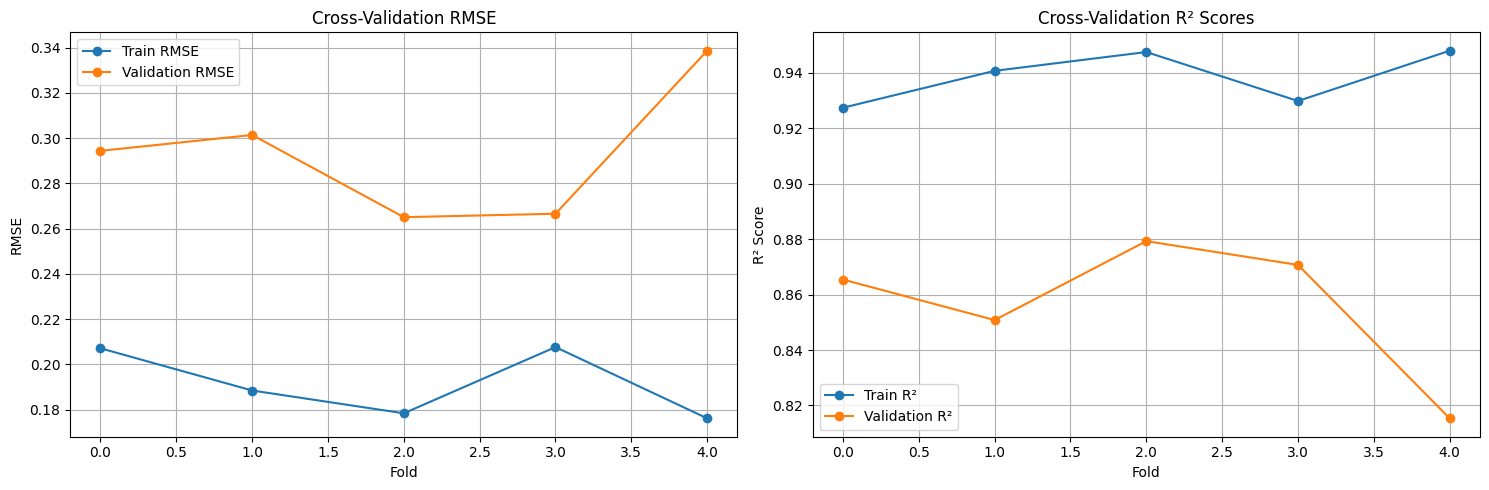


=== Cross-Validation Results ===
Average Train RMSE: 0.1915 (±0.0136)
Average Validation RMSE: 0.2932 (±0.0270)
Average Train R²: 0.9387 (±0.0086)
Average Validation R²: 0.8563 (±0.0225)

Training final model with 338 rounds...

Plotting learning curves...


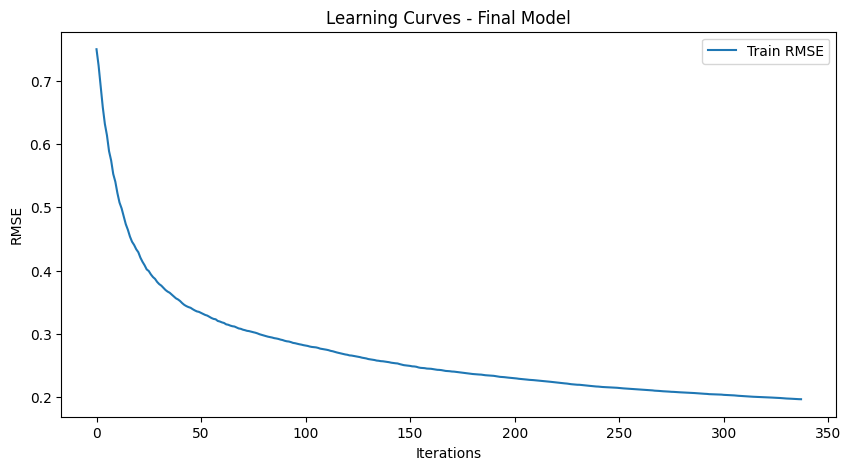


Evaluating final model...

=== Final Test Metrics ===
RMSE: 0.2813
R²: 0.8646
MAE: 0.1844

Plotting final model performance...


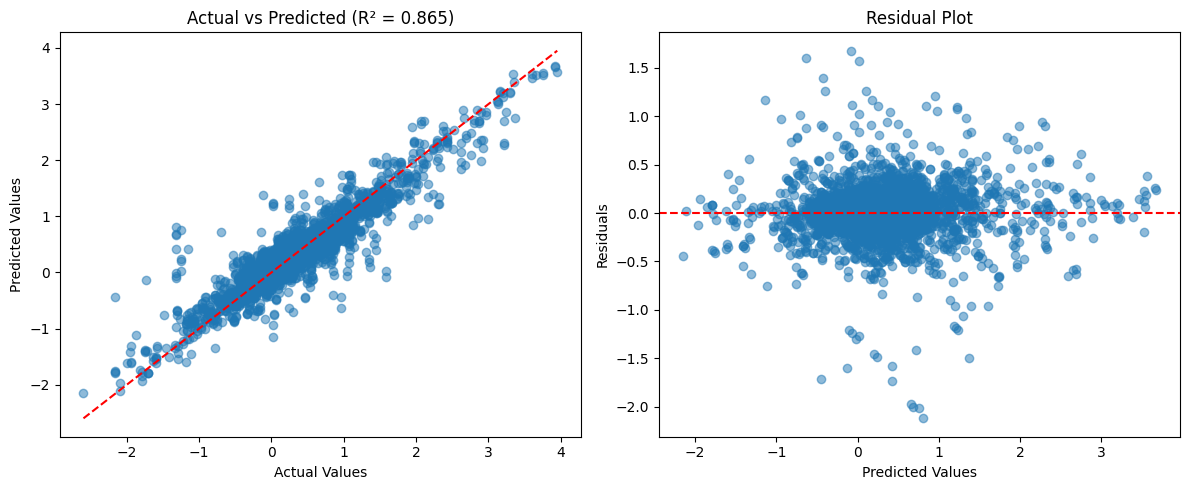


Analyzing feature importance...


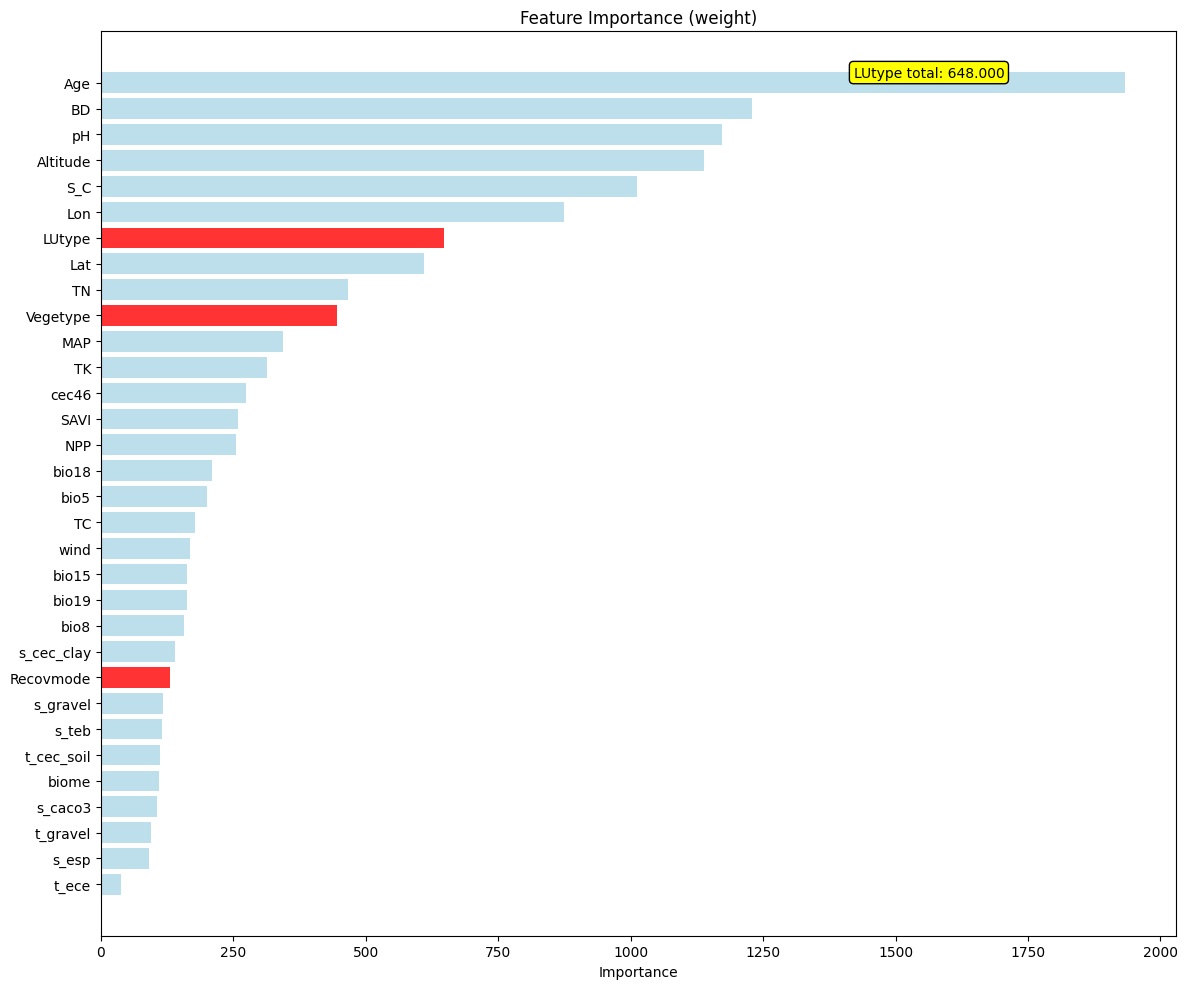


=== LUtype Feature Importance Analysis ===
Total LUtype-related features: 1
Total importance of LUtype features: 648.000
Average importance of LUtype features: 648.000

LUtype importance percentage: 4.89%

Top LUtype-related features:
  LUtype: 648.0000

=== 所有分类变量重要性分析 ===
LUtype 总重要性: 648.0000 (1个特征)
  LUtype: 648.0000
Vegetype 总重要性: 446.0000 (1个特征)
  Vegetype: 446.0000
Recovmode 总重要性: 131.0000 (1个特征)
  Recovmode: 131.0000

Saving results...

最终诊断报告
✅ 模型训练完成
✅ 最终测试RMSE: 0.2813
✅ 最终测试R²: 0.8646
✅ 特征数量: 32
✅ 最佳迭代轮数: 338

=== 分类变量使用情况 ===
✅ LUtype: 正确使用 (7个类别)
✅ Vegetype: 正确使用 (5个类别)
✅ Recovmode: 正确使用 (2个类别)

=== Recovmode掩膜分析 ===
Recovmode取值: [1.0, 2.0]

Recovmode 1.0 (样本数: 357):
  RMSE: 0.1881
  R²: 0.8998
  MAE: 0.1381

Recovmode 2.0 (样本数: 2593):
  RMSE: 0.2918
  R²: 0.8614
  MAE: 0.1908

Done!


In [56]:
# SOC model LUtype - 只保留分类变量，无交互特征
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import joblib
import os
import re
from pathlib import Path
import warnings
import builtins
open = builtins.open

warnings.filterwarnings('ignore')

# SHAP availability check
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else None
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names
        
        # 设置所有随机种子以确保可重复性
        self._set_random_seeds()

    def _set_random_seeds(self):
        """设置所有随机种子"""
        import random
        random.seed(self.seed)
        np.random.seed(self.seed)
        if hasattr(os, 'environ'):
            os.environ['PYTHONHASHSEED'] = str(self.seed)

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            # Remove any non-numeric characters except minus, decimal point
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """Objective function with categorical enabled"""
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'subsample': trial.suggest_float('subsample', 0.6, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 2, 10.0),
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0, 0.2),
            'max_delta_step': trial.suggest_int('max_delta_step', 0, 3),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1,
            # enable categorical support
            'enable_categorical': True
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=10,
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )

        return cv_results['test-rmse-mean'].iloc[-1]

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """Parallelized hyperparameter tuning"""
        print("=== 超参数调优诊断 ===")
        
        study = optuna.create_study(direction='minimize')

        # 使用partial函数传递额外的参数
        from functools import partial
        objective_with_boost = partial(self.objective, dtrain=dtrain)

        # We'll run study.optimize in threads but each optimize runs a number of trials.
        # Keep inner n_jobs=1 to avoid optuna nesting issues
        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(lambda: study.optimize(
                objective_with_boost,
                n_trials=max(1, int(n_trials / max(1, self.n_jobs))),
                n_jobs=1
            )) for _ in range(max(1, self.n_jobs))]

            for future in futures:
                future.result()

        self.study = study
        self.best_params = study.best_params.copy()
        # ensure categorical enabled and stable defaults
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs,
            'enable_categorical': True
        })

        # 诊断信息
        print(f"最佳参数: {self.best_params}")
        print(f"最佳分数: {study.best_value:.4f}")
        
        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """Optimized training"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=10,
            verbose_eval=False,
            evals_result=evals_result
        )

        # Store feature names from DMatrix
        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models'):
        """Optimized CV"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            # Keep pandas DataFrame with categorical dtype intact and enable categorical support
            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist(), enable_categorical=True)
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist(), enable_categorical=True)

            model, _ = self.train_model(params, dtrain, dval)

            # Save the CV model
            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration if hasattr(model, 'best_iteration') else num_boost_round,
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(
                    process_fold, fold_idx, train_idx, val_idx
                ))

            for future in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = future.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """Evaluate model performance on test set"""
        test_pred = model.predict(dtest)
        return {
            'rmse': np.sqrt(mean_squared_error(dtest.get_label(), test_pred)),
            'r2': r2_score(dtest.get_label(), test_pred),
            'mae': mean_absolute_error(dtest.get_label(), test_pred)
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix):
        """Plot training and validation metrics"""
        plt.figure(figsize=(10, 5))
        epochs = len(evals_result['train']['rmse'])
        plt.plot(range(epochs), evals_result['train']['rmse'], label='Train RMSE')
        if 'valid' in evals_result:
            plt.plot(range(epochs), evals_result['valid']['rmse'], label='Validation RMSE')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title_suffix}')
        plt.show()

    def plot_cv_results(self, cv_results):
        """Plot cross-validation results including loss curves and R2 scores"""
        plt.figure(figsize=(15, 5))

        # Plot RMSE
        plt.subplot(1, 2, 1)
        plt.plot(cv_results['train_rmse'], 'o-', label='Train RMSE')
        plt.plot(cv_results['val_rmse'], 'o-', label='Validation RMSE')
        plt.xlabel('Fold')
        plt.ylabel('RMSE')
        plt.title('Cross-Validation RMSE')
        plt.legend()
        plt.grid(True)

        # Plot R2
        plt.subplot(1, 2, 2)
        plt.plot(cv_results['train_r2'], 'o-', label='Train R²')
        plt.plot(cv_results['val_r2'], 'o-', label='Validation R²')
        plt.xlabel('Fold')
        plt.ylabel('R² Score')
        plt.title('Cross-Validation R² Scores')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_final_model_performance(self, model, dtest):
        """Plot actual vs predicted values for test set"""
        test_metrics, test_pred = self.evaluate_model(model, dtest)
        y_test = dtest.get_label()

        plt.figure(figsize=(12, 5))

        # Scatter plot of actual vs predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, test_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})')

        # Residual plot
        plt.subplot(1, 2, 2)
        residuals = y_test - test_pred
        plt.scatter(test_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model, importance_type='weight', top_n=30, 
                               highlight_features=None):
        """Plot feature importance with highlighted features"""
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # 获取特征重要性
        importance_dict = model.get_score(importance_type=importance_type)
        
        if not importance_dict:
            print("No feature importance data available.")
            return None
            
        # 转换为DataFrame以便排序
        importance_df = pd.DataFrame({
            'feature': list(importance_dict.keys()),
            'importance': list(importance_dict.values())
        }).sort_values('importance', ascending=True)
        
        # 只显示top_n特征
        if len(importance_df) > top_n:
            importance_df = importance_df.tail(top_n)
        
        # 绘制水平条形图
        y_pos = np.arange(len(importance_df))
        colors = ['lightblue'] * len(importance_df)
        
        # 高亮特定特征
        if highlight_features:
            for i, feature in enumerate(importance_df['feature']):
                if any(hl_feature in feature for hl_feature in highlight_features):
                    colors[i] = 'red'
        
        ax.barh(y_pos, importance_df['importance'], color=colors, alpha=0.8)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(importance_df['feature'])
        ax.set_xlabel('Importance')
        
        title = f'Feature Importance ({importance_type})'
        ax.set_title(title)
        
        # 添加LUtype重要性说明
        lu_type_features = importance_df[importance_df['feature'].str.contains('LUtype', na=False)]
        lu_type_importance = lu_type_features['importance'].sum() if not lu_type_features.empty else 0
        
        ax.text(0.7, 0.95, f'LUtype total: {lu_type_importance:.3f}', 
                transform=ax.transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))
        
        plt.tight_layout()
        plt.show()
        
        return importance_df

    def analyze_lutype_importance(self, model, X):
        """Analyze LUtype importance"""
        importance_dict = model.get_score(importance_type='weight')
        
        if not importance_dict:
            print("No feature importance data available.")
            return
        
        # 分类统计不同特征
        lutype_features = {k: v for k, v in importance_dict.items() if 'LUtype' in k}
        other_features = {k: v for k, v in importance_dict.items() if 'LUtype' not in k}
        
        print(f"\n=== LUtype Feature Importance Analysis ===")
        print(f"Total LUtype-related features: {len(lutype_features)}")
        print(f"Total importance of LUtype features: {sum(lutype_features.values()):.3f}")
        print(f"Average importance of LUtype features: {np.mean(list(lutype_features.values())) if lutype_features else 0:.3f}")
        
        total_importance = sum(importance_dict.values())
        lu_type_percentage = (sum(lutype_features.values()) / total_importance * 100) if total_importance > 0 else 0
        
        print(f"\nLUtype importance percentage: {lu_type_percentage:.2f}%")
        
        # 打印最重要的LUtype特征（如有）
        if lutype_features:
            sorted_lutype = sorted(lutype_features.items(), key=lambda x: x[1], reverse=True)
            print(f"\nTop LUtype-related features:")
            for feature, importance in sorted_lutype[:10]:
                print(f"  {feature}: {importance:.4f}")
        else:
            print("\nNo LUtype-related features found in importance scores.")

    def plot_shap_summary(self, model, X, feature_names=None):
        """Generate SHAP summary plot if SHAP is available"""
        if SHAP_AVAILABLE:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X, feature_names=feature_names)
            plt.tight_layout()
            plt.show()
        else:
            print("SHAP not available. Install with: pip install shap")

    def save_results(self, model, output_dir='results'):
        """Save all results to disk including feature names"""
        Path(output_dir).mkdir(exist_ok=True)

        # Save model
        model.save_model(f'{output_dir}/xgb_model.json')

        # Save feature names
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))

        # Save other artifacts
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')

        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)

    # ========== 新增诊断功能 ==========
    
    def diagnose_training_stability(self, params, X_train, y_train, n_runs=3):
        """诊断训练过程的稳定性"""
        print("\n" + "="*50)
        print("训练稳定性诊断")
        print("="*50)
        
        all_metrics = []
        
        for i in range(n_runs):
            print(f"\n--- 稳定性测试 {i+1}/{n_runs} ---")
            
            # 训练模型，启用分类支持
            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist(), enable_categorical=True)
            model, evals_result = self.train_model(params, dtrain)
            
            # 评估
            train_pred = model.predict(dtrain)
            train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
            train_r2 = r2_score(y_train, train_pred)
            
            all_metrics.append({
                'run': i+1,
                'train_rmse': train_rmse,
                'train_r2': train_r2,
                'best_iteration': model.best_iteration if hasattr(model, 'best_iteration') else len(evals_result['train']['rmse'])
            })
            
            print(f"  训练RMSE: {train_rmse:.4f}")
            print(f"  训练R²: {train_r2:.4f}")
        
        # 分析稳定性
        rmse_std = np.std([m['train_rmse'] for m in all_metrics])
        r2_std = np.std([m['train_r2'] for m in all_metrics])
        
        print(f"\n稳定性分析:")
        print(f"  RMSE标准差: {rmse_std:.4f} ({'稳定' if rmse_std < 0.01 else '不稳定'})")
        print(f"  R²标准差: {r2_std:.4f} ({'稳定' if r2_std < 0.01 else '不稳定'})")
        
        return all_metrics

    def validate_feature_consistency(self, X_train, expected_features=None):
        """验证特征一致性"""
        print("\n" + "="*50)
        print("特征一致性验证")
        print("="*50)
        
        actual_features = len(X_train.columns)
        
        if expected_features:
            print(f"期望特征数: {expected_features}")
            print(f"实际特征数: {actual_features}")
            
            if actual_features != expected_features:
                print(f"❌ 特征数量不匹配! 差值为: {actual_features - expected_features}")
            else:
                print("✅ 特征数量一致")
        else:
            print(f"实际特征数: {actual_features}")
            print("⚠️ 未设置期望特征数，跳过一致性检查")
        
        print("实际特征列表:")
        for i, feature in enumerate(X_train.columns):
            print(f"  {i+1:2d}. {feature}")
            
        # 检查LUtype相关特征
        lu_features = [col for col in X_train.columns if 'LUtype' in col]
        
        print(f"\nLUtype相关特征: {len(lu_features)}")
        
        return not expected_features or actual_features == expected_features

def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
    """Augment continuous features with noise"""
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()

        for col in continuous_cols:
            if col not in X.columns:
                continue
            std = X[col].std()
            if pd.isna(std) or std == 0:
                noise = 0.0
            else:
                noise = np.random.normal(loc=0, scale=std * noise_scale)
            # 保证不要改变 categorical dtype 列
            if pd.api.types.is_categorical_dtype(X[col]) or X[col].dtype == object:
                # 不对分类列添加噪声
                pass
            else:
                if X[col].min() >= 0:
                    base_sample[col] = max(0, base_sample[col] + noise)
                else:
                    base_sample[col] += noise

        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        
        y_augmented = y_augmented._append(
            pd.Series(y.iloc[idx], index=[len(y_augmented)]),  
            ignore_index=True
        )

    # 保持列的 dtype（尤其是 category）
    for col in X.columns:
        if pd.api.types.is_categorical_dtype(X[col]):
            X_augmented[col] = X_augmented[col].astype('category')

    return X_augmented, y_augmented

def load_and_prepare_data(augment=True, augmentation_factor=2):
    """Modified data loading function - 只保留原始特征，无交互特征"""
    dtype_dict = {
        'Soillayer': 'int8',
        'yi': 'float32'
    }

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    X = df_clean.drop('yi', axis=1)
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        if col in X.columns:
            X[col + '_log'] = np.log(X[col] + 1e-8)
    if 'Altitude' in X.columns:
        X['Altitude_bins'] = pd.cut(X['Altitude'], bins=5, labels=False)
    df_clean = pd.concat([df_clean['yi'], X], axis=1)

    target_layer = "topsoil" ###################################################################################SELCET LAYER
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    # ========== 修复：更严格的分类变量处理 ==========
    print("\n=== 分类变量诊断 ===")
    
    # 首先处理数值转换
    for col in valid_x_cols:
        if col in ['LUtype', 'Vegetype', 'Recovmode']:
            # 对于分类变量，先确保是整数
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(-1).astype(int)
            print(f"{col} 数值范围: {df[col].min()} ~ {df[col].max()}")
        else:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    x1 = df[valid_x_cols].copy()
    y1 = df['yi'].astype('float32')

    # ========== 修复：更严格的分类变量转换 ==========
    categorical_columns = ['LUtype', 'Vegetype', 'Recovmode']
    
    for col in categorical_columns:
        if col in x1.columns:
            try:
                # 先检查唯一值
                unique_vals = x1[col].unique()
                print(f"\n{col} 唯一值: {sorted(unique_vals)}")
                
                # 确保没有异常值
                valid_vals = [v for v in unique_vals if v >= 0]  # 假设分类编码从0或1开始
                if len(valid_vals) != len(unique_vals):
                    print(f"⚠️  {col} 包含异常值: {set(unique_vals) - set(valid_vals)}")
                
                # 转换为分类变量
                x1[col] = x1[col].astype('category')
                
                print(f"{col} 转换后类型: {x1[col].dtype}")
                print(f"{col} 类别数: {len(x1[col].cat.categories)}")
                print(f"{col} 分布:")
                print(x1[col].value_counts().sort_index())
                
            except Exception as e:
                print(f"❌ {col} 转换失败: {e}")
                # 兜底处理
                x1[col] = x1[col].astype('category')

    # 检查所有特征的数据类型
    print(f"\n=== 最终特征数据类型 ===")
    for col in x1.columns:
        if pd.api.types.is_categorical_dtype(x1[col]):
            print(f"✅ {col}: categorical ({len(x1[col].cat.categories)} categories)")
        else:
            print(f"📊 {col}: {x1[col].dtype}")

    # 注意：不再创建任何交互特征
    print("\n🔧 已取消所有交互特征的创建，只保留原始特征")

    # 数据增强（只对连续变量添加噪声，不影响 categorical 列）
    if augment:
        continuous_cols = [
            'Lon', 'Lat', 'Age', 'BD', 'pH', 'S_C',
            'Lon_log', 'Lat_log', 'Age_log', 'BD_log', 'pH_log',
            'Altitude'
        ]
        continuous_cols = [col for col in continuous_cols if col in x1.columns]
        
        print(f"\nAugmenting data with factor: {augmentation_factor}")
        x1, y1 = augment_continuous_features(
            X=x1,
            y=y1,
            continuous_cols=continuous_cols,
            augmentation_factor=augmentation_factor,
            noise_scale=0.01,  
            random_state=42
        )
    else:
        x1, y1 = x1, y1

    # 确保分类数据类型在增强后仍然保持
    categorical_columns = ['LUtype', 'Vegetype', 'Recovmode']
    for col in categorical_columns:
        if col in x1.columns and not pd.api.types.is_categorical_dtype(x1[col]):
            print(f"⚠️  增强后 {col} 丢失了分类类型，重新转换...")
            x1[col] = x1[col].astype('category')

    X_train, X_test, y_train, y_test = train_test_split(
        x1, y1, test_size=0.3, random_state=42
    )
    
    print(f"\n=== 数据集统计 ===")
    print(f"训练集大小: {len(X_train)}")
    print(f"测试集大小: {len(X_test)}")
    print(f"总特征数: {len(X_train.columns)}")
    
    # 详细的分类变量统计
    print(f"\n=== 分类变量在训练集中的分布 ===")
    for col in categorical_columns:
        if col in X_train.columns:
            print(f"\n{col}:")
            value_counts = X_train[col].value_counts().sort_index()
            for val, count in value_counts.items():
                percentage = count / len(X_train) * 100
                print(f"  值 {val}: {count} 样本 ({percentage:.1f}%)")

    # 创建DMatrix，确保启用分类支持
    print(f"\n=== 创建DMatrix ===")
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist(), enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist(), enable_categorical=True)
    
    # 验证DMatrix是否正确处理了分类变量 - 修复：移除不存在的属性访问
    print(f"DMatrix 特征数: {dtrain.num_col()}")
    print("✅ DMatrix 已启用分类支持 (通过enable_categorical=True参数)")
    
    # 验证分类变量在DMatrix中的处理
    print(f"\n=== 验证分类变量处理 ===")
    categorical_count = sum(1 for col in X_train.columns if pd.api.types.is_categorical_dtype(X_train[col]))
    print(f"分类变量数量: {categorical_count}")
    
    return dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train

def main():
    """Main function - 只保留原始特征，无交互特征"""
    print("=== XGBoost模型训练与诊断（无交互特征） ===")
    
    # 使用修复后的数据加载函数
    dtrain, dtest, x1, y1, X_test, y_test, X_train, y_train = load_and_prepare_data(
        augment=True,
        augmentation_factor=3
    )

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 0. 运行诊断 - 增强分类变量验证
    print("\n运行预训练诊断...")
    feature_consistent = tuner.validate_feature_consistency(X_train)
    
    # 额外验证分类变量
    print("\n=== 分类变量最终验证 ===")
    categorical_columns = ['LUtype', 'Vegetype', 'Recovmode']
    for col in categorical_columns:
        if col in X_train.columns:
            if pd.api.types.is_categorical_dtype(X_train[col]):
                print(f"✅ {col}: 正确转换为分类变量")
                print(f"   类别数: {len(X_train[col].cat.categories)}")
                print(f"   取值: {sorted(X_train[col].cat.categories.tolist())}")
            else:
                print(f"❌ {col}: 未正确转换为分类变量，当前类型: {X_train[col].dtype}")
    
    if not feature_consistent:
        print("⚠️ 特征数量不一致，但继续训练...")

    # 1. Hyperparameter tuning
    print("\nStarting optimized hyperparameter tuning...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)
    print(f"Best parameters: {best_params}")

    # 2. 训练稳定性诊断
    stability_results = tuner.diagnose_training_stability(best_params, X_train, y_train, n_runs=3)

    # 3. Cross-validation with model saving
    print("\nRunning optimized cross-validation...")
    cv_results = tuner.cross_validate(best_params, X_train, y_train, n_splits=5,
                                      cv_models_dir='F:/model/results/cv_models')
    
    print("\nSaved CV models at:")
    for path in cv_results['model_paths']:
        print(f"- {path}")
    
    # Plot CV results
    print("\nPlotting cross-validation results...")
    tuner.plot_cv_results(cv_results)

    # Print CV results
    print("\n=== Cross-Validation Results ===")
    print(f"Average Train RMSE: {np.mean(cv_results['train_rmse']):.4f} (±{np.std(cv_results['train_rmse']):.4f})")
    print(f"Average Validation RMSE: {np.mean(cv_results['val_rmse']):.4f} (±{np.std(cv_results['val_rmse']):.4f})")
    print(f"Average Train R²: {np.mean(cv_results['train_r2']):.4f} (±{np.std(cv_results['train_r2']):.4f})")
    print(f"Average Validation R²: {np.mean(cv_results['val_r2']):.4f} (±{np.std(cv_results['val_r2']):.4f})")

    # 4. Train final model
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final model with {optimal_rounds} rounds...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)

    # Plot learning curves
    print("\nPlotting learning curves...")
    tuner.plot_learning_curves(evals_result, "Final Model")

    # 5. Evaluate and plot final performance
    print("\nEvaluating final model...")
    test_metrics, test_pred = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")

    print("\nPlotting final model performance...")
    tuner.plot_final_model_performance(final_model, dtest)

    # 6. 分析特征重要性 - 增强分类变量分析
    print(f"\nAnalyzing feature importance...")
    importance_df = tuner.plot_feature_importance(final_model, top_n=35, 
                                                 highlight_features=['LUtype', 'Vegetype', 'Recovmode'])
    
    # 详细分析各分类变量重要性
    tuner.analyze_lutype_importance(final_model, X_test)
    
    # 新增：分析所有分类变量
    print(f"\n=== 所有分类变量重要性分析 ===")
    categorical_columns = ['LUtype', 'Vegetype', 'Recovmode']
    importance_dict = final_model.get_score(importance_type='weight')
    
    for col in categorical_columns:
        col_features = {k: v for k, v in importance_dict.items() if col in k}
        if col_features:
            total_importance = sum(col_features.values())
            print(f"{col} 总重要性: {total_importance:.4f} ({len(col_features)}个特征)")
            for feature, imp in sorted(col_features.items(), key=lambda x: x[1], reverse=True)[:5]:
                print(f"  {feature}: {imp:.4f}")
        else:
            print(f"{col}: 在特征重要性中未找到相关特征")
    
    # 7. SHAP分析
    if SHAP_AVAILABLE:
        print("\nGenerating SHAP summary plot...")
        tuner.plot_shap_summary(final_model, X_test)
    
    # 8. 保存结果
    print("\nSaving results...")
    tuner.save_results(final_model, 'F:/model/results')
    
    # 9. 最终诊断报告 - 增强分类变量报告
    print("\n" + "="*50)
    print("最终诊断报告")
    print("="*50)
    print(f"✅ 模型训练完成")
    print(f"✅ 最终测试RMSE: {test_metrics['rmse']:.4f}")
    print(f"✅ 最终测试R²: {test_metrics['r2']:.4f}")
    print(f"✅ 特征数量: {len(X_train.columns)}")
    print(f"✅ 最佳迭代轮数: {optimal_rounds}")
    
    # 分类变量使用情况报告
    print(f"\n=== 分类变量使用情况 ===")
    categorical_columns = ['LUtype', 'Vegetype', 'Recovmode']
    for col in categorical_columns:
        if col in X_train.columns:
            if pd.api.types.is_categorical_dtype(X_train[col]):
                cat_count = len(X_train[col].cat.categories)
                print(f"✅ {col}: 正确使用 ({cat_count}个类别)")
            else:
                print(f"❌ {col}: 未正确转换为分类变量")
    
    # 使用Recovmode做掩膜分析
    print(f"\n=== Recovmode掩膜分析 ===")
    if 'Recovmode' in X_test.columns:
        # 获取测试集的预测结果
        test_pred = final_model.predict(dtest)
        
        # 按Recovmode分组评估
        recovmode_values = X_test['Recovmode'].unique()
        recovmode_values = sorted([v for v in recovmode_values if not pd.isna(v)])
        
        print(f"Recovmode取值: {recovmode_values}")
        
        for recov_val in recovmode_values:
            # 创建掩膜
            mask = (X_test['Recovmode'] == recov_val)
            
            if mask.sum() > 0:  # 确保有样本
                y_test_subset = y_test[mask]
                pred_subset = test_pred[mask]
                
                # 计算该Recovmode组的指标
                rmse = np.sqrt(mean_squared_error(y_test_subset, pred_subset))
                r2 = r2_score(y_test_subset, pred_subset)
                mae = mean_absolute_error(y_test_subset, pred_subset)
                
                print(f"\nRecovmode {recov_val} (样本数: {mask.sum()}):")
                print(f"  RMSE: {rmse:.4f}")
                print(f"  R²: {r2:.4f}")
                print(f"  MAE: {mae:.4f}")
    
    print("\nDone!")

if __name__ == "__main__":
    main()

E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
E:\workspace\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
[I 2025-11-15 19:28:58,200] A new study created in memory with name: no-name-11a00a3f-ae71-4238-9bae-7650a98b3d7a


6882
Starting optimized hyperparameter tuning...


[I 2025-11-15 19:29:03,368] Trial 7 finished with value: 0.2896443378448651 and parameters: {'eta': 0.17830839204575635, 'max_depth': 5, 'subsample': 0.7158542513416721, 'colsample_bytree': 0.7495171628578233, 'min_child_weight': 3, 'lambda': 3.1762120005562986, 'alpha': 0.8377595712339454, 'gamma': 0.17779106226313834}. Best is trial 7 with value: 0.2896443378448651.
[I 2025-11-15 19:29:05,471] Trial 8 finished with value: 0.4484428411522664 and parameters: {'eta': 0.017896032420495114, 'max_depth': 3, 'subsample': 0.6110946165148874, 'colsample_bytree': 0.8928298639466692, 'min_child_weight': 7, 'lambda': 8.847316562894605, 'alpha': 0.5234830050890458, 'gamma': 0.12916350881670005}. Best is trial 7 with value: 0.2896443378448651.
[I 2025-11-15 19:29:05,581] Trial 3 finished with value: 0.277135105709505 and parameters: {'eta': 0.17811919544100902, 'max_depth': 6, 'subsample': 0.7027513270061737, 'colsample_bytree': 0.7133531004198608, 'min_child_weight': 3, 'lambda': 4.89797727286149


Running optimized cross-validation and saving CV models...

Saved CV models at:
- F:/model/results/cv_models\cv_model_fold_0.json
- F:/model/results/cv_models\cv_model_fold_1.json
- F:/model/results/cv_models\cv_model_fold_2.json
- F:/model/results/cv_models\cv_model_fold_3.json
- F:/model/results/cv_models\cv_model_fold_4.json

Plotting cross-validation results...


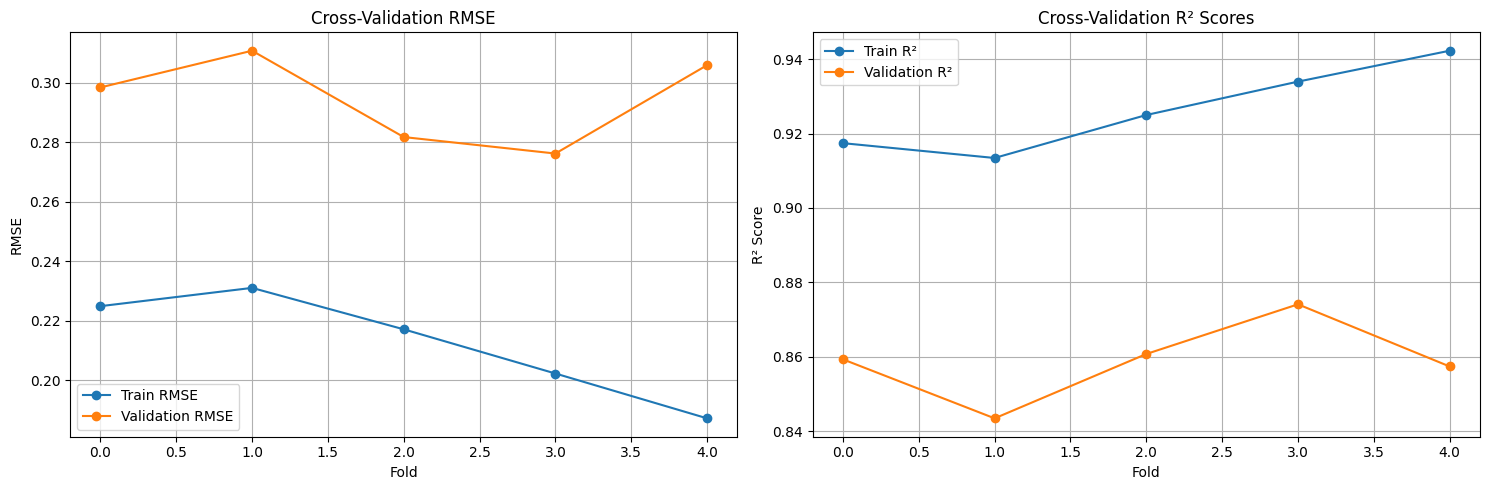


=== Cross-Validation Results ===
Average Train RMSE: 0.2126 (±0.0159)
Average Validation RMSE: 0.2946 (±0.0135)
Average Train R²: 0.9264 (±0.0106)
Average Validation R²: 0.8590 (±0.0097)

Training final model with 165 rounds...

Plotting learning curves...


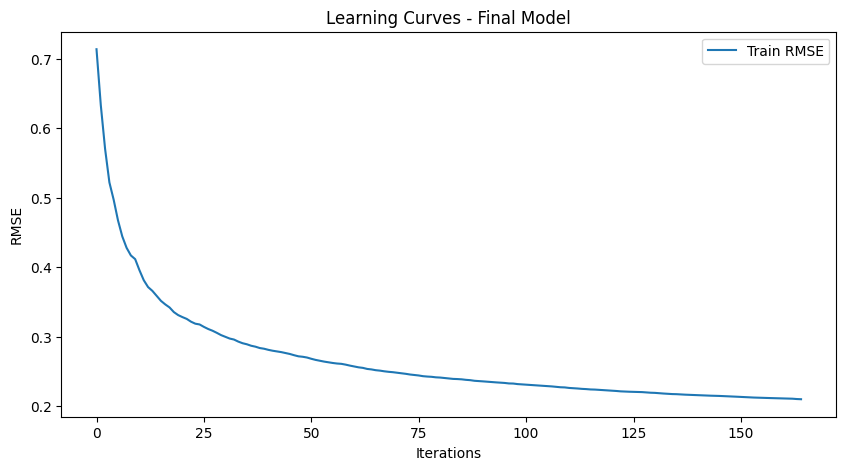


Evaluating final model...

=== Final Test Metrics ===
RMSE: 0.2097
R²: 0.9260
MAE: 0.1414

Plotting final model performance...


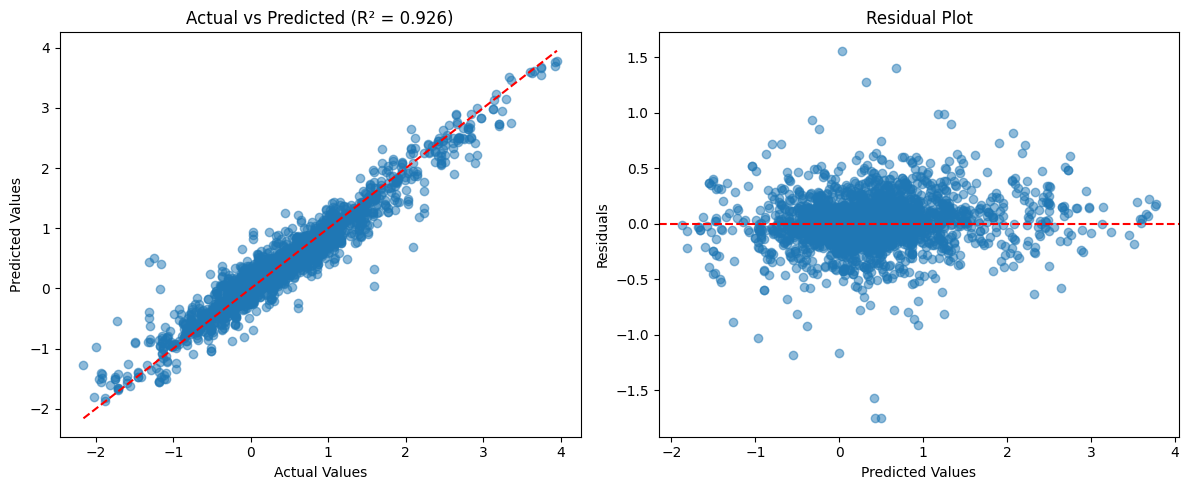


Saving results...
Done!

Plotting feature importance...


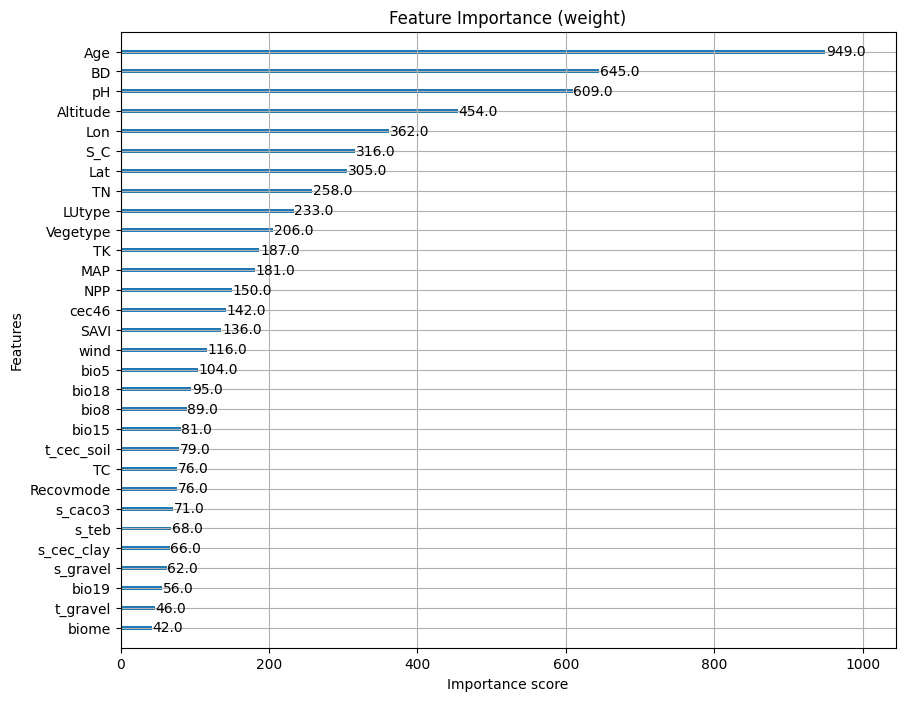

In [ ]:
#all three models chaoqiangyuanban
try:
    import shap

    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else None
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            # Remove any non-numeric characters except minus, decimal point
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """Enhanced objective function with more sophisticated search space"""
        '''
        params = {
            'eta': trial.suggest_float('eta', 0.02, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 4, 8),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 0.5, 2.0),
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0, 0.2),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }'''
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 6),
            'subsample': trial.suggest_float('subsample', 0.6, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 2, 10.0),#5,10
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0, 0.2),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=500,
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=10,
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )

        return cv_results['test-rmse-mean'].iloc[-1]

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """Parallelized hyperparameter tuning"""
        study = optuna.create_study(direction='minimize')

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(lambda: study.optimize(
                lambda trial: self.objective(trial, dtrain),
                n_trials=5,
                n_jobs=1
            )) for _ in range(n_trials)]

            for future in futures:
                future.result()

        self.study = study
        self.best_params = study.best_params
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs
        })

        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """Optimized training with reduced verbosity"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=10,
            verbose_eval=False,
            evals_result=evals_result
        )

        # Store feature names from DMatrix
        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models'):
        """Optimized CV with parallel fold execution and model saving"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []  # Store feature names for each fold
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist())

            model, _ = self.train_model(params, dtrain, dval)

            # Save the CV model
            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration if hasattr(model, 'best_iteration') else num_boost_round,
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(
                    process_fold, fold_idx, train_idx, val_idx
                ))

            for future in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = future.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """Evaluate model performance on test set"""
        test_pred = model.predict(dtest)
        return {
            'rmse': np.sqrt(mean_squared_error(dtest.get_label(), test_pred)),
            'r2': r2_score(dtest.get_label(), test_pred),
            'mae': mean_absolute_error(dtest.get_label(), test_pred)
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix):
        """Plot training and validation metrics"""
        plt.figure(figsize=(10, 5))
        epochs = len(evals_result['train']['rmse'])
        plt.plot(range(epochs), evals_result['train']['rmse'], label='Train RMSE')
        if 'valid' in evals_result:
            plt.plot(range(epochs), evals_result['valid']['rmse'], label='Validation RMSE')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title_suffix}')
        plt.show()

    def plot_cv_results(self, cv_results):
        """Plot cross-validation results including loss curves and R2 scores"""
        plt.figure(figsize=(15, 5))

        # Plot RMSE
        plt.subplot(1, 2, 1)
        plt.plot(cv_results['train_rmse'], 'o-', label='Train RMSE')
        plt.plot(cv_results['val_rmse'], 'o-', label='Validation RMSE')
        plt.xlabel('Fold')
        plt.ylabel('RMSE')
        plt.title('Cross-Validation RMSE')
        plt.legend()
        plt.grid(True)

        # Plot R2
        plt.subplot(1, 2, 2)
        plt.plot(cv_results['train_r2'], 'o-', label='Train R²')
        plt.plot(cv_results['val_r2'], 'o-', label='Validation R²')
        plt.xlabel('Fold')
        plt.ylabel('R² Score')
        plt.title('Cross-Validation R² Scores')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_final_model_performance(self, model, dtest):
        """Plot actual vs predicted values for test set"""
        test_metrics, test_pred = self.evaluate_model(model, dtest)
        y_test = dtest.get_label()

        plt.figure(figsize=(12, 5))

        # Scatter plot of actual vs predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, test_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})')

        # Residual plot
        plt.subplot(1, 2, 2)
        residuals = y_test - test_pred
        plt.scatter(test_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model, importance_type='weight',top_n = 30):
        """Plot feature importance"""
        fig, ax = plt.subplots(figsize=(10, 8))
        xgb.plot_importance(model, importance_type=importance_type, ax=ax,max_num_features=top_n)
        plt.title(f'Feature Importance ({importance_type})')
        plt.show()

    def plot_shap_summary(self, model, X, feature_names=None):
        """Generate SHAP summary plot if SHAP is available"""
        if SHAP_AVAILABLE:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X, feature_names=feature_names)
            plt.tight_layout()
            plt.show()
        else:
            print("SHAP not available. Install with: pip install shap")

    def save_results(self, model, output_dir='results'):
        """Save all results to disk including feature names"""
        Path(output_dir).mkdir(exist_ok=True)

        # Save model
        model.save_model(f'{output_dir}/xgb_model.json')

        # Save feature names
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))

        # Save other artifacts
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')

        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)
def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
   
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()

       
        for col in continuous_cols:
            std = X[col].std()
            noise = np.random.normal(loc=0, scale=std * noise_scale)
            if X[col].min() >= 0:
                base_sample[col] = max(0, base_sample[col] + noise)
            else:
                base_sample[col] += noise

        
        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        
        y_augmented = y_augmented._append(
            pd.Series(y.iloc[idx], index=[len(y_augmented)]),  
            ignore_index=True
        )

    return X_augmented, y_augmented
def load_and_prepare_data(augment=True, augmentation_factor=2):
    """Modified data loading function with data augmentation"""
    dtype_dict = {
        'Soillayer': 'int8',
        'yi': 'float32'
    }

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    X = df_clean.drop('yi', axis=1)
    columns_to_log = ['Lon', 'Lat', 'Age', 'BD', 'pH']
    for col in columns_to_log:
        X[col + '_log'] = np.log(X[col] + 1e-8)
    X['Altitude_bins'] = pd.cut(X['Altitude'], bins=5, labels=False)
    df_clean = pd.concat([df_clean['yi'], X], axis=1)

    target_layer = "topsoil"  # 可根据需要修改为'topsoil'##############################################################
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    x1 = df[valid_x_cols].astype('float32').fillna(0)
    y1 = df['yi'].astype('float32')
   
    if augment:

        continuous_cols = [
            'Lon', 'Lat', 'Age', 'BD', 'pH',
            'Lon_log', 'Lat_log', 'Age_log', 'BD_log', 'pH_log',
            'Altitude'
        ]

        continuous_cols = [col for col in continuous_cols if col in x1.columns]

       
        x1, y1 = augment_continuous_features(
            X=x1,
            y=y1,
            continuous_cols=continuous_cols,
            augmentation_factor=augmentation_factor,
            noise_scale=0.01,  
            random_state=42
        )
    
    else:
        x1, y1 = x1, y1

    X_train, X_test, y_train, y_test = train_test_split(
        x1, y1, test_size=0.3, random_state=42
    )
    print(len(X_train))

    dtrain = xgb.DMatrix(x1, label=y1, feature_names=X_train.columns.tolist())
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist())

    return dtrain, dtest, x1, y1,X_test, y_test, X_train, y_train
def main():

    dtrain, dtest, x1, y1,X_test, y_test, X_train, y_train= load_and_prepare_data(
        augment=True,
        augmentation_factor=3  
    )

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 1. Hyperparameter tuning
    print("Starting optimized hyperparameter tuning...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)

    # 2. Cross-validation with model saving
    print("\nRunning optimized cross-validation and saving CV models...")
    cv_results = tuner.cross_validate(best_params, X_train, y_train, n_splits=5,
                                      cv_models_dir='F:/model/results/cv_models')
    print("\nSaved CV models at:")
    for path in cv_results['model_paths']:
        print(f"- {path}")
    # Plot CV results
    print("\nPlotting cross-validation results...")
    tuner.plot_cv_results(cv_results)

    # Print CV results
    print("\n=== Cross-Validation Results ===")
    print(f"Average Train RMSE: {np.mean(cv_results['train_rmse']):.4f} (±{np.std(cv_results['train_rmse']):.4f})")
    print(f"Average Validation RMSE: {np.mean(cv_results['val_rmse']):.4f} (±{np.std(cv_results['val_rmse']):.4f})")
    print(f"Average Train R²: {np.mean(cv_results['train_r2']):.4f} (±{np.std(cv_results['train_r2']):.4f})")
    print(f"Average Validation R²: {np.mean(cv_results['val_r2']):.4f} (±{np.std(cv_results['val_r2']):.4f})")

    # 3. Train final model
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final model with {optimal_rounds} rounds...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)
#   dtrain_final = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
#   final_model, evals_result = tuner.train_model(best_params, dtrain_final, num_boost_round=optimal_rounds)

    # Plot learning curves
    print("\nPlotting learning curves...")
    tuner.plot_learning_curves(evals_result, "Final Model")

    # 4. Evaluate and plot final performance
    print("\nEvaluating final model...")
    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")

    print("\nPlotting final model performance...")
    tuner.plot_final_model_performance(final_model, dtest)
    print("\nSaving results...")
    tuner.save_results(final_model, 'F:/model/results')
    print("Done!")
    # 5. Feature analysis
    print("\nPlotting feature importance...")
    tuner.plot_feature_importance(final_model, top_n=30)
    if SHAP_AVAILABLE:
        print("\nGenerating SHAP summary plot...")
        tuner.plot_shap_summary(final_model, X_test)
if __name__ == "__main__":
    main()

In [ ]:
######LI modeling##################
try:
    import shap

    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
class XGBoostTuner:
    def __init__(self, seed=42, n_jobs=-1):
        self.seed = seed
        self.n_jobs = n_jobs if n_jobs != -1 else None
        self.study = None
        self.best_model = None
        self.best_params = None
        self.feature_names = None  # Store feature names

    @staticmethod
    def clean_numeric_value(value):
        """Convert string values to numeric, handling special cases"""
        if pd.isna(value):
            return np.nan
        if isinstance(value, str):
            # Remove any non-numeric characters except minus, decimal point
            cleaned = re.sub(r'[^\d.-]', '', value)
            try:
                return float(cleaned) if cleaned else np.nan
            except ValueError:
                return np.nan
        return float(value)

    def objective(self, trial, dtrain, num_boost_round=500):
        """Enhanced objective function with more sophisticated search space"""
        '''
        params = {
            'eta': trial.suggest_float('eta', 0.02, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 4, 8),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 7),
            'lambda': trial.suggest_float('lambda', 0.5, 2.0),
            'alpha': trial.suggest_float('alpha', 0.5, 2.0),
            'gamma': trial.suggest_float('gamma', 0, 0.2),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }'''
        params = {
            'eta': trial.suggest_float('eta', 0.01, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 5),
            'subsample': trial.suggest_float('subsample', 0.5, 0.8),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
            'min_child_weight': trial.suggest_int('min_child_weight', 5, 15),
            'lambda': trial.suggest_float('lambda', 5, 20.0),#5,10
            'alpha': trial.suggest_float('alpha', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 0.3),
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'verbosity': 0,
            'seed': self.seed,
            'nthread': 1
        }

        cv_results = xgb.cv(
            params=params,
            dtrain=dtrain,
            num_boost_round=500,
            nfold=5,
            metrics='rmse',
            early_stopping_rounds=20,
            as_pandas=True,
            seed=self.seed,
            shuffle=True
        )

        return cv_results['test-rmse-mean'].iloc[-1]

    def tune_hyperparameters(self, dtrain, n_trials=10):
        """Parallelized hyperparameter tuning"""
        study = optuna.create_study(direction='minimize')

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = [executor.submit(lambda: study.optimize(
                lambda trial: self.objective(trial, dtrain),
                n_trials=5,
                n_jobs=1
            )) for _ in range(n_trials)]

            for future in futures:
                future.result()

        self.study = study
        self.best_params = study.best_params
        self.best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'seed': self.seed,
            'nthread': self.n_jobs
        })

        return self.best_params

    def train_model(self, params, dtrain, dvalid=None, num_boost_round=500):
        """Optimized training with reduced verbosity"""
        evals = [(dtrain, 'train')]
        if dvalid is not None:
            evals.append((dvalid, 'valid'))

        evals_result = {}
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=20,
            verbose_eval=False,
            evals_result=evals_result
        )

        # Store feature names from DMatrix
        self.feature_names = dtrain.feature_names
        if self.feature_names is None:
            self.feature_names = [f'f{i}' for i in range(dtrain.num_col())]
            model.feature_names = self.feature_names

        return model, evals_result

    def cross_validate(self, params, X, y, n_splits=5, cv_models_dir='cv_models'):
        """Optimized CV with parallel fold execution and model saving"""
        Path(cv_models_dir).mkdir(parents=True, exist_ok=True)

        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.seed)
        cv_results = {
            'train_rmse': [], 'val_rmse': [],
            'train_r2': [], 'val_r2': [],
            'best_iterations': [],
            'model_paths': [],
            'feature_names': []  # Store feature names for each fold
        }

        def process_fold(fold_idx, train_idx, val_idx):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
            dval = xgb.DMatrix(X_val, label=y_val, feature_names=X_train.columns.tolist())

            model, _ = self.train_model(params, dtrain, dval)

            # Save the CV model
            model_path = os.path.join(cv_models_dir, f'cv_model_fold_{fold_idx}.json')
            model.save_model(model_path)

            train_pred = model.predict(dtrain)
            val_pred = model.predict(dval)

            return (
                np.sqrt(mean_squared_error(y_train, train_pred)),
                np.sqrt(mean_squared_error(y_val, val_pred)),
                r2_score(y_train, train_pred),
                r2_score(y_val, val_pred),
                model.best_iteration if hasattr(model, 'best_iteration') else num_boost_round,
                model_path,
                model.feature_names
            )

        with ThreadPoolExecutor(max_workers=self.n_jobs) as executor:
            futures = []
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
                futures.append(executor.submit(
                    process_fold, fold_idx, train_idx, val_idx
                ))

            for future in futures:
                train_rmse, val_rmse, train_r2, val_r2, best_iter, model_path, feature_names = future.result()
                cv_results['train_rmse'].append(train_rmse)
                cv_results['val_rmse'].append(val_rmse)
                cv_results['train_r2'].append(train_r2)
                cv_results['val_r2'].append(val_r2)
                cv_results['best_iterations'].append(best_iter)
                cv_results['model_paths'].append(model_path)
                cv_results['feature_names'].append(feature_names)

        return cv_results

    def evaluate_model(self, model, dtest):
        """Evaluate model performance on test set"""
        test_pred = model.predict(dtest)
        return {
            'rmse': np.sqrt(mean_squared_error(dtest.get_label(), test_pred)),
            'r2': r2_score(dtest.get_label(), test_pred),
            'mae': mean_absolute_error(dtest.get_label(), test_pred)
        }, test_pred

    def plot_learning_curves(self, evals_result, title_suffix):
        """Plot training and validation metrics"""
        plt.figure(figsize=(10, 5))
        epochs = len(evals_result['train']['rmse'])
        plt.plot(range(epochs), evals_result['train']['rmse'], label='Train RMSE')
        if 'valid' in evals_result:
            plt.plot(range(epochs), evals_result['valid']['rmse'], label='Validation RMSE')
        plt.legend()
        plt.xlabel('Iterations')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - {title_suffix}')
        plt.show()

    def plot_cv_results(self, cv_results):
        """Plot cross-validation results including loss curves and R2 scores"""
        plt.figure(figsize=(15, 5))

        # Plot RMSE
        plt.subplot(1, 2, 1)
        plt.plot(cv_results['train_rmse'], 'o-', label='Train RMSE')
        plt.plot(cv_results['val_rmse'], 'o-', label='Validation RMSE')
        plt.xlabel('Fold')
        plt.ylabel('RMSE')
        plt.title('Cross-Validation RMSE')
        plt.legend()
        plt.grid(True)

        # Plot R2
        plt.subplot(1, 2, 2)
        plt.plot(cv_results['train_r2'], 'o-', label='Train R²')
        plt.plot(cv_results['val_r2'], 'o-', label='Validation R²')
        plt.xlabel('Fold')
        plt.ylabel('R² Score')
        plt.title('Cross-Validation R² Scores')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_final_model_performance(self, model, dtest):
        """Plot actual vs predicted values for test set"""
        test_metrics, test_pred = self.evaluate_model(model, dtest)
        y_test = dtest.get_label()

        plt.figure(figsize=(12, 5))

        # Scatter plot of actual vs predicted
        plt.subplot(1, 2, 1)
        plt.scatter(y_test, test_pred, alpha=0.5)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})')

        # Residual plot
        plt.subplot(1, 2, 2)
        residuals = y_test - test_pred
        plt.scatter(test_pred, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title('Residual Plot')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, model, importance_type='weight',top_n = 30):
        """Plot feature importance"""
        fig, ax = plt.subplots(figsize=(10, 8))
        xgb.plot_importance(model, importance_type=importance_type, ax=ax,max_num_features=top_n)
        plt.title(f'Feature Importance ({importance_type})')
        plt.show()

    def plot_shap_summary(self, model, X, feature_names=None):
        """Generate SHAP summary plot if SHAP is available"""
        if SHAP_AVAILABLE:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X)

            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X, feature_names=feature_names)
            plt.tight_layout()
            plt.show()
        else:
            print("SHAP not available. Install with: pip install shap")

    def save_results(self, model, output_dir='results'):
        """Save all results to disk including feature names"""
        Path(output_dir).mkdir(exist_ok=True)

        # Save model
        model.save_model(f'{output_dir}/xgb_model.json')

        # Save feature names
        if self.feature_names is not None:
            with open(f'{output_dir}/feature_names.txt', 'w') as f:
                f.write('\n'.join(self.feature_names))

        # Save other artifacts
        joblib.dump(self.best_params, f'{output_dir}/best_params.pkl')

        if self.study:
            joblib.dump(self.study, f'{output_dir}/study.pkl')
            study_df = self.study.trials_dataframe()
            study_df.to_csv(f'{output_dir}/trials.csv', index=False)
def augment_continuous_features(X, y, continuous_cols, augmentation_factor=2, noise_scale=0.01, random_state=42):
   
    np.random.seed(random_state)
    n_samples = len(X)
    n_augment = int(n_samples * augmentation_factor)

    X_augmented = X.copy()
    y_augmented = y.copy()

    for _ in range(n_augment):
        idx = np.random.randint(0, n_samples)
        base_sample = X.iloc[idx].copy()

       
        for col in continuous_cols:
            std = X[col].std()
            noise = np.random.normal(loc=0, scale=std * noise_scale)
            if X[col].min() >= 0:
                base_sample[col] = max(0, base_sample[col] + noise)
            else:
                base_sample[col] += noise

        
        X_augmented = X_augmented._append(base_sample, ignore_index=True)
        
        y_augmented = y_augmented._append(
            pd.Series(y.iloc[idx], index=[len(y_augmented)]),  
            ignore_index=True
        )

    return X_augmented, y_augmented
def load_and_prepare_data(augment=True, augmentation_factor=2):
    """Modified data loading function with data augmentation"""
    dtype_dict = {
        'Soillayer': 'int8',
        'yi': 'float32'
    }

    df_clean = pd.read_csv('F:/model/df.clean.yi.csv', dtype=dtype_dict)
    data_predictor_VIF = pd.read_csv('F:/model/data.predictor.VIF.yi.csv')

    X = df_clean.drop('yi', axis=1)
    columns_to_log = ['Lon', 'Lat', 'Age', 'SOC', 'bio2']
    for col in columns_to_log:
        X[col + '_log'] = np.log(X[col] + 1e-8)
    X['Altitude_bins'] = pd.cut(X['Altitude'], bins=5, labels=False)
    df_clean = pd.concat([df_clean['yi'], X], axis=1)

    target_layer = "topsoil"  # 可根据需要修改为'topsoil'##############################################################
    df = df_clean[df_clean['Soillayer'] == (1 if target_layer == 'topsoil' else 2)].copy()

    predictor_columns = data_predictor_VIF['x'].tolist()
    valid_x_cols = [col for col in predictor_columns if col != "Soillayer" and col in df.columns]

    for col in valid_x_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    x1 = df[valid_x_cols].astype('float32').fillna(0)
    y1 = df['yi'].astype('float32')
   
    if augment:

        continuous_cols = [
            'Lon', 'Lat', 'Age', 'SOC', 'bio2',
            'Lon_log', 'Lat_log', 'Age_log', 'SOC_log', 'bio2_log',
            'Altitude'
        ]

        continuous_cols = [col for col in continuous_cols if col in x1.columns]

       
        x1, y1 = augment_continuous_features(
            X=x1,
            y=y1,
            continuous_cols=continuous_cols,
            augmentation_factor=augmentation_factor,
            noise_scale=0.01,  
            random_state=42
        )
    
    else:
        x1, y1 = x1, y1

    X_train, X_test, y_train, y_test = train_test_split(
        x1, y1, test_size=0.3, random_state=42
    )
    print(len(X_train))

    dtrain = xgb.DMatrix(x1, label=y1, feature_names=X_train.columns.tolist())
    dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_train.columns.tolist())

    return dtrain, dtest, x1, y1,X_test, y_test, X_train, y_train
def main():

    dtrain, dtest, x1, y1,X_test, y_test, X_train, y_train= load_and_prepare_data(
        augment=True,
        augmentation_factor=3  
    )

    tuner = XGBoostTuner(seed=42, n_jobs=17)

    # 1. Hyperparameter tuning
    print("Starting optimized hyperparameter tuning...")
    best_params = tuner.tune_hyperparameters(dtrain, n_trials=10)

    # 2. Cross-validation with model saving
    print("\nRunning optimized cross-validation and saving CV models...")
    cv_results = tuner.cross_validate(best_params, X_train, y_train, n_splits=5,
                                      cv_models_dir='F:/model/results/cv_models')
    print("\nSaved CV models at:")
    for path in cv_results['model_paths']:
        print(f"- {path}")
    # Plot CV results
    print("\nPlotting cross-validation results...")
    tuner.plot_cv_results(cv_results)

    # Print CV results
    print("\n=== Cross-Validation Results ===")
    print(f"Average Train RMSE: {np.mean(cv_results['train_rmse']):.4f} (±{np.std(cv_results['train_rmse']):.4f})")
    print(f"Average Validation RMSE: {np.mean(cv_results['val_rmse']):.4f} (±{np.std(cv_results['val_rmse']):.4f})")
    print(f"Average Train R²: {np.mean(cv_results['train_r2']):.4f} (±{np.std(cv_results['train_r2']):.4f})")
    print(f"Average Validation R²: {np.mean(cv_results['val_r2']):.4f} (±{np.std(cv_results['val_r2']):.4f})")

    # 3. Train final model
    optimal_rounds = int(np.mean(cv_results['best_iterations']))
    print(f"\nTraining final model with {optimal_rounds} rounds...")
    final_model, evals_result = tuner.train_model(best_params, dtrain, num_boost_round=optimal_rounds)
  #  dtrain_final = xgb.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
  #  final_model, evals_result = tuner.train_model(best_params, dtrain_final, num_boost_round=optimal_rounds)


    # Plot learning curves
    print("\nPlotting learning curves...")
    tuner.plot_learning_curves(evals_result, "Final Model")

    # 4. Evaluate and plot final performance
    print("\nEvaluating final model...")
    test_metrics, _ = tuner.evaluate_model(final_model, dtest)
    print("\n=== Final Test Metrics ===")
    print(f"RMSE: {test_metrics['rmse']:.4f}")
    print(f"R²: {test_metrics['r2']:.4f}")
    print(f"MAE: {test_metrics['mae']:.4f}")

    print("\nPlotting final model performance...")
    tuner.plot_final_model_performance(final_model, dtest)
    print("\nSaving results...")
    tuner.save_results(final_model, 'F:/model/results')
    print("Done!")
    # 5. Feature analysis
    print("\nPlotting feature importance...")
    tuner.plot_feature_importance(final_model, top_n=30)
    if SHAP_AVAILABLE:
        print("\nGenerating SHAP summary plot...")
        tuner.plot_shap_summary(final_model, X_test)
if __name__ == "__main__":
    main()

In [ ]:
import glob
import numpy as np
import pandas as pd
import xarray as xr
import xgboost as xgb
from joblib import Parallel, delayed
import rioxarray

# Initialize and set up
Features = np.sort(glob.glob('E:/Mapping_INPUT/*.nc'))
target_var = "yi"
seed = 42

# Load model and features
Select_features = pd.read_csv('F:/model/Mapping_select_features.csv', index_col=None, sep=',').T.reset_index(drop=True)
xgb_model = xgb.Booster()
xgb_model.load_model(f'F:/model/results/xgb_model.json')
target_carbon = "passive"
target_layer = "topsoil"

# 将循环体封装成函数
def process_nc(nc_path, Select_features, target_layer, target_carbon):
    try:
        print(f"Processing: {nc_path}")
        
        # Open the dataset
        ds_0 = xr.open_dataset(nc_path)
        
        # Check if the file has any data
        if len(ds_0.data_vars) == 0:
            print(f"Warning: No data variables in {nc_path}")
            ds_0.close()
            return None
        
        # Convert to dataframe and rename columns
        ds = ds_0.to_dataframe().reset_index(drop=False).rename(columns={'x': 'Lon', 'y': 'Lat'})
        ds_0.close()
        
        # Rename specific columns
        ds = ds.rename(columns={
            'x': 'Lon',
            'y': 'Lat',
            'ForestAge_TC000': 'Age',
            'elevation': 'Altitude'
        })
        
        # Store original coordinates
        Original_xy = ds[['Lon', 'Lat']].copy()
        
        # Check if all required features exist
        missing_features = [feat for feat in Select_features if feat not in ds.columns]
        if missing_features:
            print(f"Warning: Missing features in {nc_path}: {missing_features}")
            return None
        
        # Select features and drop NA
        ds = ds[Select_features]
        ds = ds.dropna()
        
        # Check if any data remains after dropping NA
        if ds.shape[0] == 0:
            print(f"Warning: No valid data after dropping NA in {nc_path}")
            Original_xy['Predicted'] = np.nan
            return Original_xy[['Lon', 'Lat', 'Predicted']]
        
        # Reset index and predict
        ds = ds.reset_index(drop=True)
        xgb_model.feature_names = None  # Ensure feature order matches training
        
        try:
            predict_now = xgb_model.predict(xgb.DMatrix(ds.values))
        except Exception as e:
            print(f"Prediction error in {nc_path}: {e}")
            return None
        
        # Create results dataframe
        results = pd.concat([
            ds[['Lon', 'Lat']],
            pd.Series(predict_now, name='Predicted'),
        ], axis=1)
        
        # Reindex to original coordinates and fill missing values
        Original_xy['Predicted'] = np.nan
        Original_xy = Original_xy.set_index(['Lon', 'Lat'])
        results = results.set_index(['Lon', 'Lat'])
        
        # Use merge instead of reindex for better handling
        merged_results = Original_xy.reset_index().merge(
            results.reset_index(), 
            on=['Lon', 'Lat'], 
            how='left', 
            suffixes=('', '_pred')
        )
        
        # Clean up column names
        if 'Predicted_pred' in merged_results.columns:
            merged_results['Predicted'] = merged_results['Predicted_pred']
            merged_results = merged_results[['Lon', 'Lat', 'Predicted']]
        else:
            merged_results['Predicted'] = np.nan
            merged_results = merged_results[['Lon', 'Lat', 'Predicted']]
        
        return merged_results
        
    except Exception as e:
        print(f"Error processing {nc_path}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Process files in parallel with better error handling
print(f"Processing {len(Features)} files...")
All_results_list = Parallel(n_jobs=17, verbose=10)(
    delayed(process_nc)(nc_path, Select_features.values[0], target_layer, target_carbon) 
    for nc_path in Features
)

# Filter out None results
valid_results = [result for result in All_results_list if result is not None]

if len(valid_results) == 0:
    print("Error: No valid results were generated from any file!")
    print("Possible reasons:")
    print("1. Files are empty or corrupted")
    print("2. Required features are missing from the NetCDF files")
    print("3. All data was filtered out due to NA values")
    
    # Debug: Check first file
    if len(Features) > 0:
        print(f"\nDebugging first file: {Features[0]}")
        ds_test = xr.open_dataset(Features[0])
        print(f"Variables in first file: {list(ds_test.data_vars.keys())}")
        print(f"Dimensions: {dict(ds_test.dims)}")
        ds_test.close()
    
    exit(1)

# 合并结果
try:
    All_results = pd.concat(valid_results, axis=0).reset_index(drop=True)
    print(f"Successfully merged {len(valid_results)} results")
    
    # Continue with raster export
    All_results = All_results.rename(columns={
        'Lon': 'x', 
        'Lat': 'y', 
        'Predicted': f'{target_carbon}_{target_layer}'
    }).set_index(['x', 'y']).to_xarray()
    
    All_results = All_results.rio.set_spatial_dims(x_dim="x", y_dim="y")
    All_results = All_results.rio.write_crs("EPSG:4326")
    All_results = All_results.transpose('y', 'x')[f'{target_carbon}_{target_layer}']
    
    # Export to raster
    output_path = f'F:/model/Mapping_{target_carbon}_{target_layer}_newCLIMATE.tif'
    All_results.rio.to_raster(output_path, nodata=np.nan, compress='LZW')
    
    print(f"Mapping for {target_carbon} carbon in {target_layer} layer is done")
    print(f"Output saved to: {output_path}")
    
except Exception as e:
    print(f"Error during result merging: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
import os
import gc
from datetime import datetime

import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb

# ===================== 用户配置部分 =====================
MODEL_PATH = 'F:/model/results/xgb_model.json'
FEATURE_CSV_PATH = 'F:/model/results/Mapping_select_features.csv'
INPUT_TIF_FOLDER = 'F:/cleaned_tifs'
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/active_top/Mapping_active_topsoil_{timestamp}.tif'

TARGET_CARBON = "active"
TARGET_LAYER = "topsoil"
N_JOBS = -1  # 可调节线程数
# ======================================================

# 控制线程数
os.environ["OMP_NUM_THREADS"] = str(N_JOBS)

print("📂 正在加载特征列表...")
# 加载特征列表
select_features = pd.read_csv(FEATURE_CSV_PATH, index_col=None).iloc[:, 0].dropna().tolist()
print(f"✅ 特征列表加载完成，共 {len(select_features)} 个特征")

# 使用 Altitude.tif 作为参考模板
print("📂 正在加载参考图层 Altitude.tif...")
reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
ref_shape = ref_da.shape
coords_x, coords_y = ref_da['x'], ref_da['y']
print(f"✅ 参考图层加载完成，尺寸: {ref_shape}")

# 生成经纬度网格并保存 Lon/Lat tif
print("🗺️ 正在生成 Lon.tif 和 Lat.tif ...")
lon_2d, lat_2d = np.meshgrid(ref_da['x'].values, ref_da['y'].values)
for name, data in zip(['Lon', 'Lat'], [lon_2d, lat_2d]):
    da = xr.DataArray(data, coords=ref_da.coords, dims=ref_da.dims, name=name)
    da = da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    da = da.rio.write_crs("EPSG:4326")
    da.rio.to_raster(os.path.join(INPUT_TIF_FOLDER, f'{name}.tif'), compress='LZW', nodata=np.nan)
print("✅ Lon.tif 和 Lat.tif 已生成")

# 加载模型
print("🤖 正在加载 XGBoost 模型...")
xgb_model = xgb.Booster()
xgb_model.load_model(MODEL_PATH)
print("✅ 模型加载完成")

# 定义读取函数
def load_feature(feat):
    tif_path = os.path.join(INPUT_TIF_FOLDER, f"{feat}.tif")
    if not os.path.exists(tif_path):
        print(f"⚠️ 缺少特征文件: {tif_path}")
        return feat, None
    try:
        da = rxr.open_rasterio(tif_path, masked=True).squeeze()
        if da.shape != ref_shape:
            print(f"⚠️ 尺寸不一致: {feat} ({da.shape} ≠ {ref_shape})")
            return feat, None
        result = da.values.flatten()
        del da
        gc.collect()
        return feat, result
    except Exception as e:
        print(f"❌ 读取错误 {feat}: {e}")
        return feat, None

# 读取特征
print("🔍 正在读取特征图层...")
results = [load_feature(feat) for feat in select_features]
gc.collect()
feature_data = {k: v for k, v in results if v is not None}

# 检查
loaded_feats = set(feature_data.keys())
missing_feats = set(select_features) - loaded_feats
if missing_feats:
    raise ValueError(f"❌ 以下特征文件缺失或读取失败: {missing_feats}")
print(f"✅ 所有特征图层读取完成，共 {len(loaded_feats)} 个")

# 构建 DataFrame
print("📊 正在构建 DataFrame ...")
df = pd.DataFrame(feature_data)
valid_mask = ~df.isnull().any(axis=1)
valid_data = df[valid_mask]
print(f"✅ DataFrame 构建完成，有效像素数: {len(valid_data)} / {df.shape[0]}")

# 预测
print("⚡ 正在进行 XGBoost 预测...")
xgb_model.feature_names = None
dtest = xgb.DMatrix(valid_data.values)
predictions = xgb_model.predict(dtest)
print("✅ 预测完成")

# 填充结果
print("🛠️ 正在构建结果数组...")
result_array = np.full((ref_shape[0] * ref_shape[1],), np.nan)
result_array[valid_mask.values] = predictions
result_array = result_array.reshape(ref_shape)

# 构建 DataArray
print("🛠️ 正在构建 DataArray...")
pred_da = xr.DataArray(
    result_array,
    coords={"y": coords_y, "x": coords_x},
    dims=("y", "x"),
    name=f"{TARGET_CARBON}_{TARGET_LAYER}"
)
pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
pred_da = pred_da.rio.write_crs("EPSG:4326")
pred_da = pred_da.transpose('y', 'x')

# 保存结果
print("💾 正在保存预测结果...")
os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)
pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)
print(f"🎉 预测完成，结果已保存到: {OUTPUT_TIF_PATH}")


📂 正在加载特征列表...
✅ 特征列表加载完成，共 34 个特征
📂 正在加载参考图层 Altitude.tif...
✅ 参考图层加载完成，尺寸: (18000, 43200)
🗺️ 正在生成 Lon.tif 和 Lat.tif ...
✅ Lon.tif 和 Lat.tif 已生成
🤖 正在加载 XGBoost 模型...
✅ 模型加载完成
🔍 正在读取特征图层...
❌ 读取错误 t_ph: Unable to allocate 2.90 GiB for an array with shape (18000, 43200) and data type float32
❌ 读取错误 t_sand: Unable to allocate 2.90 GiB for an array with shape (18000, 43200) and data type float32


KeyboardInterrupt: 

In [3]:
#clean CPU
import gc
import os
import psutil

def quick_clear():
    """快速安全的内存清理"""
    print("🧹 快速内存清理...")
    
    # 强制垃圾回收
    collected = gc.collect()
    print(f"回收了 {collected} 个对象")
    
    # 显示内存状态
    process = psutil.Process(os.getpid())
    mem_usage = process.memory_info().rss / 1024 / 1024
    print(f"当前内存使用: {mem_usage:.1f} MB")
    
    # 系统内存
    system_mem = psutil.virtual_memory()
    print(f"系统可用内存: {system_mem.available / 1024 / 1024:.1f} MB")

# 立即执行
quick_clear()

🧹 快速内存清理...
回收了 0 个对象
当前内存使用: 73.3 MB
系统可用内存: 56718.2 MB


In [1]:
import gc
import sys

def force_garbage_collection(verbose=True):
    """
    强制执行 Python 垃圾回收，并可选地打印回收信息和内存统计。
    """
    if verbose:
        # 获取执行垃圾回收前的内存统计（仅适用于 Linux/macOS，Windows 上可能需要其他库如 psutil）
        # 这里仅打印当前的引用计数统计
        print("--- 强制垃圾回收开始 ---")
        
    # 强制执行所有代的垃圾回收
    collected = gc.collect()
    
    if verbose:
        print(f"回收对象总数: {collected}")
        
        # 打印当前未回收的对象数量（如果数量较大，可能存在循环引用）
        uncollectable = gc.garbage
        if uncollectable:
            print(f"警告: 发现 {len(uncollectable)} 个无法回收的对象 (可能存在循环引用)。")
        
        # 打印当前内存占用情况（可选，需要依赖其他库如 psutil 或 os）
        # 由于我们只使用标准库，这里只打印回收结果。
        
        print("--- 强制垃圾回收结束 ---")
    
    return collected

# 示例：在释放大型变量后调用
if __name__ == '__main__':
    
    # 假设这是一个大型数据对象
    large_data = [i for i in range(10**7)]
    print(f"创建了一个大型列表，占用内存约: {sys.getsizeof(large_data) / 1024**2:.2f} MB")

    # 1. 释放对大型对象的引用
    del large_data
    
    # 2. 调用强制垃圾回收
    collected_count = force_garbage_collection(verbose=True)
    
    print("\n程序继续运行...")

创建了一个大型列表，占用内存约: 84.97 MB
--- 强制垃圾回收开始 ---
回收对象总数: 7
--- 强制垃圾回收结束 ---

程序继续运行...


In [62]:
import os
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb
import re
import json 
from pathlib import Path

# ===================== 配置区域 (已根据 10 核/36G 优化) =====================
MODEL_PATH = 'F:/model/results/xgb_model.json'
# 模型训练时保存的特征名称列表 (此列表现在应只包含原始数值特征)
FEATURE_CSV_PATH = 'F:/model/results/Mapping_select_features.csv' 
# 包含所有输入 TIF 文件的文件夹路径
INPUT_TIF_FOLDER = 'F:/cleaned_tifs'
# 模型训练时保存的 LUtype 频率映射文件路径 (已移除，但保留路径变量以防万一)
FREQUENCY_MAP_PATH = 'F:/model/results/LUtype_frequency_map.json' 

timestamp = datetime.now().strftime('%Y%m%d_%H%M')
# 最终输出 TIF 文件的路径
OUTPUT_TIF_PATH = f'F:/model/results/Mapping_active_topsoil_{timestamp}.tif'

# 目标信息 (用于输出文件名和元数据)
TARGET_CARBON = "SOC"
TARGET_LAYER = "topsoil"

# 预测并行设置
N_JOBS = 17 
CHUNK_SIZE = 1000 
# ======================================================================

# === 全局特征映射 ===
# 遥感影像文件名 (左) 到模型特征名 (右) 的映射
# 保持原始映射，确保 TIF 文件名能正确匹配到模型特征名
BASE_MAPPING = {
    'Landuse_type': 'LUtype',
    'LU_type': 'LUtype',
    'LU-type': 'LUtype',
    'Recovery_mode': 'Recovmode',
    't_bd': 'BD',
    't_ph': 'pH',
    't_sand': 'S_C',
    't_oc': 'TC',
    'TN13': 'TN',
    'TK13': 'TK',
    'Vege_type': 'Vegetype'
}

# --------------------------------------------------------------------------
# 【移除频率映射】
# --------------------------------------------------------------------------
# 移除 LU_FREQUENCY_MAP 的加载，因为模型不再使用频率编码。
LU_FREQUENCY_MAP = {} # 保持为空字典，以防万一有旧逻辑引用
# --------------------------------------------------------------------------


def create_dynamic_features(chunk_data, model_feature_names, chunk_start=0):
    """
    修改后的函数: 移除所有特征工程 (频率编码, Log, Bins)。
    仅执行基础的数据清理和缺失特征补零操作。
    """
    
    data_length = next(iter(chunk_data.values())).size if chunk_data else 0

    # === 基础特征映射 ===
    # 确保 TIF 文件名正确映射到模型特征名
    for csv_feat, model_feat in BASE_MAPPING.items():
        if csv_feat in chunk_data and model_feat not in chunk_data:
            chunk_data[model_feat] = chunk_data[csv_feat]
            
    # === 关键步骤：移除所有特征工程 ===
    # 频率编码 (已移除)
    # Log 转换 (已移除)
    # 分箱特征 (已移除)
    
    # === 确保所有模型期望的特征都存在，并处理 NaN ===
    # 注意：根据您无编码/无 VIF 的要求，模型期望的特征列表 (model_feature_names)
    # 现在应该只包含原始数值列，如 'BD', 'pH', 'S_C', 'TC', 'TN', 'TK', 'Lon', 'Lat', 'Altitude', 'LUtype', 'Soillayer'
    
    if not chunk_data:
        return chunk_data

    # 定义有效 LUtype 范围，用于在后续步骤中排除无效像素
    TARGET_LUTYPE_CATEGORIES = {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0}
    
    for feat in model_feature_names:
        if feat not in chunk_data:
            # 如果特征缺失，则用 0.0 填充
            chunk_data[feat] = np.zeros(data_length, dtype=np.float32) 
        else:
            feat_data = chunk_data[feat].astype(np.float32)
            # 将所有 NaN 值填充为 0.0 (XGBoost 默认处理)
            feat_data[np.isnan(feat_data)] = 0.0
            chunk_data[feat] = feat_data
            
    return chunk_data

def load_feature_safe(feat_name, chunk_start, chunk_end, ref_shape, coords_x, coords_y):
    """安全加载特征数据，及时释放内存"""
    # 映射回 TIF 文件名
    tif_feat_name = feat_name
    for k, v in BASE_MAPPING.items():
        # 如果模型特征名是映射值，则找到 TIF 文件名
        if v == feat_name:
            tif_feat_name = k
            break
            
    # 查找 TIF 文件路径，优先使用原始文件名 (即 tif_feat_name)
    tif_path = os.path.join(INPUT_TIF_FOLDER, f"{tif_feat_name}.tif")
    
    # 如果原始 TIF 文件名没有找到，尝试使用模型特征名 (以防 BASE_MAPPING 不全)
    if not os.path.exists(tif_path) and tif_feat_name != feat_name:
        tif_path = os.path.join(INPUT_TIF_FOLDER, f"{feat_name}.tif")

    if not os.path.exists(tif_path) and feat_name not in ['Lon', 'Lat']:
        # 允许特征缺失，稍后在 create_dynamic_features 中用 0.0 填充
        return None
    
    try:
        # Lon/Lat特殊处理
        if feat_name == 'Lon':
            chunk_values = np.tile(coords_x.values, (chunk_end - chunk_start, 1))
        elif feat_name == 'Lat':
            lat_values = coords_y.isel(y=slice(chunk_start, chunk_end)).values.reshape(-1, 1)
            chunk_values = np.tile(lat_values, (1, ref_shape[1]))
        else:
            # 读取 TIF 数据块
            with rxr.open_rasterio(tif_path, masked=True, chunks={'x': 500, 'y': 100}) as da:
                da_squeezed = da.squeeze()
                chunk_values = da_squeezed.isel(y=slice(chunk_start, chunk_end)).values
        
        flat_values = chunk_values.reshape(-1).astype(np.float32)
        return flat_values
        
    except Exception as e:
        print(f"    ❌ 读取错误 {feat_name} ({tif_path}): {e}")
        return None

def conservative_process():
    """使用分块处理和内存映射的保守预测方法 (与无特征工程的模型训练保持一致)"""
    
    # ----------------------------------------------------
    # 1. 准备工作：加载特征列表、参考图层和模型
    # ----------------------------------------------------
    print("📂 正在加载特征列表...")
    try:
        # 模型期望的特征列表 (应该只包含原始数值列)
        select_features_df = pd.read_csv(FEATURE_CSV_PATH, index_col=None)
        select_features = select_features_df.iloc[:, 0].dropna().tolist()
    except Exception as e:
        print(f"❌ 错误：无法加载特征列表 {FEATURE_CSV_PATH}。请确认 Modeling 代码已成功运行。错误信息: {e}")
        return

    print("📂 正在加载参考图层 (Altitude.tif) 以获取坐标和尺寸...")
    reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
    
    try:
        with rxr.open_rasterio(reference_tif_path, masked=True) as ref_da:
            ref_da_squeezed = ref_da.squeeze()
            ref_shape = ref_da_squeezed.shape
            coords_x, coords_y = ref_da_squeezed['x'], ref_da_squeezed['y']
            width = ref_shape[1]
    except Exception as e:
        print(f"❌ 错误：无法加载参考图层 {reference_tif_path}。错误信息: {e}")
        return

    print(f"📊 图像尺寸 (高 x 宽): {ref_shape}, CHUNK_SIZE: {CHUNK_SIZE}")

    print("🤖 正在加载模型...")
    xgb_model = xgb.Booster()
    try:
        xgb_model.load_model(MODEL_PATH)
        model_feature_names = xgb_model.feature_names
        if model_feature_names is None:
              print("⚠️ 警告: 模型中未包含特征名称，使用 Mapping CSV 中的名称。")
              model_feature_names = select_features
              xgb_model.feature_names = model_feature_names 
    except Exception as e:
        print(f"❌ 错误：无法加载模型文件 {MODEL_PATH}。错误信息: {e}")
        return

    # 设置模型预测线程数
    xgb_model.set_param({'nthread': N_JOBS}) 
    print(f"📋 模型期望的特征数量: {len(model_feature_names)}, 预测线程数: {N_JOBS}")
    
    # 确定需要从 TIF 文件中加载的特征
    required_tif_names = set()
    for f in model_feature_names: # 使用 model_feature_names 确保一致
         # 排除动态特征 (因为现在动态特征已被移除)
        if not (f.endswith(('_log', '_bins', '_Freq')) and f not in model_feature_names):
            tif_name = next((k for k, v in BASE_MAPPING.items() if v == f), f)
            required_tif_names.add(tif_name)
            
    # 确保 'Lon', 'Lat' 被加载
    required_tif_names.update(['Lon', 'Lat']) 
    required_tif_names = list(required_tif_names)
    
    # 定义有效 LUtype 范围 (与训练保持一致)
    TARGET_LUTYPE_CATEGORIES = {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0}
    
    # ----------------------------------------------------
    # 2. 内存映射和分块预测
    # ----------------------------------------------------

    temp_result_path = Path(OUTPUT_TIF_PATH).parent / f"temp_result_{timestamp}.dat"
    # 创建 memmap 文件
    result_array = np.memmap(temp_result_path, dtype=np.float32, mode='w+', shape=ref_shape)
    result_array[:] = np.nan

    total_processed = 0
    total_chunks = (ref_shape[0] + CHUNK_SIZE - 1) // CHUNK_SIZE

    # === 分块处理循环 ===
    for chunk_start in range(0, ref_shape[0], CHUNK_SIZE):
        chunk_end = min(chunk_start + CHUNK_SIZE, ref_shape[0])
        processed_chunks = (chunk_start // CHUNK_SIZE) + 1
        
        print(f"\n🔍 处理行块 {chunk_start}-{chunk_end} ({processed_chunks}/{total_chunks})")

        chunk_data = {}
        # 初始有效性掩码 (所有像素)
        valid_mask = np.ones((chunk_end - chunk_start) * width, dtype=bool)
        
        # A. 读取原始特征数据
        for feat in required_tif_names:
            model_feat_name = next((v for k, v in BASE_MAPPING.items() if k == feat), feat)
            
            feature_data = load_feature_safe(model_feat_name, chunk_start, chunk_end, ref_shape, coords_x, coords_y)
            
            if feature_data is not None:
                chunk_data[model_feat_name] = feature_data
                
                # 排除 NaN 像素
                current_mask = ~np.isnan(feature_data)
                valid_mask &= current_mask

        # B. 排除无效的 LUtype 像素 (解决 LUtype 0 的问题)
        if 'LUtype' in chunk_data:
            lu_data = chunk_data['LUtype']
            # 将 LUtype 转换为最接近的整数，便于检查
            lu_data_rounded = np.round(lu_data).astype(np.float32)
            
            # 标记所有不在 {1.0, 2.0, ..., 7.0} 范围内的像素为无效
            invalid_lu_mask = ~np.isin(lu_data_rounded, list(TARGET_LUTYPE_CATEGORIES))
            valid_mask &= ~invalid_lu_mask
            
            # 调试信息：只在第一个块打印
            if chunk_start == 0:
                invalid_lu_values = np.unique(lu_data_rounded[invalid_lu_mask])
                if len(invalid_lu_values) > 0:
                    print(f"⚠️ 警告: 发现无效 LUtype 值 {invalid_lu_values}，这些像素将被排除。")


        if np.sum(valid_mask) == 0:
            print("    ℹ️ 本块无有效像素或所有 LUtype 均无效，跳过")
            del chunk_data
            gc.collect()
            continue

        # C. 动态特征创建 (仅执行清理和补零)
        chunk_data = create_dynamic_features(chunk_data, model_feature_names, chunk_start)

        # D. 预测
        valid_indices = np.where(valid_mask)[0]
        num_valid_pixels = len(valid_indices)
        
        print(f"    ⚡ 准备预测 {num_valid_pixels} 个像素")

        # 构建有效数据矩阵 (严格按照模型期望的特征顺序)
        num_features = len(model_feature_names)
        valid_data = np.empty((num_valid_pixels, num_features), dtype=np.float32)
        
        for i, feat in enumerate(model_feature_names):
            # 由于 create_dynamic_features 确保了所有模型特征都存在于 chunk_data 中
            valid_data[:, i] = chunk_data[feat][valid_indices]

        # 兼容性修复: 必须使用 DMatrix
        dtest = xgb.DMatrix(
            valid_data, 
            feature_names=model_feature_names, 
            nthread=N_JOBS
        ) 
        
        predictions = xgb_model.predict(dtest, validate_features=False) 

        # E. 存储结果到内存映射数组
        chunk_pixels = (chunk_end - chunk_start) * width
        global_indices = np.arange(chunk_start * width, chunk_start * width + chunk_pixels)
        valid_global_indices = global_indices[valid_indices]
        
        y_idx = valid_global_indices // width
        x_idx = valid_global_indices % width
        
        result_array[y_idx, x_idx] = predictions

        total_processed += len(predictions)
        print(f"    ✅ 本块完成，累计处理 {total_processed:,} 像素")

        del valid_data, dtest, predictions
        
        # F. 清理内存
        del chunk_data, valid_mask
        gc.collect()

    # ----------------------------------------------------
    # 3. 结果保存
    # ----------------------------------------------------

    print("\n💾 保存结果...")
    
    # 1. 将 memmap 数据复制到内存，用于后续的 rioxarray 处理
    final_result = np.array(result_array) 
    
    # 2. 显式关闭并删除 memmap 引用，释放文件锁定
    try:
        result_array.flush()
        del result_array 
        gc.collect() # 确保操作系统释放文件句柄
    except Exception as e:
        print(f"⚠️ 警告：无法显式释放 memmap 句柄，可能影响文件删除: {e}")
    
    # 3. 使用内存中的 final_result 创建 DataArray
    pred_da = xr.DataArray(
        final_result, 
        coords={"y": coords_y, "x": coords_x}, 
        dims=("y", "x"),
        name=f"{TARGET_CARBON}_{TARGET_LAYER}"
    )
    pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    
    try:
        pred_da = pred_da.rio.write_crs(ref_da_squeezed.rio.crs)
    except:
        try:
            pred_da = pred_da.rio.write_crs("EPSG:4326")
        except:
            print("⚠️ 无法设置CRS，使用默认坐标系统")
    
    os.makedirs(Path(OUTPUT_TIF_PATH).parent, exist_ok=True)
    # 写入 TIF 文件，使用 LZW 压缩，并设置 nodata 值为 np.nan
    pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)

    # 清理临时文件
    if os.path.exists(temp_result_path):
        os.remove(temp_result_path)

    print(f"🎉 完成! 结果已保存至: {OUTPUT_TIF_PATH}")

    # 统计信息
    valid_pixels = np.sum(~np.isnan(final_result))
    print(f"\n📊 最终统计信息:")
    print(f"    总像素数: {final_result.size:,}")
    print(f"    有效预测像素数: {valid_pixels:,}")
    
    del final_result, pred_da, xgb_model
    gc.collect()

if __name__ == "__main__":
    conservative_process()

📂 正在加载特征列表...
📂 正在加载参考图层 (Altitude.tif) 以获取坐标和尺寸...
📊 图像尺寸 (高 x 宽): (18000, 43200), CHUNK_SIZE: 1000
🤖 正在加载模型...
📋 模型期望的特征数量: 32, 预测线程数: 17


OSError: [Errno 22] Invalid argument: 'F:\\model\\results\\temp_result_20251116_0045.dat'

In [ ]:
#重采样
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import os

# 文件路径
base_path = r"E:/input0905/bio2.tif"
bio7_path = r"E:/input0905/other/bio7.tif"
ai_path = r"E:/input0905/other/AI.tif"
output_dir = r"E:/input0905/other/output_aligned"

# 创建输出目录
os.makedirs(output_dir, exist_ok=True)

# 读取基准栅格信息
with rasterio.open(base_path) as base:
    base_profile = base.profile.copy()
    base_data = base.read(1)

# 处理bio7.tif
with rasterio.open(bio7_path) as src:
    # 重采样到基准坐标系
    bio7_aligned = np.empty_like(base_data)
    reproject(
        source=rasterio.band(src, 1),
        destination=bio7_aligned,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=base_profile['transform'],
        dst_crs=base_profile['crs'],
        resampling=Resampling.bilinear
    )
    
    # 保存重采样结果
    bio7_output = os.path.join(output_dir, "aligned_bio7.tif")
    with rasterio.open(bio7_output, 'w', **base_profile) as dst:
        dst.write(bio7_aligned, 1)

# 处理AI.tif
with rasterio.open(ai_path) as src:
    # 重采样到基准坐标系
    ai_aligned = np.empty_like(base_data)
    reproject(
        source=rasterio.band(src, 1),
        destination=ai_aligned,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=base_profile['transform'],
        dst_crs=base_profile['crs'],
        resampling=Resampling.nearest
    )
    
    # 保存重采样结果
    ai_output = os.path.join(output_dir, "aligned_AI.tif")
    with rasterio.open(ai_output, 'w', **base_profile) as dst:
        dst.write(ai_aligned, 1)

# 应用AI掩膜
with rasterio.open(ai_output) as ai_src:
    ai_mask = ai_src.read(1)
    
    # 对bio7应用掩膜
    with rasterio.open(bio7_output) as bio7_src:
        bio7_masked = bio7_src.read(1)
        bio7_masked[ai_mask == ai_src.nodata] = bio7_src.nodata
        
        # 保存掩膜后的bio7
        bio7_masked_output = os.path.join(output_dir, "masked_bio7.tif")
        with rasterio.open(bio7_masked_output, 'w', **base_profile) as dst:
            dst.write(bio7_masked, 1)

print("✅ 处理完成！")
print(f"重采样后的bio7: {os.path.join(output_dir, 'aligned_bio7.tif')}")
print(f"重采样后的AI: {os.path.join(output_dir, 'aligned_AI.tif')}")
print(f"掩膜后的bio7: {os.path.join(output_dir, 'masked_bio7.tif')}")

In [63]:
#SOCmapping with LUtype enhancement
import os
import gc
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import xgboost as xgb

# ===================== 配置 =====================
MODEL_PATH = 'F:/model/results/xgb_model.json'
FEATURE_CSV_PATH = 'F:/model/Mapping_select_features.csv'
INPUT_TIF_FOLDER = 'E:/extreme_climate/input_current/input09051'

timestamp = datetime.now().strftime('%Y%m%d_%H%M')
OUTPUT_TIF_PATH = f'F:/model/results/Mapping_active_topsoil_{timestamp}.tif'

TARGET_CARBON = "SOC"
TARGET_LAYER = "topsoil"
N_JOBS = 4
CHUNK_SIZE = 500
# ======================================================


def create_dynamic_features(chunk_data, model_feature_names):
    """
    动态创建模型需要的所有特征（含 LUtype + category_2 增强）
    """
    print("   🛠️ 创建动态特征...")

    # === 基础特征映射 ===
    base_mapping = {
        'Landuse_type': 'LUtype',
        'LU_type': 'LUtype',
        'LU-type': 'LUtype',
        'Recovery_mode': 'Recovmode',
        't_bd': 'BD',
        't_ph': 'pH',
        't_sand': 'S_C',
        't_oc': 'TC',
        'TN13': 'TN',
        'TK13': 'TK',
        'Vege_type': 'Vegetype'
    }

    for csv_feat, model_feat in base_mapping.items():
        if csv_feat in chunk_data and model_feat not in chunk_data:
            chunk_data[model_feat] = chunk_data[csv_feat]

    # === 确保 LUtype 存在 ===
    lu_candidates = [k for k in ['LUtype', 'Landuse_type', 'LU_type', 'LU-type'] if k in chunk_data]
    if lu_candidates:
        lu_key = lu_candidates[0]
        chunk_data['LUtype'] = chunk_data[lu_key]
    else:
        raise ValueError("❌ 未找到 LUtype 特征，请检查输入文件名或 CSV 映射。")

    lu_data = chunk_data['LUtype']

    # 打印 LUtype 基本统计
    non_nan = ~np.isnan(lu_data)
    if np.any(non_nan):
        unique_vals = np.unique(lu_data[non_nan])
        print(f"   📊 LUtype 有效像素数: {np.sum(non_nan)}, 唯一类别: {unique_vals}")
    else:
        print("   ⚠️ LUtype 全为 NaN！")

    # === LUtype 增强 ===
    chunk_data['LUtype_boost_1'] = lu_data
    chunk_data['LUtype_boost_2'] = lu_data
    chunk_data['LUtype_squared'] = lu_data ** 2

    # LUtype 交互特征
    interaction_feats = ['pH', 'BD', 'Age', 'Altitude']
    for feat in interaction_feats:
        if feat in chunk_data:
            chunk_data[f'LUtype_{feat}_interaction'] = lu_data * chunk_data[feat]
        else:
            chunk_data[f'LUtype_{feat}_interaction'] = np.zeros_like(lu_data)

    # === category_2 增强 ===
    if lu_data.dtype.kind in ['U', 'S', 'O']:
        category_2_mask = (lu_data == '2').astype(int)
    else:
        category_2_mask = (lu_data == 2).astype(int)

    ratio = category_2_mask.mean()
    print(f"   🧩 category_2 占比: {ratio*100:.2f}%")

    chunk_data['category_2_indicator'] = category_2_mask
    for i in range(1, 5):
        chunk_data[f'category_2_boost_{i}'] = category_2_mask * i

    for feat in interaction_feats:
        if feat in chunk_data:
            chunk_data[f'category_2_{feat}_interaction'] = category_2_mask * chunk_data[feat]
        else:
            chunk_data[f'category_2_{feat}_interaction'] = np.zeros_like(lu_data)

    chunk_data['category_2_weight'] = category_2_mask * (1 / max(ratio, 0.1))

    # === 填补缺失特征 ===
    first_key = next(iter(chunk_data))
    for feat in model_feature_names:
        if feat not in chunk_data:
            chunk_data[feat] = np.zeros_like(chunk_data[first_key])
            print(f"   ⚠️ 创建默认值: {feat}")

    return chunk_data


def conservative_process():
    """超保守的内存处理版本"""
    print("📂 正在加载特征列表...")
    select_features = pd.read_csv(FEATURE_CSV_PATH, index_col=None).iloc[:, 0].dropna().tolist()

    print("📂 正在加载参考图层...")
    reference_tif_path = os.path.join(INPUT_TIF_FOLDER, "Altitude.tif")
    ref_da = rxr.open_rasterio(reference_tif_path, masked=True).squeeze()
    ref_shape = ref_da.shape
    coords_x, coords_y = ref_da['x'], ref_da['y']

    print("🤖 正在加载模型...")
    xgb_model = xgb.Booster()
    xgb_model.load_model(MODEL_PATH)

    model_feature_names = xgb_model.feature_names
    print(f"📋 模型期望的特征数量: {len(model_feature_names)}")
    print(f"📋 模型特征: {model_feature_names}")

    # 检查缺失输入文件
    missing_files = [f for f in select_features if not os.path.exists(os.path.join(INPUT_TIF_FOLDER, f"{f}.tif"))]
    if missing_files:
        print(f"⚠️ 下列特征文件缺失 ({len(missing_files)}): {missing_files}")

    result_array = np.full(ref_shape, np.nan, dtype=np.float32)
    total_processed = 0

    # === 分块处理 ===
    for chunk_start in range(0, ref_shape[0], CHUNK_SIZE):
        chunk_end = min(chunk_start + CHUNK_SIZE, ref_shape[0])
        print(f"\n🔍 处理行块 {chunk_start}-{chunk_end}")

        chunk_data = {}
        valid_mask = None

        for feat in select_features:
            tif_path = os.path.join(INPUT_TIF_FOLDER, f"{feat}.tif")
            if not os.path.exists(tif_path):
                continue
            try:
                with rxr.open_rasterio(tif_path, masked=True) as da:
                    da_squeezed = da.squeeze()
                    chunk_values = da_squeezed.isel(y=slice(chunk_start, chunk_end)).values

                    # Lon / Lat 特殊处理
                    if feat == 'Lon':
                        chunk_values = np.tile(coords_x.values, (chunk_end - chunk_start, 1))
                    elif feat == 'Lat':
                        lat_values = coords_y.isel(y=slice(chunk_start, chunk_end)).values.reshape(-1, 1)
                        chunk_values = np.tile(lat_values, (1, ref_shape[1]))

                    flat_values = chunk_values.reshape(-1)
                    key_feats = ['LUtype', 'Altitude', 'Lon', 'Lat']
                    valid_ratio = np.mean(~np.isnan(flat_values))
                    print(f"   {feat}: 有效比例 = {valid_ratio:.2%}")
                    if feat in key_feats:
                        if valid_mask is None:
                            valid_mask = ~np.isnan(flat_values)
                        else:
                            valid_mask &= ~np.isnan(flat_values)   
                    chunk_data[feat] = flat_values

            except Exception as e:
                print(f"   ❌ 读取错误 {feat}: {e}")
                continue

        # 动态特征创建
        chunk_data = create_dynamic_features(chunk_data, model_feature_names)

        # 检查完整性
        missing = set(model_feature_names) - set(chunk_data.keys())
        if missing:
            print(f"   ❌ 仍缺特征: {missing}")
            continue

        if chunk_data and valid_mask is not None:
            valid_indices = np.where(valid_mask)[0]
            if len(valid_indices) == 0:
                print("   ℹ️ 本块无有效像素")
                continue

            df_chunk = pd.DataFrame({f: chunk_data[f] for f in model_feature_names})
            valid_data = df_chunk.iloc[valid_indices]

            print(f"   ⚡ 预测 {len(valid_data)} 个像素")
            dtest = xgb.DMatrix(valid_data.values, feature_names=model_feature_names, nthread=N_JOBS)
            predictions = xgb_model.predict(dtest, validate_features=False)

            chunk_pixels = (chunk_end - chunk_start) * ref_shape[1]
            global_indices = np.arange(chunk_start * ref_shape[1], chunk_start * ref_shape[1] + chunk_pixels)
            valid_global_indices = global_indices[valid_indices]
            y_idx = valid_global_indices // ref_shape[1]
            x_idx = valid_global_indices % ref_shape[1]
            result_array[y_idx, x_idx] = predictions

            total_processed += len(predictions)
            print(f"   ✅ 本块完成，累计处理 {total_processed} 像素")

            del df_chunk, valid_data, dtest, predictions
        else:
            print("   ℹ️ 本块无有效数据")

        del chunk_data
        gc.collect()

    # === 保存结果 ===
    print("\n💾 保存结果...")
    pred_da = xr.DataArray(result_array, coords={"y": coords_y, "x": coords_x}, dims=("y", "x"),
                           name=f"{TARGET_CARBON}_{TARGET_LAYER}")
    pred_da = pred_da.rio.set_spatial_dims(x_dim="x", y_dim="y")
    pred_da = pred_da.rio.write_crs("EPSG:4326")

    os.makedirs(os.path.dirname(OUTPUT_TIF_PATH), exist_ok=True)
    pred_da.rio.to_raster(OUTPUT_TIF_PATH, compress="LZW", nodata=np.nan)

    print(f"🎉 完成: {OUTPUT_TIF_PATH}")

    # === 统计信息 ===
    valid_pixels = np.sum(~np.isnan(result_array))
    print(f"📊 最终统计信息:")
    print(f"   总像素数: {result_array.size}")
    print(f"   有效像素数: {valid_pixels} ({valid_pixels/result_array.size*100:.2f}%)")
    print(f"   总处理像素: {total_processed}")
    if valid_pixels > 0:
        print(f"   预测值范围: [{np.nanmin(result_array):.4f}, {np.nanmax(result_array):.4f}]")



if __name__ == "__main__":
    conservative_process()


📂 正在加载特征列表...
📂 正在加载参考图层...
🤖 正在加载模型...
📋 模型期望的特征数量: 32
📋 模型特征: ['Lon', 'Lat', 'LUtype', 'biome', 'Age', 'Recovmode', 'MAP', 'Altitude', 'BD', 'pH', 'S_C', 'Vegetype', 'TC', 'TN', 'TK', 'NPP', 'cec46', 'bio5', 'bio8', 'bio15', 'bio18', 'bio19', 'wind', 'SAVI', 's_caco3', 's_cec_clay', 's_esp', 's_gravel', 's_teb', 't_cec_soil', 't_ece', 't_gravel']

🔍 处理行块 0-500
   Lon: 有效比例 = 100.00%
   Lat: 有效比例 = 100.00%
   LUtype: 有效比例 = 0.00%
   biome: 有效比例 = 0.00%
   Age: 有效比例 = 0.00%
   Recovery_mode: 有效比例 = 0.00%
   MAP: 有效比例 = 100.00%
   Altitude: 有效比例 = 0.00%
   t_bd: 有效比例 = 0.00%
   t_ph: 有效比例 = 0.00%
   t_sand: 有效比例 = 0.00%
   t_silt: 有效比例 = 0.00%
   t_clay: 有效比例 = 0.00%
   Vegetype: 有效比例 = 0.00%
   t_oc: 有效比例 = 0.00%
   TN13: 有效比例 = 0.00%
   TK13: 有效比例 = 0.00%
   NPP: 有效比例 = 0.00%
   cec46: 有效比例 = 0.00%
   bio5: 有效比例 = 0.00%
   bio8: 有效比例 = 0.00%
   bio15: 有效比例 = 0.00%
   bio18: 有效比例 = 0.00%
   bio19: 有效比例 = 0.00%
   wind: 有效比例 = 0.00%
   SAVI: 有效比例 = 0.00%
   s_caco3: 有效比例 = 100.00%
   s_

In [ ]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import os
import glob

# 配置路径
base_path = r"E:/input0905/bio2.tif"
input_dir = r"E:/input0905/other"
ai_path = r"E:/input0905/other/AI.tif"
output_dir = r"E:/input0905/other/output_aligned"

# 创建输出目录
os.makedirs(output_dir, exist_ok=True)

# 获取所有tif文件（排除AI.tif）
tif_files = [f for f in glob.glob(os.path.join(input_dir, "*.tif")) 
            if not f.endswith("AI.tif")]

print(f"处理 {len(tif_files)} 个文件...")

# 读取基准信息
with rasterio.open(base_path) as base:
    base_profile = base.profile.copy()

# 处理AI掩膜
print("处理AI掩膜...")
with rasterio.open(ai_path) as src:
    ai_aligned = np.empty((base_profile['height'], base_profile['width']), 
                         dtype=base_profile['dtype'])
    
    reproject(
        source=rasterio.band(src, 1),
        destination=ai_aligned,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=base_profile['transform'],
        dst_crs=base_profile['crs'],
        resampling=Resampling.nearest,
        warp_mem_limit=512
    )

# 处理所有文件
for tif_path in tif_files:
    file_name = os.path.basename(tif_path)
    print(f"处理: {file_name}")
    
    try:
        with rasterio.open(tif_path) as src:
            # 重采样
            aligned_data = np.empty((base_profile['height'], base_profile['width']), 
                                   dtype=base_profile['dtype'])
            
            reproject(
                source=rasterio.band(src, 1),
                destination=aligned_data,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=base_profile['transform'],
                dst_crs=base_profile['crs'],
                resampling=Resampling.bilinear,
                warp_mem_limit=512
            )
            
            # 应用掩膜
            if src.nodata is not None:
                aligned_data[ai_aligned == src.nodata] = src.nodata
            else:
                aligned_data[ai_aligned <= 0] = -9999
            
            # 保存最终结果
            output_path = os.path.join(output_dir, file_name)
            with rasterio.open(output_path, 'w', **base_profile) as dst:
                dst.write(aligned_data, 1)
                
    except Exception as e:
        print(f"错误处理 {file_name}: {e}")

print("✅ 完成！所有文件已重采样并应用掩膜")

In [ ]:
#speading
import xgboost as xgb
import pandas as pd
import numpy as np
import glob
import os
from joblib import Parallel, delayed
import rioxarray as rxr
import xarray as xr
import rasterio

# ====== Configuration ======
cv_model_paths = glob.glob('C:/Users/pc/results/cv_models/*.json')
features_path = 'F:/model/Mapping_select_features.csv'
input_tif_folder = 'F:/BaiduNetdiskDownload/Mapping_INPUT'  # 改为TIF文件夹
output_prediction_path = 'F:/model/Mapping_prediction.tif'
output_spread_path = 'F:/model/Mapping_uncertainty_spread.tif'

# ====== Feature Mapping ======
feature_mapping = {
    'LUtype': 'Landuse_type',
    'Recovmode': 'Recovery_mode',
    'Recovery.mode': 'Recovery_mode',
    'BD': 't_bd',
    'pH': 't_ph',
    'Sand': 't_sand',
    'Silt': 't_silt',
    'Clay': 't_clay',
    'Vegetype': 'Vege_type',
    'TC': 't_oc',
    'TN': 'TN13',
    'TK': 'TK13',
    'Lon': 'x',
    'Lat': 'y',
    'Age': 'ForestAge_TC000',
    'Altitude': 'elevation'
}

# ====== Load Selected Features ======
select_features = pd.read_csv(features_path)
feature_columns = select_features.iloc[:, 0].dropna().tolist()
mapped_features = [feature_mapping.get(f, f) for f in feature_columns]

# ====== Load Models ======
cv_models = []
for path in cv_model_paths:
    model = xgb.Booster()
    model.load_model(path)
    model.feature_names = [feature_mapping.get(f, f) for f in model.feature_names]
    cv_models.append(model)
print(f"Loaded {len(cv_models)} CV models.")
print("select_features:", select_features)
print("mapped_features:", mapped_features)
print("feature_columns:", feature_columns)
print("model feature_names:", cv_models[0].feature_names)

# ====== TIF Processing Function ======
def process_tif_features(tif_folder, features_to_use, core_feature="Recovery_mode"):
    """
    从TIF文件夹读取所有特征数据并合并
    """
    print("Reading TIF files...")
    
    # 读取所有TIF文件
    feature_data_dict = {}
    ref_raster = None
    
    for feat in features_to_use:
        tif_path = os.path.join(tif_folder, f"{feat}.tif")
        if not os.path.exists(tif_path):
            print(f"[Warning] Missing TIF file: {tif_path}")
            continue
            
        try:
            with rasterio.open(tif_path) as src:
                data = src.read(1)
                if ref_raster is None:
                    ref_raster = src
                    transform = src.transform
                    crs = src.crs
                    height, width = src.height, src.width
                
                # 确保所有TIF尺寸一致
                if data.shape != (height, width):
                    print(f"[Warning] Size mismatch for {feat}: {data.shape} vs ({height}, {width})")
                    continue
                    
                feature_data_dict[feat] = data
                print(f"Loaded: {feat} - shape: {data.shape}")
                
        except Exception as e:
            print(f"[Error] reading {tif_path}: {e}")
            continue
    
    if not feature_data_dict:
        raise ValueError("No valid TIF files found!")
    
    # 检查核心特征
    if core_feature not in feature_data_dict:
        raise ValueError(f"Core feature '{core_feature}' not found in TIF files!")
    
    # 创建坐标网格
    x_coords = np.arange(width) * transform[0] + transform[2] + transform[0] / 2
    y_coords = np.arange(height) * transform[4] + transform[5] + transform[4] / 2
    
    xx, yy = np.meshgrid(x_coords, y_coords)
    feature_data_dict['x'] = xx
    feature_data_dict['y'] = yy
    
    # 有效掩膜（基于核心特征）
    valid_mask = ~np.isnan(feature_data_dict[core_feature])
    
    return feature_data_dict, valid_mask, y_coords, x_coords, transform, crs

# ====== Prediction Function ======
def predict_with_models(feature_data_dict, valid_mask, models):
    """
    使用所有模型进行预测
    """
    model_feature_order = models[0].feature_names
    
    # 按模型要求的特征顺序排列
    feature_arrays = []
    for feat in model_feature_order:
        if feat in feature_data_dict:
            feature_arrays.append(feature_data_dict[feat])
        else:
            raise ValueError(f"Feature {feat} not found in data!")
    
    # 堆叠特征
    feature_stack = np.stack(feature_arrays, axis=-1)
    n_lat, n_lon, n_feat = feature_stack.shape
    X_flat = feature_stack.reshape(-1, n_feat)
    
    # 移除无效像素
    valid_indices = valid_mask.flatten()
    X_valid = X_flat[valid_indices]
    
    if len(X_valid) == 0:
        print("[Warning] No valid pixels for prediction")
        return None, None
    
    # 使用所有模型进行预测
    preds_all = []
    for model in models:
        dmatrix = xgb.DMatrix(X_valid, feature_names=model.feature_names)
        preds = model.predict(dmatrix)
        preds_all.append(preds)
    
    preds_stack = np.stack(preds_all, axis=0)
    mean_pred_valid = np.mean(preds_stack, axis=0)
    std_pred_valid = np.std(preds_stack, axis=0)
    
    # 重建完整图像
    mean_pred_full = np.full(n_lat * n_lon, np.nan)
    std_pred_full = np.full(n_lat * n_lon, np.nan)
    
    mean_pred_full[valid_indices] = mean_pred_valid
    std_pred_full[valid_indices] = std_pred_valid
    
    return (mean_pred_full.reshape(n_lat, n_lon), 
            std_pred_full.reshape(n_lat, n_lon))

# ====== Main ======
if __name__ == "__main__":
    # 处理TIF文件
    feature_data_dict, valid_mask, y_coords, x_coords, transform, crs = process_tif_features(
        input_tif_folder, mapped_features, core_feature="Recovery_mode"
    )
    
    # 进行预测
    mean_pred, std_pred = predict_with_models(feature_data_dict, valid_mask, cv_models)
    
    if mean_pred is None or std_pred is None:
        raise ValueError("Prediction failed!")
    
    # 创建DataArray并保存
    da_mean = xr.DataArray(
        mean_pred,
        coords=[('y', y_coords), ('x', x_coords)],
        dims=('y', 'x')
    )
    da_std = xr.DataArray(
        std_pred,
        coords=[('y', y_coords), ('x', x_coords)],
        dims=('y', 'x')
    )
    
    # 设置坐标系
    da_mean.rio.write_crs(crs, inplace=True)
    da_std.rio.write_crs(crs, inplace=True)
    da_mean.rio.write_transform(transform, inplace=True)
    da_std.rio.write_transform(transform, inplace=True)
    
    # 保存结果
    da_mean.rio.to_raster(output_prediction_path, compress='LZW', nodata=np.nan)
    da_std.rio.to_raster(output_spread_path, compress='LZW', nodata=np.nan)
    
    print("✅ Prediction completed!")
    print(f"Mean prediction saved to: {output_prediction_path}")
    print(f"Uncertainty spread saved to: {output_spread_path}")
    print(f"Output shape: {mean_pred.shape}")
    print(f"Valid pixels: {np.sum(~np.isnan(mean_pred))} / {mean_pred.size}")




In [ ]:
#计算变异系数
import xgboost as xgb
import pandas as pd
import numpy as np
import glob
import os
from joblib import Parallel, delayed
import rioxarray as rxr
import xarray as xr
import rasterio

# ====== Configuration ======
cv_model_paths = glob.glob('C:/Users/pc/results/cv_models/*.json')
features_path = 'F:/model/Mapping_select_features.csv'
input_tif_folder = 'F:/BaiduNetdiskDownload/Mapping_INPUT'
output_prediction_path = 'F:/model/Mapping_prediction.tif'
output_spread_path = 'F:/model/Mapping_uncertainty_spread.tif'
output_cv_path = 'F:/model/Mapping_uncertainty_cv.tif'  # 新增：变异系数输出路径

# ====== Feature Mapping ======
feature_mapping = {
    'LUtype': 'Landuse_type',
    'Recovmode': 'Recovery_mode',
    'Recovery.mode': 'Recovery_mode',
    'BD': 't_bd',
    'pH': 't_ph',
    'Sand': 't_sand',
    'Silt': 't_silt',
    'Clay': 't_clay',
    'Vegetype': 'Vege_type',
    'TC': 't_oc',
    'TN': 'TN13',
    'TK': 'TK13',
    'Lon': 'x',
    'Lat': 'y',
    'Age': 'ForestAge_TC000',
    'Altitude': 'elevation'
}

# ====== Load Selected Features ======
select_features = pd.read_csv(features_path)
feature_columns = select_features.iloc[:, 0].dropna().tolist()
mapped_features = [feature_mapping.get(f, f) for f in feature_columns]

# ====== Load Models ======
cv_models = []
for path in cv_model_paths:
    model = xgb.Booster()
    model.load_model(path)
    model.feature_names = [feature_mapping.get(f, f) for f in model.feature_names]
    cv_models.append(model)
print(f"Loaded {len(cv_models)} CV models.")
print("select_features:", select_features)
print("mapped_features:", mapped_features)
print("feature_columns:", feature_columns)
print("model feature_names:", cv_models[0].feature_names)

# ====== TIF Processing Function ======
def process_tif_features(tif_folder, features_to_use, core_feature="Recovery_mode"):
    """
    从TIF文件夹读取所有特征数据并合并
    """
    print("Reading TIF files...")
    
    # 读取所有TIF文件
    feature_data_dict = {}
    ref_raster = None
    
    for feat in features_to_use:
        tif_path = os.path.join(tif_folder, f"{feat}.tif")
        if not os.path.exists(tif_path):
            print(f"[Warning] Missing TIF file: {tif_path}")
            continue
            
        try:
            with rasterio.open(tif_path) as src:
                data = src.read(1)
                if ref_raster is None:
                    ref_raster = src
                    transform = src.transform
                    crs = src.crs
                    height, width = src.height, src.width
                
                # 确保所有TIF尺寸一致
                if data.shape != (height, width):
                    print(f"[Warning] Size mismatch for {feat}: {data.shape} vs ({height}, {width})")
                    continue
                    
                feature_data_dict[feat] = data
                print(f"Loaded: {feat} - shape: {data.shape}")
                
        except Exception as e:
            print(f"[Error] reading {tif_path}: {e}")
            continue
    
    if not feature_data_dict:
        raise ValueError("No valid TIF files found!")
    
    # 检查核心特征
    if core_feature not in feature_data_dict:
        raise ValueError(f"Core feature '{core_feature}' not found in TIF files!")
    
    # 创建坐标网格
    x_coords = np.arange(width) * transform[0] + transform[2] + transform[0] / 2
    y_coords = np.arange(height) * transform[4] + transform[5] + transform[4] / 2
    
    xx, yy = np.meshgrid(x_coords, y_coords)
    feature_data_dict['x'] = xx
    feature_data_dict['y'] = yy
    
    # 有效掩膜（基于核心特征）
    valid_mask = ~np.isnan(feature_data_dict[core_feature])
    
    return feature_data_dict, valid_mask, y_coords, x_coords, transform, crs

# ====== Prediction Function ======
def predict_with_models(feature_data_dict, valid_mask, models):
    """
    使用所有模型进行预测
    """
    model_feature_order = models[0].feature_names
    
    # 按模型要求的特征顺序排列
    feature_arrays = []
    for feat in model_feature_order:
        if feat in feature_data_dict:
            feature_arrays.append(feature_data_dict[feat])
        else:
            raise ValueError(f"Feature {feat} not found in data!")
    
    # 堆叠特征
    feature_stack = np.stack(feature_arrays, axis=-1)
    n_lat, n_lon, n_feat = feature_stack.shape
    X_flat = feature_stack.reshape(-1, n_feat)
    
    # 移除无效像素
    valid_indices = valid_mask.flatten()
    X_valid = X_flat[valid_indices]
    
    if len(X_valid) == 0:
        print("[Warning] No valid pixels for prediction")
        return None, None
    
    # 使用所有模型进行预测
    preds_all = []
    for model in models:
        dmatrix = xgb.DMatrix(X_valid, feature_names=model.feature_names)
        preds = model.predict(dmatrix)
        preds_all.append(preds)
    
    preds_stack = np.stack(preds_all, axis=0)
    mean_pred_valid = np.mean(preds_stack, axis=0)
    std_pred_valid = np.std(preds_stack, axis=0)
    
    # 计算变异系数 (CV = SD/Mean × 100%)
    cv_pred_valid = np.zeros_like(mean_pred_valid)
    valid_cv_indices = mean_pred_valid != 0  # 避免除以零
    cv_pred_valid[valid_cv_indices] = (std_pred_valid[valid_cv_indices] / 
                                      mean_pred_valid[valid_cv_indices]) * 100
    
    # 对于均值为零的位置，设置CV为NaN或特殊值
    cv_pred_valid[~valid_cv_indices] = np.nan
    
    # 重建完整图像
    mean_pred_full = np.full(n_lat * n_lon, np.nan)
    std_pred_full = np.full(n_lat * n_lon, np.nan)
    cv_pred_full = np.full(n_lat * n_lon, np.nan)
    
    mean_pred_full[valid_indices] = mean_pred_valid
    std_pred_full[valid_indices] = std_pred_valid
    cv_pred_full[valid_indices] = cv_pred_valid
    
    return (mean_pred_full.reshape(n_lat, n_lon), 
            std_pred_full.reshape(n_lat, n_lon),
            cv_pred_full.reshape(n_lat, n_lon))

# ====== Main ======
if __name__ == "__main__":
    # 处理TIF文件
    feature_data_dict, valid_mask, y_coords, x_coords, transform, crs = process_tif_features(
        input_tif_folder, mapped_features, core_feature="Recovery_mode"
    )
    
    # 进行预测
    mean_pred, std_pred, cv_pred = predict_with_models(feature_data_dict, valid_mask, cv_models)
    
    if mean_pred is None or std_pred is None or cv_pred is None:
        raise ValueError("Prediction failed!")
    
    # 创建DataArray并保存
    da_mean = xr.DataArray(
        mean_pred,
        coords=[('y', y_coords), ('x', x_coords)],
        dims=('y', 'x')
    )
    da_std = xr.DataArray(
        std_pred,
        coords=[('y', y_coords), ('x', x_coords)],
        dims=('y', 'x')
    )
    da_cv = xr.DataArray(
        cv_pred,
        coords=[('y', y_coords), ('x', x_coords)],
        dims=('y', 'x')
    )
    
    # 设置坐标系
    for da in [da_mean, da_std, da_cv]:
        da.rio.write_crs(crs, inplace=True)
        da.rio.write_transform(transform, inplace=True)
    
    # 保存结果
    da_mean.rio.to_raster(output_prediction_path, compress='LZW', nodata=np.nan)
    da_std.rio.to_raster(output_spread_path, compress='LZW', nodata=np.nan)
    da_cv.rio.to_raster(output_cv_path, compress='LZW', nodata=np.nan)
    
    print("✅ Prediction completed!")
    print(f"Mean prediction saved to: {output_prediction_path}")
    print(f"Standard deviation saved to: {output_spread_path}")
    print(f"Coefficient of variation (CV) saved to: {output_cv_path}")
    print(f"Output shape: {mean_pred.shape}")
    print(f"Valid pixels: {np.sum(~np.isnan(mean_pred))} / {mean_pred.size}")
    
    # 输出统计信息
    valid_cv = cv_pred[~np.isnan(cv_pred)]
    if len(valid_cv) > 0:
        print(f"\n📊 Coefficient of Variation Statistics:")
        print(f"  Min CV: {np.nanmin(valid_cv):.2f}%")
        print(f"  Max CV: {np.nanmax(valid_cv):.2f}%")
        print(f"  Mean CV: {np.nanmean(valid_cv):.2f}%")
        print(f"  Median CV: {np.nanmedian(valid_cv):.2f}%")
        print(f"  CV > 50%: {np.sum(valid_cv > 50)} pixels")
        print(f"  CV > 100%: {np.sum(valid_cv > 100)} pixels")